In [1]:
import sys
import os

sys.path.append("/home/vib9/src/SL-Net/superlayer/voxel")

from train import train
import argparse
import logging
import os
import sys

import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
from torch import optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, random_split

sys.path.append("../../")
sys.path.append("../../scripts/")
import superlayer.utils

from scripts import eval_net, train_net, get_args

from superlayer.models import AESuperNet, AEnet, cvpr2018_net, SuperNet, AESuperNet
from superlayer.utils import BrainD, dice_coeff, one_hot, plot_img_array, plot_side_by_side

dir_img = '/home/gid-dalcaav/projects/neuron/data/t1_mix/proc/resize256-crop_x32-slice100/train/vols/'
dir_mask = '/home/gid-dalcaav/projects/neuron/data/t1_mix/proc/resize256-crop_x32-slice100/train/asegs/'

dir_train = '/home/vib9/src/SL-Net/jupyter/partitions/train.txt'
dir_val = '/home/vib9/src/SL-Net/jupyter/partitions/val.txt'
dir_scarce = '/home/vib9/src/SL-Net/jupyter/partitions/scarce_train.txt'

dir_checkpoint_1 = 'checkpoints_1/'
dir_checkpoint_2 = 'checkpoints_2/'

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
args = get_args()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f'Using device {device}')

#target_label_numbers = [i for i in range(61)]
target_label_numbers = [2.0,41.0,42.0,3.0,16.0,10.0,49.0,4.0,43.0]
val_percent = 0.1
batch_size = args.batchsize
lr = args.lr
img_scale = args.scale
writer = SummaryWriter(comment=f'LR_{lr}_BS_{batch_size}_SCALE_{img_scale}')
enc_nf = [64, 64, 64, 64]
dec_nf = [64, 64, 64, 64]

INFO: Using device cuda


In [2]:
dir_i = '/home/gid-dalcaav/projects/neuron/data/t1_mix/proc/resize256-crop_x32-slice100/train/vols/'
atlas_file = '/home/vib9/src/voxelmorph/data/atlas_norm.npz'
# Prepare the vm1 or vm2 model and send to device
nf_enc = [64, 64, 64, 64]
nf_dec = [64, 64, 64, 64, 64, 64, 64]
atlas_vol = np.load(atlas_file)['vol'][np.newaxis, ..., np.newaxis][:,:,:,100,:]
vol_size = atlas_vol.shape[1:-1]

train_file = '/home/vib9/src/SL-Net/jupyter/partitions/train.txt'
val_file = '/home/vib9/src/SL-Net/jupyter/partitions/val.txt'

model1 = cvpr2018_net(vol_size, nf_enc, nf_dec)
#train_loss1, train_recon1, train_dice1, val_dice1
    
train_loss1, train_recon1, train_dice1, val_dice1 = train(model1,
                                                          gpu='0',
                                                          data_dir=dir_i,
                                                          train_file=train_file,
                                                          val_file=val_file,
                                                          atlas_file=atlas_file,
                                                          lr=1e-4,
                                                          n_iter=10000,
                                                          data_loss='mse',
                                                          model='vm2',
                                                          reg_param=0.01, 
                                                          batch_size=1,
                                                          target_label_numbers=target_label_numbers)


Train Epoch: 0 | Loss: 0.006617 | Reconstruction Loss: 0.006617 | Dice Score: 0.394572
Val iter 0: 0.665721
Val iter 1: 0.619863
Val iter 2: 0.508802
Val iter 3: 0.653683
Val iter 4: 0.628852
Val iter 5: 0.620924
Val iter 6: 0.593000
Val iter 7: 0.688277


/nfs02/users/vib9/anaconda3/envs/sln/lib/python3.6/site-packages/torch/nn/functional.py:3226: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Val iter 8: 0.603959
Val iter 9: 0.657191
Val iter 10: 0.698081
Val iter 11: 0.657258
Val iter 12: 0.602409
Val iter 13: 0.628734
Val iter 14: 0.601565
Val iter 15: 0.595580
Val iter 16: 0.587415
Val iter 17: 0.648168
Val iter 18: 0.660762
Val iter 19: 0.600287
Val iter 20: 0.615791
Val iter 21: 0.653464
Val iter 22: 0.635374
Val iter 23: 0.663118
Val iter 24: 0.633141
Val iter 25: 0.626957
Val iter 26: 0.597249
Val iter 27: 0.637335
Val iter 28: 0.644024
Val iter 29: 0.648020
Val iter 30: 0.646317
Val iter 31: 0.608776
Val iter 32: 0.616670
Val iter 33: 0.620796
Val iter 34: 0.586214
Val iter 35: 0.682568
Val iter 36: 0.644889
Val iter 37: 0.642519
Val iter 38: 0.580720
Val iter 39: 0.602685
Val iter 40: 0.591150
Val iter 41: 0.673201
Val iter 42: 0.628707
Val iter 43: 0.592572
Val iter 44: 0.677405
Val iter 45: 0.684792
Val iter 46: 0.647640
Val iter 47: 0.580863
Val iter 48: 0.718797
Val iter 49: 0.653805
Val iter 50: 0.661317
Val iter 51: 0.707336
Val iter 52: 0.549141
Val iter 53:

Val iter 369: 0.644068
Val iter 370: 0.656488
Val iter 371: 0.648715
Val iter 372: 0.594493
Val iter 373: 0.644028
Val iter 374: 0.633477
Val iter 375: 0.636804
Val iter 376: 0.642515
Val iter 377: 0.585178
Val iter 378: 0.648379
Val iter 379: 0.663820
Val iter 380: 0.626677
Val iter 381: 0.666247
Val iter 382: 0.656098
Val iter 383: 0.599328
Val iter 384: 0.581805
Val iter 385: 0.620644
Val iter 386: 0.579669
Val iter 387: 0.649559
Val iter 388: 0.567843
Val iter 389: 0.686849
Val iter 390: 0.663327
Val iter 391: 0.660426
Val iter 392: 0.566066
Val iter 393: 0.686336
Val iter 394: 0.641569
Val iter 395: 0.701287
Val iter 396: 0.662637
Val iter 397: 0.652880
Val iter 398: 0.639738
Val iter 399: 0.605092
Val iter 400: 0.696312
Val iter 401: 0.554707
Val iter 402: 0.587887
Val iter 403: 0.627665
Val iter 404: 0.655878
Val iter 405: 0.643435
Val iter 406: 0.626408
Val iter 407: 0.632100
Val iter 408: 0.669390
Val iter 409: 0.642500
Val iter 410: 0.549767
Val iter 411: 0.665901
Val iter 41

Val iter 726: 0.671410
Val iter 727: 0.546472
Val iter 728: 0.692902
Val iter 729: 0.578198
Val iter 730: 0.691937
Val iter 731: 0.531126
Train Epoch: 1 | Loss: 0.007933 | Reconstruction Loss: 0.007933 | Dice Score: 0.344197
Train Epoch: 2 | Loss: 0.009101 | Reconstruction Loss: 0.009101 | Dice Score: 0.440326
Train Epoch: 3 | Loss: 0.009036 | Reconstruction Loss: 0.009036 | Dice Score: 0.330016
Train Epoch: 4 | Loss: 0.008878 | Reconstruction Loss: 0.008878 | Dice Score: 0.374895
Train Epoch: 5 | Loss: 0.007128 | Reconstruction Loss: 0.007128 | Dice Score: 0.297524
Train Epoch: 6 | Loss: 0.008253 | Reconstruction Loss: 0.008253 | Dice Score: 0.400664
Train Epoch: 7 | Loss: 0.010552 | Reconstruction Loss: 0.010552 | Dice Score: 0.397869
Train Epoch: 8 | Loss: 0.012079 | Reconstruction Loss: 0.012079 | Dice Score: 0.407819
Train Epoch: 9 | Loss: 0.007486 | Reconstruction Loss: 0.007486 | Dice Score: 0.323030
Train Epoch: 10 | Loss: 0.007115 | Reconstruction Loss: 0.007115 | Dice Score: 

Train Epoch: 93 | Loss: 0.007093 | Reconstruction Loss: 0.007088 | Dice Score: 0.384863
Train Epoch: 94 | Loss: 0.006311 | Reconstruction Loss: 0.006306 | Dice Score: 0.400759
Train Epoch: 95 | Loss: 0.008452 | Reconstruction Loss: 0.008447 | Dice Score: 0.388475
Train Epoch: 96 | Loss: 0.006937 | Reconstruction Loss: 0.006932 | Dice Score: 0.295179
Train Epoch: 97 | Loss: 0.006805 | Reconstruction Loss: 0.006800 | Dice Score: 0.281823
Train Epoch: 98 | Loss: 0.008958 | Reconstruction Loss: 0.008953 | Dice Score: 0.344600
Train Epoch: 99 | Loss: 0.007169 | Reconstruction Loss: 0.007163 | Dice Score: 0.436393
Train Epoch: 100 | Loss: 0.006761 | Reconstruction Loss: 0.006755 | Dice Score: 0.284841
Train Epoch: 101 | Loss: 0.014202 | Reconstruction Loss: 0.014197 | Dice Score: 0.385846
Train Epoch: 102 | Loss: 0.007967 | Reconstruction Loss: 0.007962 | Dice Score: 0.408407
Train Epoch: 103 | Loss: 0.015363 | Reconstruction Loss: 0.015358 | Dice Score: 0.349494
Train Epoch: 104 | Loss: 0.0

Train Epoch: 186 | Loss: 0.006646 | Reconstruction Loss: 0.006484 | Dice Score: 0.285126
Train Epoch: 187 | Loss: 0.007819 | Reconstruction Loss: 0.007632 | Dice Score: 0.333712
Train Epoch: 188 | Loss: 0.007608 | Reconstruction Loss: 0.007532 | Dice Score: 0.360403
Train Epoch: 189 | Loss: 0.007334 | Reconstruction Loss: 0.007154 | Dice Score: 0.350073
Train Epoch: 190 | Loss: 0.006123 | Reconstruction Loss: 0.006023 | Dice Score: 0.319352
Train Epoch: 191 | Loss: 0.008692 | Reconstruction Loss: 0.008601 | Dice Score: 0.314676
Train Epoch: 192 | Loss: 0.006342 | Reconstruction Loss: 0.006255 | Dice Score: 0.370669
Train Epoch: 193 | Loss: 0.009506 | Reconstruction Loss: 0.009368 | Dice Score: 0.327552
Train Epoch: 194 | Loss: 0.007602 | Reconstruction Loss: 0.007408 | Dice Score: 0.308565
Train Epoch: 195 | Loss: 0.006105 | Reconstruction Loss: 0.006021 | Dice Score: 0.263022
Train Epoch: 196 | Loss: 0.006036 | Reconstruction Loss: 0.005901 | Dice Score: 0.329365
Train Epoch: 197 | Lo

Train Epoch: 279 | Loss: 0.006016 | Reconstruction Loss: 0.005652 | Dice Score: 0.272541
Train Epoch: 280 | Loss: 0.005183 | Reconstruction Loss: 0.004951 | Dice Score: 0.289756
Train Epoch: 281 | Loss: 0.007342 | Reconstruction Loss: 0.006844 | Dice Score: 0.328269
Train Epoch: 282 | Loss: 0.005575 | Reconstruction Loss: 0.005360 | Dice Score: 0.337459
Train Epoch: 283 | Loss: 0.004649 | Reconstruction Loss: 0.004402 | Dice Score: 0.237327
Train Epoch: 284 | Loss: 0.006302 | Reconstruction Loss: 0.005937 | Dice Score: 0.292373
Train Epoch: 285 | Loss: 0.005525 | Reconstruction Loss: 0.005226 | Dice Score: 0.259153
Train Epoch: 286 | Loss: 0.005404 | Reconstruction Loss: 0.005143 | Dice Score: 0.260317
Train Epoch: 287 | Loss: 0.004840 | Reconstruction Loss: 0.004623 | Dice Score: 0.281638
Train Epoch: 288 | Loss: 0.006399 | Reconstruction Loss: 0.005957 | Dice Score: 0.291774
Train Epoch: 289 | Loss: 0.006160 | Reconstruction Loss: 0.005675 | Dice Score: 0.287887
Train Epoch: 290 | Lo

Train Epoch: 372 | Loss: 0.004792 | Reconstruction Loss: 0.004524 | Dice Score: 0.247959
Train Epoch: 373 | Loss: 0.005684 | Reconstruction Loss: 0.005246 | Dice Score: 0.287045
Train Epoch: 374 | Loss: 0.005797 | Reconstruction Loss: 0.005275 | Dice Score: 0.246407
Train Epoch: 375 | Loss: 0.006495 | Reconstruction Loss: 0.006117 | Dice Score: 0.339481
Train Epoch: 376 | Loss: 0.004353 | Reconstruction Loss: 0.004001 | Dice Score: 0.234838
Train Epoch: 377 | Loss: 0.005741 | Reconstruction Loss: 0.005253 | Dice Score: 0.290573
Train Epoch: 378 | Loss: 0.004582 | Reconstruction Loss: 0.004280 | Dice Score: 0.272119
Train Epoch: 379 | Loss: 0.005478 | Reconstruction Loss: 0.005028 | Dice Score: 0.261226
Train Epoch: 380 | Loss: 0.004591 | Reconstruction Loss: 0.004211 | Dice Score: 0.241470
Train Epoch: 381 | Loss: 0.006118 | Reconstruction Loss: 0.005340 | Dice Score: 0.301508
Train Epoch: 382 | Loss: 0.005136 | Reconstruction Loss: 0.004506 | Dice Score: 0.281814
Train Epoch: 383 | Lo

Train Epoch: 465 | Loss: 0.004728 | Reconstruction Loss: 0.004165 | Dice Score: 0.291679
Train Epoch: 466 | Loss: 0.010809 | Reconstruction Loss: 0.009957 | Dice Score: 0.269538
Train Epoch: 467 | Loss: 0.005032 | Reconstruction Loss: 0.004524 | Dice Score: 0.255923
Train Epoch: 468 | Loss: 0.003981 | Reconstruction Loss: 0.003523 | Dice Score: 0.220861
Train Epoch: 469 | Loss: 0.005335 | Reconstruction Loss: 0.004773 | Dice Score: 0.270059
Train Epoch: 470 | Loss: 0.005539 | Reconstruction Loss: 0.004814 | Dice Score: 0.299449
Train Epoch: 471 | Loss: 0.004216 | Reconstruction Loss: 0.003828 | Dice Score: 0.259170
Train Epoch: 472 | Loss: 0.004789 | Reconstruction Loss: 0.004386 | Dice Score: 0.228989
Train Epoch: 473 | Loss: 0.005155 | Reconstruction Loss: 0.004716 | Dice Score: 0.249070
Train Epoch: 474 | Loss: 0.004267 | Reconstruction Loss: 0.003781 | Dice Score: 0.272814
Train Epoch: 475 | Loss: 0.004987 | Reconstruction Loss: 0.004533 | Dice Score: 0.294377
Train Epoch: 476 | Lo

Train Epoch: 558 | Loss: 0.005585 | Reconstruction Loss: 0.004984 | Dice Score: 0.385569
Train Epoch: 559 | Loss: 0.004702 | Reconstruction Loss: 0.004100 | Dice Score: 0.319040
Train Epoch: 560 | Loss: 0.004135 | Reconstruction Loss: 0.003685 | Dice Score: 0.300229
Train Epoch: 561 | Loss: 0.004284 | Reconstruction Loss: 0.003559 | Dice Score: 0.245515
Train Epoch: 562 | Loss: 0.003722 | Reconstruction Loss: 0.003050 | Dice Score: 0.215694
Train Epoch: 563 | Loss: 0.004867 | Reconstruction Loss: 0.004172 | Dice Score: 0.227093
Train Epoch: 564 | Loss: 0.004096 | Reconstruction Loss: 0.003618 | Dice Score: 0.259864
Train Epoch: 565 | Loss: 0.004240 | Reconstruction Loss: 0.003679 | Dice Score: 0.283434
Train Epoch: 566 | Loss: 0.006137 | Reconstruction Loss: 0.005245 | Dice Score: 0.348200
Train Epoch: 567 | Loss: 0.004236 | Reconstruction Loss: 0.003541 | Dice Score: 0.219810
Train Epoch: 568 | Loss: 0.004613 | Reconstruction Loss: 0.003969 | Dice Score: 0.251598
Train Epoch: 569 | Lo

Train Epoch: 651 | Loss: 0.005129 | Reconstruction Loss: 0.004444 | Dice Score: 0.246719
Train Epoch: 652 | Loss: 0.004629 | Reconstruction Loss: 0.003906 | Dice Score: 0.261150
Train Epoch: 653 | Loss: 0.006923 | Reconstruction Loss: 0.005870 | Dice Score: 0.249953
Train Epoch: 654 | Loss: 0.003830 | Reconstruction Loss: 0.003403 | Dice Score: 0.250249
Train Epoch: 655 | Loss: 0.004100 | Reconstruction Loss: 0.003550 | Dice Score: 0.230210
Train Epoch: 656 | Loss: 0.003989 | Reconstruction Loss: 0.003615 | Dice Score: 0.239622
Train Epoch: 657 | Loss: 0.004324 | Reconstruction Loss: 0.003602 | Dice Score: 0.246957
Train Epoch: 658 | Loss: 0.004022 | Reconstruction Loss: 0.003495 | Dice Score: 0.229885
Train Epoch: 659 | Loss: 0.003681 | Reconstruction Loss: 0.003024 | Dice Score: 0.208840
Train Epoch: 660 | Loss: 0.004236 | Reconstruction Loss: 0.003460 | Dice Score: 0.232002
Train Epoch: 661 | Loss: 0.003828 | Reconstruction Loss: 0.003092 | Dice Score: 0.223857
Train Epoch: 662 | Lo

Train Epoch: 744 | Loss: 0.006767 | Reconstruction Loss: 0.005960 | Dice Score: 0.322755
Train Epoch: 745 | Loss: 0.003851 | Reconstruction Loss: 0.003275 | Dice Score: 0.213351
Train Epoch: 746 | Loss: 0.003373 | Reconstruction Loss: 0.002848 | Dice Score: 0.208524
Train Epoch: 747 | Loss: 0.005849 | Reconstruction Loss: 0.005155 | Dice Score: 0.266862
Train Epoch: 748 | Loss: 0.004842 | Reconstruction Loss: 0.004069 | Dice Score: 0.295863
Train Epoch: 749 | Loss: 0.003212 | Reconstruction Loss: 0.002670 | Dice Score: 0.186711
Train Epoch: 750 | Loss: 0.003613 | Reconstruction Loss: 0.003062 | Dice Score: 0.222947
Train Epoch: 751 | Loss: 0.003579 | Reconstruction Loss: 0.003068 | Dice Score: 0.226675
Train Epoch: 752 | Loss: 0.003945 | Reconstruction Loss: 0.003061 | Dice Score: 0.257141
Train Epoch: 753 | Loss: 0.003754 | Reconstruction Loss: 0.003027 | Dice Score: 0.191364
Train Epoch: 754 | Loss: 0.003789 | Reconstruction Loss: 0.003359 | Dice Score: 0.247102
Train Epoch: 755 | Lo

Train Epoch: 837 | Loss: 0.003988 | Reconstruction Loss: 0.003469 | Dice Score: 0.273455
Train Epoch: 838 | Loss: 0.004095 | Reconstruction Loss: 0.003359 | Dice Score: 0.249598
Train Epoch: 839 | Loss: 0.003539 | Reconstruction Loss: 0.003007 | Dice Score: 0.236804
Train Epoch: 840 | Loss: 0.003938 | Reconstruction Loss: 0.003428 | Dice Score: 0.251245
Train Epoch: 841 | Loss: 0.004124 | Reconstruction Loss: 0.003731 | Dice Score: 0.245565
Train Epoch: 842 | Loss: 0.003832 | Reconstruction Loss: 0.003157 | Dice Score: 0.227573
Train Epoch: 843 | Loss: 0.003510 | Reconstruction Loss: 0.003107 | Dice Score: 0.229940
Train Epoch: 844 | Loss: 0.004211 | Reconstruction Loss: 0.003651 | Dice Score: 0.248486
Train Epoch: 845 | Loss: 0.004489 | Reconstruction Loss: 0.003650 | Dice Score: 0.259549
Train Epoch: 846 | Loss: 0.003636 | Reconstruction Loss: 0.002983 | Dice Score: 0.228005
Train Epoch: 847 | Loss: 0.003503 | Reconstruction Loss: 0.002962 | Dice Score: 0.219092
Train Epoch: 848 | Lo

Train Epoch: 930 | Loss: 0.003439 | Reconstruction Loss: 0.002977 | Dice Score: 0.213224
Train Epoch: 931 | Loss: 0.003375 | Reconstruction Loss: 0.002939 | Dice Score: 0.250400
Train Epoch: 932 | Loss: 0.004248 | Reconstruction Loss: 0.003609 | Dice Score: 0.265582
Train Epoch: 933 | Loss: 0.003759 | Reconstruction Loss: 0.003154 | Dice Score: 0.246871
Train Epoch: 934 | Loss: 0.003201 | Reconstruction Loss: 0.002575 | Dice Score: 0.210586
Train Epoch: 935 | Loss: 0.003752 | Reconstruction Loss: 0.003156 | Dice Score: 0.208219
Train Epoch: 936 | Loss: 0.003849 | Reconstruction Loss: 0.003229 | Dice Score: 0.217776
Train Epoch: 937 | Loss: 0.004394 | Reconstruction Loss: 0.003455 | Dice Score: 0.190504
Train Epoch: 938 | Loss: 0.003342 | Reconstruction Loss: 0.002793 | Dice Score: 0.202344
Train Epoch: 939 | Loss: 0.003698 | Reconstruction Loss: 0.003251 | Dice Score: 0.244392
Train Epoch: 940 | Loss: 0.003357 | Reconstruction Loss: 0.002893 | Dice Score: 0.231344
Train Epoch: 941 | Lo

Val iter 86: 0.752677
Val iter 87: 0.786291
Val iter 88: 0.765268
Val iter 89: 0.759498
Val iter 90: 0.766360
Val iter 91: 0.765516
Val iter 92: 0.745688
Val iter 93: 0.714287
Val iter 94: 0.781317
Val iter 95: 0.736421
Val iter 96: 0.779385
Val iter 97: 0.801750
Val iter 98: 0.798653
Val iter 99: 0.798831
Val iter 100: 0.774627
Val iter 101: 0.775876
Val iter 102: 0.755058
Val iter 103: 0.794223
Val iter 104: 0.802964
Val iter 105: 0.775989
Val iter 106: 0.697036
Val iter 107: 0.794632
Val iter 108: 0.787036
Val iter 109: 0.791147
Val iter 110: 0.788857
Val iter 111: 0.747603
Val iter 112: 0.803470
Val iter 113: 0.777957
Val iter 114: 0.792276
Val iter 115: 0.786554
Val iter 116: 0.713337
Val iter 117: 0.797489
Val iter 118: 0.784304
Val iter 119: 0.748722
Val iter 120: 0.791762
Val iter 121: 0.789625
Val iter 122: 0.507045
Val iter 123: 0.781683
Val iter 124: 0.728257
Val iter 125: 0.692427
Val iter 126: 0.765520
Val iter 127: 0.782273
Val iter 128: 0.770962
Val iter 129: 0.805461
Va

Val iter 443: 0.736559
Val iter 444: 0.707541
Val iter 445: 0.803281
Val iter 446: 0.675036
Val iter 447: 0.722350
Val iter 448: 0.794479
Val iter 449: 0.798048
Val iter 450: 0.800608
Val iter 451: 0.804331
Val iter 452: 0.798698
Val iter 453: 0.798227
Val iter 454: 0.805015
Val iter 455: 0.777062
Val iter 456: 0.810751
Val iter 457: 0.799904
Val iter 458: 0.801839
Val iter 459: 0.766700
Val iter 460: 0.798554
Val iter 461: 0.807405
Val iter 462: 0.772179
Val iter 463: 0.795087
Val iter 464: 0.733738
Val iter 465: 0.735102
Val iter 466: 0.809958
Val iter 467: 0.791329
Val iter 468: 0.763608
Val iter 469: 0.780989
Val iter 470: 0.796374
Val iter 471: 0.796906
Val iter 472: 0.798218
Val iter 473: 0.800286
Val iter 474: 0.767950
Val iter 475: 0.805538
Val iter 476: 0.731836
Val iter 477: 0.793996
Val iter 478: 0.780328
Val iter 479: 0.795618
Val iter 480: 0.770945
Val iter 481: 0.782602
Val iter 482: 0.786344
Val iter 483: 0.718905
Val iter 484: 0.792010
Val iter 485: 0.799388
Val iter 48

Train Epoch: 1019 | Loss: 0.003776 | Reconstruction Loss: 0.003053 | Dice Score: 0.210315
Train Epoch: 1020 | Loss: 0.003185 | Reconstruction Loss: 0.002639 | Dice Score: 0.213669
Train Epoch: 1021 | Loss: 0.003254 | Reconstruction Loss: 0.002866 | Dice Score: 0.197796
Train Epoch: 1022 | Loss: 0.003534 | Reconstruction Loss: 0.003104 | Dice Score: 0.304380
Train Epoch: 1023 | Loss: 0.003520 | Reconstruction Loss: 0.002927 | Dice Score: 0.191697
Train Epoch: 1024 | Loss: 0.003229 | Reconstruction Loss: 0.002749 | Dice Score: 0.207786
Train Epoch: 1025 | Loss: 0.003739 | Reconstruction Loss: 0.003098 | Dice Score: 0.241127
Train Epoch: 1026 | Loss: 0.003295 | Reconstruction Loss: 0.002825 | Dice Score: 0.212100
Train Epoch: 1027 | Loss: 0.003335 | Reconstruction Loss: 0.002840 | Dice Score: 0.195697
Train Epoch: 1028 | Loss: 0.003614 | Reconstruction Loss: 0.002984 | Dice Score: 0.212348
Train Epoch: 1029 | Loss: 0.003789 | Reconstruction Loss: 0.003256 | Dice Score: 0.283884
Train Epoc

Train Epoch: 1111 | Loss: 0.004070 | Reconstruction Loss: 0.003223 | Dice Score: 0.262247
Train Epoch: 1112 | Loss: 0.004080 | Reconstruction Loss: 0.003319 | Dice Score: 0.230385
Train Epoch: 1113 | Loss: 0.004384 | Reconstruction Loss: 0.003528 | Dice Score: 0.221805
Train Epoch: 1114 | Loss: 0.003801 | Reconstruction Loss: 0.003135 | Dice Score: 0.239974
Train Epoch: 1115 | Loss: 0.003503 | Reconstruction Loss: 0.003019 | Dice Score: 0.346933
Train Epoch: 1116 | Loss: 0.003852 | Reconstruction Loss: 0.003133 | Dice Score: 0.224989
Train Epoch: 1117 | Loss: 0.003747 | Reconstruction Loss: 0.003242 | Dice Score: 0.215862
Train Epoch: 1118 | Loss: 0.002712 | Reconstruction Loss: 0.002142 | Dice Score: 0.182437
Train Epoch: 1119 | Loss: 0.002997 | Reconstruction Loss: 0.002516 | Dice Score: 0.179703
Train Epoch: 1120 | Loss: 0.003768 | Reconstruction Loss: 0.003042 | Dice Score: 0.243226
Train Epoch: 1121 | Loss: 0.003670 | Reconstruction Loss: 0.003179 | Dice Score: 0.224700
Train Epoc

Train Epoch: 1203 | Loss: 0.003079 | Reconstruction Loss: 0.002626 | Dice Score: 0.215461
Train Epoch: 1204 | Loss: 0.003509 | Reconstruction Loss: 0.002979 | Dice Score: 0.208346
Train Epoch: 1205 | Loss: 0.003050 | Reconstruction Loss: 0.002589 | Dice Score: 0.198194
Train Epoch: 1206 | Loss: 0.003210 | Reconstruction Loss: 0.002758 | Dice Score: 0.211322
Train Epoch: 1207 | Loss: 0.003411 | Reconstruction Loss: 0.002870 | Dice Score: 0.221597
Train Epoch: 1208 | Loss: 0.003201 | Reconstruction Loss: 0.002639 | Dice Score: 0.186175
Train Epoch: 1209 | Loss: 0.002958 | Reconstruction Loss: 0.002441 | Dice Score: 0.197001
Train Epoch: 1210 | Loss: 0.003014 | Reconstruction Loss: 0.002643 | Dice Score: 0.208148
Train Epoch: 1211 | Loss: 0.003230 | Reconstruction Loss: 0.002692 | Dice Score: 0.196119
Train Epoch: 1212 | Loss: 0.003466 | Reconstruction Loss: 0.002951 | Dice Score: 0.215744
Train Epoch: 1213 | Loss: 0.003151 | Reconstruction Loss: 0.002609 | Dice Score: 0.188107
Train Epoc

Train Epoch: 1295 | Loss: 0.003893 | Reconstruction Loss: 0.003283 | Dice Score: 0.244221
Train Epoch: 1296 | Loss: 0.003114 | Reconstruction Loss: 0.002444 | Dice Score: 0.205820
Train Epoch: 1297 | Loss: 0.002995 | Reconstruction Loss: 0.002445 | Dice Score: 0.194309
Train Epoch: 1298 | Loss: 0.002986 | Reconstruction Loss: 0.002371 | Dice Score: 0.234698
Train Epoch: 1299 | Loss: 0.003689 | Reconstruction Loss: 0.002983 | Dice Score: 0.198193
Train Epoch: 1300 | Loss: 0.003612 | Reconstruction Loss: 0.003001 | Dice Score: 0.199983
Train Epoch: 1301 | Loss: 0.003714 | Reconstruction Loss: 0.003167 | Dice Score: 0.246613
Train Epoch: 1302 | Loss: 0.005318 | Reconstruction Loss: 0.004476 | Dice Score: 0.292537
Train Epoch: 1303 | Loss: 0.003371 | Reconstruction Loss: 0.002658 | Dice Score: 0.178122
Train Epoch: 1304 | Loss: 0.006064 | Reconstruction Loss: 0.005032 | Dice Score: 0.261553
Train Epoch: 1305 | Loss: 0.002929 | Reconstruction Loss: 0.002336 | Dice Score: 0.196783
Train Epoc

Train Epoch: 1387 | Loss: 0.003194 | Reconstruction Loss: 0.002713 | Dice Score: 0.221572
Train Epoch: 1388 | Loss: 0.003333 | Reconstruction Loss: 0.002845 | Dice Score: 0.238234
Train Epoch: 1389 | Loss: 0.004149 | Reconstruction Loss: 0.003305 | Dice Score: 0.222523
Train Epoch: 1390 | Loss: 0.003114 | Reconstruction Loss: 0.002459 | Dice Score: 0.196128
Train Epoch: 1391 | Loss: 0.002953 | Reconstruction Loss: 0.002344 | Dice Score: 0.207456
Train Epoch: 1392 | Loss: 0.002988 | Reconstruction Loss: 0.002365 | Dice Score: 0.219525
Train Epoch: 1393 | Loss: 0.004121 | Reconstruction Loss: 0.003556 | Dice Score: 0.370172
Train Epoch: 1394 | Loss: 0.003656 | Reconstruction Loss: 0.003155 | Dice Score: 0.215621
Train Epoch: 1395 | Loss: 0.003220 | Reconstruction Loss: 0.002651 | Dice Score: 0.203169
Train Epoch: 1396 | Loss: 0.003139 | Reconstruction Loss: 0.002492 | Dice Score: 0.198843
Train Epoch: 1397 | Loss: 0.003083 | Reconstruction Loss: 0.002580 | Dice Score: 0.205706
Train Epoc

Train Epoch: 1479 | Loss: 0.002618 | Reconstruction Loss: 0.002157 | Dice Score: 0.198662
Train Epoch: 1480 | Loss: 0.003555 | Reconstruction Loss: 0.002866 | Dice Score: 0.172180
Train Epoch: 1481 | Loss: 0.003284 | Reconstruction Loss: 0.002631 | Dice Score: 0.189992
Train Epoch: 1482 | Loss: 0.003209 | Reconstruction Loss: 0.002548 | Dice Score: 0.203102
Train Epoch: 1483 | Loss: 0.003750 | Reconstruction Loss: 0.003086 | Dice Score: 0.215490
Train Epoch: 1484 | Loss: 0.003397 | Reconstruction Loss: 0.002593 | Dice Score: 0.185192
Train Epoch: 1485 | Loss: 0.002750 | Reconstruction Loss: 0.002097 | Dice Score: 0.199574
Train Epoch: 1486 | Loss: 0.002985 | Reconstruction Loss: 0.002445 | Dice Score: 0.212262
Train Epoch: 1487 | Loss: 0.003095 | Reconstruction Loss: 0.002482 | Dice Score: 0.249230
Train Epoch: 1488 | Loss: 0.003179 | Reconstruction Loss: 0.002557 | Dice Score: 0.182429
Train Epoch: 1489 | Loss: 0.004163 | Reconstruction Loss: 0.003625 | Dice Score: 0.230173
Train Epoc

Train Epoch: 1571 | Loss: 0.002811 | Reconstruction Loss: 0.002270 | Dice Score: 0.211138
Train Epoch: 1572 | Loss: 0.002651 | Reconstruction Loss: 0.002222 | Dice Score: 0.181920
Train Epoch: 1573 | Loss: 0.003290 | Reconstruction Loss: 0.002681 | Dice Score: 0.211918
Train Epoch: 1574 | Loss: 0.003062 | Reconstruction Loss: 0.002480 | Dice Score: 0.194578
Train Epoch: 1575 | Loss: 0.002960 | Reconstruction Loss: 0.002388 | Dice Score: 0.197838
Train Epoch: 1576 | Loss: 0.003107 | Reconstruction Loss: 0.002429 | Dice Score: 0.212015
Train Epoch: 1577 | Loss: 0.002835 | Reconstruction Loss: 0.002277 | Dice Score: 0.183312
Train Epoch: 1578 | Loss: 0.003223 | Reconstruction Loss: 0.002599 | Dice Score: 0.208266
Train Epoch: 1579 | Loss: 0.003221 | Reconstruction Loss: 0.002524 | Dice Score: 0.205103
Train Epoch: 1580 | Loss: 0.002681 | Reconstruction Loss: 0.002128 | Dice Score: 0.199263
Train Epoch: 1581 | Loss: 0.004795 | Reconstruction Loss: 0.004169 | Dice Score: 0.192158
Train Epoc

Train Epoch: 1663 | Loss: 0.003572 | Reconstruction Loss: 0.002809 | Dice Score: 0.241662
Train Epoch: 1664 | Loss: 0.002478 | Reconstruction Loss: 0.002024 | Dice Score: 0.190914
Train Epoch: 1665 | Loss: 0.002883 | Reconstruction Loss: 0.002424 | Dice Score: 0.191719
Train Epoch: 1666 | Loss: 0.002949 | Reconstruction Loss: 0.002450 | Dice Score: 0.201826
Train Epoch: 1667 | Loss: 0.003252 | Reconstruction Loss: 0.002754 | Dice Score: 0.184673
Train Epoch: 1668 | Loss: 0.002812 | Reconstruction Loss: 0.002355 | Dice Score: 0.222561
Train Epoch: 1669 | Loss: 0.002691 | Reconstruction Loss: 0.002187 | Dice Score: 0.183233
Train Epoch: 1670 | Loss: 0.003199 | Reconstruction Loss: 0.002466 | Dice Score: 0.229091
Train Epoch: 1671 | Loss: 0.002965 | Reconstruction Loss: 0.002395 | Dice Score: 0.202115
Train Epoch: 1672 | Loss: 0.002951 | Reconstruction Loss: 0.002433 | Dice Score: 0.185046
Train Epoch: 1673 | Loss: 0.002689 | Reconstruction Loss: 0.002101 | Dice Score: 0.183516
Train Epoc

Train Epoch: 1755 | Loss: 0.003004 | Reconstruction Loss: 0.002385 | Dice Score: 0.194007
Train Epoch: 1756 | Loss: 0.002866 | Reconstruction Loss: 0.002279 | Dice Score: 0.225889
Train Epoch: 1757 | Loss: 0.003254 | Reconstruction Loss: 0.002745 | Dice Score: 0.194358
Train Epoch: 1758 | Loss: 0.003634 | Reconstruction Loss: 0.003065 | Dice Score: 0.252058
Train Epoch: 1759 | Loss: 0.003210 | Reconstruction Loss: 0.002666 | Dice Score: 0.200203
Train Epoch: 1760 | Loss: 0.003107 | Reconstruction Loss: 0.002477 | Dice Score: 0.203019
Train Epoch: 1761 | Loss: 0.003204 | Reconstruction Loss: 0.002433 | Dice Score: 0.202430
Train Epoch: 1762 | Loss: 0.002732 | Reconstruction Loss: 0.002209 | Dice Score: 0.180624
Train Epoch: 1763 | Loss: 0.002937 | Reconstruction Loss: 0.002456 | Dice Score: 0.205050
Train Epoch: 1764 | Loss: 0.002836 | Reconstruction Loss: 0.002294 | Dice Score: 0.211308
Train Epoch: 1765 | Loss: 0.003165 | Reconstruction Loss: 0.002594 | Dice Score: 0.197916
Train Epoc

Train Epoch: 1847 | Loss: 0.003263 | Reconstruction Loss: 0.002682 | Dice Score: 0.223463
Train Epoch: 1848 | Loss: 0.003588 | Reconstruction Loss: 0.002868 | Dice Score: 0.251999
Train Epoch: 1849 | Loss: 0.002899 | Reconstruction Loss: 0.002332 | Dice Score: 0.231939
Train Epoch: 1850 | Loss: 0.003155 | Reconstruction Loss: 0.002321 | Dice Score: 0.202780
Train Epoch: 1851 | Loss: 0.003559 | Reconstruction Loss: 0.002963 | Dice Score: 0.222662
Train Epoch: 1852 | Loss: 0.002631 | Reconstruction Loss: 0.002098 | Dice Score: 0.180164
Train Epoch: 1853 | Loss: 0.003067 | Reconstruction Loss: 0.002516 | Dice Score: 0.224902
Train Epoch: 1854 | Loss: 0.003517 | Reconstruction Loss: 0.002723 | Dice Score: 0.216762
Train Epoch: 1855 | Loss: 0.002859 | Reconstruction Loss: 0.002239 | Dice Score: 0.211571
Train Epoch: 1856 | Loss: 0.002932 | Reconstruction Loss: 0.002390 | Dice Score: 0.217027
Train Epoch: 1857 | Loss: 0.004028 | Reconstruction Loss: 0.003098 | Dice Score: 0.228505
Train Epoc

Train Epoch: 1939 | Loss: 0.002883 | Reconstruction Loss: 0.002254 | Dice Score: 0.200912
Train Epoch: 1940 | Loss: 0.004738 | Reconstruction Loss: 0.003838 | Dice Score: 0.214325
Train Epoch: 1941 | Loss: 0.003224 | Reconstruction Loss: 0.002638 | Dice Score: 0.205328
Train Epoch: 1942 | Loss: 0.002695 | Reconstruction Loss: 0.002149 | Dice Score: 0.182013
Train Epoch: 1943 | Loss: 0.003501 | Reconstruction Loss: 0.002823 | Dice Score: 0.269320
Train Epoch: 1944 | Loss: 0.003065 | Reconstruction Loss: 0.002350 | Dice Score: 0.205136
Train Epoch: 1945 | Loss: 0.002787 | Reconstruction Loss: 0.002254 | Dice Score: 0.192535
Train Epoch: 1946 | Loss: 0.003389 | Reconstruction Loss: 0.002554 | Dice Score: 0.234047
Train Epoch: 1947 | Loss: 0.003634 | Reconstruction Loss: 0.002917 | Dice Score: 0.224459
Train Epoch: 1948 | Loss: 0.002818 | Reconstruction Loss: 0.002246 | Dice Score: 0.235179
Train Epoch: 1949 | Loss: 0.002263 | Reconstruction Loss: 0.001680 | Dice Score: 0.170128
Train Epoc

Val iter 119: 0.771186
Val iter 120: 0.806888
Val iter 121: 0.808145
Val iter 122: 0.526484
Val iter 123: 0.797858
Val iter 124: 0.774996
Val iter 125: 0.748927
Val iter 126: 0.780029
Val iter 127: 0.788517
Val iter 128: 0.800451
Val iter 129: 0.823397
Val iter 130: 0.800382
Val iter 131: 0.796773
Val iter 132: 0.790123
Val iter 133: 0.814489
Val iter 134: 0.698719
Val iter 135: 0.758998
Val iter 136: 0.788614
Val iter 137: 0.798722
Val iter 138: 0.807383
Val iter 139: 0.775569
Val iter 140: 0.801226
Val iter 141: 0.784677
Val iter 142: 0.817291
Val iter 143: 0.810085
Val iter 144: 0.797320
Val iter 145: 0.827767
Val iter 146: 0.799491
Val iter 147: 0.758798
Val iter 148: 0.810747
Val iter 149: 0.804865
Val iter 150: 0.799091
Val iter 151: 0.814772
Val iter 152: 0.743583
Val iter 153: 0.823904
Val iter 154: 0.794411
Val iter 155: 0.789887
Val iter 156: 0.789422
Val iter 157: 0.802044
Val iter 158: 0.799852
Val iter 159: 0.798107
Val iter 160: 0.766434
Val iter 161: 0.818318
Val iter 16

Val iter 476: 0.759942
Val iter 477: 0.806880
Val iter 478: 0.804899
Val iter 479: 0.798456
Val iter 480: 0.785775
Val iter 481: 0.803654
Val iter 482: 0.795544
Val iter 483: 0.785188
Val iter 484: 0.802311
Val iter 485: 0.817510
Val iter 486: 0.777608
Val iter 487: 0.783746
Val iter 488: 0.766810
Val iter 489: 0.743430
Val iter 490: 0.801199
Val iter 491: 0.830747
Val iter 492: 0.824783
Val iter 493: 0.830678
Val iter 494: 0.771116
Val iter 495: 0.786480
Val iter 496: 0.805112
Val iter 497: 0.803806
Val iter 498: 0.739740
Val iter 499: 0.802372
Val iter 500: 0.806397
Val iter 501: 0.810165
Val iter 502: 0.738208
Val iter 503: 0.791474
Val iter 504: 0.822857
Val iter 505: 0.790775
Val iter 506: 0.799741
Val iter 507: 0.816025
Val iter 508: 0.774315
Val iter 509: 0.780518
Val iter 510: 0.820516
Val iter 511: 0.779919
Val iter 512: 0.807576
Val iter 513: 0.818578
Val iter 514: 0.807639
Val iter 515: 0.790621
Val iter 516: 0.809875
Val iter 517: 0.789806
Val iter 518: 0.816379
Val iter 51

Train Epoch: 2027 | Loss: 0.002572 | Reconstruction Loss: 0.002005 | Dice Score: 0.191787
Train Epoch: 2028 | Loss: 0.003265 | Reconstruction Loss: 0.002583 | Dice Score: 0.196207
Train Epoch: 2029 | Loss: 0.003078 | Reconstruction Loss: 0.002515 | Dice Score: 0.219074
Train Epoch: 2030 | Loss: 0.002855 | Reconstruction Loss: 0.002233 | Dice Score: 0.215448
Train Epoch: 2031 | Loss: 0.002573 | Reconstruction Loss: 0.002070 | Dice Score: 0.180598
Train Epoch: 2032 | Loss: 0.002811 | Reconstruction Loss: 0.002223 | Dice Score: 0.180311
Train Epoch: 2033 | Loss: 0.003260 | Reconstruction Loss: 0.002497 | Dice Score: 0.212840
Train Epoch: 2034 | Loss: 0.003036 | Reconstruction Loss: 0.002367 | Dice Score: 0.201833
Train Epoch: 2035 | Loss: 0.002806 | Reconstruction Loss: 0.002192 | Dice Score: 0.205356
Train Epoch: 2036 | Loss: 0.002497 | Reconstruction Loss: 0.001902 | Dice Score: 0.185390
Train Epoch: 2037 | Loss: 0.003130 | Reconstruction Loss: 0.002450 | Dice Score: 0.203266
Train Epoc

Train Epoch: 2119 | Loss: 0.003199 | Reconstruction Loss: 0.002630 | Dice Score: 0.199596
Train Epoch: 2120 | Loss: 0.002805 | Reconstruction Loss: 0.002181 | Dice Score: 0.196973
Train Epoch: 2121 | Loss: 0.002516 | Reconstruction Loss: 0.001945 | Dice Score: 0.200236
Train Epoch: 2122 | Loss: 0.002597 | Reconstruction Loss: 0.002053 | Dice Score: 0.193278
Train Epoch: 2123 | Loss: 0.004530 | Reconstruction Loss: 0.003701 | Dice Score: 0.235379
Train Epoch: 2124 | Loss: 0.002829 | Reconstruction Loss: 0.002253 | Dice Score: 0.211780
Train Epoch: 2125 | Loss: 0.003291 | Reconstruction Loss: 0.002642 | Dice Score: 0.227516
Train Epoch: 2126 | Loss: 0.002662 | Reconstruction Loss: 0.002110 | Dice Score: 0.183328
Train Epoch: 2127 | Loss: 0.003123 | Reconstruction Loss: 0.002453 | Dice Score: 0.184281
Train Epoch: 2128 | Loss: 0.002931 | Reconstruction Loss: 0.002257 | Dice Score: 0.203301
Train Epoch: 2129 | Loss: 0.002778 | Reconstruction Loss: 0.002191 | Dice Score: 0.181774
Train Epoc

Train Epoch: 2211 | Loss: 0.002951 | Reconstruction Loss: 0.002364 | Dice Score: 0.195971
Train Epoch: 2212 | Loss: 0.002845 | Reconstruction Loss: 0.002398 | Dice Score: 0.214755
Train Epoch: 2213 | Loss: 0.002465 | Reconstruction Loss: 0.001881 | Dice Score: 0.192936
Train Epoch: 2214 | Loss: 0.003989 | Reconstruction Loss: 0.003465 | Dice Score: 0.216624
Train Epoch: 2215 | Loss: 0.002959 | Reconstruction Loss: 0.002469 | Dice Score: 0.257061
Train Epoch: 2216 | Loss: 0.003012 | Reconstruction Loss: 0.002261 | Dice Score: 0.187041
Train Epoch: 2217 | Loss: 0.003112 | Reconstruction Loss: 0.002348 | Dice Score: 0.230291
Train Epoch: 2218 | Loss: 0.004108 | Reconstruction Loss: 0.003249 | Dice Score: 0.300131
Train Epoch: 2219 | Loss: 0.002947 | Reconstruction Loss: 0.002247 | Dice Score: 0.180887
Train Epoch: 2220 | Loss: 0.003196 | Reconstruction Loss: 0.002565 | Dice Score: 0.216901
Train Epoch: 2221 | Loss: 0.002711 | Reconstruction Loss: 0.002203 | Dice Score: 0.198314
Train Epoc

Train Epoch: 2303 | Loss: 0.002683 | Reconstruction Loss: 0.002122 | Dice Score: 0.198475
Train Epoch: 2304 | Loss: 0.002958 | Reconstruction Loss: 0.002516 | Dice Score: 0.290205
Train Epoch: 2305 | Loss: 0.003005 | Reconstruction Loss: 0.002455 | Dice Score: 0.179350
Train Epoch: 2306 | Loss: 0.002928 | Reconstruction Loss: 0.002396 | Dice Score: 0.201754
Train Epoch: 2307 | Loss: 0.002694 | Reconstruction Loss: 0.002077 | Dice Score: 0.166659
Train Epoch: 2308 | Loss: 0.005224 | Reconstruction Loss: 0.004278 | Dice Score: 0.298547
Train Epoch: 2309 | Loss: 0.002764 | Reconstruction Loss: 0.002133 | Dice Score: 0.201212
Train Epoch: 2310 | Loss: 0.003251 | Reconstruction Loss: 0.002646 | Dice Score: 0.281987
Train Epoch: 2311 | Loss: 0.002347 | Reconstruction Loss: 0.001865 | Dice Score: 0.175040
Train Epoch: 2312 | Loss: 0.003041 | Reconstruction Loss: 0.002396 | Dice Score: 0.240982
Train Epoch: 2313 | Loss: 0.003384 | Reconstruction Loss: 0.002639 | Dice Score: 0.282548
Train Epoc

Train Epoch: 2395 | Loss: 0.002783 | Reconstruction Loss: 0.002125 | Dice Score: 0.201824
Train Epoch: 2396 | Loss: 0.003140 | Reconstruction Loss: 0.002341 | Dice Score: 0.242997
Train Epoch: 2397 | Loss: 0.002612 | Reconstruction Loss: 0.001976 | Dice Score: 0.214656
Train Epoch: 2398 | Loss: 0.002905 | Reconstruction Loss: 0.002238 | Dice Score: 0.202948
Train Epoch: 2399 | Loss: 0.003162 | Reconstruction Loss: 0.002664 | Dice Score: 0.241010
Train Epoch: 2400 | Loss: 0.003348 | Reconstruction Loss: 0.002623 | Dice Score: 0.209478
Train Epoch: 2401 | Loss: 0.003109 | Reconstruction Loss: 0.002587 | Dice Score: 0.232781
Train Epoch: 2402 | Loss: 0.003062 | Reconstruction Loss: 0.002471 | Dice Score: 0.201110
Train Epoch: 2403 | Loss: 0.002511 | Reconstruction Loss: 0.001876 | Dice Score: 0.194836
Train Epoch: 2404 | Loss: 0.002967 | Reconstruction Loss: 0.002332 | Dice Score: 0.205561
Train Epoch: 2405 | Loss: 0.002497 | Reconstruction Loss: 0.001953 | Dice Score: 0.229542
Train Epoc

Train Epoch: 2487 | Loss: 0.002762 | Reconstruction Loss: 0.002290 | Dice Score: 0.197847
Train Epoch: 2488 | Loss: 0.002943 | Reconstruction Loss: 0.002366 | Dice Score: 0.230492
Train Epoch: 2489 | Loss: 0.002687 | Reconstruction Loss: 0.002155 | Dice Score: 0.204963
Train Epoch: 2490 | Loss: 0.002635 | Reconstruction Loss: 0.002091 | Dice Score: 0.195762
Train Epoch: 2491 | Loss: 0.002973 | Reconstruction Loss: 0.002204 | Dice Score: 0.180613
Train Epoch: 2492 | Loss: 0.003068 | Reconstruction Loss: 0.002382 | Dice Score: 0.232060
Train Epoch: 2493 | Loss: 0.002866 | Reconstruction Loss: 0.002342 | Dice Score: 0.208267
Train Epoch: 2494 | Loss: 0.002510 | Reconstruction Loss: 0.001956 | Dice Score: 0.181832
Train Epoch: 2495 | Loss: 0.002867 | Reconstruction Loss: 0.002263 | Dice Score: 0.196879
Train Epoch: 2496 | Loss: 0.002799 | Reconstruction Loss: 0.002282 | Dice Score: 0.193340
Train Epoch: 2497 | Loss: 0.002880 | Reconstruction Loss: 0.002234 | Dice Score: 0.184234
Train Epoc

Train Epoch: 2579 | Loss: 0.002996 | Reconstruction Loss: 0.002382 | Dice Score: 0.186488
Train Epoch: 2580 | Loss: 0.002955 | Reconstruction Loss: 0.002350 | Dice Score: 0.182683
Train Epoch: 2581 | Loss: 0.002997 | Reconstruction Loss: 0.002440 | Dice Score: 0.201276
Train Epoch: 2582 | Loss: 0.002846 | Reconstruction Loss: 0.002354 | Dice Score: 0.214225
Train Epoch: 2583 | Loss: 0.002873 | Reconstruction Loss: 0.002286 | Dice Score: 0.209339
Train Epoch: 2584 | Loss: 0.004069 | Reconstruction Loss: 0.003229 | Dice Score: 0.197517
Train Epoch: 2585 | Loss: 0.003089 | Reconstruction Loss: 0.002535 | Dice Score: 0.192546
Train Epoch: 2586 | Loss: 0.003036 | Reconstruction Loss: 0.002492 | Dice Score: 0.188419
Train Epoch: 2587 | Loss: 0.002602 | Reconstruction Loss: 0.002053 | Dice Score: 0.191991
Train Epoch: 2588 | Loss: 0.002936 | Reconstruction Loss: 0.002277 | Dice Score: 0.197519
Train Epoch: 2589 | Loss: 0.003523 | Reconstruction Loss: 0.002735 | Dice Score: 0.245474
Train Epoc

Train Epoch: 2671 | Loss: 0.002849 | Reconstruction Loss: 0.002285 | Dice Score: 0.218814
Train Epoch: 2672 | Loss: 0.002648 | Reconstruction Loss: 0.002090 | Dice Score: 0.181922
Train Epoch: 2673 | Loss: 0.003260 | Reconstruction Loss: 0.002622 | Dice Score: 0.224333
Train Epoch: 2674 | Loss: 0.002780 | Reconstruction Loss: 0.002102 | Dice Score: 0.211541
Train Epoch: 2675 | Loss: 0.003283 | Reconstruction Loss: 0.002694 | Dice Score: 0.273583
Train Epoch: 2676 | Loss: 0.002921 | Reconstruction Loss: 0.002384 | Dice Score: 0.187183
Train Epoch: 2677 | Loss: 0.002591 | Reconstruction Loss: 0.001986 | Dice Score: 0.171109
Train Epoch: 2678 | Loss: 0.002513 | Reconstruction Loss: 0.001885 | Dice Score: 0.190560
Train Epoch: 2679 | Loss: 0.002476 | Reconstruction Loss: 0.001829 | Dice Score: 0.174625
Train Epoch: 2680 | Loss: 0.002619 | Reconstruction Loss: 0.002052 | Dice Score: 0.181470
Train Epoch: 2681 | Loss: 0.002706 | Reconstruction Loss: 0.002169 | Dice Score: 0.167894
Train Epoc

Train Epoch: 2763 | Loss: 0.002415 | Reconstruction Loss: 0.001772 | Dice Score: 0.184456
Train Epoch: 2764 | Loss: 0.002675 | Reconstruction Loss: 0.001966 | Dice Score: 0.197501
Train Epoch: 2765 | Loss: 0.002485 | Reconstruction Loss: 0.001875 | Dice Score: 0.183364
Train Epoch: 2766 | Loss: 0.002616 | Reconstruction Loss: 0.001938 | Dice Score: 0.209941
Train Epoch: 2767 | Loss: 0.003033 | Reconstruction Loss: 0.002449 | Dice Score: 0.188174
Train Epoch: 2768 | Loss: 0.003149 | Reconstruction Loss: 0.002562 | Dice Score: 0.210061
Train Epoch: 2769 | Loss: 0.003467 | Reconstruction Loss: 0.002793 | Dice Score: 0.195176
Train Epoch: 2770 | Loss: 0.003004 | Reconstruction Loss: 0.002264 | Dice Score: 0.214536
Train Epoch: 2771 | Loss: 0.002342 | Reconstruction Loss: 0.001850 | Dice Score: 0.193182
Train Epoch: 2772 | Loss: 0.002591 | Reconstruction Loss: 0.001994 | Dice Score: 0.199119
Train Epoch: 2773 | Loss: 0.002260 | Reconstruction Loss: 0.001775 | Dice Score: 0.184932
Train Epoc

Train Epoch: 2855 | Loss: 0.003458 | Reconstruction Loss: 0.002696 | Dice Score: 0.214611
Train Epoch: 2856 | Loss: 0.002658 | Reconstruction Loss: 0.001997 | Dice Score: 0.190612
Train Epoch: 2857 | Loss: 0.002446 | Reconstruction Loss: 0.001679 | Dice Score: 0.184396
Train Epoch: 2858 | Loss: 0.002372 | Reconstruction Loss: 0.001811 | Dice Score: 0.188639
Train Epoch: 2859 | Loss: 0.003330 | Reconstruction Loss: 0.002431 | Dice Score: 0.197034
Train Epoch: 2860 | Loss: 0.002618 | Reconstruction Loss: 0.002095 | Dice Score: 0.191002
Train Epoch: 2861 | Loss: 0.003144 | Reconstruction Loss: 0.002582 | Dice Score: 0.191835
Train Epoch: 2862 | Loss: 0.002491 | Reconstruction Loss: 0.001975 | Dice Score: 0.192248
Train Epoch: 2863 | Loss: 0.002622 | Reconstruction Loss: 0.002118 | Dice Score: 0.204690
Train Epoch: 2864 | Loss: 0.002932 | Reconstruction Loss: 0.002410 | Dice Score: 0.192148
Train Epoch: 2865 | Loss: 0.002547 | Reconstruction Loss: 0.001963 | Dice Score: 0.193361
Train Epoc

Train Epoch: 2947 | Loss: 0.002385 | Reconstruction Loss: 0.001650 | Dice Score: 0.198255
Train Epoch: 2948 | Loss: 0.004114 | Reconstruction Loss: 0.003021 | Dice Score: 0.293785
Train Epoch: 2949 | Loss: 0.002779 | Reconstruction Loss: 0.002079 | Dice Score: 0.187355
Train Epoch: 2950 | Loss: 0.002562 | Reconstruction Loss: 0.001881 | Dice Score: 0.169049
Train Epoch: 2951 | Loss: 0.003159 | Reconstruction Loss: 0.002440 | Dice Score: 0.187185
Train Epoch: 2952 | Loss: 0.002881 | Reconstruction Loss: 0.002225 | Dice Score: 0.186157
Train Epoch: 2953 | Loss: 0.002294 | Reconstruction Loss: 0.001696 | Dice Score: 0.181889
Train Epoch: 2954 | Loss: 0.002683 | Reconstruction Loss: 0.002098 | Dice Score: 0.178313
Train Epoch: 2955 | Loss: 0.002760 | Reconstruction Loss: 0.002031 | Dice Score: 0.192610
Train Epoch: 2956 | Loss: 0.002470 | Reconstruction Loss: 0.001969 | Dice Score: 0.174687
Train Epoch: 2957 | Loss: 0.004027 | Reconstruction Loss: 0.003279 | Dice Score: 0.188742
Train Epoc

Val iter 150: 0.805822
Val iter 151: 0.820898
Val iter 152: 0.777677
Val iter 153: 0.828442
Val iter 154: 0.812076
Val iter 155: 0.792719
Val iter 156: 0.794604
Val iter 157: 0.802166
Val iter 158: 0.803677
Val iter 159: 0.803773
Val iter 160: 0.769990
Val iter 161: 0.818825
Val iter 162: 0.788750
Val iter 163: 0.812321
Val iter 164: 0.808177
Val iter 165: 0.777959
Val iter 166: 0.723008
Val iter 167: 0.808331
Val iter 168: 0.804007
Val iter 169: 0.813522
Val iter 170: 0.780196
Val iter 171: 0.806164
Val iter 172: 0.803314
Val iter 173: 0.799243
Val iter 174: 0.796691
Val iter 175: 0.837884
Val iter 176: 0.781159
Val iter 177: 0.824203
Val iter 178: 0.805966
Val iter 179: 0.816872
Val iter 180: 0.826960
Val iter 181: 0.825418
Val iter 182: 0.814474
Val iter 183: 0.775210
Val iter 184: 0.795218
Val iter 185: 0.782694
Val iter 186: 0.814204
Val iter 187: 0.800370
Val iter 188: 0.803440
Val iter 189: 0.783650
Val iter 190: 0.809042
Val iter 191: 0.809991
Val iter 192: 0.804821
Val iter 19

Val iter 507: 0.819892
Val iter 508: 0.790994
Val iter 509: 0.795869
Val iter 510: 0.826441
Val iter 511: 0.783050
Val iter 512: 0.822037
Val iter 513: 0.821718
Val iter 514: 0.816301
Val iter 515: 0.796829
Val iter 516: 0.817038
Val iter 517: 0.795039
Val iter 518: 0.825099
Val iter 519: 0.801472
Val iter 520: 0.826861
Val iter 521: 0.819740
Val iter 522: 0.795066
Val iter 523: 0.803898
Val iter 524: 0.729714
Val iter 525: 0.822820
Val iter 526: 0.798767
Val iter 527: 0.844287
Val iter 528: 0.797627
Val iter 529: 0.811720
Val iter 530: 0.810032
Val iter 531: 0.804722
Val iter 532: 0.789564
Val iter 533: 0.778582
Val iter 534: 0.770122
Val iter 535: 0.786327
Val iter 536: 0.808874
Val iter 537: 0.791482
Val iter 538: 0.791147
Val iter 539: 0.799495
Val iter 540: 0.817123
Val iter 541: 0.797598
Val iter 542: 0.820338
Val iter 543: 0.806125
Val iter 544: 0.827422
Val iter 545: 0.807829
Val iter 546: 0.808747
Val iter 547: 0.817122
Val iter 548: 0.804972
Val iter 549: 0.811834
Val iter 55

Train Epoch: 3035 | Loss: 0.002439 | Reconstruction Loss: 0.001895 | Dice Score: 0.190763
Train Epoch: 3036 | Loss: 0.006771 | Reconstruction Loss: 0.005386 | Dice Score: 0.310850
Train Epoch: 3037 | Loss: 0.003046 | Reconstruction Loss: 0.002471 | Dice Score: 0.186597
Train Epoch: 3038 | Loss: 0.002531 | Reconstruction Loss: 0.001963 | Dice Score: 0.184102
Train Epoch: 3039 | Loss: 0.004343 | Reconstruction Loss: 0.003640 | Dice Score: 0.251529
Train Epoch: 3040 | Loss: 0.003179 | Reconstruction Loss: 0.002479 | Dice Score: 0.193221
Train Epoch: 3041 | Loss: 0.002646 | Reconstruction Loss: 0.001870 | Dice Score: 0.209880
Train Epoch: 3042 | Loss: 0.002873 | Reconstruction Loss: 0.002275 | Dice Score: 0.194890
Train Epoch: 3043 | Loss: 0.003220 | Reconstruction Loss: 0.002434 | Dice Score: 0.228286
Train Epoch: 3044 | Loss: 0.002524 | Reconstruction Loss: 0.002010 | Dice Score: 0.189619
Train Epoch: 3045 | Loss: 0.002832 | Reconstruction Loss: 0.002377 | Dice Score: 0.198310
Train Epoc

Train Epoch: 3127 | Loss: 0.002527 | Reconstruction Loss: 0.001913 | Dice Score: 0.170225
Train Epoch: 3128 | Loss: 0.002831 | Reconstruction Loss: 0.002298 | Dice Score: 0.178675
Train Epoch: 3129 | Loss: 0.002932 | Reconstruction Loss: 0.002303 | Dice Score: 0.185979
Train Epoch: 3130 | Loss: 0.002916 | Reconstruction Loss: 0.002189 | Dice Score: 0.245567
Train Epoch: 3131 | Loss: 0.002447 | Reconstruction Loss: 0.001904 | Dice Score: 0.186701
Train Epoch: 3132 | Loss: 0.002960 | Reconstruction Loss: 0.002247 | Dice Score: 0.182851
Train Epoch: 3133 | Loss: 0.003116 | Reconstruction Loss: 0.002399 | Dice Score: 0.199683
Train Epoch: 3134 | Loss: 0.003911 | Reconstruction Loss: 0.003158 | Dice Score: 0.289719
Train Epoch: 3135 | Loss: 0.002729 | Reconstruction Loss: 0.002055 | Dice Score: 0.206832
Train Epoch: 3136 | Loss: 0.003076 | Reconstruction Loss: 0.002221 | Dice Score: 0.219612
Train Epoch: 3137 | Loss: 0.002853 | Reconstruction Loss: 0.002183 | Dice Score: 0.218959
Train Epoc

Train Epoch: 3219 | Loss: 0.002615 | Reconstruction Loss: 0.001857 | Dice Score: 0.216064
Train Epoch: 3220 | Loss: 0.002818 | Reconstruction Loss: 0.002127 | Dice Score: 0.187982
Train Epoch: 3221 | Loss: 0.002466 | Reconstruction Loss: 0.001839 | Dice Score: 0.183626
Train Epoch: 3222 | Loss: 0.002736 | Reconstruction Loss: 0.001937 | Dice Score: 0.185142
Train Epoch: 3223 | Loss: 0.003504 | Reconstruction Loss: 0.002734 | Dice Score: 0.238936
Train Epoch: 3224 | Loss: 0.002287 | Reconstruction Loss: 0.001720 | Dice Score: 0.179266
Train Epoch: 3225 | Loss: 0.002882 | Reconstruction Loss: 0.002130 | Dice Score: 0.216192
Train Epoch: 3226 | Loss: 0.002986 | Reconstruction Loss: 0.002224 | Dice Score: 0.216223
Train Epoch: 3227 | Loss: 0.003198 | Reconstruction Loss: 0.002423 | Dice Score: 0.205919
Train Epoch: 3228 | Loss: 0.002620 | Reconstruction Loss: 0.001992 | Dice Score: 0.196013
Train Epoch: 3229 | Loss: 0.002596 | Reconstruction Loss: 0.001972 | Dice Score: 0.167488
Train Epoc

Train Epoch: 3310 | Loss: 0.002900 | Reconstruction Loss: 0.002090 | Dice Score: 0.189367
Train Epoch: 3311 | Loss: 0.002753 | Reconstruction Loss: 0.002119 | Dice Score: 0.187756
Train Epoch: 3312 | Loss: 0.003045 | Reconstruction Loss: 0.002192 | Dice Score: 0.227252
Train Epoch: 3313 | Loss: 0.002307 | Reconstruction Loss: 0.001793 | Dice Score: 0.162989
Train Epoch: 3314 | Loss: 0.003336 | Reconstruction Loss: 0.002589 | Dice Score: 0.222745
Train Epoch: 3315 | Loss: 0.002465 | Reconstruction Loss: 0.001940 | Dice Score: 0.197933
Train Epoch: 3316 | Loss: 0.003075 | Reconstruction Loss: 0.002375 | Dice Score: 0.171379
Train Epoch: 3317 | Loss: 0.002931 | Reconstruction Loss: 0.002399 | Dice Score: 0.215961
Train Epoch: 3318 | Loss: 0.002924 | Reconstruction Loss: 0.002178 | Dice Score: 0.182917
Train Epoch: 3319 | Loss: 0.002522 | Reconstruction Loss: 0.001805 | Dice Score: 0.157181
Train Epoch: 3320 | Loss: 0.002711 | Reconstruction Loss: 0.002061 | Dice Score: 0.207772
Train Epoc

Train Epoch: 3402 | Loss: 0.002675 | Reconstruction Loss: 0.001942 | Dice Score: 0.154652
Train Epoch: 3403 | Loss: 0.002710 | Reconstruction Loss: 0.002049 | Dice Score: 0.156426
Train Epoch: 3404 | Loss: 0.002784 | Reconstruction Loss: 0.002247 | Dice Score: 0.189764
Train Epoch: 3405 | Loss: 0.002700 | Reconstruction Loss: 0.002113 | Dice Score: 0.188262
Train Epoch: 3406 | Loss: 0.005010 | Reconstruction Loss: 0.004162 | Dice Score: 0.208788
Train Epoch: 3407 | Loss: 0.002829 | Reconstruction Loss: 0.002266 | Dice Score: 0.187010
Train Epoch: 3408 | Loss: 0.002901 | Reconstruction Loss: 0.002179 | Dice Score: 0.249002
Train Epoch: 3409 | Loss: 0.002442 | Reconstruction Loss: 0.001826 | Dice Score: 0.181893
Train Epoch: 3410 | Loss: 0.002726 | Reconstruction Loss: 0.002085 | Dice Score: 0.192966
Train Epoch: 3411 | Loss: 0.003172 | Reconstruction Loss: 0.002506 | Dice Score: 0.269689
Train Epoch: 3412 | Loss: 0.003308 | Reconstruction Loss: 0.002506 | Dice Score: 0.213919
Train Epoc

Train Epoch: 3494 | Loss: 0.002732 | Reconstruction Loss: 0.002169 | Dice Score: 0.217677
Train Epoch: 3495 | Loss: 0.002984 | Reconstruction Loss: 0.002381 | Dice Score: 0.195586
Train Epoch: 3496 | Loss: 0.002723 | Reconstruction Loss: 0.002060 | Dice Score: 0.178298
Train Epoch: 3497 | Loss: 0.002819 | Reconstruction Loss: 0.002004 | Dice Score: 0.188428
Train Epoch: 3498 | Loss: 0.002766 | Reconstruction Loss: 0.001977 | Dice Score: 0.193039
Train Epoch: 3499 | Loss: 0.002643 | Reconstruction Loss: 0.001820 | Dice Score: 0.197865
Train Epoch: 3500 | Loss: 0.002842 | Reconstruction Loss: 0.002116 | Dice Score: 0.215188
Train Epoch: 3501 | Loss: 0.002721 | Reconstruction Loss: 0.002233 | Dice Score: 0.192056
Train Epoch: 3502 | Loss: 0.002655 | Reconstruction Loss: 0.002104 | Dice Score: 0.187650
Train Epoch: 3503 | Loss: 0.002916 | Reconstruction Loss: 0.002148 | Dice Score: 0.196339
Train Epoch: 3504 | Loss: 0.002300 | Reconstruction Loss: 0.001746 | Dice Score: 0.182169
Train Epoc

Train Epoch: 3586 | Loss: 0.002457 | Reconstruction Loss: 0.001700 | Dice Score: 0.185847
Train Epoch: 3587 | Loss: 0.002801 | Reconstruction Loss: 0.002095 | Dice Score: 0.190511
Train Epoch: 3588 | Loss: 0.003223 | Reconstruction Loss: 0.002486 | Dice Score: 0.211435
Train Epoch: 3589 | Loss: 0.002651 | Reconstruction Loss: 0.001948 | Dice Score: 0.193513
Train Epoch: 3590 | Loss: 0.002170 | Reconstruction Loss: 0.001527 | Dice Score: 0.180112
Train Epoch: 3591 | Loss: 0.002391 | Reconstruction Loss: 0.001725 | Dice Score: 0.159896
Train Epoch: 3592 | Loss: 0.003866 | Reconstruction Loss: 0.002998 | Dice Score: 0.223933
Train Epoch: 3593 | Loss: 0.002261 | Reconstruction Loss: 0.001743 | Dice Score: 0.185022
Train Epoch: 3594 | Loss: 0.002909 | Reconstruction Loss: 0.002317 | Dice Score: 0.161622
Train Epoch: 3595 | Loss: 0.003034 | Reconstruction Loss: 0.002444 | Dice Score: 0.195557
Train Epoch: 3596 | Loss: 0.004620 | Reconstruction Loss: 0.003569 | Dice Score: 0.268073
Train Epoc

Train Epoch: 3678 | Loss: 0.003008 | Reconstruction Loss: 0.002364 | Dice Score: 0.182768
Train Epoch: 3679 | Loss: 0.003386 | Reconstruction Loss: 0.002623 | Dice Score: 0.225358
Train Epoch: 3680 | Loss: 0.002836 | Reconstruction Loss: 0.002272 | Dice Score: 0.203739
Train Epoch: 3681 | Loss: 0.003027 | Reconstruction Loss: 0.002283 | Dice Score: 0.199482
Train Epoch: 3682 | Loss: 0.003523 | Reconstruction Loss: 0.002679 | Dice Score: 0.179033
Train Epoch: 3683 | Loss: 0.002627 | Reconstruction Loss: 0.001973 | Dice Score: 0.164683
Train Epoch: 3684 | Loss: 0.002781 | Reconstruction Loss: 0.002009 | Dice Score: 0.192493
Train Epoch: 3685 | Loss: 0.002612 | Reconstruction Loss: 0.001956 | Dice Score: 0.190566
Train Epoch: 3686 | Loss: 0.002611 | Reconstruction Loss: 0.001947 | Dice Score: 0.213070
Train Epoch: 3687 | Loss: 0.002489 | Reconstruction Loss: 0.001997 | Dice Score: 0.198738
Train Epoch: 3688 | Loss: 0.003427 | Reconstruction Loss: 0.002813 | Dice Score: 0.200315
Train Epoc

Train Epoch: 3770 | Loss: 0.002690 | Reconstruction Loss: 0.002200 | Dice Score: 0.181638
Train Epoch: 3771 | Loss: 0.002738 | Reconstruction Loss: 0.002124 | Dice Score: 0.192625
Train Epoch: 3772 | Loss: 0.002845 | Reconstruction Loss: 0.002139 | Dice Score: 0.196192
Train Epoch: 3773 | Loss: 0.002231 | Reconstruction Loss: 0.001664 | Dice Score: 0.172797
Train Epoch: 3774 | Loss: 0.003710 | Reconstruction Loss: 0.002932 | Dice Score: 0.267003
Train Epoch: 3775 | Loss: 0.002793 | Reconstruction Loss: 0.002065 | Dice Score: 0.173861
Train Epoch: 3776 | Loss: 0.002396 | Reconstruction Loss: 0.001849 | Dice Score: 0.167859
Train Epoch: 3777 | Loss: 0.002413 | Reconstruction Loss: 0.001852 | Dice Score: 0.176997
Train Epoch: 3778 | Loss: 0.002185 | Reconstruction Loss: 0.001580 | Dice Score: 0.174214
Train Epoch: 3779 | Loss: 0.002500 | Reconstruction Loss: 0.001914 | Dice Score: 0.177006
Train Epoch: 3780 | Loss: 0.002696 | Reconstruction Loss: 0.001983 | Dice Score: 0.207988
Train Epoc

Train Epoch: 3862 | Loss: 0.002572 | Reconstruction Loss: 0.001828 | Dice Score: 0.174576
Train Epoch: 3863 | Loss: 0.002428 | Reconstruction Loss: 0.001840 | Dice Score: 0.184414
Train Epoch: 3864 | Loss: 0.002618 | Reconstruction Loss: 0.001766 | Dice Score: 0.183651
Train Epoch: 3865 | Loss: 0.002309 | Reconstruction Loss: 0.001738 | Dice Score: 0.182916
Train Epoch: 3866 | Loss: 0.002848 | Reconstruction Loss: 0.002264 | Dice Score: 0.199284
Train Epoch: 3867 | Loss: 0.003565 | Reconstruction Loss: 0.002714 | Dice Score: 0.224197
Train Epoch: 3868 | Loss: 0.002992 | Reconstruction Loss: 0.002166 | Dice Score: 0.207428
Train Epoch: 3869 | Loss: 0.002663 | Reconstruction Loss: 0.002120 | Dice Score: 0.176480
Train Epoch: 3870 | Loss: 0.002858 | Reconstruction Loss: 0.002335 | Dice Score: 0.194877
Train Epoch: 3871 | Loss: 0.002417 | Reconstruction Loss: 0.001826 | Dice Score: 0.175908
Train Epoch: 3872 | Loss: 0.002928 | Reconstruction Loss: 0.002303 | Dice Score: 0.188687
Train Epoc

Train Epoch: 3954 | Loss: 0.002966 | Reconstruction Loss: 0.002299 | Dice Score: 0.208762
Train Epoch: 3955 | Loss: 0.002758 | Reconstruction Loss: 0.002193 | Dice Score: 0.185235
Train Epoch: 3956 | Loss: 0.002285 | Reconstruction Loss: 0.001682 | Dice Score: 0.196651
Train Epoch: 3957 | Loss: 0.003186 | Reconstruction Loss: 0.002468 | Dice Score: 0.217154
Train Epoch: 3958 | Loss: 0.003082 | Reconstruction Loss: 0.002262 | Dice Score: 0.196067
Train Epoch: 3959 | Loss: 0.003133 | Reconstruction Loss: 0.002428 | Dice Score: 0.182922
Train Epoch: 3960 | Loss: 0.002648 | Reconstruction Loss: 0.001961 | Dice Score: 0.169081
Train Epoch: 3961 | Loss: 0.002456 | Reconstruction Loss: 0.001825 | Dice Score: 0.176065
Train Epoch: 3962 | Loss: 0.003218 | Reconstruction Loss: 0.002603 | Dice Score: 0.240435
Train Epoch: 3963 | Loss: 0.003625 | Reconstruction Loss: 0.002898 | Dice Score: 0.226036
Train Epoch: 3964 | Loss: 0.003214 | Reconstruction Loss: 0.002407 | Dice Score: 0.227593
Train Epoc

Val iter 178: 0.807516
Val iter 179: 0.815294
Val iter 180: 0.832339
Val iter 181: 0.824938
Val iter 182: 0.819915
Val iter 183: 0.781096
Val iter 184: 0.803942
Val iter 185: 0.791557
Val iter 186: 0.819817
Val iter 187: 0.803669
Val iter 188: 0.810202
Val iter 189: 0.790321
Val iter 190: 0.811206
Val iter 191: 0.813640
Val iter 192: 0.804066
Val iter 193: 0.799908
Val iter 194: 0.799409
Val iter 195: 0.789327
Val iter 196: 0.741333
Val iter 197: 0.812708
Val iter 198: 0.772693
Val iter 199: 0.816955
Val iter 200: 0.774053
Val iter 201: 0.798742
Val iter 202: 0.823301
Val iter 203: 0.818009
Val iter 204: 0.798970
Val iter 205: 0.826618
Val iter 206: 0.782065
Val iter 207: 0.822558
Val iter 208: 0.795381
Val iter 209: 0.820767
Val iter 210: 0.808017
Val iter 211: 0.831061
Val iter 212: 0.824797
Val iter 213: 0.812856
Val iter 214: 0.815063
Val iter 215: 0.823024
Val iter 216: 0.825379
Val iter 217: 0.810362
Val iter 218: 0.824948
Val iter 219: 0.822429
Val iter 220: 0.823431
Val iter 22

Val iter 535: 0.787310
Val iter 536: 0.812060
Val iter 537: 0.800366
Val iter 538: 0.795263
Val iter 539: 0.804646
Val iter 540: 0.816661
Val iter 541: 0.807527
Val iter 542: 0.819566
Val iter 543: 0.812638
Val iter 544: 0.823494
Val iter 545: 0.813910
Val iter 546: 0.821802
Val iter 547: 0.812568
Val iter 548: 0.814524
Val iter 549: 0.813871
Val iter 550: 0.825895
Val iter 551: 0.807044
Val iter 552: 0.789377
Val iter 553: 0.807958
Val iter 554: 0.822779
Val iter 555: 0.819854
Val iter 556: 0.810782
Val iter 557: 0.796524
Val iter 558: 0.809069
Val iter 559: 0.819415
Val iter 560: 0.827448
Val iter 561: 0.779143
Val iter 562: 0.770204
Val iter 563: 0.798993
Val iter 564: 0.804275
Val iter 565: 0.809681
Val iter 566: 0.815169
Val iter 567: 0.770218
Val iter 568: 0.823446
Val iter 569: 0.821177
Val iter 570: 0.822818
Val iter 571: 0.791333
Val iter 572: 0.824718
Val iter 573: 0.802828
Val iter 574: 0.827423
Val iter 575: 0.836433
Val iter 576: 0.810473
Val iter 577: 0.811016
Val iter 57

Train Epoch: 4042 | Loss: 0.002742 | Reconstruction Loss: 0.002067 | Dice Score: 0.201505
Train Epoch: 4043 | Loss: 0.002449 | Reconstruction Loss: 0.001919 | Dice Score: 0.188155
Train Epoch: 4044 | Loss: 0.002286 | Reconstruction Loss: 0.001757 | Dice Score: 0.184419
Train Epoch: 4045 | Loss: 0.004451 | Reconstruction Loss: 0.003679 | Dice Score: 0.289590
Train Epoch: 4046 | Loss: 0.002639 | Reconstruction Loss: 0.002100 | Dice Score: 0.182495
Train Epoch: 4047 | Loss: 0.002978 | Reconstruction Loss: 0.002294 | Dice Score: 0.201921
Train Epoch: 4048 | Loss: 0.002443 | Reconstruction Loss: 0.001807 | Dice Score: 0.158016
Train Epoch: 4049 | Loss: 0.002945 | Reconstruction Loss: 0.002324 | Dice Score: 0.199807
Train Epoch: 4050 | Loss: 0.002608 | Reconstruction Loss: 0.001999 | Dice Score: 0.171628
Train Epoch: 4051 | Loss: 0.002237 | Reconstruction Loss: 0.001619 | Dice Score: 0.174408
Train Epoch: 4052 | Loss: 0.002688 | Reconstruction Loss: 0.002107 | Dice Score: 0.187957
Train Epoc

Train Epoch: 4134 | Loss: 0.002571 | Reconstruction Loss: 0.002094 | Dice Score: 0.216128
Train Epoch: 4135 | Loss: 0.002537 | Reconstruction Loss: 0.001886 | Dice Score: 0.193318
Train Epoch: 4136 | Loss: 0.002889 | Reconstruction Loss: 0.002357 | Dice Score: 0.181096
Train Epoch: 4137 | Loss: 0.002623 | Reconstruction Loss: 0.002018 | Dice Score: 0.174890
Train Epoch: 4138 | Loss: 0.002154 | Reconstruction Loss: 0.001595 | Dice Score: 0.184046
Train Epoch: 4139 | Loss: 0.002764 | Reconstruction Loss: 0.002089 | Dice Score: 0.190371
Train Epoch: 4140 | Loss: 0.002481 | Reconstruction Loss: 0.001985 | Dice Score: 0.179345
Train Epoch: 4141 | Loss: 0.002738 | Reconstruction Loss: 0.002050 | Dice Score: 0.185165
Train Epoch: 4142 | Loss: 0.002587 | Reconstruction Loss: 0.001918 | Dice Score: 0.182634
Train Epoch: 4143 | Loss: 0.002967 | Reconstruction Loss: 0.002292 | Dice Score: 0.180464
Train Epoch: 4144 | Loss: 0.002968 | Reconstruction Loss: 0.002316 | Dice Score: 0.213997
Train Epoc

Train Epoch: 4226 | Loss: 0.002551 | Reconstruction Loss: 0.001878 | Dice Score: 0.165600
Train Epoch: 4227 | Loss: 0.002739 | Reconstruction Loss: 0.002146 | Dice Score: 0.181543
Train Epoch: 4228 | Loss: 0.002723 | Reconstruction Loss: 0.002038 | Dice Score: 0.204493
Train Epoch: 4229 | Loss: 0.003076 | Reconstruction Loss: 0.002294 | Dice Score: 0.225752
Train Epoch: 4230 | Loss: 0.002323 | Reconstruction Loss: 0.001685 | Dice Score: 0.186972
Train Epoch: 4231 | Loss: 0.002590 | Reconstruction Loss: 0.002007 | Dice Score: 0.204016
Train Epoch: 4232 | Loss: 0.003027 | Reconstruction Loss: 0.002420 | Dice Score: 0.197304
Train Epoch: 4233 | Loss: 0.002639 | Reconstruction Loss: 0.002127 | Dice Score: 0.195576
Train Epoch: 4234 | Loss: 0.002997 | Reconstruction Loss: 0.002185 | Dice Score: 0.249451
Train Epoch: 4235 | Loss: 0.002994 | Reconstruction Loss: 0.002245 | Dice Score: 0.185001
Train Epoch: 4236 | Loss: 0.002545 | Reconstruction Loss: 0.001923 | Dice Score: 0.182839
Train Epoc

Train Epoch: 4318 | Loss: 0.002904 | Reconstruction Loss: 0.002080 | Dice Score: 0.234855
Train Epoch: 4319 | Loss: 0.002486 | Reconstruction Loss: 0.001836 | Dice Score: 0.155479
Train Epoch: 4320 | Loss: 0.003846 | Reconstruction Loss: 0.002668 | Dice Score: 0.245338
Train Epoch: 4321 | Loss: 0.003228 | Reconstruction Loss: 0.002470 | Dice Score: 0.214688
Train Epoch: 4322 | Loss: 0.003020 | Reconstruction Loss: 0.002167 | Dice Score: 0.213064
Train Epoch: 4323 | Loss: 0.002864 | Reconstruction Loss: 0.002126 | Dice Score: 0.201371
Train Epoch: 4324 | Loss: 0.002435 | Reconstruction Loss: 0.001729 | Dice Score: 0.176503
Train Epoch: 4325 | Loss: 0.002690 | Reconstruction Loss: 0.002085 | Dice Score: 0.188722
Train Epoch: 4326 | Loss: 0.002600 | Reconstruction Loss: 0.002081 | Dice Score: 0.197492
Train Epoch: 4327 | Loss: 0.002818 | Reconstruction Loss: 0.002393 | Dice Score: 0.192300
Train Epoch: 4328 | Loss: 0.002276 | Reconstruction Loss: 0.001852 | Dice Score: 0.184268
Train Epoc

Train Epoch: 4410 | Loss: 0.003195 | Reconstruction Loss: 0.002320 | Dice Score: 0.211943
Train Epoch: 4411 | Loss: 0.002291 | Reconstruction Loss: 0.001613 | Dice Score: 0.163194
Train Epoch: 4412 | Loss: 0.002974 | Reconstruction Loss: 0.002393 | Dice Score: 0.241938
Train Epoch: 4413 | Loss: 0.002700 | Reconstruction Loss: 0.002089 | Dice Score: 0.241156
Train Epoch: 4414 | Loss: 0.002980 | Reconstruction Loss: 0.002235 | Dice Score: 0.174869
Train Epoch: 4415 | Loss: 0.002439 | Reconstruction Loss: 0.001744 | Dice Score: 0.200415
Train Epoch: 4416 | Loss: 0.003303 | Reconstruction Loss: 0.002361 | Dice Score: 0.191895
Train Epoch: 4417 | Loss: 0.002461 | Reconstruction Loss: 0.001883 | Dice Score: 0.168114
Train Epoch: 4418 | Loss: 0.002396 | Reconstruction Loss: 0.001820 | Dice Score: 0.166840
Train Epoch: 4419 | Loss: 0.005346 | Reconstruction Loss: 0.004018 | Dice Score: 0.263129
Train Epoch: 4420 | Loss: 0.002381 | Reconstruction Loss: 0.001893 | Dice Score: 0.182774
Train Epoc

Train Epoch: 4502 | Loss: 0.002795 | Reconstruction Loss: 0.002004 | Dice Score: 0.187225
Train Epoch: 4503 | Loss: 0.002980 | Reconstruction Loss: 0.002240 | Dice Score: 0.235700
Train Epoch: 4504 | Loss: 0.002125 | Reconstruction Loss: 0.001572 | Dice Score: 0.178934
Train Epoch: 4505 | Loss: 0.002036 | Reconstruction Loss: 0.001524 | Dice Score: 0.177419
Train Epoch: 4506 | Loss: 0.002374 | Reconstruction Loss: 0.001797 | Dice Score: 0.208561
Train Epoch: 4507 | Loss: 0.002678 | Reconstruction Loss: 0.002049 | Dice Score: 0.192193
Train Epoch: 4508 | Loss: 0.002578 | Reconstruction Loss: 0.001925 | Dice Score: 0.176115
Train Epoch: 4509 | Loss: 0.003108 | Reconstruction Loss: 0.002322 | Dice Score: 0.203096
Train Epoch: 4510 | Loss: 0.002258 | Reconstruction Loss: 0.001687 | Dice Score: 0.176154
Train Epoch: 4511 | Loss: 0.002631 | Reconstruction Loss: 0.001938 | Dice Score: 0.209592
Train Epoch: 4512 | Loss: 0.003549 | Reconstruction Loss: 0.002763 | Dice Score: 0.189294
Train Epoc

Train Epoch: 4594 | Loss: 0.002251 | Reconstruction Loss: 0.001665 | Dice Score: 0.169212
Train Epoch: 4595 | Loss: 0.002246 | Reconstruction Loss: 0.001624 | Dice Score: 0.194463
Train Epoch: 4596 | Loss: 0.003041 | Reconstruction Loss: 0.002364 | Dice Score: 0.193585
Train Epoch: 4597 | Loss: 0.002286 | Reconstruction Loss: 0.001724 | Dice Score: 0.184991
Train Epoch: 4598 | Loss: 0.002685 | Reconstruction Loss: 0.002143 | Dice Score: 0.190641
Train Epoch: 4599 | Loss: 0.002297 | Reconstruction Loss: 0.001691 | Dice Score: 0.187171
Train Epoch: 4600 | Loss: 0.002621 | Reconstruction Loss: 0.002020 | Dice Score: 0.182713
Train Epoch: 4601 | Loss: 0.002205 | Reconstruction Loss: 0.001653 | Dice Score: 0.165011
Train Epoch: 4602 | Loss: 0.002401 | Reconstruction Loss: 0.001707 | Dice Score: 0.181865
Train Epoch: 4603 | Loss: 0.003418 | Reconstruction Loss: 0.002611 | Dice Score: 0.203288
Train Epoch: 4604 | Loss: 0.002750 | Reconstruction Loss: 0.002084 | Dice Score: 0.207789
Train Epoc

Train Epoch: 4686 | Loss: 0.002531 | Reconstruction Loss: 0.001864 | Dice Score: 0.198968
Train Epoch: 4687 | Loss: 0.002358 | Reconstruction Loss: 0.001864 | Dice Score: 0.188016
Train Epoch: 4688 | Loss: 0.002130 | Reconstruction Loss: 0.001572 | Dice Score: 0.179275
Train Epoch: 4689 | Loss: 0.002707 | Reconstruction Loss: 0.001939 | Dice Score: 0.182882
Train Epoch: 4690 | Loss: 0.002804 | Reconstruction Loss: 0.002240 | Dice Score: 0.167636
Train Epoch: 4691 | Loss: 0.002737 | Reconstruction Loss: 0.002134 | Dice Score: 0.186305
Train Epoch: 4692 | Loss: 0.002789 | Reconstruction Loss: 0.002213 | Dice Score: 0.195348
Train Epoch: 4693 | Loss: 0.002141 | Reconstruction Loss: 0.001612 | Dice Score: 0.167698
Train Epoch: 4694 | Loss: 0.002695 | Reconstruction Loss: 0.001964 | Dice Score: 0.223433
Train Epoch: 4695 | Loss: 0.002278 | Reconstruction Loss: 0.001682 | Dice Score: 0.182769
Train Epoch: 4696 | Loss: 0.002808 | Reconstruction Loss: 0.002056 | Dice Score: 0.196913
Train Epoc

Train Epoch: 4778 | Loss: 0.002949 | Reconstruction Loss: 0.002167 | Dice Score: 0.162748
Train Epoch: 4779 | Loss: 0.002556 | Reconstruction Loss: 0.001902 | Dice Score: 0.177572
Train Epoch: 4780 | Loss: 0.002676 | Reconstruction Loss: 0.002054 | Dice Score: 0.186718
Train Epoch: 4781 | Loss: 0.002005 | Reconstruction Loss: 0.001432 | Dice Score: 0.167645
Train Epoch: 4782 | Loss: 0.003016 | Reconstruction Loss: 0.002296 | Dice Score: 0.198753
Train Epoch: 4783 | Loss: 0.002305 | Reconstruction Loss: 0.001806 | Dice Score: 0.183773
Train Epoch: 4784 | Loss: 0.002543 | Reconstruction Loss: 0.001896 | Dice Score: 0.178144
Train Epoch: 4785 | Loss: 0.003249 | Reconstruction Loss: 0.002483 | Dice Score: 0.193198
Train Epoch: 4786 | Loss: 0.002448 | Reconstruction Loss: 0.001795 | Dice Score: 0.206600
Train Epoch: 4787 | Loss: 0.002480 | Reconstruction Loss: 0.001735 | Dice Score: 0.197268
Train Epoch: 4788 | Loss: 0.002347 | Reconstruction Loss: 0.001738 | Dice Score: 0.193221
Train Epoc

Train Epoch: 4870 | Loss: 0.002363 | Reconstruction Loss: 0.001718 | Dice Score: 0.169808
Train Epoch: 4871 | Loss: 0.003736 | Reconstruction Loss: 0.002909 | Dice Score: 0.228061
Train Epoch: 4872 | Loss: 0.002746 | Reconstruction Loss: 0.002083 | Dice Score: 0.181300
Train Epoch: 4873 | Loss: 0.003142 | Reconstruction Loss: 0.002317 | Dice Score: 0.175419
Train Epoch: 4874 | Loss: 0.002929 | Reconstruction Loss: 0.002068 | Dice Score: 0.202887
Train Epoch: 4875 | Loss: 0.002478 | Reconstruction Loss: 0.001742 | Dice Score: 0.218134
Train Epoch: 4876 | Loss: 0.002337 | Reconstruction Loss: 0.001721 | Dice Score: 0.192728
Train Epoch: 4877 | Loss: 0.002317 | Reconstruction Loss: 0.001656 | Dice Score: 0.176335
Train Epoch: 4878 | Loss: 0.002514 | Reconstruction Loss: 0.001937 | Dice Score: 0.190112
Train Epoch: 4879 | Loss: 0.002318 | Reconstruction Loss: 0.001735 | Dice Score: 0.162922
Train Epoch: 4880 | Loss: 0.004189 | Reconstruction Loss: 0.003227 | Dice Score: 0.261526
Train Epoc

Train Epoch: 4962 | Loss: 0.002469 | Reconstruction Loss: 0.001738 | Dice Score: 0.202319
Train Epoch: 4963 | Loss: 0.002277 | Reconstruction Loss: 0.001539 | Dice Score: 0.167909
Train Epoch: 4964 | Loss: 0.002388 | Reconstruction Loss: 0.001724 | Dice Score: 0.212791
Train Epoch: 4965 | Loss: 0.002507 | Reconstruction Loss: 0.001921 | Dice Score: 0.164151
Train Epoch: 4966 | Loss: 0.002496 | Reconstruction Loss: 0.001807 | Dice Score: 0.204193
Train Epoch: 4967 | Loss: 0.002944 | Reconstruction Loss: 0.002217 | Dice Score: 0.186700
Train Epoch: 4968 | Loss: 0.002640 | Reconstruction Loss: 0.002055 | Dice Score: 0.179931
Train Epoch: 4969 | Loss: 0.002858 | Reconstruction Loss: 0.002262 | Dice Score: 0.170722
Train Epoch: 4970 | Loss: 0.003059 | Reconstruction Loss: 0.002388 | Dice Score: 0.203559
Train Epoch: 4971 | Loss: 0.002351 | Reconstruction Loss: 0.001791 | Dice Score: 0.166665
Train Epoch: 4972 | Loss: 0.003296 | Reconstruction Loss: 0.002301 | Dice Score: 0.254599
Train Epoc

Val iter 209: 0.821388
Val iter 210: 0.804661
Val iter 211: 0.830717
Val iter 212: 0.827078
Val iter 213: 0.812546
Val iter 214: 0.812110
Val iter 215: 0.820461
Val iter 216: 0.825101
Val iter 217: 0.811964
Val iter 218: 0.827285
Val iter 219: 0.826191
Val iter 220: 0.820218
Val iter 221: 0.787262
Val iter 222: 0.740515
Val iter 223: 0.764900
Val iter 224: 0.828565
Val iter 225: 0.822168
Val iter 226: 0.813270
Val iter 227: 0.809655
Val iter 228: 0.820462
Val iter 229: 0.715938
Val iter 230: 0.810910
Val iter 231: 0.810971
Val iter 232: 0.765328
Val iter 233: 0.824029
Val iter 234: 0.835830
Val iter 235: 0.816080
Val iter 236: 0.825011
Val iter 237: 0.818366
Val iter 238: 0.801732
Val iter 239: 0.818799
Val iter 240: 0.835890
Val iter 241: 0.801026
Val iter 242: 0.812549
Val iter 243: 0.812139
Val iter 244: 0.835592
Val iter 245: 0.800322
Val iter 246: 0.830724
Val iter 247: 0.802831
Val iter 248: 0.777432
Val iter 249: 0.829847
Val iter 250: 0.824653
Val iter 251: 0.812269
Val iter 25

Val iter 566: 0.822301
Val iter 567: 0.767979
Val iter 568: 0.819920
Val iter 569: 0.820577
Val iter 570: 0.819586
Val iter 571: 0.787883
Val iter 572: 0.830303
Val iter 573: 0.803669
Val iter 574: 0.825728
Val iter 575: 0.837653
Val iter 576: 0.809257
Val iter 577: 0.819442
Val iter 578: 0.818286
Val iter 579: 0.834745
Val iter 580: 0.808706
Val iter 581: 0.782602
Val iter 582: 0.780148
Val iter 583: 0.803459
Val iter 584: 0.797567
Val iter 585: 0.688337
Val iter 586: 0.790291
Val iter 587: 0.820841
Val iter 588: 0.818717
Val iter 589: 0.807715
Val iter 590: 0.794977
Val iter 591: 0.786070
Val iter 592: 0.810270
Val iter 593: 0.817801
Val iter 594: 0.832330
Val iter 595: 0.832022
Val iter 596: 0.822435
Val iter 597: 0.815707
Val iter 598: 0.776079
Val iter 599: 0.817789
Val iter 600: 0.810702
Val iter 601: 0.799739
Val iter 602: 0.817024
Val iter 603: 0.831857
Val iter 604: 0.803885
Val iter 605: 0.830933
Val iter 606: 0.839480
Val iter 607: 0.678773
Val iter 608: 0.760494
Val iter 60

Train Epoch: 5050 | Loss: 0.002505 | Reconstruction Loss: 0.001828 | Dice Score: 0.181193
Train Epoch: 5051 | Loss: 0.003368 | Reconstruction Loss: 0.002571 | Dice Score: 0.163136
Train Epoch: 5052 | Loss: 0.002356 | Reconstruction Loss: 0.001819 | Dice Score: 0.188618
Train Epoch: 5053 | Loss: 0.002414 | Reconstruction Loss: 0.001782 | Dice Score: 0.202854
Train Epoch: 5054 | Loss: 0.002612 | Reconstruction Loss: 0.001943 | Dice Score: 0.193032
Train Epoch: 5055 | Loss: 0.002724 | Reconstruction Loss: 0.001981 | Dice Score: 0.171982
Train Epoch: 5056 | Loss: 0.002358 | Reconstruction Loss: 0.001677 | Dice Score: 0.177394
Train Epoch: 5057 | Loss: 0.002731 | Reconstruction Loss: 0.002022 | Dice Score: 0.190586
Train Epoch: 5058 | Loss: 0.002773 | Reconstruction Loss: 0.002222 | Dice Score: 0.177171
Train Epoch: 5059 | Loss: 0.002358 | Reconstruction Loss: 0.001701 | Dice Score: 0.195589
Train Epoch: 5060 | Loss: 0.003092 | Reconstruction Loss: 0.002330 | Dice Score: 0.219312
Train Epoc

Train Epoch: 5142 | Loss: 0.002685 | Reconstruction Loss: 0.002146 | Dice Score: 0.185527
Train Epoch: 5143 | Loss: 0.003022 | Reconstruction Loss: 0.002483 | Dice Score: 0.204469
Train Epoch: 5144 | Loss: 0.002163 | Reconstruction Loss: 0.001610 | Dice Score: 0.166944
Train Epoch: 5145 | Loss: 0.002903 | Reconstruction Loss: 0.002354 | Dice Score: 0.180023
Train Epoch: 5146 | Loss: 0.002627 | Reconstruction Loss: 0.001945 | Dice Score: 0.191847
Train Epoch: 5147 | Loss: 0.002687 | Reconstruction Loss: 0.001976 | Dice Score: 0.193061
Train Epoch: 5148 | Loss: 0.002551 | Reconstruction Loss: 0.001743 | Dice Score: 0.219436
Train Epoch: 5149 | Loss: 0.002494 | Reconstruction Loss: 0.001815 | Dice Score: 0.188374
Train Epoch: 5150 | Loss: 0.002488 | Reconstruction Loss: 0.001856 | Dice Score: 0.170136
Train Epoch: 5151 | Loss: 0.002660 | Reconstruction Loss: 0.001962 | Dice Score: 0.217718
Train Epoch: 5152 | Loss: 0.003191 | Reconstruction Loss: 0.002433 | Dice Score: 0.169334
Train Epoc

Train Epoch: 5234 | Loss: 0.002878 | Reconstruction Loss: 0.002267 | Dice Score: 0.196450
Train Epoch: 5235 | Loss: 0.002635 | Reconstruction Loss: 0.002120 | Dice Score: 0.180504
Train Epoch: 5236 | Loss: 0.002560 | Reconstruction Loss: 0.001924 | Dice Score: 0.197381
Train Epoch: 5237 | Loss: 0.002343 | Reconstruction Loss: 0.001752 | Dice Score: 0.182807
Train Epoch: 5238 | Loss: 0.003103 | Reconstruction Loss: 0.002141 | Dice Score: 0.211956
Train Epoch: 5239 | Loss: 0.002474 | Reconstruction Loss: 0.001835 | Dice Score: 0.195659
Train Epoch: 5240 | Loss: 0.004100 | Reconstruction Loss: 0.003108 | Dice Score: 0.226091
Train Epoch: 5241 | Loss: 0.002232 | Reconstruction Loss: 0.001627 | Dice Score: 0.193179
Train Epoch: 5242 | Loss: 0.002240 | Reconstruction Loss: 0.001517 | Dice Score: 0.167632
Train Epoch: 5243 | Loss: 0.002401 | Reconstruction Loss: 0.001744 | Dice Score: 0.194039
Train Epoch: 5244 | Loss: 0.002559 | Reconstruction Loss: 0.001904 | Dice Score: 0.178915
Train Epoc

Train Epoch: 5326 | Loss: 0.002462 | Reconstruction Loss: 0.001871 | Dice Score: 0.170423
Train Epoch: 5327 | Loss: 0.002758 | Reconstruction Loss: 0.002151 | Dice Score: 0.167717
Train Epoch: 5328 | Loss: 0.002584 | Reconstruction Loss: 0.001999 | Dice Score: 0.205326
Train Epoch: 5329 | Loss: 0.002194 | Reconstruction Loss: 0.001667 | Dice Score: 0.176085
Train Epoch: 5330 | Loss: 0.002502 | Reconstruction Loss: 0.001898 | Dice Score: 0.185522
Train Epoch: 5331 | Loss: 0.002314 | Reconstruction Loss: 0.001748 | Dice Score: 0.192691
Train Epoch: 5332 | Loss: 0.002778 | Reconstruction Loss: 0.002223 | Dice Score: 0.179181
Train Epoch: 5333 | Loss: 0.003330 | Reconstruction Loss: 0.002487 | Dice Score: 0.185775
Train Epoch: 5334 | Loss: 0.002611 | Reconstruction Loss: 0.001851 | Dice Score: 0.169308
Train Epoch: 5335 | Loss: 0.002515 | Reconstruction Loss: 0.001796 | Dice Score: 0.175658
Train Epoch: 5336 | Loss: 0.003166 | Reconstruction Loss: 0.002395 | Dice Score: 0.221276
Train Epoc

Train Epoch: 5418 | Loss: 0.002628 | Reconstruction Loss: 0.002074 | Dice Score: 0.192505
Train Epoch: 5419 | Loss: 0.002626 | Reconstruction Loss: 0.001997 | Dice Score: 0.202615
Train Epoch: 5420 | Loss: 0.002736 | Reconstruction Loss: 0.002130 | Dice Score: 0.180975
Train Epoch: 5421 | Loss: 0.002592 | Reconstruction Loss: 0.002062 | Dice Score: 0.173725
Train Epoch: 5422 | Loss: 0.002692 | Reconstruction Loss: 0.002033 | Dice Score: 0.230705
Train Epoch: 5423 | Loss: 0.002687 | Reconstruction Loss: 0.002130 | Dice Score: 0.170409
Train Epoch: 5424 | Loss: 0.002389 | Reconstruction Loss: 0.001584 | Dice Score: 0.176650
Train Epoch: 5425 | Loss: 0.002453 | Reconstruction Loss: 0.001853 | Dice Score: 0.190277
Train Epoch: 5426 | Loss: 0.002493 | Reconstruction Loss: 0.001926 | Dice Score: 0.174640
Train Epoch: 5427 | Loss: 0.002635 | Reconstruction Loss: 0.002064 | Dice Score: 0.167158
Train Epoch: 5428 | Loss: 0.002696 | Reconstruction Loss: 0.001932 | Dice Score: 0.163393
Train Epoc

Train Epoch: 5510 | Loss: 0.002354 | Reconstruction Loss: 0.001703 | Dice Score: 0.183546
Train Epoch: 5511 | Loss: 0.003030 | Reconstruction Loss: 0.002210 | Dice Score: 0.157702
Train Epoch: 5512 | Loss: 0.001918 | Reconstruction Loss: 0.001463 | Dice Score: 0.169459
Train Epoch: 5513 | Loss: 0.002365 | Reconstruction Loss: 0.001862 | Dice Score: 0.182624
Train Epoch: 5514 | Loss: 0.003358 | Reconstruction Loss: 0.002601 | Dice Score: 0.191366
Train Epoch: 5515 | Loss: 0.002747 | Reconstruction Loss: 0.002024 | Dice Score: 0.189739
Train Epoch: 5516 | Loss: 0.002188 | Reconstruction Loss: 0.001513 | Dice Score: 0.182453
Train Epoch: 5517 | Loss: 0.003493 | Reconstruction Loss: 0.002785 | Dice Score: 0.200767
Train Epoch: 5518 | Loss: 0.002791 | Reconstruction Loss: 0.001919 | Dice Score: 0.200057
Train Epoch: 5519 | Loss: 0.002541 | Reconstruction Loss: 0.002015 | Dice Score: 0.175374
Train Epoch: 5520 | Loss: 0.002511 | Reconstruction Loss: 0.001969 | Dice Score: 0.186972
Train Epoc

Train Epoch: 5602 | Loss: 0.002234 | Reconstruction Loss: 0.001741 | Dice Score: 0.177081
Train Epoch: 5603 | Loss: 0.002072 | Reconstruction Loss: 0.001378 | Dice Score: 0.177438
Train Epoch: 5604 | Loss: 0.002458 | Reconstruction Loss: 0.001773 | Dice Score: 0.183113
Train Epoch: 5605 | Loss: 0.002284 | Reconstruction Loss: 0.001690 | Dice Score: 0.200495
Train Epoch: 5606 | Loss: 0.003241 | Reconstruction Loss: 0.002358 | Dice Score: 0.236255
Train Epoch: 5607 | Loss: 0.002902 | Reconstruction Loss: 0.002133 | Dice Score: 0.165110
Train Epoch: 5608 | Loss: 0.002942 | Reconstruction Loss: 0.002324 | Dice Score: 0.184384
Train Epoch: 5609 | Loss: 0.002367 | Reconstruction Loss: 0.001669 | Dice Score: 0.171628
Train Epoch: 5610 | Loss: 0.002317 | Reconstruction Loss: 0.001699 | Dice Score: 0.152192
Train Epoch: 5611 | Loss: 0.002177 | Reconstruction Loss: 0.001568 | Dice Score: 0.186980
Train Epoch: 5612 | Loss: 0.002617 | Reconstruction Loss: 0.001991 | Dice Score: 0.178440
Train Epoc

Train Epoch: 5694 | Loss: 0.002384 | Reconstruction Loss: 0.001802 | Dice Score: 0.186605
Train Epoch: 5695 | Loss: 0.002682 | Reconstruction Loss: 0.002044 | Dice Score: 0.176419
Train Epoch: 5696 | Loss: 0.002014 | Reconstruction Loss: 0.001478 | Dice Score: 0.168457
Train Epoch: 5697 | Loss: 0.002825 | Reconstruction Loss: 0.002081 | Dice Score: 0.175788
Train Epoch: 5698 | Loss: 0.002080 | Reconstruction Loss: 0.001537 | Dice Score: 0.192985
Train Epoch: 5699 | Loss: 0.002580 | Reconstruction Loss: 0.001967 | Dice Score: 0.181673
Train Epoch: 5700 | Loss: 0.002459 | Reconstruction Loss: 0.001833 | Dice Score: 0.186803
Train Epoch: 5701 | Loss: 0.004473 | Reconstruction Loss: 0.003300 | Dice Score: 0.206553
Train Epoch: 5702 | Loss: 0.002252 | Reconstruction Loss: 0.001667 | Dice Score: 0.192005
Train Epoch: 5703 | Loss: 0.002541 | Reconstruction Loss: 0.001836 | Dice Score: 0.180863
Train Epoch: 5704 | Loss: 0.002570 | Reconstruction Loss: 0.001834 | Dice Score: 0.177470
Train Epoc

Train Epoch: 5786 | Loss: 0.003485 | Reconstruction Loss: 0.002542 | Dice Score: 0.179028
Train Epoch: 5787 | Loss: 0.002752 | Reconstruction Loss: 0.002097 | Dice Score: 0.204600
Train Epoch: 5788 | Loss: 0.002446 | Reconstruction Loss: 0.001810 | Dice Score: 0.190449
Train Epoch: 5789 | Loss: 0.002989 | Reconstruction Loss: 0.002146 | Dice Score: 0.182632
Train Epoch: 5790 | Loss: 0.002554 | Reconstruction Loss: 0.001936 | Dice Score: 0.177077
Train Epoch: 5791 | Loss: 0.002431 | Reconstruction Loss: 0.001881 | Dice Score: 0.191461
Train Epoch: 5792 | Loss: 0.004738 | Reconstruction Loss: 0.003883 | Dice Score: 0.243075
Train Epoch: 5793 | Loss: 0.002054 | Reconstruction Loss: 0.001574 | Dice Score: 0.178274
Train Epoch: 5794 | Loss: 0.002509 | Reconstruction Loss: 0.001986 | Dice Score: 0.179487
Train Epoch: 5795 | Loss: 0.001975 | Reconstruction Loss: 0.001352 | Dice Score: 0.173303
Train Epoch: 5796 | Loss: 0.002566 | Reconstruction Loss: 0.001841 | Dice Score: 0.183721
Train Epoc

Train Epoch: 5878 | Loss: 0.002132 | Reconstruction Loss: 0.001563 | Dice Score: 0.194290
Train Epoch: 5879 | Loss: 0.002385 | Reconstruction Loss: 0.001743 | Dice Score: 0.187171
Train Epoch: 5880 | Loss: 0.002509 | Reconstruction Loss: 0.001942 | Dice Score: 0.185447
Train Epoch: 5881 | Loss: 0.002816 | Reconstruction Loss: 0.002138 | Dice Score: 0.201895
Train Epoch: 5882 | Loss: 0.002512 | Reconstruction Loss: 0.001928 | Dice Score: 0.163954
Train Epoch: 5883 | Loss: 0.002551 | Reconstruction Loss: 0.001746 | Dice Score: 0.185832
Train Epoch: 5884 | Loss: 0.002154 | Reconstruction Loss: 0.001593 | Dice Score: 0.195799
Train Epoch: 5885 | Loss: 0.002159 | Reconstruction Loss: 0.001610 | Dice Score: 0.181022
Train Epoch: 5886 | Loss: 0.002643 | Reconstruction Loss: 0.002022 | Dice Score: 0.183216
Train Epoch: 5887 | Loss: 0.002521 | Reconstruction Loss: 0.001965 | Dice Score: 0.163486
Train Epoch: 5888 | Loss: 0.002674 | Reconstruction Loss: 0.001905 | Dice Score: 0.193821
Train Epoc

Train Epoch: 5970 | Loss: 0.003225 | Reconstruction Loss: 0.002449 | Dice Score: 0.217508
Train Epoch: 5971 | Loss: 0.002722 | Reconstruction Loss: 0.002083 | Dice Score: 0.190844
Train Epoch: 5972 | Loss: 0.002794 | Reconstruction Loss: 0.002204 | Dice Score: 0.181339
Train Epoch: 5973 | Loss: 0.002691 | Reconstruction Loss: 0.002050 | Dice Score: 0.182591
Train Epoch: 5974 | Loss: 0.002787 | Reconstruction Loss: 0.002198 | Dice Score: 0.192250
Train Epoch: 5975 | Loss: 0.002547 | Reconstruction Loss: 0.001943 | Dice Score: 0.190064
Train Epoch: 5976 | Loss: 0.002205 | Reconstruction Loss: 0.001619 | Dice Score: 0.174186
Train Epoch: 5977 | Loss: 0.002287 | Reconstruction Loss: 0.001728 | Dice Score: 0.178415
Train Epoch: 5978 | Loss: 0.003026 | Reconstruction Loss: 0.002410 | Dice Score: 0.191243
Train Epoch: 5979 | Loss: 0.002836 | Reconstruction Loss: 0.002143 | Dice Score: 0.186743
Train Epoch: 5980 | Loss: 0.002379 | Reconstruction Loss: 0.001739 | Dice Score: 0.186751
Train Epoc

Val iter 240: 0.832255
Val iter 241: 0.809909
Val iter 242: 0.799313
Val iter 243: 0.816637
Val iter 244: 0.839212
Val iter 245: 0.809053
Val iter 246: 0.828237
Val iter 247: 0.804194
Val iter 248: 0.776751
Val iter 249: 0.828020
Val iter 250: 0.822903
Val iter 251: 0.812853
Val iter 252: 0.804390
Val iter 253: 0.811415
Val iter 254: 0.791109
Val iter 255: 0.822782
Val iter 256: 0.811225
Val iter 257: 0.797082
Val iter 258: 0.794197
Val iter 259: 0.818398
Val iter 260: 0.817566
Val iter 261: 0.818111
Val iter 262: 0.810836
Val iter 263: 0.824291
Val iter 264: 0.813901
Val iter 265: 0.804277
Val iter 266: 0.715434
Val iter 267: 0.820546
Val iter 268: 0.756380
Val iter 269: 0.752232
Val iter 270: 0.817098
Val iter 271: 0.839255
Val iter 272: 0.753174
Val iter 273: 0.817703
Val iter 274: 0.830271
Val iter 275: 0.828936
Val iter 276: 0.836796
Val iter 277: 0.805605
Val iter 278: 0.832913
Val iter 279: 0.738750
Val iter 280: 0.773612
Val iter 281: 0.803549
Val iter 282: 0.803524
Val iter 28

Val iter 597: 0.817680
Val iter 598: 0.753308
Val iter 599: 0.820429
Val iter 600: 0.805384
Val iter 601: 0.802592
Val iter 602: 0.817630
Val iter 603: 0.830286
Val iter 604: 0.811054
Val iter 605: 0.832672
Val iter 606: 0.837954
Val iter 607: 0.692285
Val iter 608: 0.761717
Val iter 609: 0.808884
Val iter 610: 0.824539
Val iter 611: 0.830829
Val iter 612: 0.816152
Val iter 613: 0.817212
Val iter 614: 0.819893
Val iter 615: 0.798096
Val iter 616: 0.806300
Val iter 617: 0.830623
Val iter 618: 0.805184
Val iter 619: 0.812463
Val iter 620: 0.831083
Val iter 621: 0.788771
Val iter 622: 0.814451
Val iter 623: 0.800258
Val iter 624: 0.811296
Val iter 625: 0.807336
Val iter 626: 0.818845
Val iter 627: 0.803980
Val iter 628: 0.819159
Val iter 629: 0.816193
Val iter 630: 0.807770
Val iter 631: 0.813459
Val iter 632: 0.787634
Val iter 633: 0.822137
Val iter 634: 0.811127
Val iter 635: 0.825071
Val iter 636: 0.848978
Val iter 637: 0.809499
Val iter 638: 0.810313
Val iter 639: 0.815133
Val iter 64

Train Epoch: 6058 | Loss: 0.002589 | Reconstruction Loss: 0.001919 | Dice Score: 0.205515
Train Epoch: 6059 | Loss: 0.002276 | Reconstruction Loss: 0.001527 | Dice Score: 0.182556
Train Epoch: 6060 | Loss: 0.002601 | Reconstruction Loss: 0.001917 | Dice Score: 0.173206
Train Epoch: 6061 | Loss: 0.002611 | Reconstruction Loss: 0.001999 | Dice Score: 0.174674
Train Epoch: 6062 | Loss: 0.003138 | Reconstruction Loss: 0.002320 | Dice Score: 0.196962
Train Epoch: 6063 | Loss: 0.004388 | Reconstruction Loss: 0.003369 | Dice Score: 0.213511
Train Epoch: 6064 | Loss: 0.002881 | Reconstruction Loss: 0.002220 | Dice Score: 0.235922
Train Epoch: 6065 | Loss: 0.002523 | Reconstruction Loss: 0.001946 | Dice Score: 0.171259
Train Epoch: 6066 | Loss: 0.002414 | Reconstruction Loss: 0.001760 | Dice Score: 0.161301
Train Epoch: 6067 | Loss: 0.002391 | Reconstruction Loss: 0.001664 | Dice Score: 0.195232
Train Epoch: 6068 | Loss: 0.002815 | Reconstruction Loss: 0.002112 | Dice Score: 0.162793
Train Epoc

Train Epoch: 6150 | Loss: 0.003473 | Reconstruction Loss: 0.002678 | Dice Score: 0.201138
Train Epoch: 6151 | Loss: 0.002449 | Reconstruction Loss: 0.001778 | Dice Score: 0.160984
Train Epoch: 6152 | Loss: 0.002457 | Reconstruction Loss: 0.001655 | Dice Score: 0.200143
Train Epoch: 6153 | Loss: 0.002338 | Reconstruction Loss: 0.001586 | Dice Score: 0.169394
Train Epoch: 6154 | Loss: 0.002949 | Reconstruction Loss: 0.002254 | Dice Score: 0.198455
Train Epoch: 6155 | Loss: 0.002346 | Reconstruction Loss: 0.001806 | Dice Score: 0.172546
Train Epoch: 6156 | Loss: 0.002258 | Reconstruction Loss: 0.001665 | Dice Score: 0.169773
Train Epoch: 6157 | Loss: 0.002506 | Reconstruction Loss: 0.001751 | Dice Score: 0.220049
Train Epoch: 6158 | Loss: 0.004354 | Reconstruction Loss: 0.003400 | Dice Score: 0.210177
Train Epoch: 6159 | Loss: 0.002010 | Reconstruction Loss: 0.001468 | Dice Score: 0.156566
Train Epoch: 6160 | Loss: 0.002596 | Reconstruction Loss: 0.001979 | Dice Score: 0.173232
Train Epoc

Train Epoch: 6242 | Loss: 0.002208 | Reconstruction Loss: 0.001591 | Dice Score: 0.167881
Train Epoch: 6243 | Loss: 0.004154 | Reconstruction Loss: 0.003109 | Dice Score: 0.223915
Train Epoch: 6244 | Loss: 0.002852 | Reconstruction Loss: 0.002198 | Dice Score: 0.233797
Train Epoch: 6245 | Loss: 0.002360 | Reconstruction Loss: 0.001752 | Dice Score: 0.177654
Train Epoch: 6246 | Loss: 0.002610 | Reconstruction Loss: 0.001731 | Dice Score: 0.204272
Train Epoch: 6247 | Loss: 0.002812 | Reconstruction Loss: 0.002174 | Dice Score: 0.251243
Train Epoch: 6248 | Loss: 0.002383 | Reconstruction Loss: 0.001767 | Dice Score: 0.184717
Train Epoch: 6249 | Loss: 0.002402 | Reconstruction Loss: 0.001622 | Dice Score: 0.171894
Train Epoch: 6250 | Loss: 0.002775 | Reconstruction Loss: 0.001855 | Dice Score: 0.218316
Train Epoch: 6251 | Loss: 0.003468 | Reconstruction Loss: 0.002568 | Dice Score: 0.302749
Train Epoch: 6252 | Loss: 0.003246 | Reconstruction Loss: 0.002418 | Dice Score: 0.200979
Train Epoc

Train Epoch: 6334 | Loss: 0.003283 | Reconstruction Loss: 0.002552 | Dice Score: 0.179551
Train Epoch: 6335 | Loss: 0.002564 | Reconstruction Loss: 0.001881 | Dice Score: 0.188784
Train Epoch: 6336 | Loss: 0.002344 | Reconstruction Loss: 0.001680 | Dice Score: 0.179755
Train Epoch: 6337 | Loss: 0.002577 | Reconstruction Loss: 0.001704 | Dice Score: 0.198305
Train Epoch: 6338 | Loss: 0.002301 | Reconstruction Loss: 0.001583 | Dice Score: 0.197419
Train Epoch: 6339 | Loss: 0.002424 | Reconstruction Loss: 0.001776 | Dice Score: 0.176092
Train Epoch: 6340 | Loss: 0.002329 | Reconstruction Loss: 0.001712 | Dice Score: 0.203014
Train Epoch: 6341 | Loss: 0.002299 | Reconstruction Loss: 0.001635 | Dice Score: 0.180662
Train Epoch: 6342 | Loss: 0.002696 | Reconstruction Loss: 0.002153 | Dice Score: 0.184444
Train Epoch: 6343 | Loss: 0.002492 | Reconstruction Loss: 0.001829 | Dice Score: 0.167345
Train Epoch: 6344 | Loss: 0.003353 | Reconstruction Loss: 0.002651 | Dice Score: 0.218106
Train Epoc

Train Epoch: 6426 | Loss: 0.003430 | Reconstruction Loss: 0.002612 | Dice Score: 0.226452
Train Epoch: 6427 | Loss: 0.002441 | Reconstruction Loss: 0.001751 | Dice Score: 0.183346
Train Epoch: 6428 | Loss: 0.002607 | Reconstruction Loss: 0.001993 | Dice Score: 0.183282
Train Epoch: 6429 | Loss: 0.002377 | Reconstruction Loss: 0.001706 | Dice Score: 0.170744
Train Epoch: 6430 | Loss: 0.002711 | Reconstruction Loss: 0.001978 | Dice Score: 0.167074
Train Epoch: 6431 | Loss: 0.002649 | Reconstruction Loss: 0.001813 | Dice Score: 0.200212
Train Epoch: 6432 | Loss: 0.002246 | Reconstruction Loss: 0.001551 | Dice Score: 0.170853
Train Epoch: 6433 | Loss: 0.002405 | Reconstruction Loss: 0.001675 | Dice Score: 0.177066
Train Epoch: 6434 | Loss: 0.002374 | Reconstruction Loss: 0.001708 | Dice Score: 0.188535
Train Epoch: 6435 | Loss: 0.002440 | Reconstruction Loss: 0.001750 | Dice Score: 0.167319
Train Epoch: 6436 | Loss: 0.002240 | Reconstruction Loss: 0.001595 | Dice Score: 0.176314
Train Epoc

Train Epoch: 6518 | Loss: 0.002307 | Reconstruction Loss: 0.001602 | Dice Score: 0.185482
Train Epoch: 6519 | Loss: 0.002468 | Reconstruction Loss: 0.001862 | Dice Score: 0.198777
Train Epoch: 6520 | Loss: 0.002389 | Reconstruction Loss: 0.001668 | Dice Score: 0.190966
Train Epoch: 6521 | Loss: 0.002920 | Reconstruction Loss: 0.002265 | Dice Score: 0.174879
Train Epoch: 6522 | Loss: 0.002664 | Reconstruction Loss: 0.001985 | Dice Score: 0.192667
Train Epoch: 6523 | Loss: 0.002500 | Reconstruction Loss: 0.001924 | Dice Score: 0.166214
Train Epoch: 6524 | Loss: 0.002467 | Reconstruction Loss: 0.001826 | Dice Score: 0.183576
Train Epoch: 6525 | Loss: 0.002342 | Reconstruction Loss: 0.001624 | Dice Score: 0.204611
Train Epoch: 6526 | Loss: 0.002647 | Reconstruction Loss: 0.001936 | Dice Score: 0.185757
Train Epoch: 6527 | Loss: 0.002741 | Reconstruction Loss: 0.001942 | Dice Score: 0.186906
Train Epoch: 6528 | Loss: 0.002175 | Reconstruction Loss: 0.001558 | Dice Score: 0.207305
Train Epoc

Train Epoch: 6610 | Loss: 0.002920 | Reconstruction Loss: 0.002122 | Dice Score: 0.257384
Train Epoch: 6611 | Loss: 0.002361 | Reconstruction Loss: 0.001723 | Dice Score: 0.232539
Train Epoch: 6612 | Loss: 0.002081 | Reconstruction Loss: 0.001446 | Dice Score: 0.180962
Train Epoch: 6613 | Loss: 0.002192 | Reconstruction Loss: 0.001549 | Dice Score: 0.224060
Train Epoch: 6614 | Loss: 0.002343 | Reconstruction Loss: 0.001825 | Dice Score: 0.168226
Train Epoch: 6615 | Loss: 0.003060 | Reconstruction Loss: 0.002256 | Dice Score: 0.209991
Train Epoch: 6616 | Loss: 0.002329 | Reconstruction Loss: 0.001648 | Dice Score: 0.197685
Train Epoch: 6617 | Loss: 0.002570 | Reconstruction Loss: 0.001730 | Dice Score: 0.182050
Train Epoch: 6618 | Loss: 0.002390 | Reconstruction Loss: 0.001811 | Dice Score: 0.170978
Train Epoch: 6619 | Loss: 0.002537 | Reconstruction Loss: 0.001994 | Dice Score: 0.188239
Train Epoch: 6620 | Loss: 0.002323 | Reconstruction Loss: 0.001650 | Dice Score: 0.166818
Train Epoc

Train Epoch: 6702 | Loss: 0.002563 | Reconstruction Loss: 0.002019 | Dice Score: 0.175562
Train Epoch: 6703 | Loss: 0.002913 | Reconstruction Loss: 0.002302 | Dice Score: 0.199169
Train Epoch: 6704 | Loss: 0.002915 | Reconstruction Loss: 0.002390 | Dice Score: 0.185646
Train Epoch: 6705 | Loss: 0.002156 | Reconstruction Loss: 0.001435 | Dice Score: 0.191167
Train Epoch: 6706 | Loss: 0.002532 | Reconstruction Loss: 0.001995 | Dice Score: 0.201753
Train Epoch: 6707 | Loss: 0.002939 | Reconstruction Loss: 0.002102 | Dice Score: 0.163016
Train Epoch: 6708 | Loss: 0.003368 | Reconstruction Loss: 0.002480 | Dice Score: 0.228678
Train Epoch: 6709 | Loss: 0.002384 | Reconstruction Loss: 0.001585 | Dice Score: 0.189502
Train Epoch: 6710 | Loss: 0.002653 | Reconstruction Loss: 0.001907 | Dice Score: 0.189568
Train Epoch: 6711 | Loss: 0.002563 | Reconstruction Loss: 0.001739 | Dice Score: 0.201717
Train Epoch: 6712 | Loss: 0.002513 | Reconstruction Loss: 0.001793 | Dice Score: 0.178973
Train Epoc

Train Epoch: 6794 | Loss: 0.002446 | Reconstruction Loss: 0.001784 | Dice Score: 0.180603
Train Epoch: 6795 | Loss: 0.002332 | Reconstruction Loss: 0.001683 | Dice Score: 0.173652
Train Epoch: 6796 | Loss: 0.002377 | Reconstruction Loss: 0.001742 | Dice Score: 0.188194
Train Epoch: 6797 | Loss: 0.002397 | Reconstruction Loss: 0.001713 | Dice Score: 0.174692
Train Epoch: 6798 | Loss: 0.002963 | Reconstruction Loss: 0.002179 | Dice Score: 0.186695
Train Epoch: 6799 | Loss: 0.003056 | Reconstruction Loss: 0.002215 | Dice Score: 0.194199
Train Epoch: 6800 | Loss: 0.002124 | Reconstruction Loss: 0.001587 | Dice Score: 0.176816
Train Epoch: 6801 | Loss: 0.002967 | Reconstruction Loss: 0.002287 | Dice Score: 0.223357
Train Epoch: 6802 | Loss: 0.002794 | Reconstruction Loss: 0.002061 | Dice Score: 0.184419
Train Epoch: 6803 | Loss: 0.003991 | Reconstruction Loss: 0.003128 | Dice Score: 0.212759
Train Epoch: 6804 | Loss: 0.003629 | Reconstruction Loss: 0.002553 | Dice Score: 0.202277
Train Epoc

Train Epoch: 6886 | Loss: 0.002496 | Reconstruction Loss: 0.001927 | Dice Score: 0.166514
Train Epoch: 6887 | Loss: 0.002543 | Reconstruction Loss: 0.001869 | Dice Score: 0.182724
Train Epoch: 6888 | Loss: 0.002233 | Reconstruction Loss: 0.001635 | Dice Score: 0.188132
Train Epoch: 6889 | Loss: 0.002116 | Reconstruction Loss: 0.001593 | Dice Score: 0.182815
Train Epoch: 6890 | Loss: 0.002498 | Reconstruction Loss: 0.001855 | Dice Score: 0.177491
Train Epoch: 6891 | Loss: 0.003155 | Reconstruction Loss: 0.002420 | Dice Score: 0.193741
Train Epoch: 6892 | Loss: 0.002770 | Reconstruction Loss: 0.002078 | Dice Score: 0.196655
Train Epoch: 6893 | Loss: 0.002324 | Reconstruction Loss: 0.001712 | Dice Score: 0.190945
Train Epoch: 6894 | Loss: 0.002766 | Reconstruction Loss: 0.001910 | Dice Score: 0.194755
Train Epoch: 6895 | Loss: 0.002415 | Reconstruction Loss: 0.001728 | Dice Score: 0.190148
Train Epoch: 6896 | Loss: 0.002232 | Reconstruction Loss: 0.001554 | Dice Score: 0.200634
Train Epoc

Train Epoch: 6978 | Loss: 0.002379 | Reconstruction Loss: 0.001748 | Dice Score: 0.189100
Train Epoch: 6979 | Loss: 0.002400 | Reconstruction Loss: 0.001726 | Dice Score: 0.201746
Train Epoch: 6980 | Loss: 0.001982 | Reconstruction Loss: 0.001426 | Dice Score: 0.175732
Train Epoch: 6981 | Loss: 0.002710 | Reconstruction Loss: 0.002028 | Dice Score: 0.192493
Train Epoch: 6982 | Loss: 0.002718 | Reconstruction Loss: 0.002168 | Dice Score: 0.188511
Train Epoch: 6983 | Loss: 0.002746 | Reconstruction Loss: 0.002027 | Dice Score: 0.186531
Train Epoch: 6984 | Loss: 0.002343 | Reconstruction Loss: 0.001647 | Dice Score: 0.203434
Train Epoch: 6985 | Loss: 0.002877 | Reconstruction Loss: 0.002226 | Dice Score: 0.197170
Train Epoch: 6986 | Loss: 0.002599 | Reconstruction Loss: 0.001986 | Dice Score: 0.165057
Train Epoch: 6987 | Loss: 0.002305 | Reconstruction Loss: 0.001659 | Dice Score: 0.181762
Train Epoch: 6988 | Loss: 0.002622 | Reconstruction Loss: 0.001899 | Dice Score: 0.188485
Train Epoc

Val iter 271: 0.844819
Val iter 272: 0.767465
Val iter 273: 0.822944
Val iter 274: 0.836206
Val iter 275: 0.835558
Val iter 276: 0.837105
Val iter 277: 0.812734
Val iter 278: 0.834796
Val iter 279: 0.751538
Val iter 280: 0.766179
Val iter 281: 0.813255
Val iter 282: 0.808014
Val iter 283: 0.771699
Val iter 284: 0.829757
Val iter 285: 0.769654
Val iter 286: 0.832284
Val iter 287: 0.813035
Val iter 288: 0.807246
Val iter 289: 0.823516
Val iter 290: 0.832214
Val iter 291: 0.829837
Val iter 292: 0.812233
Val iter 293: 0.803343
Val iter 294: 0.822489
Val iter 295: 0.829420
Val iter 296: 0.819121
Val iter 297: 0.817405
Val iter 298: 0.783286
Val iter 299: 0.825828
Val iter 300: 0.811922
Val iter 301: 0.816064
Val iter 302: 0.821970
Val iter 303: 0.821549
Val iter 304: 0.787258
Val iter 305: 0.817253
Val iter 306: 0.804187
Val iter 307: 0.845040
Val iter 308: 0.836469
Val iter 309: 0.815814
Val iter 310: 0.561775
Val iter 311: 0.832631
Val iter 312: 0.808008
Val iter 313: 0.815769
Val iter 31

Val iter 628: 0.822271
Val iter 629: 0.819321
Val iter 630: 0.810877
Val iter 631: 0.819095
Val iter 632: 0.794178
Val iter 633: 0.821206
Val iter 634: 0.809279
Val iter 635: 0.828629
Val iter 636: 0.853523
Val iter 637: 0.809775
Val iter 638: 0.818995
Val iter 639: 0.817969
Val iter 640: 0.807563
Val iter 641: 0.826005
Val iter 642: 0.800810
Val iter 643: 0.784818
Val iter 644: 0.800485
Val iter 645: 0.808114
Val iter 646: 0.816913
Val iter 647: 0.775674
Val iter 648: 0.803162
Val iter 649: 0.804931
Val iter 650: 0.819002
Val iter 651: 0.823606
Val iter 652: 0.834675
Val iter 653: 0.795736
Val iter 654: 0.810901
Val iter 655: 0.838061
Val iter 656: 0.831804
Val iter 657: 0.779892
Val iter 658: 0.840879
Val iter 659: 0.830976
Val iter 660: 0.811156
Val iter 661: 0.835291
Val iter 662: 0.818501
Val iter 663: 0.817617
Val iter 664: 0.820071
Val iter 665: 0.832512
Val iter 666: 0.826220
Val iter 667: 0.817056
Val iter 668: 0.828010
Val iter 669: 0.810224
Val iter 670: 0.829172
Val iter 67

Train Epoch: 7066 | Loss: 0.002296 | Reconstruction Loss: 0.001666 | Dice Score: 0.185220
Train Epoch: 7067 | Loss: 0.002520 | Reconstruction Loss: 0.001860 | Dice Score: 0.176488
Train Epoch: 7068 | Loss: 0.002418 | Reconstruction Loss: 0.001754 | Dice Score: 0.185927
Train Epoch: 7069 | Loss: 0.002329 | Reconstruction Loss: 0.001587 | Dice Score: 0.192219
Train Epoch: 7070 | Loss: 0.006073 | Reconstruction Loss: 0.004627 | Dice Score: 0.275529
Train Epoch: 7071 | Loss: 0.002388 | Reconstruction Loss: 0.001690 | Dice Score: 0.179972
Train Epoch: 7072 | Loss: 0.001903 | Reconstruction Loss: 0.001419 | Dice Score: 0.169625
Train Epoch: 7073 | Loss: 0.001934 | Reconstruction Loss: 0.001399 | Dice Score: 0.166092
Train Epoch: 7074 | Loss: 0.002493 | Reconstruction Loss: 0.001863 | Dice Score: 0.184008
Train Epoch: 7075 | Loss: 0.003347 | Reconstruction Loss: 0.002367 | Dice Score: 0.235572
Train Epoch: 7076 | Loss: 0.002470 | Reconstruction Loss: 0.001654 | Dice Score: 0.195762
Train Epoc

Train Epoch: 7158 | Loss: 0.003764 | Reconstruction Loss: 0.002815 | Dice Score: 0.212027
Train Epoch: 7159 | Loss: 0.002331 | Reconstruction Loss: 0.001680 | Dice Score: 0.205169
Train Epoch: 7160 | Loss: 0.002730 | Reconstruction Loss: 0.002136 | Dice Score: 0.186664
Train Epoch: 7161 | Loss: 0.002123 | Reconstruction Loss: 0.001555 | Dice Score: 0.162205
Train Epoch: 7162 | Loss: 0.002316 | Reconstruction Loss: 0.001651 | Dice Score: 0.198009
Train Epoch: 7163 | Loss: 0.002013 | Reconstruction Loss: 0.001496 | Dice Score: 0.180864
Train Epoch: 7164 | Loss: 0.002647 | Reconstruction Loss: 0.002012 | Dice Score: 0.195414
Train Epoch: 7165 | Loss: 0.002319 | Reconstruction Loss: 0.001647 | Dice Score: 0.194112
Train Epoch: 7166 | Loss: 0.002217 | Reconstruction Loss: 0.001614 | Dice Score: 0.183501
Train Epoch: 7167 | Loss: 0.002218 | Reconstruction Loss: 0.001620 | Dice Score: 0.176203
Train Epoch: 7168 | Loss: 0.002474 | Reconstruction Loss: 0.001792 | Dice Score: 0.169771
Train Epoc

Train Epoch: 7250 | Loss: 0.004755 | Reconstruction Loss: 0.003763 | Dice Score: 0.256893
Train Epoch: 7251 | Loss: 0.002675 | Reconstruction Loss: 0.001893 | Dice Score: 0.231184
Train Epoch: 7252 | Loss: 0.002409 | Reconstruction Loss: 0.001799 | Dice Score: 0.186904
Train Epoch: 7253 | Loss: 0.002305 | Reconstruction Loss: 0.001763 | Dice Score: 0.182465
Train Epoch: 7254 | Loss: 0.002941 | Reconstruction Loss: 0.002356 | Dice Score: 0.179510
Train Epoch: 7255 | Loss: 0.002246 | Reconstruction Loss: 0.001716 | Dice Score: 0.190995
Train Epoch: 7256 | Loss: 0.002628 | Reconstruction Loss: 0.001994 | Dice Score: 0.186842
Train Epoch: 7257 | Loss: 0.002353 | Reconstruction Loss: 0.001699 | Dice Score: 0.183509
Train Epoch: 7258 | Loss: 0.002483 | Reconstruction Loss: 0.001730 | Dice Score: 0.174023
Train Epoch: 7259 | Loss: 0.002246 | Reconstruction Loss: 0.001643 | Dice Score: 0.166434
Train Epoch: 7260 | Loss: 0.002233 | Reconstruction Loss: 0.001668 | Dice Score: 0.167869
Train Epoc

Train Epoch: 7342 | Loss: 0.002792 | Reconstruction Loss: 0.002059 | Dice Score: 0.201546
Train Epoch: 7343 | Loss: 0.002961 | Reconstruction Loss: 0.002298 | Dice Score: 0.177745
Train Epoch: 7344 | Loss: 0.002248 | Reconstruction Loss: 0.001639 | Dice Score: 0.183870
Train Epoch: 7345 | Loss: 0.002900 | Reconstruction Loss: 0.002181 | Dice Score: 0.216681
Train Epoch: 7346 | Loss: 0.002164 | Reconstruction Loss: 0.001516 | Dice Score: 0.187175
Train Epoch: 7347 | Loss: 0.002851 | Reconstruction Loss: 0.002135 | Dice Score: 0.202917
Train Epoch: 7348 | Loss: 0.002583 | Reconstruction Loss: 0.001871 | Dice Score: 0.173176
Train Epoch: 7349 | Loss: 0.002307 | Reconstruction Loss: 0.001665 | Dice Score: 0.183008
Train Epoch: 7350 | Loss: 0.001957 | Reconstruction Loss: 0.001375 | Dice Score: 0.182563
Train Epoch: 7351 | Loss: 0.002039 | Reconstruction Loss: 0.001459 | Dice Score: 0.184124
Train Epoch: 7352 | Loss: 0.002593 | Reconstruction Loss: 0.001852 | Dice Score: 0.197120
Train Epoc

Train Epoch: 7434 | Loss: 0.002655 | Reconstruction Loss: 0.001919 | Dice Score: 0.211506
Train Epoch: 7435 | Loss: 0.002617 | Reconstruction Loss: 0.001777 | Dice Score: 0.177897
Train Epoch: 7436 | Loss: 0.002942 | Reconstruction Loss: 0.002073 | Dice Score: 0.192609
Train Epoch: 7437 | Loss: 0.002602 | Reconstruction Loss: 0.001838 | Dice Score: 0.223478
Train Epoch: 7438 | Loss: 0.001924 | Reconstruction Loss: 0.001367 | Dice Score: 0.183899
Train Epoch: 7439 | Loss: 0.002549 | Reconstruction Loss: 0.001909 | Dice Score: 0.195134
Train Epoch: 7440 | Loss: 0.002634 | Reconstruction Loss: 0.002050 | Dice Score: 0.200166
Train Epoch: 7441 | Loss: 0.002304 | Reconstruction Loss: 0.001624 | Dice Score: 0.163172
Train Epoch: 7442 | Loss: 0.002136 | Reconstruction Loss: 0.001542 | Dice Score: 0.182493
Train Epoch: 7443 | Loss: 0.002797 | Reconstruction Loss: 0.002136 | Dice Score: 0.168682
Train Epoch: 7444 | Loss: 0.002886 | Reconstruction Loss: 0.002278 | Dice Score: 0.174574
Train Epoc

Train Epoch: 7526 | Loss: 0.002576 | Reconstruction Loss: 0.001986 | Dice Score: 0.189411
Train Epoch: 7527 | Loss: 0.002695 | Reconstruction Loss: 0.002067 | Dice Score: 0.177602
Train Epoch: 7528 | Loss: 0.002554 | Reconstruction Loss: 0.001893 | Dice Score: 0.202636
Train Epoch: 7529 | Loss: 0.002605 | Reconstruction Loss: 0.001957 | Dice Score: 0.184956
Train Epoch: 7530 | Loss: 0.002291 | Reconstruction Loss: 0.001618 | Dice Score: 0.198818
Train Epoch: 7531 | Loss: 0.003608 | Reconstruction Loss: 0.002646 | Dice Score: 0.197383
Train Epoch: 7532 | Loss: 0.002396 | Reconstruction Loss: 0.001723 | Dice Score: 0.165940
Train Epoch: 7533 | Loss: 0.002573 | Reconstruction Loss: 0.001791 | Dice Score: 0.177286
Train Epoch: 7534 | Loss: 0.002410 | Reconstruction Loss: 0.001652 | Dice Score: 0.198511
Train Epoch: 7535 | Loss: 0.002371 | Reconstruction Loss: 0.001678 | Dice Score: 0.194115
Train Epoch: 7536 | Loss: 0.002131 | Reconstruction Loss: 0.001555 | Dice Score: 0.192024
Train Epoc

Train Epoch: 7618 | Loss: 0.002980 | Reconstruction Loss: 0.002274 | Dice Score: 0.179752
Train Epoch: 7619 | Loss: 0.002081 | Reconstruction Loss: 0.001457 | Dice Score: 0.174348
Train Epoch: 7620 | Loss: 0.002333 | Reconstruction Loss: 0.001489 | Dice Score: 0.172891
Train Epoch: 7621 | Loss: 0.002522 | Reconstruction Loss: 0.001859 | Dice Score: 0.189595
Train Epoch: 7622 | Loss: 0.002122 | Reconstruction Loss: 0.001549 | Dice Score: 0.181437
Train Epoch: 7623 | Loss: 0.002462 | Reconstruction Loss: 0.001878 | Dice Score: 0.161906
Train Epoch: 7624 | Loss: 0.002301 | Reconstruction Loss: 0.001615 | Dice Score: 0.175867
Train Epoch: 7625 | Loss: 0.002713 | Reconstruction Loss: 0.001948 | Dice Score: 0.175802
Train Epoch: 7626 | Loss: 0.002140 | Reconstruction Loss: 0.001552 | Dice Score: 0.175582
Train Epoch: 7627 | Loss: 0.002067 | Reconstruction Loss: 0.001528 | Dice Score: 0.172147
Train Epoch: 7628 | Loss: 0.002365 | Reconstruction Loss: 0.001754 | Dice Score: 0.184827
Train Epoc

Train Epoch: 7710 | Loss: 0.002032 | Reconstruction Loss: 0.001420 | Dice Score: 0.183203
Train Epoch: 7711 | Loss: 0.002225 | Reconstruction Loss: 0.001585 | Dice Score: 0.180751
Train Epoch: 7712 | Loss: 0.002452 | Reconstruction Loss: 0.001775 | Dice Score: 0.164425
Train Epoch: 7713 | Loss: 0.002767 | Reconstruction Loss: 0.002093 | Dice Score: 0.177461
Train Epoch: 7714 | Loss: 0.002405 | Reconstruction Loss: 0.001922 | Dice Score: 0.184266
Train Epoch: 7715 | Loss: 0.002237 | Reconstruction Loss: 0.001455 | Dice Score: 0.172525
Train Epoch: 7716 | Loss: 0.002338 | Reconstruction Loss: 0.001499 | Dice Score: 0.174745
Train Epoch: 7717 | Loss: 0.002008 | Reconstruction Loss: 0.001352 | Dice Score: 0.179182
Train Epoch: 7718 | Loss: 0.002373 | Reconstruction Loss: 0.001671 | Dice Score: 0.167528
Train Epoch: 7719 | Loss: 0.002512 | Reconstruction Loss: 0.001817 | Dice Score: 0.182134
Train Epoch: 7720 | Loss: 0.002359 | Reconstruction Loss: 0.001748 | Dice Score: 0.190669
Train Epoc

Train Epoch: 7802 | Loss: 0.002035 | Reconstruction Loss: 0.001496 | Dice Score: 0.163676
Train Epoch: 7803 | Loss: 0.002703 | Reconstruction Loss: 0.002099 | Dice Score: 0.187377
Train Epoch: 7804 | Loss: 0.002433 | Reconstruction Loss: 0.001868 | Dice Score: 0.171975
Train Epoch: 7805 | Loss: 0.002786 | Reconstruction Loss: 0.002051 | Dice Score: 0.180889
Train Epoch: 7806 | Loss: 0.002262 | Reconstruction Loss: 0.001568 | Dice Score: 0.196379
Train Epoch: 7807 | Loss: 0.002311 | Reconstruction Loss: 0.001654 | Dice Score: 0.197388
Train Epoch: 7808 | Loss: 0.002090 | Reconstruction Loss: 0.001492 | Dice Score: 0.169086
Train Epoch: 7809 | Loss: 0.002453 | Reconstruction Loss: 0.001877 | Dice Score: 0.172221
Train Epoch: 7810 | Loss: 0.002512 | Reconstruction Loss: 0.001872 | Dice Score: 0.191683
Train Epoch: 7811 | Loss: 0.002580 | Reconstruction Loss: 0.001644 | Dice Score: 0.193689
Train Epoch: 7812 | Loss: 0.002339 | Reconstruction Loss: 0.001682 | Dice Score: 0.178231
Train Epoc

Train Epoch: 7894 | Loss: 0.002287 | Reconstruction Loss: 0.001650 | Dice Score: 0.177921
Train Epoch: 7895 | Loss: 0.001980 | Reconstruction Loss: 0.001364 | Dice Score: 0.185283
Train Epoch: 7896 | Loss: 0.008443 | Reconstruction Loss: 0.006472 | Dice Score: 0.209750
Train Epoch: 7897 | Loss: 0.002325 | Reconstruction Loss: 0.001749 | Dice Score: 0.170069
Train Epoch: 7898 | Loss: 0.001997 | Reconstruction Loss: 0.001366 | Dice Score: 0.199078
Train Epoch: 7899 | Loss: 0.002769 | Reconstruction Loss: 0.002024 | Dice Score: 0.238718
Train Epoch: 7900 | Loss: 0.002594 | Reconstruction Loss: 0.001815 | Dice Score: 0.230896
Train Epoch: 7901 | Loss: 0.002551 | Reconstruction Loss: 0.001927 | Dice Score: 0.184737
Train Epoch: 7902 | Loss: 0.002840 | Reconstruction Loss: 0.001846 | Dice Score: 0.197565
Train Epoch: 7903 | Loss: 0.002359 | Reconstruction Loss: 0.001617 | Dice Score: 0.167593
Train Epoch: 7904 | Loss: 0.002865 | Reconstruction Loss: 0.002165 | Dice Score: 0.214627
Train Epoc

Train Epoch: 7986 | Loss: 0.002285 | Reconstruction Loss: 0.001597 | Dice Score: 0.192119
Train Epoch: 7987 | Loss: 0.002715 | Reconstruction Loss: 0.002176 | Dice Score: 0.220451
Train Epoch: 7988 | Loss: 0.002810 | Reconstruction Loss: 0.002200 | Dice Score: 0.200935
Train Epoch: 7989 | Loss: 0.002260 | Reconstruction Loss: 0.001686 | Dice Score: 0.169001
Train Epoch: 7990 | Loss: 0.002662 | Reconstruction Loss: 0.001950 | Dice Score: 0.181530
Train Epoch: 7991 | Loss: 0.002263 | Reconstruction Loss: 0.001580 | Dice Score: 0.183315
Train Epoch: 7992 | Loss: 0.002470 | Reconstruction Loss: 0.001851 | Dice Score: 0.183078
Train Epoch: 7993 | Loss: 0.002465 | Reconstruction Loss: 0.001693 | Dice Score: 0.199296
Train Epoch: 7994 | Loss: 0.002668 | Reconstruction Loss: 0.002112 | Dice Score: 0.172769
Train Epoch: 7995 | Loss: 0.003047 | Reconstruction Loss: 0.002143 | Dice Score: 0.219671
Train Epoch: 7996 | Loss: 0.002442 | Reconstruction Loss: 0.001782 | Dice Score: 0.172480
Train Epoc

Val iter 303: 0.819071
Val iter 304: 0.785034
Val iter 305: 0.816111
Val iter 306: 0.809025
Val iter 307: 0.839052
Val iter 308: 0.837697
Val iter 309: 0.818528
Val iter 310: 0.559223
Val iter 311: 0.830224
Val iter 312: 0.807227
Val iter 313: 0.811493
Val iter 314: 0.734037
Val iter 315: 0.810219
Val iter 316: 0.821963
Val iter 317: 0.844166
Val iter 318: 0.798806
Val iter 319: 0.801338
Val iter 320: 0.841831
Val iter 321: 0.828357
Val iter 322: 0.822495
Val iter 323: 0.798744
Val iter 324: 0.782740
Val iter 325: 0.848964
Val iter 326: 0.824599
Val iter 327: 0.823919
Val iter 328: 0.801337
Val iter 329: 0.824835
Val iter 330: 0.802061
Val iter 331: 0.835254
Val iter 332: 0.820000
Val iter 333: 0.826516
Val iter 334: 0.826089
Val iter 335: 0.850240
Val iter 336: 0.843056
Val iter 337: 0.834707
Val iter 338: 0.838117
Val iter 339: 0.827288
Val iter 340: 0.829931
Val iter 341: 0.811652
Val iter 342: 0.833841
Val iter 343: 0.829516
Val iter 344: 0.794728
Val iter 345: 0.817552
Val iter 34

Val iter 660: 0.812243
Val iter 661: 0.835040
Val iter 662: 0.812876
Val iter 663: 0.823227
Val iter 664: 0.819360
Val iter 665: 0.829313
Val iter 666: 0.825633
Val iter 667: 0.821996
Val iter 668: 0.829820
Val iter 669: 0.804386
Val iter 670: 0.828161
Val iter 671: 0.772163
Val iter 672: 0.821097
Val iter 673: 0.800550
Val iter 674: 0.814318
Val iter 675: 0.829457
Val iter 676: 0.818708
Val iter 677: 0.820627
Val iter 678: 0.808748
Val iter 679: 0.821938
Val iter 680: 0.819514
Val iter 681: 0.812740
Val iter 682: 0.824869
Val iter 683: 0.832866
Val iter 684: 0.798004
Val iter 685: 0.807238
Val iter 686: 0.809979
Val iter 687: 0.823954
Val iter 688: 0.790904
Val iter 689: 0.830829
Val iter 690: 0.817388
Val iter 691: 0.827391
Val iter 692: 0.813940
Val iter 693: 0.784343
Val iter 694: 0.816775
Val iter 695: 0.679980
Val iter 696: 0.810942
Val iter 697: 0.840333
Val iter 698: 0.811462
Val iter 699: 0.820506
Val iter 700: 0.790942
Val iter 701: 0.826950
Val iter 702: 0.713365
Val iter 70

Train Epoch: 8074 | Loss: 0.002252 | Reconstruction Loss: 0.001659 | Dice Score: 0.183793
Train Epoch: 8075 | Loss: 0.002444 | Reconstruction Loss: 0.001680 | Dice Score: 0.176612
Train Epoch: 8076 | Loss: 0.002084 | Reconstruction Loss: 0.001464 | Dice Score: 0.184626
Train Epoch: 8077 | Loss: 0.002071 | Reconstruction Loss: 0.001373 | Dice Score: 0.175391
Train Epoch: 8078 | Loss: 0.002382 | Reconstruction Loss: 0.001788 | Dice Score: 0.194352
Train Epoch: 8079 | Loss: 0.002581 | Reconstruction Loss: 0.001974 | Dice Score: 0.178018
Train Epoch: 8080 | Loss: 0.002505 | Reconstruction Loss: 0.001946 | Dice Score: 0.200049
Train Epoch: 8081 | Loss: 0.002467 | Reconstruction Loss: 0.001737 | Dice Score: 0.185298
Train Epoch: 8082 | Loss: 0.002106 | Reconstruction Loss: 0.001535 | Dice Score: 0.175281
Train Epoch: 8083 | Loss: 0.002446 | Reconstruction Loss: 0.001806 | Dice Score: 0.187558
Train Epoch: 8084 | Loss: 0.002404 | Reconstruction Loss: 0.001678 | Dice Score: 0.174543
Train Epoc

Train Epoch: 8166 | Loss: 0.002740 | Reconstruction Loss: 0.002043 | Dice Score: 0.188141
Train Epoch: 8167 | Loss: 0.002935 | Reconstruction Loss: 0.002171 | Dice Score: 0.252113
Train Epoch: 8168 | Loss: 0.002092 | Reconstruction Loss: 0.001559 | Dice Score: 0.159483
Train Epoch: 8169 | Loss: 0.002319 | Reconstruction Loss: 0.001691 | Dice Score: 0.167335
Train Epoch: 8170 | Loss: 0.002423 | Reconstruction Loss: 0.001744 | Dice Score: 0.177537
Train Epoch: 8171 | Loss: 0.002330 | Reconstruction Loss: 0.001639 | Dice Score: 0.192757
Train Epoch: 8172 | Loss: 0.002913 | Reconstruction Loss: 0.001972 | Dice Score: 0.183371
Train Epoch: 8173 | Loss: 0.003582 | Reconstruction Loss: 0.002451 | Dice Score: 0.183432
Train Epoch: 8174 | Loss: 0.002460 | Reconstruction Loss: 0.001853 | Dice Score: 0.175629
Train Epoch: 8175 | Loss: 0.002384 | Reconstruction Loss: 0.001744 | Dice Score: 0.172223
Train Epoch: 8176 | Loss: 0.003604 | Reconstruction Loss: 0.002752 | Dice Score: 0.218624
Train Epoc

Train Epoch: 8258 | Loss: 0.002437 | Reconstruction Loss: 0.001894 | Dice Score: 0.172938
Train Epoch: 8259 | Loss: 0.002154 | Reconstruction Loss: 0.001458 | Dice Score: 0.190992
Train Epoch: 8260 | Loss: 0.002455 | Reconstruction Loss: 0.001824 | Dice Score: 0.204862
Train Epoch: 8261 | Loss: 0.002459 | Reconstruction Loss: 0.001857 | Dice Score: 0.166895
Train Epoch: 8262 | Loss: 0.002439 | Reconstruction Loss: 0.001694 | Dice Score: 0.200024
Train Epoch: 8263 | Loss: 0.003385 | Reconstruction Loss: 0.002615 | Dice Score: 0.236965
Train Epoch: 8264 | Loss: 0.002936 | Reconstruction Loss: 0.002253 | Dice Score: 0.198023
Train Epoch: 8265 | Loss: 0.003623 | Reconstruction Loss: 0.002778 | Dice Score: 0.236920
Train Epoch: 8266 | Loss: 0.002256 | Reconstruction Loss: 0.001619 | Dice Score: 0.201602
Train Epoch: 8267 | Loss: 0.002370 | Reconstruction Loss: 0.001729 | Dice Score: 0.199499
Train Epoch: 8268 | Loss: 0.002345 | Reconstruction Loss: 0.001702 | Dice Score: 0.196906
Train Epoc

Train Epoch: 8350 | Loss: 0.003054 | Reconstruction Loss: 0.002365 | Dice Score: 0.242646
Train Epoch: 8351 | Loss: 0.002319 | Reconstruction Loss: 0.001691 | Dice Score: 0.179725
Train Epoch: 8352 | Loss: 0.002268 | Reconstruction Loss: 0.001501 | Dice Score: 0.182580
Train Epoch: 8353 | Loss: 0.002412 | Reconstruction Loss: 0.001697 | Dice Score: 0.192967
Train Epoch: 8354 | Loss: 0.002461 | Reconstruction Loss: 0.001817 | Dice Score: 0.167208
Train Epoch: 8355 | Loss: 0.002159 | Reconstruction Loss: 0.001554 | Dice Score: 0.176372
Train Epoch: 8356 | Loss: 0.001981 | Reconstruction Loss: 0.001407 | Dice Score: 0.176357
Train Epoch: 8357 | Loss: 0.002476 | Reconstruction Loss: 0.001864 | Dice Score: 0.162221
Train Epoch: 8358 | Loss: 0.002030 | Reconstruction Loss: 0.001412 | Dice Score: 0.168286
Train Epoch: 8359 | Loss: 0.002509 | Reconstruction Loss: 0.001834 | Dice Score: 0.183815
Train Epoch: 8360 | Loss: 0.002003 | Reconstruction Loss: 0.001455 | Dice Score: 0.183290
Train Epoc

Train Epoch: 8442 | Loss: 0.002137 | Reconstruction Loss: 0.001572 | Dice Score: 0.166705
Train Epoch: 8443 | Loss: 0.002795 | Reconstruction Loss: 0.002203 | Dice Score: 0.209772
Train Epoch: 8444 | Loss: 0.002235 | Reconstruction Loss: 0.001591 | Dice Score: 0.172796
Train Epoch: 8445 | Loss: 0.003537 | Reconstruction Loss: 0.002646 | Dice Score: 0.174900
Train Epoch: 8446 | Loss: 0.002155 | Reconstruction Loss: 0.001498 | Dice Score: 0.184208
Train Epoch: 8447 | Loss: 0.002706 | Reconstruction Loss: 0.002140 | Dice Score: 0.177676
Train Epoch: 8448 | Loss: 0.002295 | Reconstruction Loss: 0.001659 | Dice Score: 0.183607
Train Epoch: 8449 | Loss: 0.005633 | Reconstruction Loss: 0.004283 | Dice Score: 0.237651
Train Epoch: 8450 | Loss: 0.002530 | Reconstruction Loss: 0.001916 | Dice Score: 0.193256
Train Epoch: 8451 | Loss: 0.002438 | Reconstruction Loss: 0.001868 | Dice Score: 0.187482
Train Epoch: 8452 | Loss: 0.002407 | Reconstruction Loss: 0.001873 | Dice Score: 0.180954
Train Epoc

Train Epoch: 8534 | Loss: 0.002239 | Reconstruction Loss: 0.001548 | Dice Score: 0.177094
Train Epoch: 8535 | Loss: 0.002552 | Reconstruction Loss: 0.001904 | Dice Score: 0.200551
Train Epoch: 8536 | Loss: 0.002446 | Reconstruction Loss: 0.001872 | Dice Score: 0.193644
Train Epoch: 8537 | Loss: 0.002441 | Reconstruction Loss: 0.001785 | Dice Score: 0.209430
Train Epoch: 8538 | Loss: 0.002707 | Reconstruction Loss: 0.002109 | Dice Score: 0.190572
Train Epoch: 8539 | Loss: 0.002307 | Reconstruction Loss: 0.001658 | Dice Score: 0.207376
Train Epoch: 8540 | Loss: 0.002453 | Reconstruction Loss: 0.001817 | Dice Score: 0.170998
Train Epoch: 8541 | Loss: 0.002681 | Reconstruction Loss: 0.001901 | Dice Score: 0.189223
Train Epoch: 8542 | Loss: 0.002055 | Reconstruction Loss: 0.001384 | Dice Score: 0.163858
Train Epoch: 8543 | Loss: 0.002574 | Reconstruction Loss: 0.001935 | Dice Score: 0.166533
Train Epoch: 8544 | Loss: 0.002722 | Reconstruction Loss: 0.002026 | Dice Score: 0.199468
Train Epoc

Train Epoch: 8626 | Loss: 0.002641 | Reconstruction Loss: 0.001978 | Dice Score: 0.182975
Train Epoch: 8627 | Loss: 0.002485 | Reconstruction Loss: 0.001901 | Dice Score: 0.185448
Train Epoch: 8628 | Loss: 0.002644 | Reconstruction Loss: 0.001986 | Dice Score: 0.166168
Train Epoch: 8629 | Loss: 0.002151 | Reconstruction Loss: 0.001553 | Dice Score: 0.172194
Train Epoch: 8630 | Loss: 0.001884 | Reconstruction Loss: 0.001351 | Dice Score: 0.158351
Train Epoch: 8631 | Loss: 0.002920 | Reconstruction Loss: 0.002104 | Dice Score: 0.212568
Train Epoch: 8632 | Loss: 0.001956 | Reconstruction Loss: 0.001344 | Dice Score: 0.178539
Train Epoch: 8633 | Loss: 0.002816 | Reconstruction Loss: 0.002080 | Dice Score: 0.185177
Train Epoch: 8634 | Loss: 0.002702 | Reconstruction Loss: 0.002084 | Dice Score: 0.175874
Train Epoch: 8635 | Loss: 0.002037 | Reconstruction Loss: 0.001414 | Dice Score: 0.174989
Train Epoch: 8636 | Loss: 0.002094 | Reconstruction Loss: 0.001477 | Dice Score: 0.191229
Train Epoc

Train Epoch: 8718 | Loss: 0.002420 | Reconstruction Loss: 0.001774 | Dice Score: 0.167265
Train Epoch: 8719 | Loss: 0.002703 | Reconstruction Loss: 0.002045 | Dice Score: 0.247335
Train Epoch: 8720 | Loss: 0.001901 | Reconstruction Loss: 0.001399 | Dice Score: 0.165358
Train Epoch: 8721 | Loss: 0.003002 | Reconstruction Loss: 0.002115 | Dice Score: 0.196358
Train Epoch: 8722 | Loss: 0.002719 | Reconstruction Loss: 0.002021 | Dice Score: 0.178630
Train Epoch: 8723 | Loss: 0.002779 | Reconstruction Loss: 0.002009 | Dice Score: 0.174123
Train Epoch: 8724 | Loss: 0.002325 | Reconstruction Loss: 0.001752 | Dice Score: 0.173821
Train Epoch: 8725 | Loss: 0.002244 | Reconstruction Loss: 0.001497 | Dice Score: 0.179304
Train Epoch: 8726 | Loss: 0.002594 | Reconstruction Loss: 0.001878 | Dice Score: 0.189166
Train Epoch: 8727 | Loss: 0.003463 | Reconstruction Loss: 0.002581 | Dice Score: 0.230828
Train Epoch: 8728 | Loss: 0.002338 | Reconstruction Loss: 0.001658 | Dice Score: 0.176527
Train Epoc

Train Epoch: 8810 | Loss: 0.002687 | Reconstruction Loss: 0.001972 | Dice Score: 0.196824
Train Epoch: 8811 | Loss: 0.002501 | Reconstruction Loss: 0.001906 | Dice Score: 0.176154
Train Epoch: 8812 | Loss: 0.002336 | Reconstruction Loss: 0.001644 | Dice Score: 0.195331
Train Epoch: 8813 | Loss: 0.001984 | Reconstruction Loss: 0.001381 | Dice Score: 0.186608
Train Epoch: 8814 | Loss: 0.003046 | Reconstruction Loss: 0.002185 | Dice Score: 0.161762
Train Epoch: 8815 | Loss: 0.002235 | Reconstruction Loss: 0.001646 | Dice Score: 0.176033
Train Epoch: 8816 | Loss: 0.002077 | Reconstruction Loss: 0.001465 | Dice Score: 0.182577
Train Epoch: 8817 | Loss: 0.002457 | Reconstruction Loss: 0.001812 | Dice Score: 0.181040
Train Epoch: 8818 | Loss: 0.002523 | Reconstruction Loss: 0.001762 | Dice Score: 0.217974
Train Epoch: 8819 | Loss: 0.002424 | Reconstruction Loss: 0.001803 | Dice Score: 0.168917
Train Epoch: 8820 | Loss: 0.002505 | Reconstruction Loss: 0.001859 | Dice Score: 0.188401
Train Epoc

Train Epoch: 8902 | Loss: 0.002615 | Reconstruction Loss: 0.001847 | Dice Score: 0.223523
Train Epoch: 8903 | Loss: 0.002701 | Reconstruction Loss: 0.002066 | Dice Score: 0.170915
Train Epoch: 8904 | Loss: 0.002167 | Reconstruction Loss: 0.001489 | Dice Score: 0.174269
Train Epoch: 8905 | Loss: 0.002594 | Reconstruction Loss: 0.001815 | Dice Score: 0.171209
Train Epoch: 8906 | Loss: 0.002268 | Reconstruction Loss: 0.001538 | Dice Score: 0.171257
Train Epoch: 8907 | Loss: 0.002054 | Reconstruction Loss: 0.001502 | Dice Score: 0.178701
Train Epoch: 8908 | Loss: 0.002370 | Reconstruction Loss: 0.001713 | Dice Score: 0.172225
Train Epoch: 8909 | Loss: 0.002310 | Reconstruction Loss: 0.001683 | Dice Score: 0.189257
Train Epoch: 8910 | Loss: 0.002606 | Reconstruction Loss: 0.001915 | Dice Score: 0.186907
Train Epoch: 8911 | Loss: 0.002650 | Reconstruction Loss: 0.002008 | Dice Score: 0.180633
Train Epoch: 8912 | Loss: 0.001955 | Reconstruction Loss: 0.001410 | Dice Score: 0.190658
Train Epoc

Train Epoch: 8994 | Loss: 0.002557 | Reconstruction Loss: 0.001897 | Dice Score: 0.159036
Train Epoch: 8995 | Loss: 0.002572 | Reconstruction Loss: 0.001943 | Dice Score: 0.167298
Train Epoch: 8996 | Loss: 0.002178 | Reconstruction Loss: 0.001448 | Dice Score: 0.189312
Train Epoch: 8997 | Loss: 0.002777 | Reconstruction Loss: 0.001947 | Dice Score: 0.163946
Train Epoch: 8998 | Loss: 0.002171 | Reconstruction Loss: 0.001471 | Dice Score: 0.203144
Train Epoch: 8999 | Loss: 0.002522 | Reconstruction Loss: 0.001675 | Dice Score: 0.213966
Train Epoch: 9000 | Loss: 0.003148 | Reconstruction Loss: 0.002308 | Dice Score: 0.235493
Val iter 0: 0.830391
Val iter 1: 0.801683
Val iter 2: 0.758001
Val iter 3: 0.811559
Val iter 4: 0.804221
Val iter 5: 0.834927
Val iter 6: 0.805718
Val iter 7: 0.833557
Val iter 8: 0.828244
Val iter 9: 0.817272
Val iter 10: 0.823869
Val iter 11: 0.818955
Val iter 12: 0.805041
Val iter 13: 0.838875
Val iter 14: 0.809397
Val iter 15: 0.829241
Val iter 16: 0.810090
Val it

Val iter 334: 0.833555
Val iter 335: 0.850630
Val iter 336: 0.843629
Val iter 337: 0.842490
Val iter 338: 0.844973
Val iter 339: 0.838914
Val iter 340: 0.833658
Val iter 341: 0.820314
Val iter 342: 0.834729
Val iter 343: 0.833598
Val iter 344: 0.801265
Val iter 345: 0.823550
Val iter 346: 0.822579
Val iter 347: 0.824146
Val iter 348: 0.836868
Val iter 349: 0.808429
Val iter 350: 0.830715
Val iter 351: 0.801807
Val iter 352: 0.832139
Val iter 353: 0.822902
Val iter 354: 0.846243
Val iter 355: 0.794307
Val iter 356: 0.840697
Val iter 357: 0.825202
Val iter 358: 0.816336
Val iter 359: 0.799056
Val iter 360: 0.795477
Val iter 361: 0.817329
Val iter 362: 0.835471
Val iter 363: 0.806066
Val iter 364: 0.833414
Val iter 365: 0.837044
Val iter 366: 0.828639
Val iter 367: 0.823320
Val iter 368: 0.827206
Val iter 369: 0.834315
Val iter 370: 0.815916
Val iter 371: 0.828073
Val iter 372: 0.809962
Val iter 373: 0.797642
Val iter 374: 0.834382
Val iter 375: 0.821149
Val iter 376: 0.834942
Val iter 37

Val iter 691: 0.826339
Val iter 692: 0.818662
Val iter 693: 0.792945
Val iter 694: 0.823777
Val iter 695: 0.687413
Val iter 696: 0.815338
Val iter 697: 0.841816
Val iter 698: 0.813835
Val iter 699: 0.823863
Val iter 700: 0.791532
Val iter 701: 0.830573
Val iter 702: 0.722841
Val iter 703: 0.829915
Val iter 704: 0.836846
Val iter 705: 0.821957
Val iter 706: 0.842332
Val iter 707: 0.830818
Val iter 708: 0.830644
Val iter 709: 0.832550
Val iter 710: 0.842245
Val iter 711: 0.824586
Val iter 712: 0.819924
Val iter 713: 0.838720
Val iter 714: 0.813477
Val iter 715: 0.840969
Val iter 716: 0.817882
Val iter 717: 0.822924
Val iter 718: 0.751077
Val iter 719: 0.813727
Val iter 720: 0.828477
Val iter 721: 0.843215
Val iter 722: 0.791193
Val iter 723: 0.824885
Val iter 724: 0.814508
Val iter 725: 0.807226
Val iter 726: 0.849189
Val iter 727: 0.803441
Val iter 728: 0.813611
Val iter 729: 0.817618
Val iter 730: 0.836847
Val iter 731: 0.780409
Train Epoch: 9001 | Loss: 0.002553 | Reconstruction Loss:

Train Epoch: 9082 | Loss: 0.002433 | Reconstruction Loss: 0.001685 | Dice Score: 0.225901
Train Epoch: 9083 | Loss: 0.001954 | Reconstruction Loss: 0.001344 | Dice Score: 0.180793
Train Epoch: 9084 | Loss: 0.002880 | Reconstruction Loss: 0.001970 | Dice Score: 0.212744
Train Epoch: 9085 | Loss: 0.002506 | Reconstruction Loss: 0.001900 | Dice Score: 0.181526
Train Epoch: 9086 | Loss: 0.002292 | Reconstruction Loss: 0.001653 | Dice Score: 0.186562
Train Epoch: 9087 | Loss: 0.002462 | Reconstruction Loss: 0.001738 | Dice Score: 0.196592
Train Epoch: 9088 | Loss: 0.003256 | Reconstruction Loss: 0.002437 | Dice Score: 0.211170
Train Epoch: 9089 | Loss: 0.002421 | Reconstruction Loss: 0.001679 | Dice Score: 0.181097
Train Epoch: 9090 | Loss: 0.002065 | Reconstruction Loss: 0.001459 | Dice Score: 0.163345
Train Epoch: 9091 | Loss: 0.002477 | Reconstruction Loss: 0.001769 | Dice Score: 0.198658
Train Epoch: 9092 | Loss: 0.002410 | Reconstruction Loss: 0.001661 | Dice Score: 0.175134
Train Epoc

Train Epoch: 9174 | Loss: 0.002485 | Reconstruction Loss: 0.001869 | Dice Score: 0.164562
Train Epoch: 9175 | Loss: 0.002435 | Reconstruction Loss: 0.001778 | Dice Score: 0.202286
Train Epoch: 9176 | Loss: 0.002197 | Reconstruction Loss: 0.001592 | Dice Score: 0.172795
Train Epoch: 9177 | Loss: 0.002458 | Reconstruction Loss: 0.001910 | Dice Score: 0.158865
Train Epoch: 9178 | Loss: 0.002304 | Reconstruction Loss: 0.001729 | Dice Score: 0.176694
Train Epoch: 9179 | Loss: 0.002690 | Reconstruction Loss: 0.001997 | Dice Score: 0.204191
Train Epoch: 9180 | Loss: 0.002399 | Reconstruction Loss: 0.001796 | Dice Score: 0.188600
Train Epoch: 9181 | Loss: 0.002181 | Reconstruction Loss: 0.001614 | Dice Score: 0.192030
Train Epoch: 9182 | Loss: 0.002587 | Reconstruction Loss: 0.001931 | Dice Score: 0.192288
Train Epoch: 9183 | Loss: 0.002259 | Reconstruction Loss: 0.001598 | Dice Score: 0.172197
Train Epoch: 9184 | Loss: 0.002610 | Reconstruction Loss: 0.001866 | Dice Score: 0.167474
Train Epoc

Train Epoch: 9266 | Loss: 0.002897 | Reconstruction Loss: 0.001978 | Dice Score: 0.218540
Train Epoch: 9267 | Loss: 0.002619 | Reconstruction Loss: 0.002044 | Dice Score: 0.200015
Train Epoch: 9268 | Loss: 0.002198 | Reconstruction Loss: 0.001564 | Dice Score: 0.178323
Train Epoch: 9269 | Loss: 0.002477 | Reconstruction Loss: 0.001929 | Dice Score: 0.182016
Train Epoch: 9270 | Loss: 0.002404 | Reconstruction Loss: 0.001793 | Dice Score: 0.158700
Train Epoch: 9271 | Loss: 0.001990 | Reconstruction Loss: 0.001470 | Dice Score: 0.173586
Train Epoch: 9272 | Loss: 0.002537 | Reconstruction Loss: 0.001928 | Dice Score: 0.178962
Train Epoch: 9273 | Loss: 0.002742 | Reconstruction Loss: 0.002100 | Dice Score: 0.168961
Train Epoch: 9274 | Loss: 0.002469 | Reconstruction Loss: 0.001807 | Dice Score: 0.180192
Train Epoch: 9275 | Loss: 0.002767 | Reconstruction Loss: 0.002109 | Dice Score: 0.212612
Train Epoch: 9276 | Loss: 0.002417 | Reconstruction Loss: 0.001686 | Dice Score: 0.202843
Train Epoc

Train Epoch: 9358 | Loss: 0.002587 | Reconstruction Loss: 0.001790 | Dice Score: 0.187581
Train Epoch: 9359 | Loss: 0.002465 | Reconstruction Loss: 0.001734 | Dice Score: 0.208345
Train Epoch: 9360 | Loss: 0.002215 | Reconstruction Loss: 0.001590 | Dice Score: 0.193296
Train Epoch: 9361 | Loss: 0.002329 | Reconstruction Loss: 0.001705 | Dice Score: 0.215746
Train Epoch: 9362 | Loss: 0.002375 | Reconstruction Loss: 0.001772 | Dice Score: 0.177874
Train Epoch: 9363 | Loss: 0.001964 | Reconstruction Loss: 0.001417 | Dice Score: 0.161298
Train Epoch: 9364 | Loss: 0.002202 | Reconstruction Loss: 0.001461 | Dice Score: 0.197744
Train Epoch: 9365 | Loss: 0.002539 | Reconstruction Loss: 0.001796 | Dice Score: 0.178193
Train Epoch: 9366 | Loss: 0.002429 | Reconstruction Loss: 0.001807 | Dice Score: 0.161898
Train Epoch: 9367 | Loss: 0.002533 | Reconstruction Loss: 0.001844 | Dice Score: 0.194414
Train Epoch: 9368 | Loss: 0.002581 | Reconstruction Loss: 0.001891 | Dice Score: 0.166094
Train Epoc

Train Epoch: 9450 | Loss: 0.002511 | Reconstruction Loss: 0.001783 | Dice Score: 0.233842
Train Epoch: 9451 | Loss: 0.002115 | Reconstruction Loss: 0.001492 | Dice Score: 0.176753
Train Epoch: 9452 | Loss: 0.002140 | Reconstruction Loss: 0.001453 | Dice Score: 0.173527
Train Epoch: 9453 | Loss: 0.002146 | Reconstruction Loss: 0.001533 | Dice Score: 0.172519
Train Epoch: 9454 | Loss: 0.001965 | Reconstruction Loss: 0.001328 | Dice Score: 0.173967
Train Epoch: 9455 | Loss: 0.002008 | Reconstruction Loss: 0.001275 | Dice Score: 0.175921
Train Epoch: 9456 | Loss: 0.002185 | Reconstruction Loss: 0.001559 | Dice Score: 0.157895
Train Epoch: 9457 | Loss: 0.002597 | Reconstruction Loss: 0.001993 | Dice Score: 0.162194
Train Epoch: 9458 | Loss: 0.002458 | Reconstruction Loss: 0.001898 | Dice Score: 0.156193
Train Epoch: 9459 | Loss: 0.002599 | Reconstruction Loss: 0.001798 | Dice Score: 0.169455
Train Epoch: 9460 | Loss: 0.002746 | Reconstruction Loss: 0.001992 | Dice Score: 0.235031
Train Epoc

Train Epoch: 9542 | Loss: 0.002240 | Reconstruction Loss: 0.001522 | Dice Score: 0.166628
Train Epoch: 9543 | Loss: 0.002639 | Reconstruction Loss: 0.001883 | Dice Score: 0.195898
Train Epoch: 9544 | Loss: 0.002311 | Reconstruction Loss: 0.001605 | Dice Score: 0.182564
Train Epoch: 9545 | Loss: 0.003718 | Reconstruction Loss: 0.002824 | Dice Score: 0.220801
Train Epoch: 9546 | Loss: 0.002230 | Reconstruction Loss: 0.001577 | Dice Score: 0.184523
Train Epoch: 9547 | Loss: 0.002187 | Reconstruction Loss: 0.001559 | Dice Score: 0.195928
Train Epoch: 9548 | Loss: 0.002341 | Reconstruction Loss: 0.001618 | Dice Score: 0.150830
Train Epoch: 9549 | Loss: 0.002717 | Reconstruction Loss: 0.001901 | Dice Score: 0.193612
Train Epoch: 9550 | Loss: 0.002424 | Reconstruction Loss: 0.001735 | Dice Score: 0.161772
Train Epoch: 9551 | Loss: 0.002097 | Reconstruction Loss: 0.001389 | Dice Score: 0.195494
Train Epoch: 9552 | Loss: 0.002143 | Reconstruction Loss: 0.001523 | Dice Score: 0.181958
Train Epoc

Train Epoch: 9634 | Loss: 0.002123 | Reconstruction Loss: 0.001583 | Dice Score: 0.163628
Train Epoch: 9635 | Loss: 0.002424 | Reconstruction Loss: 0.001798 | Dice Score: 0.194385
Train Epoch: 9636 | Loss: 0.002733 | Reconstruction Loss: 0.002112 | Dice Score: 0.162203
Train Epoch: 9637 | Loss: 0.002242 | Reconstruction Loss: 0.001552 | Dice Score: 0.188842
Train Epoch: 9638 | Loss: 0.002810 | Reconstruction Loss: 0.001955 | Dice Score: 0.189929
Train Epoch: 9639 | Loss: 0.002427 | Reconstruction Loss: 0.001830 | Dice Score: 0.167056
Train Epoch: 9640 | Loss: 0.002545 | Reconstruction Loss: 0.001901 | Dice Score: 0.187300
Train Epoch: 9641 | Loss: 0.002077 | Reconstruction Loss: 0.001387 | Dice Score: 0.175679
Train Epoch: 9642 | Loss: 0.002227 | Reconstruction Loss: 0.001528 | Dice Score: 0.192831
Train Epoch: 9643 | Loss: 0.002484 | Reconstruction Loss: 0.001724 | Dice Score: 0.220112
Train Epoch: 9644 | Loss: 0.002428 | Reconstruction Loss: 0.001812 | Dice Score: 0.182659
Train Epoc

Train Epoch: 9726 | Loss: 0.002218 | Reconstruction Loss: 0.001449 | Dice Score: 0.172816
Train Epoch: 9727 | Loss: 0.002062 | Reconstruction Loss: 0.001411 | Dice Score: 0.200582
Train Epoch: 9728 | Loss: 0.002775 | Reconstruction Loss: 0.002039 | Dice Score: 0.198086
Train Epoch: 9729 | Loss: 0.002559 | Reconstruction Loss: 0.001885 | Dice Score: 0.182380
Train Epoch: 9730 | Loss: 0.002574 | Reconstruction Loss: 0.001973 | Dice Score: 0.165517
Train Epoch: 9731 | Loss: 0.002009 | Reconstruction Loss: 0.001476 | Dice Score: 0.168105
Train Epoch: 9732 | Loss: 0.002560 | Reconstruction Loss: 0.001920 | Dice Score: 0.172168
Train Epoch: 9733 | Loss: 0.002414 | Reconstruction Loss: 0.001816 | Dice Score: 0.200394
Train Epoch: 9734 | Loss: 0.002860 | Reconstruction Loss: 0.002087 | Dice Score: 0.183461
Train Epoch: 9735 | Loss: 0.002106 | Reconstruction Loss: 0.001437 | Dice Score: 0.179350
Train Epoch: 9736 | Loss: 0.002186 | Reconstruction Loss: 0.001567 | Dice Score: 0.181757
Train Epoc

Train Epoch: 9818 | Loss: 0.002731 | Reconstruction Loss: 0.001814 | Dice Score: 0.203757
Train Epoch: 9819 | Loss: 0.002600 | Reconstruction Loss: 0.002038 | Dice Score: 0.180720
Train Epoch: 9820 | Loss: 0.002777 | Reconstruction Loss: 0.002176 | Dice Score: 0.190212
Train Epoch: 9821 | Loss: 0.002196 | Reconstruction Loss: 0.001528 | Dice Score: 0.179832
Train Epoch: 9822 | Loss: 0.002493 | Reconstruction Loss: 0.001814 | Dice Score: 0.201755
Train Epoch: 9823 | Loss: 0.002198 | Reconstruction Loss: 0.001582 | Dice Score: 0.177785
Train Epoch: 9824 | Loss: 0.002587 | Reconstruction Loss: 0.001951 | Dice Score: 0.172880
Train Epoch: 9825 | Loss: 0.002691 | Reconstruction Loss: 0.001992 | Dice Score: 0.172041
Train Epoch: 9826 | Loss: 0.002653 | Reconstruction Loss: 0.001827 | Dice Score: 0.221125
Train Epoch: 9827 | Loss: 0.002489 | Reconstruction Loss: 0.001740 | Dice Score: 0.206376
Train Epoch: 9828 | Loss: 0.002284 | Reconstruction Loss: 0.001683 | Dice Score: 0.221915
Train Epoc

Train Epoch: 9910 | Loss: 0.003321 | Reconstruction Loss: 0.002558 | Dice Score: 0.245226
Train Epoch: 9911 | Loss: 0.002537 | Reconstruction Loss: 0.001926 | Dice Score: 0.184970
Train Epoch: 9912 | Loss: 0.003212 | Reconstruction Loss: 0.002197 | Dice Score: 0.193122
Train Epoch: 9913 | Loss: 0.005230 | Reconstruction Loss: 0.003870 | Dice Score: 0.273177
Train Epoch: 9914 | Loss: 0.002505 | Reconstruction Loss: 0.001811 | Dice Score: 0.180802
Train Epoch: 9915 | Loss: 0.002391 | Reconstruction Loss: 0.001859 | Dice Score: 0.181069
Train Epoch: 9916 | Loss: 0.002563 | Reconstruction Loss: 0.001972 | Dice Score: 0.181868
Train Epoch: 9917 | Loss: 0.002173 | Reconstruction Loss: 0.001578 | Dice Score: 0.169664
Train Epoch: 9918 | Loss: 0.002499 | Reconstruction Loss: 0.001810 | Dice Score: 0.186509
Train Epoch: 9919 | Loss: 0.002518 | Reconstruction Loss: 0.001865 | Dice Score: 0.163874
Train Epoch: 9920 | Loss: 0.002302 | Reconstruction Loss: 0.001628 | Dice Score: 0.187825
Train Epoc

In [3]:
dir_i = '/home/gid-dalcaav/projects/neuron/data/t1_mix/proc/resize256-crop_x32-slice100/train/vols/'
atlas_file = '/home/vib9/src/voxelmorph/data/atlas_norm.npz'
# Prepare the vm1 or vm2 model and send to device
nf_enc = [64, 64, 64, 64]
nf_dec = [64, 64, 64, 64, 64, 64, 32]
atlas_vol = np.load(atlas_file)['vol'][np.newaxis, ..., np.newaxis][:,:,:,100,:]
vol_size = atlas_vol.shape[1:-1]

train_file = '/home/vib9/src/SL-Net/jupyter/partitions/train.txt'
val_file = '/home/vib9/src/SL-Net/jupyter/partitions/val.txt'

model4 = cvpr2018_net(vol_size, nf_enc, nf_dec, superblock_size=64)

train_loss4, train_recon4, train_dice4, val_dice4 = train(model4,
                                                          gpu='0',
                                                          data_dir=dir_i,
                                                          train_file=train_file,
                                                          val_file=val_file,
                                                          atlas_file=atlas_file,
                                                          lr=1e-4,
                                                          n_iter=10000,
                                                          data_loss='mse',
                                                          model='vm2',
                                                          reg_param=0.01, 
                                                          batch_size=1,
                                                          target_label_numbers=target_label_numbers)

Train Epoch: 0 | Loss: 0.009472 | Reconstruction Loss: 0.009472 | Dice Score: 0.353455
Val iter 0: 0.665721
Val iter 1: 0.619863
Val iter 2: 0.508802
Val iter 3: 0.653683
Val iter 4: 0.628852
Val iter 5: 0.620924
Val iter 6: 0.593000
Val iter 7: 0.688277
Val iter 8: 0.603959
Val iter 9: 0.657191
Val iter 10: 0.698081
Val iter 11: 0.657258
Val iter 12: 0.602409
Val iter 13: 0.628734
Val iter 14: 0.601565
Val iter 15: 0.595580
Val iter 16: 0.587415
Val iter 17: 0.648168
Val iter 18: 0.660762
Val iter 19: 0.600287
Val iter 20: 0.615791
Val iter 21: 0.653464
Val iter 22: 0.635374
Val iter 23: 0.663118
Val iter 24: 0.633141
Val iter 25: 0.626957
Val iter 26: 0.597249
Val iter 27: 0.637335
Val iter 28: 0.644024
Val iter 29: 0.648020
Val iter 30: 0.646317
Val iter 31: 0.608776
Val iter 32: 0.616670
Val iter 33: 0.620796
Val iter 34: 0.586214
Val iter 35: 0.682568
Val iter 36: 0.644889
Val iter 37: 0.642519
Val iter 38: 0.580720
Val iter 39: 0.602685
Val iter 40: 0.591150
Val iter 41: 0.673201

Val iter 358: 0.594622
Val iter 359: 0.667765
Val iter 360: 0.607832
Val iter 361: 0.624457
Val iter 362: 0.722521
Val iter 363: 0.620170
Val iter 364: 0.703886
Val iter 365: 0.677453
Val iter 366: 0.651838
Val iter 367: 0.607896
Val iter 368: 0.693010
Val iter 369: 0.644068
Val iter 370: 0.656488
Val iter 371: 0.648715
Val iter 372: 0.594493
Val iter 373: 0.644028
Val iter 374: 0.633477
Val iter 375: 0.636804
Val iter 376: 0.642515
Val iter 377: 0.585178
Val iter 378: 0.648379
Val iter 379: 0.663820
Val iter 380: 0.626677
Val iter 381: 0.666247
Val iter 382: 0.656098
Val iter 383: 0.599328
Val iter 384: 0.581805
Val iter 385: 0.620644
Val iter 386: 0.579669
Val iter 387: 0.649559
Val iter 388: 0.567843
Val iter 389: 0.686849
Val iter 390: 0.663327
Val iter 391: 0.660426
Val iter 392: 0.566066
Val iter 393: 0.686336
Val iter 394: 0.641569
Val iter 395: 0.701287
Val iter 396: 0.662637
Val iter 397: 0.652880
Val iter 398: 0.639738
Val iter 399: 0.605092
Val iter 400: 0.696312
Val iter 40

Val iter 715: 0.607745
Val iter 716: 0.620943
Val iter 717: 0.671756
Val iter 718: 0.498328
Val iter 719: 0.553125
Val iter 720: 0.614926
Val iter 721: 0.709856
Val iter 722: 0.683362
Val iter 723: 0.673325
Val iter 724: 0.674484
Val iter 725: 0.557049
Val iter 726: 0.671410
Val iter 727: 0.546472
Val iter 728: 0.692902
Val iter 729: 0.578198
Val iter 730: 0.691937
Val iter 731: 0.531126
Train Epoch: 1 | Loss: 0.008728 | Reconstruction Loss: 0.008728 | Dice Score: 0.363172
Train Epoch: 2 | Loss: 0.008643 | Reconstruction Loss: 0.008643 | Dice Score: 0.353378
Train Epoch: 3 | Loss: 0.007416 | Reconstruction Loss: 0.007416 | Dice Score: 0.413288
Train Epoch: 4 | Loss: 0.006963 | Reconstruction Loss: 0.006963 | Dice Score: 0.388089
Train Epoch: 5 | Loss: 0.010462 | Reconstruction Loss: 0.010462 | Dice Score: 0.418871
Train Epoch: 6 | Loss: 0.012003 | Reconstruction Loss: 0.012003 | Dice Score: 0.390241
Train Epoch: 7 | Loss: 0.010377 | Reconstruction Loss: 0.010377 | Dice Score: 0.396107


Train Epoch: 90 | Loss: 0.009256 | Reconstruction Loss: 0.009255 | Dice Score: 0.447642
Train Epoch: 91 | Loss: 0.027307 | Reconstruction Loss: 0.027305 | Dice Score: 0.688125
Train Epoch: 92 | Loss: 0.006383 | Reconstruction Loss: 0.006382 | Dice Score: 0.394664
Train Epoch: 93 | Loss: 0.006362 | Reconstruction Loss: 0.006361 | Dice Score: 0.387110
Train Epoch: 94 | Loss: 0.007958 | Reconstruction Loss: 0.007957 | Dice Score: 0.296781
Train Epoch: 95 | Loss: 0.010467 | Reconstruction Loss: 0.010465 | Dice Score: 0.384098
Train Epoch: 96 | Loss: 0.007002 | Reconstruction Loss: 0.007000 | Dice Score: 0.374597
Train Epoch: 97 | Loss: 0.009706 | Reconstruction Loss: 0.009704 | Dice Score: 0.394521
Train Epoch: 98 | Loss: 0.006858 | Reconstruction Loss: 0.006856 | Dice Score: 0.344817
Train Epoch: 99 | Loss: 0.006152 | Reconstruction Loss: 0.006150 | Dice Score: 0.338119
Train Epoch: 100 | Loss: 0.006620 | Reconstruction Loss: 0.006618 | Dice Score: 0.356602
Train Epoch: 101 | Loss: 0.0060

Train Epoch: 183 | Loss: 0.009870 | Reconstruction Loss: 0.009868 | Dice Score: 0.374528
Train Epoch: 184 | Loss: 0.007022 | Reconstruction Loss: 0.007020 | Dice Score: 0.307585
Train Epoch: 185 | Loss: 0.009066 | Reconstruction Loss: 0.009064 | Dice Score: 0.368792
Train Epoch: 186 | Loss: 0.008776 | Reconstruction Loss: 0.008774 | Dice Score: 0.356039
Train Epoch: 187 | Loss: 0.010697 | Reconstruction Loss: 0.010694 | Dice Score: 0.369352
Train Epoch: 188 | Loss: 0.007519 | Reconstruction Loss: 0.007517 | Dice Score: 0.319740
Train Epoch: 189 | Loss: 0.006524 | Reconstruction Loss: 0.006522 | Dice Score: 0.377117
Train Epoch: 190 | Loss: 0.011642 | Reconstruction Loss: 0.011640 | Dice Score: 0.405865
Train Epoch: 191 | Loss: 0.026402 | Reconstruction Loss: 0.026399 | Dice Score: 0.559290
Train Epoch: 192 | Loss: 0.007686 | Reconstruction Loss: 0.007683 | Dice Score: 0.268612
Train Epoch: 193 | Loss: 0.011853 | Reconstruction Loss: 0.011850 | Dice Score: 0.388653
Train Epoch: 194 | Lo

Train Epoch: 276 | Loss: 0.005994 | Reconstruction Loss: 0.005990 | Dice Score: 0.315475
Train Epoch: 277 | Loss: 0.008321 | Reconstruction Loss: 0.008317 | Dice Score: 0.358254
Train Epoch: 278 | Loss: 0.007189 | Reconstruction Loss: 0.007185 | Dice Score: 0.389960
Train Epoch: 279 | Loss: 0.007346 | Reconstruction Loss: 0.007341 | Dice Score: 0.420051
Train Epoch: 280 | Loss: 0.008952 | Reconstruction Loss: 0.008947 | Dice Score: 0.299758
Train Epoch: 281 | Loss: 0.010273 | Reconstruction Loss: 0.010268 | Dice Score: 0.386699
Train Epoch: 282 | Loss: 0.009841 | Reconstruction Loss: 0.009836 | Dice Score: 0.357268
Train Epoch: 283 | Loss: 0.006244 | Reconstruction Loss: 0.006239 | Dice Score: 0.309417
Train Epoch: 284 | Loss: 0.008861 | Reconstruction Loss: 0.008857 | Dice Score: 0.324504
Train Epoch: 285 | Loss: 0.008688 | Reconstruction Loss: 0.008683 | Dice Score: 0.326674
Train Epoch: 286 | Loss: 0.009700 | Reconstruction Loss: 0.009695 | Dice Score: 0.359038
Train Epoch: 287 | Lo

Train Epoch: 369 | Loss: 0.008749 | Reconstruction Loss: 0.008741 | Dice Score: 0.341584
Train Epoch: 370 | Loss: 0.005482 | Reconstruction Loss: 0.005475 | Dice Score: 0.321504
Train Epoch: 371 | Loss: 0.006425 | Reconstruction Loss: 0.006417 | Dice Score: 0.246829
Train Epoch: 372 | Loss: 0.007102 | Reconstruction Loss: 0.007094 | Dice Score: 0.371941
Train Epoch: 373 | Loss: 0.007716 | Reconstruction Loss: 0.007707 | Dice Score: 0.333769
Train Epoch: 374 | Loss: 0.010648 | Reconstruction Loss: 0.010639 | Dice Score: 0.398291
Train Epoch: 375 | Loss: 0.006609 | Reconstruction Loss: 0.006601 | Dice Score: 0.340956
Train Epoch: 376 | Loss: 0.007461 | Reconstruction Loss: 0.007452 | Dice Score: 0.297061
Train Epoch: 377 | Loss: 0.008348 | Reconstruction Loss: 0.008339 | Dice Score: 0.298423
Train Epoch: 378 | Loss: 0.008053 | Reconstruction Loss: 0.008044 | Dice Score: 0.374731
Train Epoch: 379 | Loss: 0.005573 | Reconstruction Loss: 0.005563 | Dice Score: 0.287026
Train Epoch: 380 | Lo

Train Epoch: 462 | Loss: 0.006024 | Reconstruction Loss: 0.005954 | Dice Score: 0.268521
Train Epoch: 463 | Loss: 0.009188 | Reconstruction Loss: 0.009099 | Dice Score: 0.352295
Train Epoch: 464 | Loss: 0.008590 | Reconstruction Loss: 0.008473 | Dice Score: 0.318931
Train Epoch: 465 | Loss: 0.007458 | Reconstruction Loss: 0.007353 | Dice Score: 0.308756
Train Epoch: 466 | Loss: 0.006432 | Reconstruction Loss: 0.006327 | Dice Score: 0.265476
Train Epoch: 467 | Loss: 0.006119 | Reconstruction Loss: 0.006057 | Dice Score: 0.299073
Train Epoch: 468 | Loss: 0.006982 | Reconstruction Loss: 0.006875 | Dice Score: 0.338694
Train Epoch: 469 | Loss: 0.007801 | Reconstruction Loss: 0.007726 | Dice Score: 0.311227
Train Epoch: 470 | Loss: 0.008630 | Reconstruction Loss: 0.008551 | Dice Score: 0.399611
Train Epoch: 471 | Loss: 0.005858 | Reconstruction Loss: 0.005825 | Dice Score: 0.291156
Train Epoch: 472 | Loss: 0.006978 | Reconstruction Loss: 0.006915 | Dice Score: 0.315296
Train Epoch: 473 | Lo

Train Epoch: 555 | Loss: 0.006342 | Reconstruction Loss: 0.006055 | Dice Score: 0.308619
Train Epoch: 556 | Loss: 0.004969 | Reconstruction Loss: 0.004801 | Dice Score: 0.241945
Train Epoch: 557 | Loss: 0.005694 | Reconstruction Loss: 0.005497 | Dice Score: 0.281492
Train Epoch: 558 | Loss: 0.007198 | Reconstruction Loss: 0.006890 | Dice Score: 0.350891
Train Epoch: 559 | Loss: 0.007878 | Reconstruction Loss: 0.007499 | Dice Score: 0.315388
Train Epoch: 560 | Loss: 0.006017 | Reconstruction Loss: 0.005806 | Dice Score: 0.296626
Train Epoch: 561 | Loss: 0.009741 | Reconstruction Loss: 0.009341 | Dice Score: 0.394152
Train Epoch: 562 | Loss: 0.005883 | Reconstruction Loss: 0.005683 | Dice Score: 0.319677
Train Epoch: 563 | Loss: 0.005309 | Reconstruction Loss: 0.005149 | Dice Score: 0.290018
Train Epoch: 564 | Loss: 0.007322 | Reconstruction Loss: 0.007033 | Dice Score: 0.292519
Train Epoch: 565 | Loss: 0.006692 | Reconstruction Loss: 0.006369 | Dice Score: 0.300192
Train Epoch: 566 | Lo

Train Epoch: 648 | Loss: 0.005363 | Reconstruction Loss: 0.005169 | Dice Score: 0.329720
Train Epoch: 649 | Loss: 0.004777 | Reconstruction Loss: 0.004576 | Dice Score: 0.312225
Train Epoch: 650 | Loss: 0.006830 | Reconstruction Loss: 0.006431 | Dice Score: 0.321428
Train Epoch: 651 | Loss: 0.006716 | Reconstruction Loss: 0.006389 | Dice Score: 0.311951
Train Epoch: 652 | Loss: 0.005323 | Reconstruction Loss: 0.004992 | Dice Score: 0.275656
Train Epoch: 653 | Loss: 0.005984 | Reconstruction Loss: 0.005687 | Dice Score: 0.269252
Train Epoch: 654 | Loss: 0.005317 | Reconstruction Loss: 0.005071 | Dice Score: 0.351135
Train Epoch: 655 | Loss: 0.007394 | Reconstruction Loss: 0.007182 | Dice Score: 0.292353
Train Epoch: 656 | Loss: 0.007957 | Reconstruction Loss: 0.007710 | Dice Score: 0.412148
Train Epoch: 657 | Loss: 0.007066 | Reconstruction Loss: 0.006754 | Dice Score: 0.329880
Train Epoch: 658 | Loss: 0.005499 | Reconstruction Loss: 0.005282 | Dice Score: 0.284285
Train Epoch: 659 | Lo

Train Epoch: 741 | Loss: 0.006364 | Reconstruction Loss: 0.006070 | Dice Score: 0.324557
Train Epoch: 742 | Loss: 0.005664 | Reconstruction Loss: 0.005379 | Dice Score: 0.300161
Train Epoch: 743 | Loss: 0.005858 | Reconstruction Loss: 0.005458 | Dice Score: 0.330510
Train Epoch: 744 | Loss: 0.005508 | Reconstruction Loss: 0.005141 | Dice Score: 0.275095
Train Epoch: 745 | Loss: 0.004606 | Reconstruction Loss: 0.004343 | Dice Score: 0.264408
Train Epoch: 746 | Loss: 0.005754 | Reconstruction Loss: 0.005405 | Dice Score: 0.283248
Train Epoch: 747 | Loss: 0.005975 | Reconstruction Loss: 0.005743 | Dice Score: 0.369301
Train Epoch: 748 | Loss: 0.005219 | Reconstruction Loss: 0.005029 | Dice Score: 0.286573
Train Epoch: 749 | Loss: 0.007991 | Reconstruction Loss: 0.007545 | Dice Score: 0.409400
Train Epoch: 750 | Loss: 0.004877 | Reconstruction Loss: 0.004551 | Dice Score: 0.245645
Train Epoch: 751 | Loss: 0.006498 | Reconstruction Loss: 0.006094 | Dice Score: 0.329472
Train Epoch: 752 | Lo

Train Epoch: 834 | Loss: 0.005304 | Reconstruction Loss: 0.004946 | Dice Score: 0.264667
Train Epoch: 835 | Loss: 0.005754 | Reconstruction Loss: 0.005340 | Dice Score: 0.260311
Train Epoch: 836 | Loss: 0.004916 | Reconstruction Loss: 0.004476 | Dice Score: 0.243056
Train Epoch: 837 | Loss: 0.006651 | Reconstruction Loss: 0.006193 | Dice Score: 0.333768
Train Epoch: 838 | Loss: 0.007131 | Reconstruction Loss: 0.006817 | Dice Score: 0.296983
Train Epoch: 839 | Loss: 0.005425 | Reconstruction Loss: 0.005076 | Dice Score: 0.290717
Train Epoch: 840 | Loss: 0.005497 | Reconstruction Loss: 0.005068 | Dice Score: 0.278608
Train Epoch: 841 | Loss: 0.005450 | Reconstruction Loss: 0.005034 | Dice Score: 0.266436
Train Epoch: 842 | Loss: 0.005388 | Reconstruction Loss: 0.005083 | Dice Score: 0.250243
Train Epoch: 843 | Loss: 0.004470 | Reconstruction Loss: 0.004204 | Dice Score: 0.258109
Train Epoch: 844 | Loss: 0.008832 | Reconstruction Loss: 0.008252 | Dice Score: 0.253112
Train Epoch: 845 | Lo

Train Epoch: 927 | Loss: 0.005237 | Reconstruction Loss: 0.004888 | Dice Score: 0.265289
Train Epoch: 928 | Loss: 0.004662 | Reconstruction Loss: 0.004308 | Dice Score: 0.241215
Train Epoch: 929 | Loss: 0.006205 | Reconstruction Loss: 0.005692 | Dice Score: 0.279572
Train Epoch: 930 | Loss: 0.006484 | Reconstruction Loss: 0.006097 | Dice Score: 0.440781
Train Epoch: 931 | Loss: 0.006630 | Reconstruction Loss: 0.006186 | Dice Score: 0.281760
Train Epoch: 932 | Loss: 0.005852 | Reconstruction Loss: 0.005478 | Dice Score: 0.275985
Train Epoch: 933 | Loss: 0.006661 | Reconstruction Loss: 0.006292 | Dice Score: 0.377381
Train Epoch: 934 | Loss: 0.004363 | Reconstruction Loss: 0.004082 | Dice Score: 0.281141
Train Epoch: 935 | Loss: 0.005381 | Reconstruction Loss: 0.004973 | Dice Score: 0.277055
Train Epoch: 936 | Loss: 0.005260 | Reconstruction Loss: 0.004859 | Dice Score: 0.276504
Train Epoch: 937 | Loss: 0.005942 | Reconstruction Loss: 0.005458 | Dice Score: 0.340245
Train Epoch: 938 | Lo

Val iter 74: 0.744300
Val iter 75: 0.709714
Val iter 76: 0.741028
Val iter 77: 0.703555
Val iter 78: 0.731464
Val iter 79: 0.726900
Val iter 80: 0.697170
Val iter 81: 0.734670
Val iter 82: 0.741116
Val iter 83: 0.713853
Val iter 84: 0.741245
Val iter 85: 0.705764
Val iter 86: 0.707394
Val iter 87: 0.720641
Val iter 88: 0.708819
Val iter 89: 0.669493
Val iter 90: 0.682687
Val iter 91: 0.698046
Val iter 92: 0.664164
Val iter 93: 0.651458
Val iter 94: 0.723527
Val iter 95: 0.657208
Val iter 96: 0.707889
Val iter 97: 0.753258
Val iter 98: 0.735675
Val iter 99: 0.743233
Val iter 100: 0.702236
Val iter 101: 0.731302
Val iter 102: 0.719443
Val iter 103: 0.742999
Val iter 104: 0.759545
Val iter 105: 0.715138
Val iter 106: 0.648170
Val iter 107: 0.742033
Val iter 108: 0.755122
Val iter 109: 0.735015
Val iter 110: 0.720539
Val iter 111: 0.695595
Val iter 112: 0.759608
Val iter 113: 0.708162
Val iter 114: 0.715341
Val iter 115: 0.730521
Val iter 116: 0.633166
Val iter 117: 0.741799
Val iter 118: 

Val iter 432: 0.694800
Val iter 433: 0.729199
Val iter 434: 0.710285
Val iter 435: 0.704804
Val iter 436: 0.722868
Val iter 437: 0.702082
Val iter 438: 0.728028
Val iter 439: 0.658568
Val iter 440: 0.623387
Val iter 441: 0.722501
Val iter 442: 0.699406
Val iter 443: 0.661471
Val iter 444: 0.648074
Val iter 445: 0.737004
Val iter 446: 0.562040
Val iter 447: 0.627077
Val iter 448: 0.747695
Val iter 449: 0.752547
Val iter 450: 0.755424
Val iter 451: 0.746515
Val iter 452: 0.728507
Val iter 453: 0.741617
Val iter 454: 0.749258
Val iter 455: 0.729033
Val iter 456: 0.764184
Val iter 457: 0.753814
Val iter 458: 0.734386
Val iter 459: 0.708111
Val iter 460: 0.751750
Val iter 461: 0.749681
Val iter 462: 0.713060
Val iter 463: 0.722650
Val iter 464: 0.669880
Val iter 465: 0.670092
Val iter 466: 0.753055
Val iter 467: 0.732841
Val iter 468: 0.705116
Val iter 469: 0.725930
Val iter 470: 0.741844
Val iter 471: 0.750858
Val iter 472: 0.732841
Val iter 473: 0.756868
Val iter 474: 0.703710
Val iter 47

Train Epoch: 1016 | Loss: 0.004362 | Reconstruction Loss: 0.003990 | Dice Score: 0.246392
Train Epoch: 1017 | Loss: 0.004990 | Reconstruction Loss: 0.004547 | Dice Score: 0.259346
Train Epoch: 1018 | Loss: 0.005618 | Reconstruction Loss: 0.005033 | Dice Score: 0.303592
Train Epoch: 1019 | Loss: 0.005079 | Reconstruction Loss: 0.004612 | Dice Score: 0.282638
Train Epoch: 1020 | Loss: 0.004837 | Reconstruction Loss: 0.004433 | Dice Score: 0.300504
Train Epoch: 1021 | Loss: 0.005542 | Reconstruction Loss: 0.005050 | Dice Score: 0.239824
Train Epoch: 1022 | Loss: 0.005774 | Reconstruction Loss: 0.005222 | Dice Score: 0.281537
Train Epoch: 1023 | Loss: 0.005183 | Reconstruction Loss: 0.004886 | Dice Score: 0.267882
Train Epoch: 1024 | Loss: 0.007730 | Reconstruction Loss: 0.007018 | Dice Score: 0.408742
Train Epoch: 1025 | Loss: 0.004611 | Reconstruction Loss: 0.004251 | Dice Score: 0.245249
Train Epoch: 1026 | Loss: 0.004857 | Reconstruction Loss: 0.004481 | Dice Score: 0.241421
Train Epoc

Train Epoch: 1108 | Loss: 0.004927 | Reconstruction Loss: 0.004588 | Dice Score: 0.254053
Train Epoch: 1109 | Loss: 0.004557 | Reconstruction Loss: 0.004149 | Dice Score: 0.274840
Train Epoch: 1110 | Loss: 0.004679 | Reconstruction Loss: 0.004363 | Dice Score: 0.298867
Train Epoch: 1111 | Loss: 0.005253 | Reconstruction Loss: 0.004747 | Dice Score: 0.257345
Train Epoch: 1112 | Loss: 0.005130 | Reconstruction Loss: 0.004655 | Dice Score: 0.247538
Train Epoch: 1113 | Loss: 0.005889 | Reconstruction Loss: 0.005235 | Dice Score: 0.297879
Train Epoch: 1114 | Loss: 0.005453 | Reconstruction Loss: 0.004977 | Dice Score: 0.276833
Train Epoch: 1115 | Loss: 0.005258 | Reconstruction Loss: 0.004754 | Dice Score: 0.301845
Train Epoch: 1116 | Loss: 0.005918 | Reconstruction Loss: 0.005485 | Dice Score: 0.367513
Train Epoch: 1117 | Loss: 0.004216 | Reconstruction Loss: 0.003907 | Dice Score: 0.267670
Train Epoch: 1118 | Loss: 0.004050 | Reconstruction Loss: 0.003815 | Dice Score: 0.214209
Train Epoc

Train Epoch: 1200 | Loss: 0.005429 | Reconstruction Loss: 0.004995 | Dice Score: 0.342294
Train Epoch: 1201 | Loss: 0.005214 | Reconstruction Loss: 0.004731 | Dice Score: 0.254885
Train Epoch: 1202 | Loss: 0.005013 | Reconstruction Loss: 0.004520 | Dice Score: 0.246483
Train Epoch: 1203 | Loss: 0.008434 | Reconstruction Loss: 0.007595 | Dice Score: 0.319143
Train Epoch: 1204 | Loss: 0.005463 | Reconstruction Loss: 0.004816 | Dice Score: 0.250155
Train Epoch: 1205 | Loss: 0.006088 | Reconstruction Loss: 0.005439 | Dice Score: 0.302150
Train Epoch: 1206 | Loss: 0.004806 | Reconstruction Loss: 0.004274 | Dice Score: 0.281201
Train Epoch: 1207 | Loss: 0.004319 | Reconstruction Loss: 0.003774 | Dice Score: 0.240732
Train Epoch: 1208 | Loss: 0.004784 | Reconstruction Loss: 0.004192 | Dice Score: 0.241309
Train Epoch: 1209 | Loss: 0.005641 | Reconstruction Loss: 0.005013 | Dice Score: 0.276483
Train Epoch: 1210 | Loss: 0.007674 | Reconstruction Loss: 0.006799 | Dice Score: 0.347260
Train Epoc

Train Epoch: 1292 | Loss: 0.005291 | Reconstruction Loss: 0.004755 | Dice Score: 0.276286
Train Epoch: 1293 | Loss: 0.006048 | Reconstruction Loss: 0.005336 | Dice Score: 0.277396
Train Epoch: 1294 | Loss: 0.005483 | Reconstruction Loss: 0.004806 | Dice Score: 0.280433
Train Epoch: 1295 | Loss: 0.004954 | Reconstruction Loss: 0.004388 | Dice Score: 0.287280
Train Epoch: 1296 | Loss: 0.004808 | Reconstruction Loss: 0.004213 | Dice Score: 0.251200
Train Epoch: 1297 | Loss: 0.006476 | Reconstruction Loss: 0.005618 | Dice Score: 0.230487
Train Epoch: 1298 | Loss: 0.005055 | Reconstruction Loss: 0.004601 | Dice Score: 0.275886
Train Epoch: 1299 | Loss: 0.005896 | Reconstruction Loss: 0.005297 | Dice Score: 0.290606
Train Epoch: 1300 | Loss: 0.005284 | Reconstruction Loss: 0.004741 | Dice Score: 0.246696
Train Epoch: 1301 | Loss: 0.006751 | Reconstruction Loss: 0.006168 | Dice Score: 0.404462
Train Epoch: 1302 | Loss: 0.004818 | Reconstruction Loss: 0.004400 | Dice Score: 0.318881
Train Epoc

Train Epoch: 1384 | Loss: 0.004355 | Reconstruction Loss: 0.003854 | Dice Score: 0.224884
Train Epoch: 1385 | Loss: 0.004743 | Reconstruction Loss: 0.004164 | Dice Score: 0.244163
Train Epoch: 1386 | Loss: 0.004335 | Reconstruction Loss: 0.003869 | Dice Score: 0.232636
Train Epoch: 1387 | Loss: 0.005326 | Reconstruction Loss: 0.004635 | Dice Score: 0.248481
Train Epoch: 1388 | Loss: 0.005314 | Reconstruction Loss: 0.004617 | Dice Score: 0.232135
Train Epoch: 1389 | Loss: 0.005161 | Reconstruction Loss: 0.004519 | Dice Score: 0.310390
Train Epoch: 1390 | Loss: 0.004175 | Reconstruction Loss: 0.003686 | Dice Score: 0.242208
Train Epoch: 1391 | Loss: 0.004671 | Reconstruction Loss: 0.004302 | Dice Score: 0.265507
Train Epoch: 1392 | Loss: 0.004477 | Reconstruction Loss: 0.004135 | Dice Score: 0.254446
Train Epoch: 1393 | Loss: 0.004937 | Reconstruction Loss: 0.004274 | Dice Score: 0.230163
Train Epoch: 1394 | Loss: 0.004793 | Reconstruction Loss: 0.004262 | Dice Score: 0.247182
Train Epoc

Train Epoch: 1476 | Loss: 0.003961 | Reconstruction Loss: 0.003493 | Dice Score: 0.281197
Train Epoch: 1477 | Loss: 0.004357 | Reconstruction Loss: 0.003953 | Dice Score: 0.241428
Train Epoch: 1478 | Loss: 0.003954 | Reconstruction Loss: 0.003493 | Dice Score: 0.247736
Train Epoch: 1479 | Loss: 0.004647 | Reconstruction Loss: 0.004154 | Dice Score: 0.239024
Train Epoch: 1480 | Loss: 0.005154 | Reconstruction Loss: 0.004515 | Dice Score: 0.267322
Train Epoch: 1481 | Loss: 0.004130 | Reconstruction Loss: 0.003715 | Dice Score: 0.227915
Train Epoch: 1482 | Loss: 0.005380 | Reconstruction Loss: 0.004717 | Dice Score: 0.273339
Train Epoch: 1483 | Loss: 0.004597 | Reconstruction Loss: 0.004044 | Dice Score: 0.228579
Train Epoch: 1484 | Loss: 0.004733 | Reconstruction Loss: 0.004308 | Dice Score: 0.229095
Train Epoch: 1485 | Loss: 0.005565 | Reconstruction Loss: 0.004965 | Dice Score: 0.308902
Train Epoch: 1486 | Loss: 0.004320 | Reconstruction Loss: 0.003899 | Dice Score: 0.266086
Train Epoc

Train Epoch: 1568 | Loss: 0.005056 | Reconstruction Loss: 0.004364 | Dice Score: 0.238627
Train Epoch: 1569 | Loss: 0.004507 | Reconstruction Loss: 0.004145 | Dice Score: 0.310447
Train Epoch: 1570 | Loss: 0.004827 | Reconstruction Loss: 0.004204 | Dice Score: 0.251173
Train Epoch: 1571 | Loss: 0.004476 | Reconstruction Loss: 0.003948 | Dice Score: 0.214324
Train Epoch: 1572 | Loss: 0.004495 | Reconstruction Loss: 0.004054 | Dice Score: 0.280964
Train Epoch: 1573 | Loss: 0.005110 | Reconstruction Loss: 0.004659 | Dice Score: 0.308510
Train Epoch: 1574 | Loss: 0.004742 | Reconstruction Loss: 0.004168 | Dice Score: 0.255686
Train Epoch: 1575 | Loss: 0.009942 | Reconstruction Loss: 0.008965 | Dice Score: 0.362299
Train Epoch: 1576 | Loss: 0.004608 | Reconstruction Loss: 0.004170 | Dice Score: 0.225031
Train Epoch: 1577 | Loss: 0.004593 | Reconstruction Loss: 0.003990 | Dice Score: 0.280416
Train Epoch: 1578 | Loss: 0.004178 | Reconstruction Loss: 0.003709 | Dice Score: 0.250386
Train Epoc

Train Epoch: 1660 | Loss: 0.004131 | Reconstruction Loss: 0.003670 | Dice Score: 0.222782
Train Epoch: 1661 | Loss: 0.004306 | Reconstruction Loss: 0.003865 | Dice Score: 0.250027
Train Epoch: 1662 | Loss: 0.004402 | Reconstruction Loss: 0.003944 | Dice Score: 0.228396
Train Epoch: 1663 | Loss: 0.004522 | Reconstruction Loss: 0.004095 | Dice Score: 0.256082
Train Epoch: 1664 | Loss: 0.006262 | Reconstruction Loss: 0.005472 | Dice Score: 0.321698
Train Epoch: 1665 | Loss: 0.004824 | Reconstruction Loss: 0.004200 | Dice Score: 0.226003
Train Epoch: 1666 | Loss: 0.004901 | Reconstruction Loss: 0.004225 | Dice Score: 0.269880
Train Epoch: 1667 | Loss: 0.007570 | Reconstruction Loss: 0.006682 | Dice Score: 0.347240
Train Epoch: 1668 | Loss: 0.004462 | Reconstruction Loss: 0.003809 | Dice Score: 0.235798
Train Epoch: 1669 | Loss: 0.004797 | Reconstruction Loss: 0.004197 | Dice Score: 0.259587
Train Epoch: 1670 | Loss: 0.007649 | Reconstruction Loss: 0.006735 | Dice Score: 0.304862
Train Epoc

Train Epoch: 1752 | Loss: 0.007518 | Reconstruction Loss: 0.006558 | Dice Score: 0.298503
Train Epoch: 1753 | Loss: 0.003936 | Reconstruction Loss: 0.003522 | Dice Score: 0.248104
Train Epoch: 1754 | Loss: 0.004866 | Reconstruction Loss: 0.004302 | Dice Score: 0.235923
Train Epoch: 1755 | Loss: 0.004075 | Reconstruction Loss: 0.003547 | Dice Score: 0.250704
Train Epoch: 1756 | Loss: 0.003835 | Reconstruction Loss: 0.003345 | Dice Score: 0.220174
Train Epoch: 1757 | Loss: 0.004346 | Reconstruction Loss: 0.003935 | Dice Score: 0.260935
Train Epoch: 1758 | Loss: 0.004074 | Reconstruction Loss: 0.003559 | Dice Score: 0.214461
Train Epoch: 1759 | Loss: 0.011448 | Reconstruction Loss: 0.010120 | Dice Score: 0.255535
Train Epoch: 1760 | Loss: 0.004543 | Reconstruction Loss: 0.004064 | Dice Score: 0.251097
Train Epoch: 1761 | Loss: 0.004200 | Reconstruction Loss: 0.003627 | Dice Score: 0.217828
Train Epoch: 1762 | Loss: 0.005280 | Reconstruction Loss: 0.004578 | Dice Score: 0.280372
Train Epoc

Train Epoch: 1844 | Loss: 0.004793 | Reconstruction Loss: 0.004066 | Dice Score: 0.242546
Train Epoch: 1845 | Loss: 0.004806 | Reconstruction Loss: 0.004341 | Dice Score: 0.213200
Train Epoch: 1846 | Loss: 0.005809 | Reconstruction Loss: 0.005012 | Dice Score: 0.373218
Train Epoch: 1847 | Loss: 0.004574 | Reconstruction Loss: 0.003834 | Dice Score: 0.243080
Train Epoch: 1848 | Loss: 0.003954 | Reconstruction Loss: 0.003469 | Dice Score: 0.229399
Train Epoch: 1849 | Loss: 0.004327 | Reconstruction Loss: 0.003648 | Dice Score: 0.224615
Train Epoch: 1850 | Loss: 0.005545 | Reconstruction Loss: 0.004734 | Dice Score: 0.279739
Train Epoch: 1851 | Loss: 0.004211 | Reconstruction Loss: 0.003702 | Dice Score: 0.238630
Train Epoch: 1852 | Loss: 0.005348 | Reconstruction Loss: 0.004628 | Dice Score: 0.267328
Train Epoch: 1853 | Loss: 0.004684 | Reconstruction Loss: 0.004180 | Dice Score: 0.228535
Train Epoch: 1854 | Loss: 0.004105 | Reconstruction Loss: 0.003442 | Dice Score: 0.240165
Train Epoc

Train Epoch: 1936 | Loss: 0.005642 | Reconstruction Loss: 0.004883 | Dice Score: 0.316971
Train Epoch: 1937 | Loss: 0.004300 | Reconstruction Loss: 0.003879 | Dice Score: 0.255619
Train Epoch: 1938 | Loss: 0.005249 | Reconstruction Loss: 0.004746 | Dice Score: 0.324472
Train Epoch: 1939 | Loss: 0.004647 | Reconstruction Loss: 0.004029 | Dice Score: 0.212612
Train Epoch: 1940 | Loss: 0.005072 | Reconstruction Loss: 0.004457 | Dice Score: 0.242952
Train Epoch: 1941 | Loss: 0.003880 | Reconstruction Loss: 0.003256 | Dice Score: 0.213760
Train Epoch: 1942 | Loss: 0.005054 | Reconstruction Loss: 0.004291 | Dice Score: 0.269775
Train Epoch: 1943 | Loss: 0.005132 | Reconstruction Loss: 0.004368 | Dice Score: 0.240484
Train Epoch: 1944 | Loss: 0.004136 | Reconstruction Loss: 0.003547 | Dice Score: 0.217029
Train Epoch: 1945 | Loss: 0.003932 | Reconstruction Loss: 0.003444 | Dice Score: 0.209949
Train Epoch: 1946 | Loss: 0.004431 | Reconstruction Loss: 0.003823 | Dice Score: 0.286447
Train Epoc

Val iter 107: 0.775455
Val iter 108: 0.773607
Val iter 109: 0.770081
Val iter 110: 0.772431
Val iter 111: 0.696673
Val iter 112: 0.786711
Val iter 113: 0.744316
Val iter 114: 0.756370
Val iter 115: 0.767536
Val iter 116: 0.645281
Val iter 117: 0.772378
Val iter 118: 0.744175
Val iter 119: 0.731571
Val iter 120: 0.756675
Val iter 121: 0.777045
Val iter 122: 0.461799
Val iter 123: 0.760258
Val iter 124: 0.680250
Val iter 125: 0.649273
Val iter 126: 0.751487
Val iter 127: 0.760651
Val iter 128: 0.749631
Val iter 129: 0.783673
Val iter 130: 0.741351
Val iter 131: 0.720216
Val iter 132: 0.713878
Val iter 133: 0.787188
Val iter 134: 0.660083
Val iter 135: 0.680403
Val iter 136: 0.767147
Val iter 137: 0.689870
Val iter 138: 0.774588
Val iter 139: 0.772355
Val iter 140: 0.757021
Val iter 141: 0.738556
Val iter 142: 0.771305
Val iter 143: 0.784734
Val iter 144: 0.761969
Val iter 145: 0.791895
Val iter 146: 0.778029
Val iter 147: 0.667433
Val iter 148: 0.755993
Val iter 149: 0.768509
Val iter 15

Val iter 464: 0.692355
Val iter 465: 0.691770
Val iter 466: 0.777560
Val iter 467: 0.763022
Val iter 468: 0.731229
Val iter 469: 0.753373
Val iter 470: 0.776973
Val iter 471: 0.779967
Val iter 472: 0.757482
Val iter 473: 0.779787
Val iter 474: 0.750498
Val iter 475: 0.791365
Val iter 476: 0.682092
Val iter 477: 0.775641
Val iter 478: 0.762954
Val iter 479: 0.770588
Val iter 480: 0.757514
Val iter 481: 0.759130
Val iter 482: 0.770689
Val iter 483: 0.694422
Val iter 484: 0.768726
Val iter 485: 0.789326
Val iter 486: 0.735791
Val iter 487: 0.717698
Val iter 488: 0.689244
Val iter 489: 0.664683
Val iter 490: 0.717122
Val iter 491: 0.797724
Val iter 492: 0.782333
Val iter 493: 0.794374
Val iter 494: 0.739392
Val iter 495: 0.771991
Val iter 496: 0.750198
Val iter 497: 0.759945
Val iter 498: 0.708531
Val iter 499: 0.790559
Val iter 500: 0.755614
Val iter 501: 0.771116
Val iter 502: 0.671531
Val iter 503: 0.723093
Val iter 504: 0.790295
Val iter 505: 0.770952
Val iter 506: 0.781437
Val iter 50

Train Epoch: 2024 | Loss: 0.004277 | Reconstruction Loss: 0.003626 | Dice Score: 0.285222
Train Epoch: 2025 | Loss: 0.005811 | Reconstruction Loss: 0.004859 | Dice Score: 0.322568
Train Epoch: 2026 | Loss: 0.004318 | Reconstruction Loss: 0.003798 | Dice Score: 0.307092
Train Epoch: 2027 | Loss: 0.005332 | Reconstruction Loss: 0.004401 | Dice Score: 0.230274
Train Epoch: 2028 | Loss: 0.003740 | Reconstruction Loss: 0.003245 | Dice Score: 0.206097
Train Epoch: 2029 | Loss: 0.006177 | Reconstruction Loss: 0.005120 | Dice Score: 0.307071
Train Epoch: 2030 | Loss: 0.003939 | Reconstruction Loss: 0.003520 | Dice Score: 0.227854
Train Epoch: 2031 | Loss: 0.004101 | Reconstruction Loss: 0.003552 | Dice Score: 0.216613
Train Epoch: 2032 | Loss: 0.003744 | Reconstruction Loss: 0.003246 | Dice Score: 0.214104
Train Epoch: 2033 | Loss: 0.004495 | Reconstruction Loss: 0.003796 | Dice Score: 0.237682
Train Epoch: 2034 | Loss: 0.004929 | Reconstruction Loss: 0.004174 | Dice Score: 0.204073
Train Epoc

Train Epoch: 2116 | Loss: 0.005556 | Reconstruction Loss: 0.004667 | Dice Score: 0.232379
Train Epoch: 2117 | Loss: 0.004459 | Reconstruction Loss: 0.003885 | Dice Score: 0.226397
Train Epoch: 2118 | Loss: 0.004756 | Reconstruction Loss: 0.004075 | Dice Score: 0.236778
Train Epoch: 2119 | Loss: 0.004614 | Reconstruction Loss: 0.003828 | Dice Score: 0.247127
Train Epoch: 2120 | Loss: 0.003769 | Reconstruction Loss: 0.003377 | Dice Score: 0.235115
Train Epoch: 2121 | Loss: 0.004455 | Reconstruction Loss: 0.003894 | Dice Score: 0.235747
Train Epoch: 2122 | Loss: 0.007314 | Reconstruction Loss: 0.006343 | Dice Score: 0.278983
Train Epoch: 2123 | Loss: 0.003929 | Reconstruction Loss: 0.003430 | Dice Score: 0.244460
Train Epoch: 2124 | Loss: 0.003448 | Reconstruction Loss: 0.002982 | Dice Score: 0.195625
Train Epoch: 2125 | Loss: 0.004209 | Reconstruction Loss: 0.003646 | Dice Score: 0.233082
Train Epoch: 2126 | Loss: 0.003926 | Reconstruction Loss: 0.003487 | Dice Score: 0.278043
Train Epoc

Train Epoch: 2208 | Loss: 0.004189 | Reconstruction Loss: 0.003693 | Dice Score: 0.343395
Train Epoch: 2209 | Loss: 0.004353 | Reconstruction Loss: 0.003603 | Dice Score: 0.231091
Train Epoch: 2210 | Loss: 0.004914 | Reconstruction Loss: 0.004185 | Dice Score: 0.233467
Train Epoch: 2211 | Loss: 0.004038 | Reconstruction Loss: 0.003458 | Dice Score: 0.237681
Train Epoch: 2212 | Loss: 0.004077 | Reconstruction Loss: 0.003445 | Dice Score: 0.231840
Train Epoch: 2213 | Loss: 0.005033 | Reconstruction Loss: 0.004253 | Dice Score: 0.276290
Train Epoch: 2214 | Loss: 0.005610 | Reconstruction Loss: 0.004535 | Dice Score: 0.282254
Train Epoch: 2215 | Loss: 0.004011 | Reconstruction Loss: 0.003441 | Dice Score: 0.213926
Train Epoch: 2216 | Loss: 0.003575 | Reconstruction Loss: 0.003131 | Dice Score: 0.215199
Train Epoch: 2217 | Loss: 0.004029 | Reconstruction Loss: 0.003557 | Dice Score: 0.225080
Train Epoch: 2218 | Loss: 0.004131 | Reconstruction Loss: 0.003728 | Dice Score: 0.242758
Train Epoc

Train Epoch: 2300 | Loss: 0.004192 | Reconstruction Loss: 0.003507 | Dice Score: 0.231436
Train Epoch: 2301 | Loss: 0.003895 | Reconstruction Loss: 0.003395 | Dice Score: 0.273947
Train Epoch: 2302 | Loss: 0.005550 | Reconstruction Loss: 0.004658 | Dice Score: 0.256023
Train Epoch: 2303 | Loss: 0.003833 | Reconstruction Loss: 0.003313 | Dice Score: 0.209524
Train Epoch: 2304 | Loss: 0.003870 | Reconstruction Loss: 0.003312 | Dice Score: 0.238875
Train Epoch: 2305 | Loss: 0.004637 | Reconstruction Loss: 0.003864 | Dice Score: 0.262057
Train Epoch: 2306 | Loss: 0.004270 | Reconstruction Loss: 0.003747 | Dice Score: 0.222116
Train Epoch: 2307 | Loss: 0.004385 | Reconstruction Loss: 0.003631 | Dice Score: 0.230367
Train Epoch: 2308 | Loss: 0.003980 | Reconstruction Loss: 0.003526 | Dice Score: 0.223268
Train Epoch: 2309 | Loss: 0.003915 | Reconstruction Loss: 0.003430 | Dice Score: 0.213055
Train Epoch: 2310 | Loss: 0.004057 | Reconstruction Loss: 0.003521 | Dice Score: 0.243031
Train Epoc

Train Epoch: 2392 | Loss: 0.003575 | Reconstruction Loss: 0.002983 | Dice Score: 0.195868
Train Epoch: 2393 | Loss: 0.003943 | Reconstruction Loss: 0.003461 | Dice Score: 0.224284
Train Epoch: 2394 | Loss: 0.004054 | Reconstruction Loss: 0.003495 | Dice Score: 0.206011
Train Epoch: 2395 | Loss: 0.006258 | Reconstruction Loss: 0.005730 | Dice Score: 0.285794
Train Epoch: 2396 | Loss: 0.003964 | Reconstruction Loss: 0.003342 | Dice Score: 0.230295
Train Epoch: 2397 | Loss: 0.004605 | Reconstruction Loss: 0.003940 | Dice Score: 0.257250
Train Epoch: 2398 | Loss: 0.003950 | Reconstruction Loss: 0.003512 | Dice Score: 0.240102
Train Epoch: 2399 | Loss: 0.003833 | Reconstruction Loss: 0.003263 | Dice Score: 0.200602
Train Epoch: 2400 | Loss: 0.004417 | Reconstruction Loss: 0.003814 | Dice Score: 0.247683
Train Epoch: 2401 | Loss: 0.003874 | Reconstruction Loss: 0.003452 | Dice Score: 0.276623
Train Epoch: 2402 | Loss: 0.005554 | Reconstruction Loss: 0.004932 | Dice Score: 0.301060
Train Epoc

Train Epoch: 2484 | Loss: 0.004346 | Reconstruction Loss: 0.003799 | Dice Score: 0.240497
Train Epoch: 2485 | Loss: 0.006246 | Reconstruction Loss: 0.005355 | Dice Score: 0.317591
Train Epoch: 2486 | Loss: 0.005453 | Reconstruction Loss: 0.004722 | Dice Score: 0.402705
Train Epoch: 2487 | Loss: 0.004359 | Reconstruction Loss: 0.003817 | Dice Score: 0.304667
Train Epoch: 2488 | Loss: 0.004115 | Reconstruction Loss: 0.003660 | Dice Score: 0.219558
Train Epoch: 2489 | Loss: 0.007807 | Reconstruction Loss: 0.006744 | Dice Score: 0.353665
Train Epoch: 2490 | Loss: 0.004297 | Reconstruction Loss: 0.003833 | Dice Score: 0.299349
Train Epoch: 2491 | Loss: 0.004028 | Reconstruction Loss: 0.003550 | Dice Score: 0.224596
Train Epoch: 2492 | Loss: 0.003939 | Reconstruction Loss: 0.003348 | Dice Score: 0.223312
Train Epoch: 2493 | Loss: 0.005219 | Reconstruction Loss: 0.004502 | Dice Score: 0.235121
Train Epoch: 2494 | Loss: 0.004206 | Reconstruction Loss: 0.003514 | Dice Score: 0.215908
Train Epoc

Train Epoch: 2576 | Loss: 0.004376 | Reconstruction Loss: 0.003751 | Dice Score: 0.243046
Train Epoch: 2577 | Loss: 0.004001 | Reconstruction Loss: 0.003415 | Dice Score: 0.202348
Train Epoch: 2578 | Loss: 0.004213 | Reconstruction Loss: 0.003631 | Dice Score: 0.227926
Train Epoch: 2579 | Loss: 0.007204 | Reconstruction Loss: 0.006141 | Dice Score: 0.252257
Train Epoch: 2580 | Loss: 0.004681 | Reconstruction Loss: 0.004131 | Dice Score: 0.260555
Train Epoch: 2581 | Loss: 0.004056 | Reconstruction Loss: 0.003544 | Dice Score: 0.214300
Train Epoch: 2582 | Loss: 0.004623 | Reconstruction Loss: 0.004059 | Dice Score: 0.216912
Train Epoch: 2583 | Loss: 0.003838 | Reconstruction Loss: 0.003312 | Dice Score: 0.214254
Train Epoch: 2584 | Loss: 0.004106 | Reconstruction Loss: 0.003549 | Dice Score: 0.217484
Train Epoch: 2585 | Loss: 0.003970 | Reconstruction Loss: 0.003463 | Dice Score: 0.218953
Train Epoch: 2586 | Loss: 0.003705 | Reconstruction Loss: 0.003313 | Dice Score: 0.212772
Train Epoc

Train Epoch: 2668 | Loss: 0.003479 | Reconstruction Loss: 0.002996 | Dice Score: 0.222153
Train Epoch: 2669 | Loss: 0.004062 | Reconstruction Loss: 0.003559 | Dice Score: 0.295318
Train Epoch: 2670 | Loss: 0.006286 | Reconstruction Loss: 0.005230 | Dice Score: 0.304603
Train Epoch: 2671 | Loss: 0.003900 | Reconstruction Loss: 0.003273 | Dice Score: 0.234330
Train Epoch: 2672 | Loss: 0.003587 | Reconstruction Loss: 0.003091 | Dice Score: 0.241846
Train Epoch: 2673 | Loss: 0.005497 | Reconstruction Loss: 0.004767 | Dice Score: 0.217271
Train Epoch: 2674 | Loss: 0.004985 | Reconstruction Loss: 0.004173 | Dice Score: 0.268271
Train Epoch: 2675 | Loss: 0.003808 | Reconstruction Loss: 0.003248 | Dice Score: 0.220113
Train Epoch: 2676 | Loss: 0.004109 | Reconstruction Loss: 0.003585 | Dice Score: 0.214862
Train Epoch: 2677 | Loss: 0.003255 | Reconstruction Loss: 0.002830 | Dice Score: 0.216727
Train Epoch: 2678 | Loss: 0.003806 | Reconstruction Loss: 0.003253 | Dice Score: 0.242607
Train Epoc

Train Epoch: 2760 | Loss: 0.005126 | Reconstruction Loss: 0.004363 | Dice Score: 0.266895
Train Epoch: 2761 | Loss: 0.004431 | Reconstruction Loss: 0.003679 | Dice Score: 0.226486
Train Epoch: 2762 | Loss: 0.003529 | Reconstruction Loss: 0.003059 | Dice Score: 0.202986
Train Epoch: 2763 | Loss: 0.003454 | Reconstruction Loss: 0.002997 | Dice Score: 0.199681
Train Epoch: 2764 | Loss: 0.005033 | Reconstruction Loss: 0.004277 | Dice Score: 0.252831
Train Epoch: 2765 | Loss: 0.005343 | Reconstruction Loss: 0.004383 | Dice Score: 0.319318
Train Epoch: 2766 | Loss: 0.003688 | Reconstruction Loss: 0.003202 | Dice Score: 0.220603
Train Epoch: 2767 | Loss: 0.004031 | Reconstruction Loss: 0.003550 | Dice Score: 0.206487
Train Epoch: 2768 | Loss: 0.003906 | Reconstruction Loss: 0.003362 | Dice Score: 0.218222
Train Epoch: 2769 | Loss: 0.003717 | Reconstruction Loss: 0.003146 | Dice Score: 0.217325
Train Epoch: 2770 | Loss: 0.004040 | Reconstruction Loss: 0.003347 | Dice Score: 0.230908
Train Epoc

Train Epoch: 2852 | Loss: 0.003751 | Reconstruction Loss: 0.003256 | Dice Score: 0.208967
Train Epoch: 2853 | Loss: 0.004023 | Reconstruction Loss: 0.003473 | Dice Score: 0.228828
Train Epoch: 2854 | Loss: 0.004365 | Reconstruction Loss: 0.003600 | Dice Score: 0.233529
Train Epoch: 2855 | Loss: 0.007890 | Reconstruction Loss: 0.006776 | Dice Score: 0.364757
Train Epoch: 2856 | Loss: 0.003960 | Reconstruction Loss: 0.003523 | Dice Score: 0.200800
Train Epoch: 2857 | Loss: 0.004435 | Reconstruction Loss: 0.003734 | Dice Score: 0.221556
Train Epoch: 2858 | Loss: 0.004605 | Reconstruction Loss: 0.004094 | Dice Score: 0.286969
Train Epoch: 2859 | Loss: 0.004447 | Reconstruction Loss: 0.003775 | Dice Score: 0.236316
Train Epoch: 2860 | Loss: 0.004109 | Reconstruction Loss: 0.003540 | Dice Score: 0.225386
Train Epoch: 2861 | Loss: 0.004076 | Reconstruction Loss: 0.003511 | Dice Score: 0.221329
Train Epoch: 2862 | Loss: 0.004262 | Reconstruction Loss: 0.003744 | Dice Score: 0.244278
Train Epoc

Train Epoch: 2944 | Loss: 0.003513 | Reconstruction Loss: 0.002994 | Dice Score: 0.208546
Train Epoch: 2945 | Loss: 0.005442 | Reconstruction Loss: 0.004714 | Dice Score: 0.246774
Train Epoch: 2946 | Loss: 0.004067 | Reconstruction Loss: 0.003519 | Dice Score: 0.265396
Train Epoch: 2947 | Loss: 0.004797 | Reconstruction Loss: 0.003933 | Dice Score: 0.224614
Train Epoch: 2948 | Loss: 0.003795 | Reconstruction Loss: 0.003255 | Dice Score: 0.195680
Train Epoch: 2949 | Loss: 0.004031 | Reconstruction Loss: 0.003298 | Dice Score: 0.254750
Train Epoch: 2950 | Loss: 0.003351 | Reconstruction Loss: 0.002836 | Dice Score: 0.203826
Train Epoch: 2951 | Loss: 0.003438 | Reconstruction Loss: 0.002854 | Dice Score: 0.234891
Train Epoch: 2952 | Loss: 0.003741 | Reconstruction Loss: 0.003190 | Dice Score: 0.218697
Train Epoch: 2953 | Loss: 0.004358 | Reconstruction Loss: 0.003686 | Dice Score: 0.248460
Train Epoch: 2954 | Loss: 0.003673 | Reconstruction Loss: 0.003267 | Dice Score: 0.251919
Train Epoc

Val iter 138: 0.788391
Val iter 139: 0.779549
Val iter 140: 0.770836
Val iter 141: 0.755396
Val iter 142: 0.784312
Val iter 143: 0.795487
Val iter 144: 0.779075
Val iter 145: 0.791111
Val iter 146: 0.792260
Val iter 147: 0.703393
Val iter 148: 0.774863
Val iter 149: 0.780533
Val iter 150: 0.777915
Val iter 151: 0.783715
Val iter 152: 0.706943
Val iter 153: 0.792426
Val iter 154: 0.747290
Val iter 155: 0.778078
Val iter 156: 0.764758
Val iter 157: 0.766287
Val iter 158: 0.784380
Val iter 159: 0.781076
Val iter 160: 0.747370
Val iter 161: 0.791737
Val iter 162: 0.777610
Val iter 163: 0.778401
Val iter 164: 0.718486
Val iter 165: 0.718879
Val iter 166: 0.664342
Val iter 167: 0.749907
Val iter 168: 0.749339
Val iter 169: 0.793862
Val iter 170: 0.753501
Val iter 171: 0.782708
Val iter 172: 0.754036
Val iter 173: 0.773108
Val iter 174: 0.738011
Val iter 175: 0.791482
Val iter 176: 0.658830
Val iter 177: 0.804206
Val iter 178: 0.733269
Val iter 179: 0.767145
Val iter 180: 0.778812
Val iter 18

Val iter 495: 0.782766
Val iter 496: 0.768239
Val iter 497: 0.776220
Val iter 498: 0.734951
Val iter 499: 0.796471
Val iter 500: 0.773826
Val iter 501: 0.783323
Val iter 502: 0.691098
Val iter 503: 0.749423
Val iter 504: 0.806604
Val iter 505: 0.779110
Val iter 506: 0.788627
Val iter 507: 0.783814
Val iter 508: 0.726018
Val iter 509: 0.754836
Val iter 510: 0.793818
Val iter 511: 0.757708
Val iter 512: 0.791575
Val iter 513: 0.802797
Val iter 514: 0.786419
Val iter 515: 0.776767
Val iter 516: 0.793687
Val iter 517: 0.764025
Val iter 518: 0.779222
Val iter 519: 0.770123
Val iter 520: 0.796375
Val iter 521: 0.792155
Val iter 522: 0.757031
Val iter 523: 0.751139
Val iter 524: 0.679175
Val iter 525: 0.783704
Val iter 526: 0.762359
Val iter 527: 0.807763
Val iter 528: 0.714215
Val iter 529: 0.784596
Val iter 530: 0.783114
Val iter 531: 0.777543
Val iter 532: 0.730963
Val iter 533: 0.753815
Val iter 534: 0.741673
Val iter 535: 0.746706
Val iter 536: 0.764794
Val iter 537: 0.736022
Val iter 53

Train Epoch: 3032 | Loss: 0.004803 | Reconstruction Loss: 0.004027 | Dice Score: 0.214359
Train Epoch: 3033 | Loss: 0.004612 | Reconstruction Loss: 0.003909 | Dice Score: 0.236784
Train Epoch: 3034 | Loss: 0.004236 | Reconstruction Loss: 0.003659 | Dice Score: 0.392477
Train Epoch: 3035 | Loss: 0.004217 | Reconstruction Loss: 0.003541 | Dice Score: 0.252142
Train Epoch: 3036 | Loss: 0.003582 | Reconstruction Loss: 0.003141 | Dice Score: 0.225017
Train Epoch: 3037 | Loss: 0.004291 | Reconstruction Loss: 0.003738 | Dice Score: 0.305168
Train Epoch: 3038 | Loss: 0.003384 | Reconstruction Loss: 0.002864 | Dice Score: 0.217248
Train Epoch: 3039 | Loss: 0.003532 | Reconstruction Loss: 0.002962 | Dice Score: 0.216423
Train Epoch: 3040 | Loss: 0.004743 | Reconstruction Loss: 0.003929 | Dice Score: 0.284332
Train Epoch: 3041 | Loss: 0.003323 | Reconstruction Loss: 0.002952 | Dice Score: 0.182399
Train Epoch: 3042 | Loss: 0.004791 | Reconstruction Loss: 0.003978 | Dice Score: 0.267380
Train Epoc

Train Epoch: 3124 | Loss: 0.004100 | Reconstruction Loss: 0.003414 | Dice Score: 0.242314
Train Epoch: 3125 | Loss: 0.003506 | Reconstruction Loss: 0.002888 | Dice Score: 0.223122
Train Epoch: 3126 | Loss: 0.003897 | Reconstruction Loss: 0.003147 | Dice Score: 0.247438
Train Epoch: 3127 | Loss: 0.005011 | Reconstruction Loss: 0.004094 | Dice Score: 0.242679
Train Epoch: 3128 | Loss: 0.003764 | Reconstruction Loss: 0.003181 | Dice Score: 0.223517
Train Epoch: 3129 | Loss: 0.003948 | Reconstruction Loss: 0.003438 | Dice Score: 0.208382
Train Epoch: 3130 | Loss: 0.003531 | Reconstruction Loss: 0.003009 | Dice Score: 0.256727
Train Epoch: 3131 | Loss: 0.003827 | Reconstruction Loss: 0.003265 | Dice Score: 0.209355
Train Epoch: 3132 | Loss: 0.003928 | Reconstruction Loss: 0.003300 | Dice Score: 0.246056
Train Epoch: 3133 | Loss: 0.003436 | Reconstruction Loss: 0.002847 | Dice Score: 0.214904
Train Epoch: 3134 | Loss: 0.004114 | Reconstruction Loss: 0.003592 | Dice Score: 0.295188
Train Epoc

Train Epoch: 3216 | Loss: 0.003352 | Reconstruction Loss: 0.002917 | Dice Score: 0.214736
Train Epoch: 3217 | Loss: 0.003695 | Reconstruction Loss: 0.003305 | Dice Score: 0.235146
Train Epoch: 3218 | Loss: 0.003265 | Reconstruction Loss: 0.002812 | Dice Score: 0.258863
Train Epoch: 3219 | Loss: 0.003814 | Reconstruction Loss: 0.003221 | Dice Score: 0.220286
Train Epoch: 3220 | Loss: 0.004416 | Reconstruction Loss: 0.003593 | Dice Score: 0.246737
Train Epoch: 3221 | Loss: 0.003867 | Reconstruction Loss: 0.003278 | Dice Score: 0.217453
Train Epoch: 3222 | Loss: 0.003816 | Reconstruction Loss: 0.003200 | Dice Score: 0.235895
Train Epoch: 3223 | Loss: 0.003370 | Reconstruction Loss: 0.002800 | Dice Score: 0.211687
Train Epoch: 3224 | Loss: 0.003719 | Reconstruction Loss: 0.003026 | Dice Score: 0.210502
Train Epoch: 3225 | Loss: 0.004388 | Reconstruction Loss: 0.003875 | Dice Score: 0.310055
Train Epoch: 3226 | Loss: 0.003572 | Reconstruction Loss: 0.003113 | Dice Score: 0.241644
Train Epoc

Train Epoch: 3308 | Loss: 0.003651 | Reconstruction Loss: 0.003188 | Dice Score: 0.260596
Train Epoch: 3309 | Loss: 0.003956 | Reconstruction Loss: 0.003279 | Dice Score: 0.227087
Train Epoch: 3310 | Loss: 0.003761 | Reconstruction Loss: 0.003266 | Dice Score: 0.220096
Train Epoch: 3311 | Loss: 0.003848 | Reconstruction Loss: 0.003287 | Dice Score: 0.216636
Train Epoch: 3312 | Loss: 0.004022 | Reconstruction Loss: 0.003471 | Dice Score: 0.205470
Train Epoch: 3313 | Loss: 0.004001 | Reconstruction Loss: 0.003310 | Dice Score: 0.221964
Train Epoch: 3314 | Loss: 0.003803 | Reconstruction Loss: 0.003190 | Dice Score: 0.235236
Train Epoch: 3315 | Loss: 0.003304 | Reconstruction Loss: 0.002787 | Dice Score: 0.201039
Train Epoch: 3316 | Loss: 0.003660 | Reconstruction Loss: 0.003260 | Dice Score: 0.209328
Train Epoch: 3317 | Loss: 0.003067 | Reconstruction Loss: 0.002631 | Dice Score: 0.203941
Train Epoch: 3318 | Loss: 0.004227 | Reconstruction Loss: 0.003512 | Dice Score: 0.258118
Train Epoc

Train Epoch: 3400 | Loss: 0.003068 | Reconstruction Loss: 0.002590 | Dice Score: 0.187462
Train Epoch: 3401 | Loss: 0.003429 | Reconstruction Loss: 0.003008 | Dice Score: 0.203525
Train Epoch: 3402 | Loss: 0.003644 | Reconstruction Loss: 0.002985 | Dice Score: 0.205178
Train Epoch: 3403 | Loss: 0.003708 | Reconstruction Loss: 0.003093 | Dice Score: 0.227453
Train Epoch: 3404 | Loss: 0.003550 | Reconstruction Loss: 0.003000 | Dice Score: 0.206095
Train Epoch: 3405 | Loss: 0.004410 | Reconstruction Loss: 0.003615 | Dice Score: 0.228178
Train Epoch: 3406 | Loss: 0.003736 | Reconstruction Loss: 0.003199 | Dice Score: 0.226083
Train Epoch: 3407 | Loss: 0.003374 | Reconstruction Loss: 0.002863 | Dice Score: 0.186984
Train Epoch: 3408 | Loss: 0.003571 | Reconstruction Loss: 0.003019 | Dice Score: 0.264344
Train Epoch: 3409 | Loss: 0.003621 | Reconstruction Loss: 0.003052 | Dice Score: 0.228417
Train Epoch: 3410 | Loss: 0.003280 | Reconstruction Loss: 0.002734 | Dice Score: 0.220692
Train Epoc

Train Epoch: 3492 | Loss: 0.003021 | Reconstruction Loss: 0.002464 | Dice Score: 0.207273
Train Epoch: 3493 | Loss: 0.004168 | Reconstruction Loss: 0.003514 | Dice Score: 0.220432
Train Epoch: 3494 | Loss: 0.004472 | Reconstruction Loss: 0.003741 | Dice Score: 0.321244
Train Epoch: 3495 | Loss: 0.003600 | Reconstruction Loss: 0.003032 | Dice Score: 0.207502
Train Epoch: 3496 | Loss: 0.003975 | Reconstruction Loss: 0.003295 | Dice Score: 0.255592
Train Epoch: 3497 | Loss: 0.003849 | Reconstruction Loss: 0.003307 | Dice Score: 0.208661
Train Epoch: 3498 | Loss: 0.003629 | Reconstruction Loss: 0.003278 | Dice Score: 0.230150
Train Epoch: 3499 | Loss: 0.006648 | Reconstruction Loss: 0.005864 | Dice Score: 0.337587
Train Epoch: 3500 | Loss: 0.003753 | Reconstruction Loss: 0.003228 | Dice Score: 0.208917
Train Epoch: 3501 | Loss: 0.003484 | Reconstruction Loss: 0.002909 | Dice Score: 0.212490
Train Epoch: 3502 | Loss: 0.003598 | Reconstruction Loss: 0.003094 | Dice Score: 0.192085
Train Epoc

Train Epoch: 3584 | Loss: 0.005630 | Reconstruction Loss: 0.004780 | Dice Score: 0.245453
Train Epoch: 3585 | Loss: 0.003465 | Reconstruction Loss: 0.002934 | Dice Score: 0.206260
Train Epoch: 3586 | Loss: 0.004483 | Reconstruction Loss: 0.003815 | Dice Score: 0.228627
Train Epoch: 3587 | Loss: 0.005573 | Reconstruction Loss: 0.004642 | Dice Score: 0.222691
Train Epoch: 3588 | Loss: 0.005345 | Reconstruction Loss: 0.004316 | Dice Score: 0.315374
Train Epoch: 3589 | Loss: 0.003875 | Reconstruction Loss: 0.003347 | Dice Score: 0.222477
Train Epoch: 3590 | Loss: 0.003472 | Reconstruction Loss: 0.002978 | Dice Score: 0.202358
Train Epoch: 3591 | Loss: 0.003989 | Reconstruction Loss: 0.003409 | Dice Score: 0.219748
Train Epoch: 3592 | Loss: 0.003470 | Reconstruction Loss: 0.002899 | Dice Score: 0.256933
Train Epoch: 3593 | Loss: 0.003814 | Reconstruction Loss: 0.003313 | Dice Score: 0.205783
Train Epoch: 3594 | Loss: 0.003694 | Reconstruction Loss: 0.003236 | Dice Score: 0.213675
Train Epoc

Train Epoch: 3676 | Loss: 0.003547 | Reconstruction Loss: 0.003116 | Dice Score: 0.210052
Train Epoch: 3677 | Loss: 0.003737 | Reconstruction Loss: 0.003067 | Dice Score: 0.198713
Train Epoch: 3678 | Loss: 0.004050 | Reconstruction Loss: 0.003425 | Dice Score: 0.215809
Train Epoch: 3679 | Loss: 0.003911 | Reconstruction Loss: 0.003357 | Dice Score: 0.217260
Train Epoch: 3680 | Loss: 0.004204 | Reconstruction Loss: 0.003608 | Dice Score: 0.265027
Train Epoch: 3681 | Loss: 0.003739 | Reconstruction Loss: 0.003312 | Dice Score: 0.234359
Train Epoch: 3682 | Loss: 0.004606 | Reconstruction Loss: 0.003927 | Dice Score: 0.235515
Train Epoch: 3683 | Loss: 0.005465 | Reconstruction Loss: 0.004506 | Dice Score: 0.300217
Train Epoch: 3684 | Loss: 0.004092 | Reconstruction Loss: 0.003278 | Dice Score: 0.237569
Train Epoch: 3685 | Loss: 0.003912 | Reconstruction Loss: 0.003191 | Dice Score: 0.242358
Train Epoch: 3686 | Loss: 0.003735 | Reconstruction Loss: 0.003239 | Dice Score: 0.287524
Train Epoc

Train Epoch: 3768 | Loss: 0.003342 | Reconstruction Loss: 0.002750 | Dice Score: 0.204348
Train Epoch: 3769 | Loss: 0.004164 | Reconstruction Loss: 0.003550 | Dice Score: 0.245042
Train Epoch: 3770 | Loss: 0.003221 | Reconstruction Loss: 0.002634 | Dice Score: 0.223094
Train Epoch: 3771 | Loss: 0.004174 | Reconstruction Loss: 0.003537 | Dice Score: 0.260649
Train Epoch: 3772 | Loss: 0.004028 | Reconstruction Loss: 0.003432 | Dice Score: 0.247493
Train Epoch: 3773 | Loss: 0.004457 | Reconstruction Loss: 0.003833 | Dice Score: 0.334391
Train Epoch: 3774 | Loss: 0.004739 | Reconstruction Loss: 0.004052 | Dice Score: 0.361136
Train Epoch: 3775 | Loss: 0.003343 | Reconstruction Loss: 0.002824 | Dice Score: 0.213013
Train Epoch: 3776 | Loss: 0.005460 | Reconstruction Loss: 0.004652 | Dice Score: 0.336021
Train Epoch: 3777 | Loss: 0.003821 | Reconstruction Loss: 0.003214 | Dice Score: 0.212634
Train Epoch: 3778 | Loss: 0.003681 | Reconstruction Loss: 0.003066 | Dice Score: 0.232652
Train Epoc

Train Epoch: 3860 | Loss: 0.004329 | Reconstruction Loss: 0.003583 | Dice Score: 0.270083
Train Epoch: 3861 | Loss: 0.003612 | Reconstruction Loss: 0.003022 | Dice Score: 0.231101
Train Epoch: 3862 | Loss: 0.003553 | Reconstruction Loss: 0.002924 | Dice Score: 0.225482
Train Epoch: 3863 | Loss: 0.003807 | Reconstruction Loss: 0.003198 | Dice Score: 0.218911
Train Epoch: 3864 | Loss: 0.003211 | Reconstruction Loss: 0.002707 | Dice Score: 0.194063
Train Epoch: 3865 | Loss: 0.003374 | Reconstruction Loss: 0.002704 | Dice Score: 0.190709
Train Epoch: 3866 | Loss: 0.003385 | Reconstruction Loss: 0.002896 | Dice Score: 0.222968
Train Epoch: 3867 | Loss: 0.004336 | Reconstruction Loss: 0.003615 | Dice Score: 0.253382
Train Epoch: 3868 | Loss: 0.004807 | Reconstruction Loss: 0.003970 | Dice Score: 0.274285
Train Epoch: 3869 | Loss: 0.003489 | Reconstruction Loss: 0.002921 | Dice Score: 0.193000
Train Epoch: 3870 | Loss: 0.004231 | Reconstruction Loss: 0.003666 | Dice Score: 0.271831
Train Epoc

Train Epoch: 3952 | Loss: 0.003458 | Reconstruction Loss: 0.002974 | Dice Score: 0.216560
Train Epoch: 3953 | Loss: 0.003421 | Reconstruction Loss: 0.003027 | Dice Score: 0.240602
Train Epoch: 3954 | Loss: 0.003537 | Reconstruction Loss: 0.003067 | Dice Score: 0.232666
Train Epoch: 3955 | Loss: 0.003198 | Reconstruction Loss: 0.002700 | Dice Score: 0.210537
Train Epoch: 3956 | Loss: 0.003369 | Reconstruction Loss: 0.002786 | Dice Score: 0.191585
Train Epoch: 3957 | Loss: 0.002871 | Reconstruction Loss: 0.002455 | Dice Score: 0.207424
Train Epoch: 3958 | Loss: 0.003358 | Reconstruction Loss: 0.002717 | Dice Score: 0.215648
Train Epoch: 3959 | Loss: 0.003491 | Reconstruction Loss: 0.002853 | Dice Score: 0.219340
Train Epoch: 3960 | Loss: 0.004225 | Reconstruction Loss: 0.003491 | Dice Score: 0.223964
Train Epoch: 3961 | Loss: 0.003266 | Reconstruction Loss: 0.002714 | Dice Score: 0.213658
Train Epoch: 3962 | Loss: 0.004405 | Reconstruction Loss: 0.003854 | Dice Score: 0.269552
Train Epoc

Val iter 170: 0.757624
Val iter 171: 0.789419
Val iter 172: 0.760451
Val iter 173: 0.779220
Val iter 174: 0.754817
Val iter 175: 0.800681
Val iter 176: 0.633036
Val iter 177: 0.812039
Val iter 178: 0.745457
Val iter 179: 0.778491
Val iter 180: 0.780569
Val iter 181: 0.805075
Val iter 182: 0.800657
Val iter 183: 0.765810
Val iter 184: 0.773907
Val iter 185: 0.750319
Val iter 186: 0.775142
Val iter 187: 0.773039
Val iter 188: 0.787647
Val iter 189: 0.759339
Val iter 190: 0.789698
Val iter 191: 0.779839
Val iter 192: 0.773479
Val iter 193: 0.771857
Val iter 194: 0.742565
Val iter 195: 0.769222
Val iter 196: 0.697179
Val iter 197: 0.778195
Val iter 198: 0.716730
Val iter 199: 0.762834
Val iter 200: 0.741258
Val iter 201: 0.729539
Val iter 202: 0.800676
Val iter 203: 0.797435
Val iter 204: 0.762193
Val iter 205: 0.808410
Val iter 206: 0.737281
Val iter 207: 0.786984
Val iter 208: 0.757283
Val iter 209: 0.797382
Val iter 210: 0.718240
Val iter 211: 0.799821
Val iter 212: 0.746313
Val iter 21

Val iter 527: 0.820065
Val iter 528: 0.711025
Val iter 529: 0.787998
Val iter 530: 0.790104
Val iter 531: 0.773017
Val iter 532: 0.731914
Val iter 533: 0.761027
Val iter 534: 0.756022
Val iter 535: 0.753754
Val iter 536: 0.770775
Val iter 537: 0.734521
Val iter 538: 0.774382
Val iter 539: 0.771820
Val iter 540: 0.789415
Val iter 541: 0.776011
Val iter 542: 0.790410
Val iter 543: 0.787440
Val iter 544: 0.800497
Val iter 545: 0.783433
Val iter 546: 0.743213
Val iter 547: 0.781260
Val iter 548: 0.791838
Val iter 549: 0.792635
Val iter 550: 0.804466
Val iter 551: 0.780006
Val iter 552: 0.722327
Val iter 553: 0.776579
Val iter 554: 0.800845
Val iter 555: 0.779612
Val iter 556: 0.781526
Val iter 557: 0.766361
Val iter 558: 0.789143
Val iter 559: 0.788247
Val iter 560: 0.809440
Val iter 561: 0.747646
Val iter 562: 0.727882
Val iter 563: 0.708518
Val iter 564: 0.764542
Val iter 565: 0.777291
Val iter 566: 0.668229
Val iter 567: 0.754422
Val iter 568: 0.805770
Val iter 569: 0.790910
Val iter 57

Train Epoch: 4040 | Loss: 0.003355 | Reconstruction Loss: 0.002903 | Dice Score: 0.195730
Train Epoch: 4041 | Loss: 0.003433 | Reconstruction Loss: 0.002968 | Dice Score: 0.194393
Train Epoch: 4042 | Loss: 0.003283 | Reconstruction Loss: 0.002652 | Dice Score: 0.220865
Train Epoch: 4043 | Loss: 0.003440 | Reconstruction Loss: 0.003053 | Dice Score: 0.205095
Train Epoch: 4044 | Loss: 0.003371 | Reconstruction Loss: 0.002830 | Dice Score: 0.214523
Train Epoch: 4045 | Loss: 0.003831 | Reconstruction Loss: 0.003268 | Dice Score: 0.305177
Train Epoch: 4046 | Loss: 0.004867 | Reconstruction Loss: 0.004032 | Dice Score: 0.293020
Train Epoch: 4047 | Loss: 0.007792 | Reconstruction Loss: 0.006721 | Dice Score: 0.304173
Train Epoch: 4048 | Loss: 0.003675 | Reconstruction Loss: 0.002945 | Dice Score: 0.226364
Train Epoch: 4049 | Loss: 0.003931 | Reconstruction Loss: 0.003238 | Dice Score: 0.205876
Train Epoch: 4050 | Loss: 0.003605 | Reconstruction Loss: 0.002961 | Dice Score: 0.208803
Train Epoc

Train Epoch: 4132 | Loss: 0.003087 | Reconstruction Loss: 0.002647 | Dice Score: 0.191057
Train Epoch: 4133 | Loss: 0.003538 | Reconstruction Loss: 0.002888 | Dice Score: 0.194735
Train Epoch: 4134 | Loss: 0.004038 | Reconstruction Loss: 0.003395 | Dice Score: 0.240174
Train Epoch: 4135 | Loss: 0.003025 | Reconstruction Loss: 0.002539 | Dice Score: 0.195945
Train Epoch: 4136 | Loss: 0.004269 | Reconstruction Loss: 0.003580 | Dice Score: 0.254028
Train Epoch: 4137 | Loss: 0.003477 | Reconstruction Loss: 0.002829 | Dice Score: 0.212365
Train Epoch: 4138 | Loss: 0.002916 | Reconstruction Loss: 0.002407 | Dice Score: 0.194518
Train Epoch: 4139 | Loss: 0.003326 | Reconstruction Loss: 0.002592 | Dice Score: 0.198925
Train Epoch: 4140 | Loss: 0.003186 | Reconstruction Loss: 0.002611 | Dice Score: 0.209654
Train Epoch: 4141 | Loss: 0.003394 | Reconstruction Loss: 0.002740 | Dice Score: 0.185101
Train Epoch: 4142 | Loss: 0.003571 | Reconstruction Loss: 0.003055 | Dice Score: 0.261909
Train Epoc

Train Epoch: 4224 | Loss: 0.004139 | Reconstruction Loss: 0.003347 | Dice Score: 0.241562
Train Epoch: 4225 | Loss: 0.003985 | Reconstruction Loss: 0.003493 | Dice Score: 0.292086
Train Epoch: 4226 | Loss: 0.003765 | Reconstruction Loss: 0.003048 | Dice Score: 0.210716
Train Epoch: 4227 | Loss: 0.003272 | Reconstruction Loss: 0.002824 | Dice Score: 0.216015
Train Epoch: 4228 | Loss: 0.003650 | Reconstruction Loss: 0.003186 | Dice Score: 0.253120
Train Epoch: 4229 | Loss: 0.003079 | Reconstruction Loss: 0.002444 | Dice Score: 0.189294
Train Epoch: 4230 | Loss: 0.003653 | Reconstruction Loss: 0.003084 | Dice Score: 0.215373
Train Epoch: 4231 | Loss: 0.003656 | Reconstruction Loss: 0.003097 | Dice Score: 0.279201
Train Epoch: 4232 | Loss: 0.003735 | Reconstruction Loss: 0.003124 | Dice Score: 0.231201
Train Epoch: 4233 | Loss: 0.004151 | Reconstruction Loss: 0.003393 | Dice Score: 0.205467
Train Epoch: 4234 | Loss: 0.004074 | Reconstruction Loss: 0.003459 | Dice Score: 0.204876
Train Epoc

Train Epoch: 4316 | Loss: 0.003612 | Reconstruction Loss: 0.003049 | Dice Score: 0.217273
Train Epoch: 4317 | Loss: 0.003651 | Reconstruction Loss: 0.003131 | Dice Score: 0.218488
Train Epoch: 4318 | Loss: 0.002979 | Reconstruction Loss: 0.002504 | Dice Score: 0.196597
Train Epoch: 4319 | Loss: 0.003895 | Reconstruction Loss: 0.003284 | Dice Score: 0.231739
Train Epoch: 4320 | Loss: 0.003919 | Reconstruction Loss: 0.003274 | Dice Score: 0.224256
Train Epoch: 4321 | Loss: 0.005126 | Reconstruction Loss: 0.004122 | Dice Score: 0.302676
Train Epoch: 4322 | Loss: 0.003818 | Reconstruction Loss: 0.003248 | Dice Score: 0.241912
Train Epoch: 4323 | Loss: 0.003310 | Reconstruction Loss: 0.002814 | Dice Score: 0.239090
Train Epoch: 4324 | Loss: 0.003817 | Reconstruction Loss: 0.003139 | Dice Score: 0.236723
Train Epoch: 4325 | Loss: 0.003490 | Reconstruction Loss: 0.002854 | Dice Score: 0.218585
Train Epoch: 4326 | Loss: 0.003095 | Reconstruction Loss: 0.002604 | Dice Score: 0.187251
Train Epoc

Train Epoch: 4408 | Loss: 0.008601 | Reconstruction Loss: 0.007488 | Dice Score: 0.393097
Train Epoch: 4409 | Loss: 0.003759 | Reconstruction Loss: 0.003174 | Dice Score: 0.239969
Train Epoch: 4410 | Loss: 0.003271 | Reconstruction Loss: 0.002735 | Dice Score: 0.224456
Train Epoch: 4411 | Loss: 0.003839 | Reconstruction Loss: 0.003271 | Dice Score: 0.246524
Train Epoch: 4412 | Loss: 0.004275 | Reconstruction Loss: 0.003744 | Dice Score: 0.312415
Train Epoch: 4413 | Loss: 0.003183 | Reconstruction Loss: 0.002685 | Dice Score: 0.207563
Train Epoch: 4414 | Loss: 0.003014 | Reconstruction Loss: 0.002504 | Dice Score: 0.203151
Train Epoch: 4415 | Loss: 0.003634 | Reconstruction Loss: 0.003088 | Dice Score: 0.282926
Train Epoch: 4416 | Loss: 0.003376 | Reconstruction Loss: 0.002804 | Dice Score: 0.192220
Train Epoch: 4417 | Loss: 0.003448 | Reconstruction Loss: 0.002811 | Dice Score: 0.213423
Train Epoch: 4418 | Loss: 0.003268 | Reconstruction Loss: 0.002566 | Dice Score: 0.213772
Train Epoc

Train Epoch: 4500 | Loss: 0.003414 | Reconstruction Loss: 0.002919 | Dice Score: 0.209076
Train Epoch: 4501 | Loss: 0.003854 | Reconstruction Loss: 0.003124 | Dice Score: 0.241384
Train Epoch: 4502 | Loss: 0.003632 | Reconstruction Loss: 0.003126 | Dice Score: 0.264050
Train Epoch: 4503 | Loss: 0.003594 | Reconstruction Loss: 0.003082 | Dice Score: 0.203926
Train Epoch: 4504 | Loss: 0.003764 | Reconstruction Loss: 0.003115 | Dice Score: 0.213333
Train Epoch: 4505 | Loss: 0.004109 | Reconstruction Loss: 0.003281 | Dice Score: 0.280622
Train Epoch: 4506 | Loss: 0.003749 | Reconstruction Loss: 0.003076 | Dice Score: 0.222023
Train Epoch: 4507 | Loss: 0.003133 | Reconstruction Loss: 0.002608 | Dice Score: 0.209643
Train Epoch: 4508 | Loss: 0.003533 | Reconstruction Loss: 0.003043 | Dice Score: 0.246081
Train Epoch: 4509 | Loss: 0.003378 | Reconstruction Loss: 0.002823 | Dice Score: 0.246240
Train Epoch: 4510 | Loss: 0.004470 | Reconstruction Loss: 0.003868 | Dice Score: 0.326333
Train Epoc

Train Epoch: 4592 | Loss: 0.003603 | Reconstruction Loss: 0.002849 | Dice Score: 0.206295
Train Epoch: 4593 | Loss: 0.003636 | Reconstruction Loss: 0.003073 | Dice Score: 0.200913
Train Epoch: 4594 | Loss: 0.003470 | Reconstruction Loss: 0.003018 | Dice Score: 0.191497
Train Epoch: 4595 | Loss: 0.005875 | Reconstruction Loss: 0.004837 | Dice Score: 0.254663
Train Epoch: 4596 | Loss: 0.003685 | Reconstruction Loss: 0.003143 | Dice Score: 0.201703
Train Epoch: 4597 | Loss: 0.003742 | Reconstruction Loss: 0.003144 | Dice Score: 0.201781
Train Epoch: 4598 | Loss: 0.003769 | Reconstruction Loss: 0.003213 | Dice Score: 0.203644
Train Epoch: 4599 | Loss: 0.003706 | Reconstruction Loss: 0.003133 | Dice Score: 0.274773
Train Epoch: 4600 | Loss: 0.003349 | Reconstruction Loss: 0.002593 | Dice Score: 0.201224
Train Epoch: 4601 | Loss: 0.003615 | Reconstruction Loss: 0.002870 | Dice Score: 0.202382
Train Epoch: 4602 | Loss: 0.003176 | Reconstruction Loss: 0.002708 | Dice Score: 0.191577
Train Epoc

Train Epoch: 4684 | Loss: 0.004264 | Reconstruction Loss: 0.003559 | Dice Score: 0.231365
Train Epoch: 4685 | Loss: 0.003615 | Reconstruction Loss: 0.003129 | Dice Score: 0.215152
Train Epoch: 4686 | Loss: 0.003417 | Reconstruction Loss: 0.002809 | Dice Score: 0.209278
Train Epoch: 4687 | Loss: 0.004800 | Reconstruction Loss: 0.004072 | Dice Score: 0.244633
Train Epoch: 4688 | Loss: 0.003218 | Reconstruction Loss: 0.002674 | Dice Score: 0.211472
Train Epoch: 4689 | Loss: 0.003428 | Reconstruction Loss: 0.002723 | Dice Score: 0.210160
Train Epoch: 4690 | Loss: 0.003140 | Reconstruction Loss: 0.002670 | Dice Score: 0.209649
Train Epoch: 4691 | Loss: 0.003812 | Reconstruction Loss: 0.003129 | Dice Score: 0.255175
Train Epoch: 4692 | Loss: 0.004300 | Reconstruction Loss: 0.003481 | Dice Score: 0.237433
Train Epoch: 4693 | Loss: 0.003385 | Reconstruction Loss: 0.002804 | Dice Score: 0.207643
Train Epoch: 4694 | Loss: 0.002987 | Reconstruction Loss: 0.002529 | Dice Score: 0.210680
Train Epoc

Train Epoch: 4776 | Loss: 0.003521 | Reconstruction Loss: 0.002742 | Dice Score: 0.229522
Train Epoch: 4777 | Loss: 0.003573 | Reconstruction Loss: 0.002839 | Dice Score: 0.210586
Train Epoch: 4778 | Loss: 0.004403 | Reconstruction Loss: 0.003907 | Dice Score: 0.228869
Train Epoch: 4779 | Loss: 0.003552 | Reconstruction Loss: 0.003102 | Dice Score: 0.190039
Train Epoch: 4780 | Loss: 0.003041 | Reconstruction Loss: 0.002503 | Dice Score: 0.179856
Train Epoch: 4781 | Loss: 0.003268 | Reconstruction Loss: 0.002595 | Dice Score: 0.193618
Train Epoch: 4782 | Loss: 0.003391 | Reconstruction Loss: 0.002949 | Dice Score: 0.252674
Train Epoch: 4783 | Loss: 0.004029 | Reconstruction Loss: 0.003300 | Dice Score: 0.207038
Train Epoch: 4784 | Loss: 0.003644 | Reconstruction Loss: 0.003105 | Dice Score: 0.279983
Train Epoch: 4785 | Loss: 0.004044 | Reconstruction Loss: 0.003491 | Dice Score: 0.220670
Train Epoch: 4786 | Loss: 0.003427 | Reconstruction Loss: 0.003003 | Dice Score: 0.205992
Train Epoc

Train Epoch: 4868 | Loss: 0.003587 | Reconstruction Loss: 0.002841 | Dice Score: 0.231408
Train Epoch: 4869 | Loss: 0.005521 | Reconstruction Loss: 0.004621 | Dice Score: 0.253935
Train Epoch: 4870 | Loss: 0.003092 | Reconstruction Loss: 0.002483 | Dice Score: 0.207379
Train Epoch: 4871 | Loss: 0.002743 | Reconstruction Loss: 0.002338 | Dice Score: 0.204677
Train Epoch: 4872 | Loss: 0.003099 | Reconstruction Loss: 0.002441 | Dice Score: 0.184002
Train Epoch: 4873 | Loss: 0.003501 | Reconstruction Loss: 0.003053 | Dice Score: 0.233937
Train Epoch: 4874 | Loss: 0.003153 | Reconstruction Loss: 0.002543 | Dice Score: 0.209934
Train Epoch: 4875 | Loss: 0.006465 | Reconstruction Loss: 0.005481 | Dice Score: 0.307119
Train Epoch: 4876 | Loss: 0.003070 | Reconstruction Loss: 0.002521 | Dice Score: 0.198070
Train Epoch: 4877 | Loss: 0.003430 | Reconstruction Loss: 0.002883 | Dice Score: 0.204890
Train Epoch: 4878 | Loss: 0.004031 | Reconstruction Loss: 0.003270 | Dice Score: 0.209457
Train Epoc

Train Epoch: 4960 | Loss: 0.003389 | Reconstruction Loss: 0.002905 | Dice Score: 0.207791
Train Epoch: 4961 | Loss: 0.003342 | Reconstruction Loss: 0.002824 | Dice Score: 0.224573
Train Epoch: 4962 | Loss: 0.003243 | Reconstruction Loss: 0.002561 | Dice Score: 0.193788
Train Epoch: 4963 | Loss: 0.003464 | Reconstruction Loss: 0.002754 | Dice Score: 0.227952
Train Epoch: 4964 | Loss: 0.003179 | Reconstruction Loss: 0.002737 | Dice Score: 0.183992
Train Epoch: 4965 | Loss: 0.004044 | Reconstruction Loss: 0.003323 | Dice Score: 0.217326
Train Epoch: 4966 | Loss: 0.003276 | Reconstruction Loss: 0.002735 | Dice Score: 0.208892
Train Epoch: 4967 | Loss: 0.003234 | Reconstruction Loss: 0.002643 | Dice Score: 0.213969
Train Epoch: 4968 | Loss: 0.004252 | Reconstruction Loss: 0.003499 | Dice Score: 0.265618
Train Epoch: 4969 | Loss: 0.002869 | Reconstruction Loss: 0.002380 | Dice Score: 0.214052
Train Epoch: 4970 | Loss: 0.003528 | Reconstruction Loss: 0.002829 | Dice Score: 0.197202
Train Epoc

Val iter 201: 0.753602
Val iter 202: 0.803134
Val iter 203: 0.805038
Val iter 204: 0.763406
Val iter 205: 0.813589
Val iter 206: 0.746891
Val iter 207: 0.791987
Val iter 208: 0.780973
Val iter 209: 0.803733
Val iter 210: 0.761630
Val iter 211: 0.811897
Val iter 212: 0.786618
Val iter 213: 0.774474
Val iter 214: 0.793374
Val iter 215: 0.790558
Val iter 216: 0.818116
Val iter 217: 0.787233
Val iter 218: 0.814641
Val iter 219: 0.800556
Val iter 220: 0.790160
Val iter 221: 0.768334
Val iter 222: 0.714291
Val iter 223: 0.736839
Val iter 224: 0.808613
Val iter 225: 0.801187
Val iter 226: 0.797264
Val iter 227: 0.777374
Val iter 228: 0.801073
Val iter 229: 0.667658
Val iter 230: 0.765465
Val iter 231: 0.786678
Val iter 232: 0.735227
Val iter 233: 0.802087
Val iter 234: 0.803686
Val iter 235: 0.794485
Val iter 236: 0.799248
Val iter 237: 0.805809
Val iter 238: 0.786345
Val iter 239: 0.809634
Val iter 240: 0.809668
Val iter 241: 0.769454
Val iter 242: 0.802841
Val iter 243: 0.800927
Val iter 24

Val iter 558: 0.794223
Val iter 559: 0.796414
Val iter 560: 0.817390
Val iter 561: 0.754692
Val iter 562: 0.739244
Val iter 563: 0.746270
Val iter 564: 0.769274
Val iter 565: 0.793049
Val iter 566: 0.728986
Val iter 567: 0.759973
Val iter 568: 0.804443
Val iter 569: 0.798289
Val iter 570: 0.807176
Val iter 571: 0.757902
Val iter 572: 0.812597
Val iter 573: 0.769297
Val iter 574: 0.807584
Val iter 575: 0.807985
Val iter 576: 0.770828
Val iter 577: 0.793796
Val iter 578: 0.773518
Val iter 579: 0.806332
Val iter 580: 0.793885
Val iter 581: 0.763143
Val iter 582: 0.738784
Val iter 583: 0.759608
Val iter 584: 0.752754
Val iter 585: 0.648243
Val iter 586: 0.766543
Val iter 587: 0.785898
Val iter 588: 0.793326
Val iter 589: 0.803604
Val iter 590: 0.789294
Val iter 591: 0.763718
Val iter 592: 0.782293
Val iter 593: 0.806824
Val iter 594: 0.808102
Val iter 595: 0.810907
Val iter 596: 0.747144
Val iter 597: 0.792823
Val iter 598: 0.636834
Val iter 599: 0.759765
Val iter 600: 0.795537
Val iter 60

Train Epoch: 5048 | Loss: 0.003552 | Reconstruction Loss: 0.003021 | Dice Score: 0.242491
Train Epoch: 5049 | Loss: 0.003149 | Reconstruction Loss: 0.002714 | Dice Score: 0.204730
Train Epoch: 5050 | Loss: 0.003191 | Reconstruction Loss: 0.002587 | Dice Score: 0.206669
Train Epoch: 5051 | Loss: 0.003670 | Reconstruction Loss: 0.002929 | Dice Score: 0.229212
Train Epoch: 5052 | Loss: 0.003468 | Reconstruction Loss: 0.002962 | Dice Score: 0.185981
Train Epoch: 5053 | Loss: 0.003421 | Reconstruction Loss: 0.002736 | Dice Score: 0.218195
Train Epoch: 5054 | Loss: 0.003691 | Reconstruction Loss: 0.002961 | Dice Score: 0.214364
Train Epoch: 5055 | Loss: 0.003259 | Reconstruction Loss: 0.002737 | Dice Score: 0.203164
Train Epoch: 5056 | Loss: 0.003051 | Reconstruction Loss: 0.002625 | Dice Score: 0.205572
Train Epoch: 5057 | Loss: 0.003733 | Reconstruction Loss: 0.003215 | Dice Score: 0.260433
Train Epoch: 5058 | Loss: 0.003573 | Reconstruction Loss: 0.002901 | Dice Score: 0.216718
Train Epoc

Train Epoch: 5140 | Loss: 0.003262 | Reconstruction Loss: 0.002428 | Dice Score: 0.207081
Train Epoch: 5141 | Loss: 0.002852 | Reconstruction Loss: 0.002357 | Dice Score: 0.207146
Train Epoch: 5142 | Loss: 0.003057 | Reconstruction Loss: 0.002431 | Dice Score: 0.203168
Train Epoch: 5143 | Loss: 0.003411 | Reconstruction Loss: 0.002839 | Dice Score: 0.235994
Train Epoch: 5144 | Loss: 0.003357 | Reconstruction Loss: 0.002917 | Dice Score: 0.197947
Train Epoch: 5145 | Loss: 0.003011 | Reconstruction Loss: 0.002475 | Dice Score: 0.207362
Train Epoch: 5146 | Loss: 0.003351 | Reconstruction Loss: 0.002799 | Dice Score: 0.216789
Train Epoch: 5147 | Loss: 0.002818 | Reconstruction Loss: 0.002378 | Dice Score: 0.209894
Train Epoch: 5148 | Loss: 0.004302 | Reconstruction Loss: 0.003518 | Dice Score: 0.216028
Train Epoch: 5149 | Loss: 0.003394 | Reconstruction Loss: 0.002731 | Dice Score: 0.215681
Train Epoch: 5150 | Loss: 0.003367 | Reconstruction Loss: 0.002733 | Dice Score: 0.199852
Train Epoc

Train Epoch: 5232 | Loss: 0.003010 | Reconstruction Loss: 0.002561 | Dice Score: 0.194593
Train Epoch: 5233 | Loss: 0.003227 | Reconstruction Loss: 0.002697 | Dice Score: 0.204434
Train Epoch: 5234 | Loss: 0.004195 | Reconstruction Loss: 0.003326 | Dice Score: 0.293658
Train Epoch: 5235 | Loss: 0.003130 | Reconstruction Loss: 0.002522 | Dice Score: 0.200728
Train Epoch: 5236 | Loss: 0.003302 | Reconstruction Loss: 0.002749 | Dice Score: 0.207286
Train Epoch: 5237 | Loss: 0.003308 | Reconstruction Loss: 0.002781 | Dice Score: 0.210271
Train Epoch: 5238 | Loss: 0.003285 | Reconstruction Loss: 0.002730 | Dice Score: 0.205991
Train Epoch: 5239 | Loss: 0.003145 | Reconstruction Loss: 0.002752 | Dice Score: 0.190709
Train Epoch: 5240 | Loss: 0.003481 | Reconstruction Loss: 0.002817 | Dice Score: 0.216258
Train Epoch: 5241 | Loss: 0.003777 | Reconstruction Loss: 0.003061 | Dice Score: 0.202390
Train Epoch: 5242 | Loss: 0.003489 | Reconstruction Loss: 0.002931 | Dice Score: 0.214791
Train Epoc

Train Epoch: 5324 | Loss: 0.004329 | Reconstruction Loss: 0.003821 | Dice Score: 0.203766
Train Epoch: 5325 | Loss: 0.005447 | Reconstruction Loss: 0.004615 | Dice Score: 0.200147
Train Epoch: 5326 | Loss: 0.003660 | Reconstruction Loss: 0.003011 | Dice Score: 0.241213
Train Epoch: 5327 | Loss: 0.003278 | Reconstruction Loss: 0.002477 | Dice Score: 0.205893
Train Epoch: 5328 | Loss: 0.003723 | Reconstruction Loss: 0.003072 | Dice Score: 0.244493
Train Epoch: 5329 | Loss: 0.003157 | Reconstruction Loss: 0.002400 | Dice Score: 0.193811
Train Epoch: 5330 | Loss: 0.003756 | Reconstruction Loss: 0.003140 | Dice Score: 0.203168
Train Epoch: 5331 | Loss: 0.002864 | Reconstruction Loss: 0.002326 | Dice Score: 0.204306
Train Epoch: 5332 | Loss: 0.002751 | Reconstruction Loss: 0.002209 | Dice Score: 0.175193
Train Epoch: 5333 | Loss: 0.003580 | Reconstruction Loss: 0.002748 | Dice Score: 0.214312
Train Epoch: 5334 | Loss: 0.004329 | Reconstruction Loss: 0.003482 | Dice Score: 0.254442
Train Epoc

Train Epoch: 5416 | Loss: 0.004327 | Reconstruction Loss: 0.003602 | Dice Score: 0.231326
Train Epoch: 5417 | Loss: 0.004336 | Reconstruction Loss: 0.003464 | Dice Score: 0.290126
Train Epoch: 5418 | Loss: 0.003807 | Reconstruction Loss: 0.003091 | Dice Score: 0.224237
Train Epoch: 5419 | Loss: 0.003639 | Reconstruction Loss: 0.003107 | Dice Score: 0.232787
Train Epoch: 5420 | Loss: 0.003763 | Reconstruction Loss: 0.003029 | Dice Score: 0.268465
Train Epoch: 5421 | Loss: 0.003089 | Reconstruction Loss: 0.002540 | Dice Score: 0.239579
Train Epoch: 5422 | Loss: 0.003684 | Reconstruction Loss: 0.003119 | Dice Score: 0.206508
Train Epoch: 5423 | Loss: 0.003202 | Reconstruction Loss: 0.002653 | Dice Score: 0.185381
Train Epoch: 5424 | Loss: 0.002922 | Reconstruction Loss: 0.002511 | Dice Score: 0.186381
Train Epoch: 5425 | Loss: 0.003158 | Reconstruction Loss: 0.002643 | Dice Score: 0.204490
Train Epoch: 5426 | Loss: 0.004019 | Reconstruction Loss: 0.003174 | Dice Score: 0.272542
Train Epoc

Train Epoch: 5508 | Loss: 0.002683 | Reconstruction Loss: 0.002076 | Dice Score: 0.193638
Train Epoch: 5509 | Loss: 0.003444 | Reconstruction Loss: 0.002904 | Dice Score: 0.219232
Train Epoch: 5510 | Loss: 0.003004 | Reconstruction Loss: 0.002416 | Dice Score: 0.198219
Train Epoch: 5511 | Loss: 0.002834 | Reconstruction Loss: 0.002265 | Dice Score: 0.202889
Train Epoch: 5512 | Loss: 0.003471 | Reconstruction Loss: 0.002789 | Dice Score: 0.219560
Train Epoch: 5513 | Loss: 0.004430 | Reconstruction Loss: 0.003574 | Dice Score: 0.280928
Train Epoch: 5514 | Loss: 0.004017 | Reconstruction Loss: 0.003169 | Dice Score: 0.362194
Train Epoch: 5515 | Loss: 0.003548 | Reconstruction Loss: 0.002873 | Dice Score: 0.212278
Train Epoch: 5516 | Loss: 0.002985 | Reconstruction Loss: 0.002440 | Dice Score: 0.193925
Train Epoch: 5517 | Loss: 0.003299 | Reconstruction Loss: 0.002771 | Dice Score: 0.202516
Train Epoch: 5518 | Loss: 0.003417 | Reconstruction Loss: 0.002762 | Dice Score: 0.232920
Train Epoc

Train Epoch: 5600 | Loss: 0.003480 | Reconstruction Loss: 0.002831 | Dice Score: 0.202248
Train Epoch: 5601 | Loss: 0.003438 | Reconstruction Loss: 0.002896 | Dice Score: 0.232326
Train Epoch: 5602 | Loss: 0.002758 | Reconstruction Loss: 0.002254 | Dice Score: 0.196790
Train Epoch: 5603 | Loss: 0.007736 | Reconstruction Loss: 0.006607 | Dice Score: 0.297060
Train Epoch: 5604 | Loss: 0.003211 | Reconstruction Loss: 0.002609 | Dice Score: 0.183637
Train Epoch: 5605 | Loss: 0.003456 | Reconstruction Loss: 0.002771 | Dice Score: 0.228154
Train Epoch: 5606 | Loss: 0.003889 | Reconstruction Loss: 0.003380 | Dice Score: 0.227709
Train Epoch: 5607 | Loss: 0.004210 | Reconstruction Loss: 0.003626 | Dice Score: 0.262828
Train Epoch: 5608 | Loss: 0.002886 | Reconstruction Loss: 0.002386 | Dice Score: 0.197563
Train Epoch: 5609 | Loss: 0.003594 | Reconstruction Loss: 0.002897 | Dice Score: 0.222183
Train Epoch: 5610 | Loss: 0.003445 | Reconstruction Loss: 0.002929 | Dice Score: 0.194371
Train Epoc

Train Epoch: 5692 | Loss: 0.003323 | Reconstruction Loss: 0.002641 | Dice Score: 0.201518
Train Epoch: 5693 | Loss: 0.004106 | Reconstruction Loss: 0.003444 | Dice Score: 0.237990
Train Epoch: 5694 | Loss: 0.003135 | Reconstruction Loss: 0.002619 | Dice Score: 0.216296
Train Epoch: 5695 | Loss: 0.003095 | Reconstruction Loss: 0.002502 | Dice Score: 0.196991
Train Epoch: 5696 | Loss: 0.003609 | Reconstruction Loss: 0.002893 | Dice Score: 0.217475
Train Epoch: 5697 | Loss: 0.003412 | Reconstruction Loss: 0.002660 | Dice Score: 0.221670
Train Epoch: 5698 | Loss: 0.003154 | Reconstruction Loss: 0.002517 | Dice Score: 0.203834
Train Epoch: 5699 | Loss: 0.003207 | Reconstruction Loss: 0.002704 | Dice Score: 0.208415
Train Epoch: 5700 | Loss: 0.003489 | Reconstruction Loss: 0.002830 | Dice Score: 0.235498
Train Epoch: 5701 | Loss: 0.003406 | Reconstruction Loss: 0.002934 | Dice Score: 0.243302
Train Epoch: 5702 | Loss: 0.004134 | Reconstruction Loss: 0.003385 | Dice Score: 0.217355
Train Epoc

Train Epoch: 5784 | Loss: 0.003069 | Reconstruction Loss: 0.002534 | Dice Score: 0.207567
Train Epoch: 5785 | Loss: 0.003576 | Reconstruction Loss: 0.002855 | Dice Score: 0.194964
Train Epoch: 5786 | Loss: 0.003343 | Reconstruction Loss: 0.002698 | Dice Score: 0.197647
Train Epoch: 5787 | Loss: 0.003856 | Reconstruction Loss: 0.003342 | Dice Score: 0.262111
Train Epoch: 5788 | Loss: 0.002915 | Reconstruction Loss: 0.002425 | Dice Score: 0.201146
Train Epoch: 5789 | Loss: 0.004658 | Reconstruction Loss: 0.003806 | Dice Score: 0.324318
Train Epoch: 5790 | Loss: 0.003512 | Reconstruction Loss: 0.002855 | Dice Score: 0.199898
Train Epoch: 5791 | Loss: 0.003114 | Reconstruction Loss: 0.002735 | Dice Score: 0.176254
Train Epoch: 5792 | Loss: 0.005782 | Reconstruction Loss: 0.004796 | Dice Score: 0.230804
Train Epoch: 5793 | Loss: 0.003717 | Reconstruction Loss: 0.002950 | Dice Score: 0.270157
Train Epoch: 5794 | Loss: 0.004243 | Reconstruction Loss: 0.003466 | Dice Score: 0.277368
Train Epoc

Train Epoch: 5876 | Loss: 0.003683 | Reconstruction Loss: 0.003132 | Dice Score: 0.222102
Train Epoch: 5877 | Loss: 0.002856 | Reconstruction Loss: 0.002458 | Dice Score: 0.190849
Train Epoch: 5878 | Loss: 0.003302 | Reconstruction Loss: 0.002812 | Dice Score: 0.216433
Train Epoch: 5879 | Loss: 0.003932 | Reconstruction Loss: 0.003280 | Dice Score: 0.201942
Train Epoch: 5880 | Loss: 0.003047 | Reconstruction Loss: 0.002583 | Dice Score: 0.196815
Train Epoch: 5881 | Loss: 0.003346 | Reconstruction Loss: 0.002654 | Dice Score: 0.198236
Train Epoch: 5882 | Loss: 0.002881 | Reconstruction Loss: 0.002402 | Dice Score: 0.191849
Train Epoch: 5883 | Loss: 0.003653 | Reconstruction Loss: 0.003028 | Dice Score: 0.207085
Train Epoch: 5884 | Loss: 0.003307 | Reconstruction Loss: 0.002775 | Dice Score: 0.199331
Train Epoch: 5885 | Loss: 0.004303 | Reconstruction Loss: 0.003312 | Dice Score: 0.240695
Train Epoch: 5886 | Loss: 0.003115 | Reconstruction Loss: 0.002616 | Dice Score: 0.187280
Train Epoc

Train Epoch: 5968 | Loss: 0.003864 | Reconstruction Loss: 0.003247 | Dice Score: 0.205287
Train Epoch: 5969 | Loss: 0.003321 | Reconstruction Loss: 0.002884 | Dice Score: 0.220701
Train Epoch: 5970 | Loss: 0.002735 | Reconstruction Loss: 0.002194 | Dice Score: 0.209057
Train Epoch: 5971 | Loss: 0.002974 | Reconstruction Loss: 0.002317 | Dice Score: 0.199602
Train Epoch: 5972 | Loss: 0.003444 | Reconstruction Loss: 0.002849 | Dice Score: 0.212489
Train Epoch: 5973 | Loss: 0.003865 | Reconstruction Loss: 0.003006 | Dice Score: 0.227992
Train Epoch: 5974 | Loss: 0.003141 | Reconstruction Loss: 0.002424 | Dice Score: 0.201808
Train Epoch: 5975 | Loss: 0.003386 | Reconstruction Loss: 0.002799 | Dice Score: 0.197641
Train Epoch: 5976 | Loss: 0.003316 | Reconstruction Loss: 0.002768 | Dice Score: 0.234657
Train Epoch: 5977 | Loss: 0.004580 | Reconstruction Loss: 0.003758 | Dice Score: 0.301715
Train Epoch: 5978 | Loss: 0.003476 | Reconstruction Loss: 0.002909 | Dice Score: 0.208931
Train Epoc

Val iter 232: 0.733477
Val iter 233: 0.806544
Val iter 234: 0.805734
Val iter 235: 0.787719
Val iter 236: 0.802590
Val iter 237: 0.804494
Val iter 238: 0.786960
Val iter 239: 0.802603
Val iter 240: 0.809278
Val iter 241: 0.771233
Val iter 242: 0.799870
Val iter 243: 0.800653
Val iter 244: 0.818064
Val iter 245: 0.766521
Val iter 246: 0.799841
Val iter 247: 0.778906
Val iter 248: 0.750506
Val iter 249: 0.802864
Val iter 250: 0.795744
Val iter 251: 0.777106
Val iter 252: 0.785858
Val iter 253: 0.800241
Val iter 254: 0.770091
Val iter 255: 0.801438
Val iter 256: 0.803473
Val iter 257: 0.759786
Val iter 258: 0.772433
Val iter 259: 0.797379
Val iter 260: 0.773671
Val iter 261: 0.797838
Val iter 262: 0.786880
Val iter 263: 0.782570
Val iter 264: 0.805088
Val iter 265: 0.761682
Val iter 266: 0.681231
Val iter 267: 0.795596
Val iter 268: 0.731151
Val iter 269: 0.715446
Val iter 270: 0.788402
Val iter 271: 0.816696
Val iter 272: 0.716641
Val iter 273: 0.793589
Val iter 274: 0.809586
Val iter 27

Val iter 589: 0.803459
Val iter 590: 0.786445
Val iter 591: 0.767414
Val iter 592: 0.781102
Val iter 593: 0.805856
Val iter 594: 0.810523
Val iter 595: 0.810996
Val iter 596: 0.751611
Val iter 597: 0.790421
Val iter 598: 0.640136
Val iter 599: 0.760430
Val iter 600: 0.798096
Val iter 601: 0.781575
Val iter 602: 0.789835
Val iter 603: 0.803891
Val iter 604: 0.795955
Val iter 605: 0.818382
Val iter 606: 0.811300
Val iter 607: 0.632875
Val iter 608: 0.698005
Val iter 609: 0.787727
Val iter 610: 0.807098
Val iter 611: 0.804451
Val iter 612: 0.792632
Val iter 613: 0.800166
Val iter 614: 0.771002
Val iter 615: 0.779888
Val iter 616: 0.789924
Val iter 617: 0.807915
Val iter 618: 0.786141
Val iter 619: 0.730048
Val iter 620: 0.804679
Val iter 621: 0.782160
Val iter 622: 0.790746
Val iter 623: 0.764068
Val iter 624: 0.792533
Val iter 625: 0.768054
Val iter 626: 0.800669
Val iter 627: 0.776609
Val iter 628: 0.789563
Val iter 629: 0.787459
Val iter 630: 0.772743
Val iter 631: 0.793587
Val iter 63

Train Epoch: 6056 | Loss: 0.003713 | Reconstruction Loss: 0.003136 | Dice Score: 0.211735
Train Epoch: 6057 | Loss: 0.003393 | Reconstruction Loss: 0.002790 | Dice Score: 0.218913
Train Epoch: 6058 | Loss: 0.003066 | Reconstruction Loss: 0.002482 | Dice Score: 0.197001
Train Epoch: 6059 | Loss: 0.003006 | Reconstruction Loss: 0.002447 | Dice Score: 0.208352
Train Epoch: 6060 | Loss: 0.003562 | Reconstruction Loss: 0.002947 | Dice Score: 0.233189
Train Epoch: 6061 | Loss: 0.003160 | Reconstruction Loss: 0.002632 | Dice Score: 0.192795
Train Epoch: 6062 | Loss: 0.003113 | Reconstruction Loss: 0.002662 | Dice Score: 0.192657
Train Epoch: 6063 | Loss: 0.003154 | Reconstruction Loss: 0.002566 | Dice Score: 0.200859
Train Epoch: 6064 | Loss: 0.004735 | Reconstruction Loss: 0.003992 | Dice Score: 0.306830
Train Epoch: 6065 | Loss: 0.003061 | Reconstruction Loss: 0.002537 | Dice Score: 0.230720
Train Epoch: 6066 | Loss: 0.003946 | Reconstruction Loss: 0.003231 | Dice Score: 0.220012
Train Epoc

Train Epoch: 6148 | Loss: 0.002969 | Reconstruction Loss: 0.002494 | Dice Score: 0.198406
Train Epoch: 6149 | Loss: 0.002893 | Reconstruction Loss: 0.002352 | Dice Score: 0.202373
Train Epoch: 6150 | Loss: 0.004737 | Reconstruction Loss: 0.003830 | Dice Score: 0.281094
Train Epoch: 6151 | Loss: 0.003138 | Reconstruction Loss: 0.002500 | Dice Score: 0.194775
Train Epoch: 6152 | Loss: 0.003091 | Reconstruction Loss: 0.002420 | Dice Score: 0.215251
Train Epoch: 6153 | Loss: 0.003550 | Reconstruction Loss: 0.002767 | Dice Score: 0.213505
Train Epoch: 6154 | Loss: 0.003322 | Reconstruction Loss: 0.002715 | Dice Score: 0.206188
Train Epoch: 6155 | Loss: 0.002985 | Reconstruction Loss: 0.002416 | Dice Score: 0.207695
Train Epoch: 6156 | Loss: 0.003569 | Reconstruction Loss: 0.002986 | Dice Score: 0.228822
Train Epoch: 6157 | Loss: 0.003154 | Reconstruction Loss: 0.002675 | Dice Score: 0.245142
Train Epoch: 6158 | Loss: 0.003112 | Reconstruction Loss: 0.002671 | Dice Score: 0.216991
Train Epoc

Train Epoch: 6240 | Loss: 0.004308 | Reconstruction Loss: 0.003350 | Dice Score: 0.219119
Train Epoch: 6241 | Loss: 0.003064 | Reconstruction Loss: 0.002421 | Dice Score: 0.202584
Train Epoch: 6242 | Loss: 0.003396 | Reconstruction Loss: 0.002913 | Dice Score: 0.241431
Train Epoch: 6243 | Loss: 0.003550 | Reconstruction Loss: 0.002930 | Dice Score: 0.235990
Train Epoch: 6244 | Loss: 0.002798 | Reconstruction Loss: 0.002179 | Dice Score: 0.196713
Train Epoch: 6245 | Loss: 0.003197 | Reconstruction Loss: 0.002562 | Dice Score: 0.183182
Train Epoch: 6246 | Loss: 0.003219 | Reconstruction Loss: 0.002523 | Dice Score: 0.188184
Train Epoch: 6247 | Loss: 0.003668 | Reconstruction Loss: 0.003015 | Dice Score: 0.199272
Train Epoch: 6248 | Loss: 0.003091 | Reconstruction Loss: 0.002420 | Dice Score: 0.214789
Train Epoch: 6249 | Loss: 0.002604 | Reconstruction Loss: 0.002050 | Dice Score: 0.202654
Train Epoch: 6250 | Loss: 0.003400 | Reconstruction Loss: 0.002856 | Dice Score: 0.179568
Train Epoc

Train Epoch: 6332 | Loss: 0.003023 | Reconstruction Loss: 0.002514 | Dice Score: 0.188136
Train Epoch: 6333 | Loss: 0.003088 | Reconstruction Loss: 0.002583 | Dice Score: 0.231960
Train Epoch: 6334 | Loss: 0.003102 | Reconstruction Loss: 0.002582 | Dice Score: 0.184497
Train Epoch: 6335 | Loss: 0.003092 | Reconstruction Loss: 0.002511 | Dice Score: 0.197562
Train Epoch: 6336 | Loss: 0.003283 | Reconstruction Loss: 0.002759 | Dice Score: 0.211610
Train Epoch: 6337 | Loss: 0.004741 | Reconstruction Loss: 0.003941 | Dice Score: 0.283928
Train Epoch: 6338 | Loss: 0.003808 | Reconstruction Loss: 0.003162 | Dice Score: 0.238604
Train Epoch: 6339 | Loss: 0.003049 | Reconstruction Loss: 0.002604 | Dice Score: 0.186442
Train Epoch: 6340 | Loss: 0.003848 | Reconstruction Loss: 0.002970 | Dice Score: 0.186151
Train Epoch: 6341 | Loss: 0.003485 | Reconstruction Loss: 0.002733 | Dice Score: 0.227206
Train Epoch: 6342 | Loss: 0.004661 | Reconstruction Loss: 0.003794 | Dice Score: 0.261683
Train Epoc

Train Epoch: 6424 | Loss: 0.002950 | Reconstruction Loss: 0.002363 | Dice Score: 0.186924
Train Epoch: 6425 | Loss: 0.003231 | Reconstruction Loss: 0.002589 | Dice Score: 0.209599
Train Epoch: 6426 | Loss: 0.003214 | Reconstruction Loss: 0.002596 | Dice Score: 0.209787
Train Epoch: 6427 | Loss: 0.003308 | Reconstruction Loss: 0.002788 | Dice Score: 0.280771
Train Epoch: 6428 | Loss: 0.003523 | Reconstruction Loss: 0.002892 | Dice Score: 0.238610
Train Epoch: 6429 | Loss: 0.003378 | Reconstruction Loss: 0.002720 | Dice Score: 0.212622
Train Epoch: 6430 | Loss: 0.003240 | Reconstruction Loss: 0.002756 | Dice Score: 0.221919
Train Epoch: 6431 | Loss: 0.003584 | Reconstruction Loss: 0.002946 | Dice Score: 0.203625
Train Epoch: 6432 | Loss: 0.003005 | Reconstruction Loss: 0.002355 | Dice Score: 0.194459
Train Epoch: 6433 | Loss: 0.002886 | Reconstruction Loss: 0.002305 | Dice Score: 0.188052
Train Epoch: 6434 | Loss: 0.003037 | Reconstruction Loss: 0.002382 | Dice Score: 0.218473
Train Epoc

Train Epoch: 6516 | Loss: 0.004138 | Reconstruction Loss: 0.003250 | Dice Score: 0.282127
Train Epoch: 6517 | Loss: 0.003355 | Reconstruction Loss: 0.002705 | Dice Score: 0.199207
Train Epoch: 6518 | Loss: 0.003531 | Reconstruction Loss: 0.003013 | Dice Score: 0.216187
Train Epoch: 6519 | Loss: 0.003222 | Reconstruction Loss: 0.002639 | Dice Score: 0.184689
Train Epoch: 6520 | Loss: 0.002829 | Reconstruction Loss: 0.002267 | Dice Score: 0.176516
Train Epoch: 6521 | Loss: 0.004702 | Reconstruction Loss: 0.003869 | Dice Score: 0.218706
Train Epoch: 6522 | Loss: 0.003318 | Reconstruction Loss: 0.002801 | Dice Score: 0.191171
Train Epoch: 6523 | Loss: 0.003101 | Reconstruction Loss: 0.002618 | Dice Score: 0.239669
Train Epoch: 6524 | Loss: 0.003246 | Reconstruction Loss: 0.002679 | Dice Score: 0.204185
Train Epoch: 6525 | Loss: 0.003557 | Reconstruction Loss: 0.003002 | Dice Score: 0.227374
Train Epoch: 6526 | Loss: 0.003099 | Reconstruction Loss: 0.002526 | Dice Score: 0.190986
Train Epoc

Train Epoch: 6608 | Loss: 0.003216 | Reconstruction Loss: 0.002553 | Dice Score: 0.187341
Train Epoch: 6609 | Loss: 0.004591 | Reconstruction Loss: 0.003767 | Dice Score: 0.259266
Train Epoch: 6610 | Loss: 0.004778 | Reconstruction Loss: 0.003915 | Dice Score: 0.215325
Train Epoch: 6611 | Loss: 0.004033 | Reconstruction Loss: 0.003158 | Dice Score: 0.373567
Train Epoch: 6612 | Loss: 0.004856 | Reconstruction Loss: 0.004034 | Dice Score: 0.294600
Train Epoch: 6613 | Loss: 0.003134 | Reconstruction Loss: 0.002636 | Dice Score: 0.223347
Train Epoch: 6614 | Loss: 0.003384 | Reconstruction Loss: 0.002761 | Dice Score: 0.225680
Train Epoch: 6615 | Loss: 0.002982 | Reconstruction Loss: 0.002375 | Dice Score: 0.190385
Train Epoch: 6616 | Loss: 0.003296 | Reconstruction Loss: 0.002617 | Dice Score: 0.210446
Train Epoch: 6617 | Loss: 0.003625 | Reconstruction Loss: 0.002913 | Dice Score: 0.214008
Train Epoch: 6618 | Loss: 0.003789 | Reconstruction Loss: 0.003205 | Dice Score: 0.234618
Train Epoc

Train Epoch: 6700 | Loss: 0.003142 | Reconstruction Loss: 0.002599 | Dice Score: 0.203332
Train Epoch: 6701 | Loss: 0.003528 | Reconstruction Loss: 0.002758 | Dice Score: 0.189039
Train Epoch: 6702 | Loss: 0.002980 | Reconstruction Loss: 0.002441 | Dice Score: 0.197043
Train Epoch: 6703 | Loss: 0.002796 | Reconstruction Loss: 0.002168 | Dice Score: 0.205160
Train Epoch: 6704 | Loss: 0.003581 | Reconstruction Loss: 0.002895 | Dice Score: 0.206989
Train Epoch: 6705 | Loss: 0.003184 | Reconstruction Loss: 0.002535 | Dice Score: 0.204958
Train Epoch: 6706 | Loss: 0.003363 | Reconstruction Loss: 0.002849 | Dice Score: 0.202379
Train Epoch: 6707 | Loss: 0.003615 | Reconstruction Loss: 0.002898 | Dice Score: 0.191033
Train Epoch: 6708 | Loss: 0.002879 | Reconstruction Loss: 0.002307 | Dice Score: 0.201544
Train Epoch: 6709 | Loss: 0.003054 | Reconstruction Loss: 0.002531 | Dice Score: 0.193116
Train Epoch: 6710 | Loss: 0.004510 | Reconstruction Loss: 0.003496 | Dice Score: 0.285819
Train Epoc

Train Epoch: 6792 | Loss: 0.003527 | Reconstruction Loss: 0.002860 | Dice Score: 0.212373
Train Epoch: 6793 | Loss: 0.002668 | Reconstruction Loss: 0.002170 | Dice Score: 0.201255
Train Epoch: 6794 | Loss: 0.003130 | Reconstruction Loss: 0.002539 | Dice Score: 0.206278
Train Epoch: 6795 | Loss: 0.002847 | Reconstruction Loss: 0.002274 | Dice Score: 0.205575
Train Epoch: 6796 | Loss: 0.003164 | Reconstruction Loss: 0.002621 | Dice Score: 0.202175
Train Epoch: 6797 | Loss: 0.003274 | Reconstruction Loss: 0.002612 | Dice Score: 0.203658
Train Epoch: 6798 | Loss: 0.003009 | Reconstruction Loss: 0.002555 | Dice Score: 0.190993
Train Epoch: 6799 | Loss: 0.003571 | Reconstruction Loss: 0.002788 | Dice Score: 0.223621
Train Epoch: 6800 | Loss: 0.002843 | Reconstruction Loss: 0.002271 | Dice Score: 0.209733
Train Epoch: 6801 | Loss: 0.003021 | Reconstruction Loss: 0.002508 | Dice Score: 0.175448
Train Epoch: 6802 | Loss: 0.003355 | Reconstruction Loss: 0.002604 | Dice Score: 0.223152
Train Epoc

Train Epoch: 6884 | Loss: 0.002875 | Reconstruction Loss: 0.002403 | Dice Score: 0.192432
Train Epoch: 6885 | Loss: 0.003611 | Reconstruction Loss: 0.002880 | Dice Score: 0.221251
Train Epoch: 6886 | Loss: 0.004025 | Reconstruction Loss: 0.003294 | Dice Score: 0.231440
Train Epoch: 6887 | Loss: 0.003615 | Reconstruction Loss: 0.002933 | Dice Score: 0.198049
Train Epoch: 6888 | Loss: 0.003695 | Reconstruction Loss: 0.003059 | Dice Score: 0.260489
Train Epoch: 6889 | Loss: 0.003211 | Reconstruction Loss: 0.002609 | Dice Score: 0.215692
Train Epoch: 6890 | Loss: 0.003479 | Reconstruction Loss: 0.002954 | Dice Score: 0.227458
Train Epoch: 6891 | Loss: 0.003160 | Reconstruction Loss: 0.002542 | Dice Score: 0.218002
Train Epoch: 6892 | Loss: 0.004607 | Reconstruction Loss: 0.003728 | Dice Score: 0.239252
Train Epoch: 6893 | Loss: 0.002798 | Reconstruction Loss: 0.002221 | Dice Score: 0.190755
Train Epoch: 6894 | Loss: 0.003515 | Reconstruction Loss: 0.002807 | Dice Score: 0.204277
Train Epoc

Train Epoch: 6976 | Loss: 0.003444 | Reconstruction Loss: 0.002828 | Dice Score: 0.231064
Train Epoch: 6977 | Loss: 0.003707 | Reconstruction Loss: 0.003119 | Dice Score: 0.251105
Train Epoch: 6978 | Loss: 0.002905 | Reconstruction Loss: 0.002316 | Dice Score: 0.239580
Train Epoch: 6979 | Loss: 0.002846 | Reconstruction Loss: 0.002348 | Dice Score: 0.188935
Train Epoch: 6980 | Loss: 0.003343 | Reconstruction Loss: 0.002728 | Dice Score: 0.207289
Train Epoch: 6981 | Loss: 0.002945 | Reconstruction Loss: 0.002371 | Dice Score: 0.215514
Train Epoch: 6982 | Loss: 0.003483 | Reconstruction Loss: 0.002834 | Dice Score: 0.281220
Train Epoch: 6983 | Loss: 0.003356 | Reconstruction Loss: 0.002702 | Dice Score: 0.234189
Train Epoch: 6984 | Loss: 0.003388 | Reconstruction Loss: 0.002795 | Dice Score: 0.224932
Train Epoch: 6985 | Loss: 0.002849 | Reconstruction Loss: 0.002342 | Dice Score: 0.226017
Train Epoch: 6986 | Loss: 0.004575 | Reconstruction Loss: 0.003810 | Dice Score: 0.272282
Train Epoc

Val iter 264: 0.806841
Val iter 265: 0.770578
Val iter 266: 0.652083
Val iter 267: 0.794894
Val iter 268: 0.738144
Val iter 269: 0.698582
Val iter 270: 0.786425
Val iter 271: 0.805447
Val iter 272: 0.716784
Val iter 273: 0.798276
Val iter 274: 0.807024
Val iter 275: 0.804570
Val iter 276: 0.805094
Val iter 277: 0.779134
Val iter 278: 0.813723
Val iter 279: 0.714696
Val iter 280: 0.748065
Val iter 281: 0.771700
Val iter 282: 0.778844
Val iter 283: 0.749519
Val iter 284: 0.792206
Val iter 285: 0.741268
Val iter 286: 0.796935
Val iter 287: 0.776592
Val iter 288: 0.783973
Val iter 289: 0.783787
Val iter 290: 0.797971
Val iter 291: 0.798116
Val iter 292: 0.805211
Val iter 293: 0.770165
Val iter 294: 0.791544
Val iter 295: 0.798271
Val iter 296: 0.784853
Val iter 297: 0.792082
Val iter 298: 0.752984
Val iter 299: 0.795871
Val iter 300: 0.790723
Val iter 301: 0.789636
Val iter 302: 0.799369
Val iter 303: 0.802657
Val iter 304: 0.757189
Val iter 305: 0.757743
Val iter 306: 0.781613
Val iter 30

Val iter 621: 0.776860
Val iter 622: 0.798282
Val iter 623: 0.766426
Val iter 624: 0.797855
Val iter 625: 0.762272
Val iter 626: 0.804808
Val iter 627: 0.777466
Val iter 628: 0.775039
Val iter 629: 0.787941
Val iter 630: 0.768000
Val iter 631: 0.784170
Val iter 632: 0.776033
Val iter 633: 0.810390
Val iter 634: 0.777197
Val iter 635: 0.803649
Val iter 636: 0.813261
Val iter 637: 0.801588
Val iter 638: 0.788027
Val iter 639: 0.794948
Val iter 640: 0.778016
Val iter 641: 0.795824
Val iter 642: 0.769547
Val iter 643: 0.705335
Val iter 644: 0.770475
Val iter 645: 0.782707
Val iter 646: 0.778216
Val iter 647: 0.681296
Val iter 648: 0.788859
Val iter 649: 0.753395
Val iter 650: 0.798111
Val iter 651: 0.786497
Val iter 652: 0.807696
Val iter 653: 0.771730
Val iter 654: 0.783452
Val iter 655: 0.805630
Val iter 656: 0.803364
Val iter 657: 0.747276
Val iter 658: 0.801402
Val iter 659: 0.785897
Val iter 660: 0.790734
Val iter 661: 0.808921
Val iter 662: 0.744500
Val iter 663: 0.806663
Val iter 66

Train Epoch: 7064 | Loss: 0.003594 | Reconstruction Loss: 0.003001 | Dice Score: 0.258522
Train Epoch: 7065 | Loss: 0.002838 | Reconstruction Loss: 0.002220 | Dice Score: 0.192694
Train Epoch: 7066 | Loss: 0.003791 | Reconstruction Loss: 0.002944 | Dice Score: 0.198383
Train Epoch: 7067 | Loss: 0.003342 | Reconstruction Loss: 0.002888 | Dice Score: 0.225420
Train Epoch: 7068 | Loss: 0.003534 | Reconstruction Loss: 0.002966 | Dice Score: 0.279532
Train Epoch: 7069 | Loss: 0.003020 | Reconstruction Loss: 0.002364 | Dice Score: 0.190801
Train Epoch: 7070 | Loss: 0.003594 | Reconstruction Loss: 0.002874 | Dice Score: 0.215485
Train Epoch: 7071 | Loss: 0.002822 | Reconstruction Loss: 0.002316 | Dice Score: 0.187475
Train Epoch: 7072 | Loss: 0.003208 | Reconstruction Loss: 0.002697 | Dice Score: 0.198998
Train Epoch: 7073 | Loss: 0.005487 | Reconstruction Loss: 0.004601 | Dice Score: 0.255840
Train Epoch: 7074 | Loss: 0.003378 | Reconstruction Loss: 0.002761 | Dice Score: 0.227697
Train Epoc

Train Epoch: 7156 | Loss: 0.003349 | Reconstruction Loss: 0.002707 | Dice Score: 0.205077
Train Epoch: 7157 | Loss: 0.003076 | Reconstruction Loss: 0.002473 | Dice Score: 0.198263
Train Epoch: 7158 | Loss: 0.002872 | Reconstruction Loss: 0.002274 | Dice Score: 0.204746
Train Epoch: 7159 | Loss: 0.003080 | Reconstruction Loss: 0.002501 | Dice Score: 0.194238
Train Epoch: 7160 | Loss: 0.002897 | Reconstruction Loss: 0.002398 | Dice Score: 0.195557
Train Epoch: 7161 | Loss: 0.003162 | Reconstruction Loss: 0.002506 | Dice Score: 0.191756
Train Epoch: 7162 | Loss: 0.003326 | Reconstruction Loss: 0.002759 | Dice Score: 0.206615
Train Epoch: 7163 | Loss: 0.002368 | Reconstruction Loss: 0.001886 | Dice Score: 0.184630
Train Epoch: 7164 | Loss: 0.003152 | Reconstruction Loss: 0.002578 | Dice Score: 0.244025
Train Epoch: 7165 | Loss: 0.003298 | Reconstruction Loss: 0.002730 | Dice Score: 0.207339
Train Epoch: 7166 | Loss: 0.002651 | Reconstruction Loss: 0.002157 | Dice Score: 0.210885
Train Epoc

Train Epoch: 7248 | Loss: 0.003305 | Reconstruction Loss: 0.002876 | Dice Score: 0.182717
Train Epoch: 7249 | Loss: 0.002728 | Reconstruction Loss: 0.002242 | Dice Score: 0.183177
Train Epoch: 7250 | Loss: 0.002956 | Reconstruction Loss: 0.002379 | Dice Score: 0.207815
Train Epoch: 7251 | Loss: 0.003451 | Reconstruction Loss: 0.002898 | Dice Score: 0.186993
Train Epoch: 7252 | Loss: 0.003087 | Reconstruction Loss: 0.002653 | Dice Score: 0.232150
Train Epoch: 7253 | Loss: 0.004757 | Reconstruction Loss: 0.004009 | Dice Score: 0.248447
Train Epoch: 7254 | Loss: 0.004039 | Reconstruction Loss: 0.003514 | Dice Score: 0.222873
Train Epoch: 7255 | Loss: 0.003226 | Reconstruction Loss: 0.002734 | Dice Score: 0.210882
Train Epoch: 7256 | Loss: 0.003089 | Reconstruction Loss: 0.002546 | Dice Score: 0.192790
Train Epoch: 7257 | Loss: 0.003081 | Reconstruction Loss: 0.002542 | Dice Score: 0.220315
Train Epoch: 7258 | Loss: 0.002722 | Reconstruction Loss: 0.002224 | Dice Score: 0.201502
Train Epoc

Train Epoch: 7340 | Loss: 0.002636 | Reconstruction Loss: 0.002056 | Dice Score: 0.202665
Train Epoch: 7341 | Loss: 0.003372 | Reconstruction Loss: 0.002662 | Dice Score: 0.209881
Train Epoch: 7342 | Loss: 0.003072 | Reconstruction Loss: 0.002564 | Dice Score: 0.205384
Train Epoch: 7343 | Loss: 0.003199 | Reconstruction Loss: 0.002505 | Dice Score: 0.177368
Train Epoch: 7344 | Loss: 0.004895 | Reconstruction Loss: 0.003901 | Dice Score: 0.320875
Train Epoch: 7345 | Loss: 0.003552 | Reconstruction Loss: 0.002653 | Dice Score: 0.233363
Train Epoch: 7346 | Loss: 0.003512 | Reconstruction Loss: 0.002840 | Dice Score: 0.228213
Train Epoch: 7347 | Loss: 0.002826 | Reconstruction Loss: 0.002280 | Dice Score: 0.175902
Train Epoch: 7348 | Loss: 0.003682 | Reconstruction Loss: 0.002941 | Dice Score: 0.227199
Train Epoch: 7349 | Loss: 0.003091 | Reconstruction Loss: 0.002516 | Dice Score: 0.202440
Train Epoch: 7350 | Loss: 0.003433 | Reconstruction Loss: 0.002641 | Dice Score: 0.210471
Train Epoc

Train Epoch: 7432 | Loss: 0.003554 | Reconstruction Loss: 0.002959 | Dice Score: 0.224866
Train Epoch: 7433 | Loss: 0.002689 | Reconstruction Loss: 0.002156 | Dice Score: 0.191893
Train Epoch: 7434 | Loss: 0.003005 | Reconstruction Loss: 0.002402 | Dice Score: 0.200765
Train Epoch: 7435 | Loss: 0.002966 | Reconstruction Loss: 0.002404 | Dice Score: 0.202713
Train Epoch: 7436 | Loss: 0.003261 | Reconstruction Loss: 0.002566 | Dice Score: 0.245600
Train Epoch: 7437 | Loss: 0.003267 | Reconstruction Loss: 0.002747 | Dice Score: 0.226947
Train Epoch: 7438 | Loss: 0.003166 | Reconstruction Loss: 0.002612 | Dice Score: 0.220338
Train Epoch: 7439 | Loss: 0.002795 | Reconstruction Loss: 0.002254 | Dice Score: 0.216731
Train Epoch: 7440 | Loss: 0.004705 | Reconstruction Loss: 0.004002 | Dice Score: 0.293652
Train Epoch: 7441 | Loss: 0.005711 | Reconstruction Loss: 0.004622 | Dice Score: 0.317402
Train Epoch: 7442 | Loss: 0.003357 | Reconstruction Loss: 0.002883 | Dice Score: 0.182071
Train Epoc

Train Epoch: 7524 | Loss: 0.003384 | Reconstruction Loss: 0.002840 | Dice Score: 0.229171
Train Epoch: 7525 | Loss: 0.003221 | Reconstruction Loss: 0.002700 | Dice Score: 0.238742
Train Epoch: 7526 | Loss: 0.002833 | Reconstruction Loss: 0.002347 | Dice Score: 0.192573
Train Epoch: 7527 | Loss: 0.003202 | Reconstruction Loss: 0.002527 | Dice Score: 0.233817
Train Epoch: 7528 | Loss: 0.002800 | Reconstruction Loss: 0.002236 | Dice Score: 0.196599
Train Epoch: 7529 | Loss: 0.003855 | Reconstruction Loss: 0.003043 | Dice Score: 0.218831
Train Epoch: 7530 | Loss: 0.003220 | Reconstruction Loss: 0.002505 | Dice Score: 0.203923
Train Epoch: 7531 | Loss: 0.003481 | Reconstruction Loss: 0.002992 | Dice Score: 0.215175
Train Epoch: 7532 | Loss: 0.003222 | Reconstruction Loss: 0.002563 | Dice Score: 0.231118
Train Epoch: 7533 | Loss: 0.002961 | Reconstruction Loss: 0.002507 | Dice Score: 0.181911
Train Epoch: 7534 | Loss: 0.003629 | Reconstruction Loss: 0.002851 | Dice Score: 0.202683
Train Epoc

Train Epoch: 7616 | Loss: 0.003039 | Reconstruction Loss: 0.002383 | Dice Score: 0.216454
Train Epoch: 7617 | Loss: 0.003171 | Reconstruction Loss: 0.002476 | Dice Score: 0.208505
Train Epoch: 7618 | Loss: 0.003505 | Reconstruction Loss: 0.002807 | Dice Score: 0.238499
Train Epoch: 7619 | Loss: 0.002951 | Reconstruction Loss: 0.002275 | Dice Score: 0.195777
Train Epoch: 7620 | Loss: 0.003007 | Reconstruction Loss: 0.002432 | Dice Score: 0.206032
Train Epoch: 7621 | Loss: 0.003368 | Reconstruction Loss: 0.002729 | Dice Score: 0.204984
Train Epoch: 7622 | Loss: 0.003170 | Reconstruction Loss: 0.002450 | Dice Score: 0.225128
Train Epoch: 7623 | Loss: 0.002977 | Reconstruction Loss: 0.002332 | Dice Score: 0.204511
Train Epoch: 7624 | Loss: 0.003617 | Reconstruction Loss: 0.003012 | Dice Score: 0.234003
Train Epoch: 7625 | Loss: 0.003313 | Reconstruction Loss: 0.002723 | Dice Score: 0.222916
Train Epoch: 7626 | Loss: 0.003036 | Reconstruction Loss: 0.002334 | Dice Score: 0.185429
Train Epoc

Train Epoch: 7708 | Loss: 0.003221 | Reconstruction Loss: 0.002705 | Dice Score: 0.199715
Train Epoch: 7709 | Loss: 0.003245 | Reconstruction Loss: 0.002678 | Dice Score: 0.232851
Train Epoch: 7710 | Loss: 0.003360 | Reconstruction Loss: 0.002762 | Dice Score: 0.249439
Train Epoch: 7711 | Loss: 0.003287 | Reconstruction Loss: 0.002641 | Dice Score: 0.222608
Train Epoch: 7712 | Loss: 0.003210 | Reconstruction Loss: 0.002588 | Dice Score: 0.216366
Train Epoch: 7713 | Loss: 0.003397 | Reconstruction Loss: 0.002817 | Dice Score: 0.197259
Train Epoch: 7714 | Loss: 0.003093 | Reconstruction Loss: 0.002475 | Dice Score: 0.195287
Train Epoch: 7715 | Loss: 0.003318 | Reconstruction Loss: 0.002649 | Dice Score: 0.217928
Train Epoch: 7716 | Loss: 0.002866 | Reconstruction Loss: 0.002356 | Dice Score: 0.177301
Train Epoch: 7717 | Loss: 0.004653 | Reconstruction Loss: 0.003744 | Dice Score: 0.201767
Train Epoch: 7718 | Loss: 0.004427 | Reconstruction Loss: 0.003596 | Dice Score: 0.237296
Train Epoc

Train Epoch: 7800 | Loss: 0.003250 | Reconstruction Loss: 0.002623 | Dice Score: 0.223127
Train Epoch: 7801 | Loss: 0.003212 | Reconstruction Loss: 0.002517 | Dice Score: 0.201576
Train Epoch: 7802 | Loss: 0.002591 | Reconstruction Loss: 0.002070 | Dice Score: 0.199243
Train Epoch: 7803 | Loss: 0.003049 | Reconstruction Loss: 0.002559 | Dice Score: 0.203135
Train Epoch: 7804 | Loss: 0.003430 | Reconstruction Loss: 0.002814 | Dice Score: 0.213502
Train Epoch: 7805 | Loss: 0.003070 | Reconstruction Loss: 0.002607 | Dice Score: 0.210733
Train Epoch: 7806 | Loss: 0.002914 | Reconstruction Loss: 0.002314 | Dice Score: 0.215986
Train Epoch: 7807 | Loss: 0.005231 | Reconstruction Loss: 0.004227 | Dice Score: 0.217742
Train Epoch: 7808 | Loss: 0.002870 | Reconstruction Loss: 0.002322 | Dice Score: 0.202864
Train Epoch: 7809 | Loss: 0.003066 | Reconstruction Loss: 0.002454 | Dice Score: 0.197836
Train Epoch: 7810 | Loss: 0.005066 | Reconstruction Loss: 0.004079 | Dice Score: 0.365500
Train Epoc

Train Epoch: 7892 | Loss: 0.002880 | Reconstruction Loss: 0.002394 | Dice Score: 0.173505
Train Epoch: 7893 | Loss: 0.002925 | Reconstruction Loss: 0.002418 | Dice Score: 0.174882
Train Epoch: 7894 | Loss: 0.003110 | Reconstruction Loss: 0.002526 | Dice Score: 0.195092
Train Epoch: 7895 | Loss: 0.003234 | Reconstruction Loss: 0.002605 | Dice Score: 0.215969
Train Epoch: 7896 | Loss: 0.002925 | Reconstruction Loss: 0.002327 | Dice Score: 0.185952
Train Epoch: 7897 | Loss: 0.002938 | Reconstruction Loss: 0.002240 | Dice Score: 0.200144
Train Epoch: 7898 | Loss: 0.003109 | Reconstruction Loss: 0.002477 | Dice Score: 0.181667
Train Epoch: 7899 | Loss: 0.003179 | Reconstruction Loss: 0.002553 | Dice Score: 0.226622
Train Epoch: 7900 | Loss: 0.003105 | Reconstruction Loss: 0.002650 | Dice Score: 0.206719
Train Epoch: 7901 | Loss: 0.003338 | Reconstruction Loss: 0.002632 | Dice Score: 0.203792
Train Epoch: 7902 | Loss: 0.003611 | Reconstruction Loss: 0.002831 | Dice Score: 0.238607
Train Epoc

Train Epoch: 7984 | Loss: 0.002545 | Reconstruction Loss: 0.002098 | Dice Score: 0.191256
Train Epoch: 7985 | Loss: 0.002986 | Reconstruction Loss: 0.002465 | Dice Score: 0.212488
Train Epoch: 7986 | Loss: 0.003196 | Reconstruction Loss: 0.002649 | Dice Score: 0.208713
Train Epoch: 7987 | Loss: 0.003126 | Reconstruction Loss: 0.002570 | Dice Score: 0.197924
Train Epoch: 7988 | Loss: 0.003256 | Reconstruction Loss: 0.002624 | Dice Score: 0.221733
Train Epoch: 7989 | Loss: 0.003195 | Reconstruction Loss: 0.002562 | Dice Score: 0.210402
Train Epoch: 7990 | Loss: 0.003235 | Reconstruction Loss: 0.002586 | Dice Score: 0.205529
Train Epoch: 7991 | Loss: 0.003223 | Reconstruction Loss: 0.002506 | Dice Score: 0.225526
Train Epoch: 7992 | Loss: 0.003411 | Reconstruction Loss: 0.002852 | Dice Score: 0.222534
Train Epoch: 7993 | Loss: 0.003324 | Reconstruction Loss: 0.002610 | Dice Score: 0.223916
Train Epoch: 7994 | Loss: 0.002851 | Reconstruction Loss: 0.002093 | Dice Score: 0.197545
Train Epoc

Val iter 295: 0.816795
Val iter 296: 0.786136
Val iter 297: 0.798753
Val iter 298: 0.736397
Val iter 299: 0.801703
Val iter 300: 0.795283
Val iter 301: 0.793680
Val iter 302: 0.800644
Val iter 303: 0.799390
Val iter 304: 0.775142
Val iter 305: 0.753520
Val iter 306: 0.779764
Val iter 307: 0.823342
Val iter 308: 0.803541
Val iter 309: 0.799197
Val iter 310: 0.503487
Val iter 311: 0.820728
Val iter 312: 0.748775
Val iter 313: 0.775968
Val iter 314: 0.683450
Val iter 315: 0.801633
Val iter 316: 0.794034
Val iter 317: 0.807191
Val iter 318: 0.759574
Val iter 319: 0.764861
Val iter 320: 0.821273
Val iter 321: 0.772822
Val iter 322: 0.794608
Val iter 323: 0.705423
Val iter 324: 0.746107
Val iter 325: 0.834062
Val iter 326: 0.814190
Val iter 327: 0.816594
Val iter 328: 0.760054
Val iter 329: 0.801357
Val iter 330: 0.790359
Val iter 331: 0.796019
Val iter 332: 0.778958
Val iter 333: 0.808563
Val iter 334: 0.781811
Val iter 335: 0.827754
Val iter 336: 0.823060
Val iter 337: 0.804605
Val iter 33

Val iter 652: 0.820819
Val iter 653: 0.768543
Val iter 654: 0.797975
Val iter 655: 0.818478
Val iter 656: 0.814793
Val iter 657: 0.754108
Val iter 658: 0.806215
Val iter 659: 0.799183
Val iter 660: 0.797690
Val iter 661: 0.812172
Val iter 662: 0.757897
Val iter 663: 0.800816
Val iter 664: 0.807924
Val iter 665: 0.809995
Val iter 666: 0.790984
Val iter 667: 0.800719
Val iter 668: 0.810386
Val iter 669: 0.769834
Val iter 670: 0.808207
Val iter 671: 0.710850
Val iter 672: 0.796553
Val iter 673: 0.764473
Val iter 674: 0.795130
Val iter 675: 0.782145
Val iter 676: 0.805841
Val iter 677: 0.809630
Val iter 678: 0.769973
Val iter 679: 0.794421
Val iter 680: 0.780961
Val iter 681: 0.797190
Val iter 682: 0.803480
Val iter 683: 0.802556
Val iter 684: 0.744476
Val iter 685: 0.778142
Val iter 686: 0.788992
Val iter 687: 0.803101
Val iter 688: 0.756244
Val iter 689: 0.798413
Val iter 690: 0.767274
Val iter 691: 0.803649
Val iter 692: 0.796125
Val iter 693: 0.758277
Val iter 694: 0.802320
Val iter 69

Train Epoch: 8072 | Loss: 0.003175 | Reconstruction Loss: 0.002432 | Dice Score: 0.200765
Train Epoch: 8073 | Loss: 0.002857 | Reconstruction Loss: 0.002343 | Dice Score: 0.177633
Train Epoch: 8074 | Loss: 0.003191 | Reconstruction Loss: 0.002572 | Dice Score: 0.194306
Train Epoch: 8075 | Loss: 0.003253 | Reconstruction Loss: 0.002467 | Dice Score: 0.202265
Train Epoch: 8076 | Loss: 0.002438 | Reconstruction Loss: 0.001977 | Dice Score: 0.188361
Train Epoch: 8077 | Loss: 0.002941 | Reconstruction Loss: 0.002400 | Dice Score: 0.188538
Train Epoch: 8078 | Loss: 0.002772 | Reconstruction Loss: 0.002160 | Dice Score: 0.186413
Train Epoch: 8079 | Loss: 0.003178 | Reconstruction Loss: 0.002409 | Dice Score: 0.164366
Train Epoch: 8080 | Loss: 0.002997 | Reconstruction Loss: 0.002413 | Dice Score: 0.206382
Train Epoch: 8081 | Loss: 0.003075 | Reconstruction Loss: 0.002369 | Dice Score: 0.206608
Train Epoch: 8082 | Loss: 0.003331 | Reconstruction Loss: 0.002829 | Dice Score: 0.209667
Train Epoc

Train Epoch: 8164 | Loss: 0.003071 | Reconstruction Loss: 0.002499 | Dice Score: 0.195945
Train Epoch: 8165 | Loss: 0.003390 | Reconstruction Loss: 0.002850 | Dice Score: 0.195810
Train Epoch: 8166 | Loss: 0.003166 | Reconstruction Loss: 0.002548 | Dice Score: 0.210512
Train Epoch: 8167 | Loss: 0.003094 | Reconstruction Loss: 0.002512 | Dice Score: 0.200267
Train Epoch: 8168 | Loss: 0.002652 | Reconstruction Loss: 0.002075 | Dice Score: 0.207068
Train Epoch: 8169 | Loss: 0.003131 | Reconstruction Loss: 0.002660 | Dice Score: 0.200907
Train Epoch: 8170 | Loss: 0.003160 | Reconstruction Loss: 0.002642 | Dice Score: 0.187166
Train Epoch: 8171 | Loss: 0.002816 | Reconstruction Loss: 0.002252 | Dice Score: 0.177926
Train Epoch: 8172 | Loss: 0.002477 | Reconstruction Loss: 0.002006 | Dice Score: 0.187602
Train Epoch: 8173 | Loss: 0.002947 | Reconstruction Loss: 0.002377 | Dice Score: 0.176538
Train Epoch: 8174 | Loss: 0.002845 | Reconstruction Loss: 0.002205 | Dice Score: 0.193645
Train Epoc

Train Epoch: 8256 | Loss: 0.003066 | Reconstruction Loss: 0.002384 | Dice Score: 0.200794
Train Epoch: 8257 | Loss: 0.002971 | Reconstruction Loss: 0.002374 | Dice Score: 0.207843
Train Epoch: 8258 | Loss: 0.003725 | Reconstruction Loss: 0.002951 | Dice Score: 0.204698
Train Epoch: 8259 | Loss: 0.003228 | Reconstruction Loss: 0.002581 | Dice Score: 0.247212
Train Epoch: 8260 | Loss: 0.002788 | Reconstruction Loss: 0.002329 | Dice Score: 0.192682
Train Epoch: 8261 | Loss: 0.003034 | Reconstruction Loss: 0.002497 | Dice Score: 0.215530
Train Epoch: 8262 | Loss: 0.003017 | Reconstruction Loss: 0.002478 | Dice Score: 0.194697
Train Epoch: 8263 | Loss: 0.003235 | Reconstruction Loss: 0.002820 | Dice Score: 0.192966
Train Epoch: 8264 | Loss: 0.002937 | Reconstruction Loss: 0.002418 | Dice Score: 0.190947
Train Epoch: 8265 | Loss: 0.002808 | Reconstruction Loss: 0.002321 | Dice Score: 0.200685
Train Epoch: 8266 | Loss: 0.002852 | Reconstruction Loss: 0.002258 | Dice Score: 0.214405
Train Epoc

Train Epoch: 8348 | Loss: 0.003088 | Reconstruction Loss: 0.002604 | Dice Score: 0.193426
Train Epoch: 8349 | Loss: 0.002725 | Reconstruction Loss: 0.002106 | Dice Score: 0.193627
Train Epoch: 8350 | Loss: 0.003093 | Reconstruction Loss: 0.002425 | Dice Score: 0.208065
Train Epoch: 8351 | Loss: 0.003199 | Reconstruction Loss: 0.002708 | Dice Score: 0.222138
Train Epoch: 8352 | Loss: 0.002588 | Reconstruction Loss: 0.002044 | Dice Score: 0.194478
Train Epoch: 8353 | Loss: 0.003290 | Reconstruction Loss: 0.002648 | Dice Score: 0.236542
Train Epoch: 8354 | Loss: 0.003284 | Reconstruction Loss: 0.002688 | Dice Score: 0.226018
Train Epoch: 8355 | Loss: 0.003351 | Reconstruction Loss: 0.002662 | Dice Score: 0.216158
Train Epoch: 8356 | Loss: 0.002950 | Reconstruction Loss: 0.002364 | Dice Score: 0.200314
Train Epoch: 8357 | Loss: 0.003678 | Reconstruction Loss: 0.002982 | Dice Score: 0.203920
Train Epoch: 8358 | Loss: 0.003394 | Reconstruction Loss: 0.002709 | Dice Score: 0.194636
Train Epoc

Train Epoch: 8440 | Loss: 0.002963 | Reconstruction Loss: 0.002357 | Dice Score: 0.208238
Train Epoch: 8441 | Loss: 0.002916 | Reconstruction Loss: 0.002410 | Dice Score: 0.190162
Train Epoch: 8442 | Loss: 0.003290 | Reconstruction Loss: 0.002616 | Dice Score: 0.217056
Train Epoch: 8443 | Loss: 0.003068 | Reconstruction Loss: 0.002391 | Dice Score: 0.214900
Train Epoch: 8444 | Loss: 0.003119 | Reconstruction Loss: 0.002576 | Dice Score: 0.169619
Train Epoch: 8445 | Loss: 0.002715 | Reconstruction Loss: 0.002181 | Dice Score: 0.195772
Train Epoch: 8446 | Loss: 0.003000 | Reconstruction Loss: 0.002348 | Dice Score: 0.184314
Train Epoch: 8447 | Loss: 0.004935 | Reconstruction Loss: 0.003997 | Dice Score: 0.236407
Train Epoch: 8448 | Loss: 0.003387 | Reconstruction Loss: 0.002676 | Dice Score: 0.199205
Train Epoch: 8449 | Loss: 0.003803 | Reconstruction Loss: 0.003053 | Dice Score: 0.248088
Train Epoch: 8450 | Loss: 0.002985 | Reconstruction Loss: 0.002449 | Dice Score: 0.257593
Train Epoc

Train Epoch: 8532 | Loss: 0.002810 | Reconstruction Loss: 0.002326 | Dice Score: 0.198459
Train Epoch: 8533 | Loss: 0.003099 | Reconstruction Loss: 0.002483 | Dice Score: 0.213571
Train Epoch: 8534 | Loss: 0.003702 | Reconstruction Loss: 0.002765 | Dice Score: 0.242576
Train Epoch: 8535 | Loss: 0.002768 | Reconstruction Loss: 0.002211 | Dice Score: 0.208578
Train Epoch: 8536 | Loss: 0.003061 | Reconstruction Loss: 0.002563 | Dice Score: 0.212824
Train Epoch: 8537 | Loss: 0.003313 | Reconstruction Loss: 0.002593 | Dice Score: 0.217929
Train Epoch: 8538 | Loss: 0.002803 | Reconstruction Loss: 0.002238 | Dice Score: 0.181386
Train Epoch: 8539 | Loss: 0.003871 | Reconstruction Loss: 0.003044 | Dice Score: 0.236439
Train Epoch: 8540 | Loss: 0.002844 | Reconstruction Loss: 0.002281 | Dice Score: 0.224203
Train Epoch: 8541 | Loss: 0.003209 | Reconstruction Loss: 0.002377 | Dice Score: 0.206705
Train Epoch: 8542 | Loss: 0.002819 | Reconstruction Loss: 0.002270 | Dice Score: 0.190448
Train Epoc

Train Epoch: 8624 | Loss: 0.002892 | Reconstruction Loss: 0.002286 | Dice Score: 0.215462
Train Epoch: 8625 | Loss: 0.003253 | Reconstruction Loss: 0.002564 | Dice Score: 0.199491
Train Epoch: 8626 | Loss: 0.003538 | Reconstruction Loss: 0.002781 | Dice Score: 0.209236
Train Epoch: 8627 | Loss: 0.002651 | Reconstruction Loss: 0.002125 | Dice Score: 0.181757
Train Epoch: 8628 | Loss: 0.003338 | Reconstruction Loss: 0.002779 | Dice Score: 0.215693
Train Epoch: 8629 | Loss: 0.002920 | Reconstruction Loss: 0.002393 | Dice Score: 0.198302
Train Epoch: 8630 | Loss: 0.002970 | Reconstruction Loss: 0.002374 | Dice Score: 0.214349
Train Epoch: 8631 | Loss: 0.003199 | Reconstruction Loss: 0.002608 | Dice Score: 0.171912
Train Epoch: 8632 | Loss: 0.003672 | Reconstruction Loss: 0.002899 | Dice Score: 0.209425
Train Epoch: 8633 | Loss: 0.003016 | Reconstruction Loss: 0.002411 | Dice Score: 0.181487
Train Epoch: 8634 | Loss: 0.003598 | Reconstruction Loss: 0.002846 | Dice Score: 0.208703
Train Epoc

Train Epoch: 8716 | Loss: 0.003613 | Reconstruction Loss: 0.002918 | Dice Score: 0.214262
Train Epoch: 8717 | Loss: 0.003023 | Reconstruction Loss: 0.002514 | Dice Score: 0.197717
Train Epoch: 8718 | Loss: 0.003312 | Reconstruction Loss: 0.002668 | Dice Score: 0.188432
Train Epoch: 8719 | Loss: 0.002916 | Reconstruction Loss: 0.002277 | Dice Score: 0.198402
Train Epoch: 8720 | Loss: 0.002879 | Reconstruction Loss: 0.002344 | Dice Score: 0.207904
Train Epoch: 8721 | Loss: 0.003212 | Reconstruction Loss: 0.002457 | Dice Score: 0.231521
Train Epoch: 8722 | Loss: 0.002720 | Reconstruction Loss: 0.002094 | Dice Score: 0.206085
Train Epoch: 8723 | Loss: 0.002844 | Reconstruction Loss: 0.002253 | Dice Score: 0.186078
Train Epoch: 8724 | Loss: 0.003289 | Reconstruction Loss: 0.002730 | Dice Score: 0.196387
Train Epoch: 8725 | Loss: 0.003879 | Reconstruction Loss: 0.003020 | Dice Score: 0.236471
Train Epoch: 8726 | Loss: 0.003034 | Reconstruction Loss: 0.002536 | Dice Score: 0.194347
Train Epoc

Train Epoch: 8808 | Loss: 0.003046 | Reconstruction Loss: 0.002492 | Dice Score: 0.185311
Train Epoch: 8809 | Loss: 0.003720 | Reconstruction Loss: 0.002767 | Dice Score: 0.216005
Train Epoch: 8810 | Loss: 0.003078 | Reconstruction Loss: 0.002433 | Dice Score: 0.196727
Train Epoch: 8811 | Loss: 0.003084 | Reconstruction Loss: 0.002514 | Dice Score: 0.176864
Train Epoch: 8812 | Loss: 0.003368 | Reconstruction Loss: 0.002763 | Dice Score: 0.212566
Train Epoch: 8813 | Loss: 0.002783 | Reconstruction Loss: 0.002271 | Dice Score: 0.203128
Train Epoch: 8814 | Loss: 0.002846 | Reconstruction Loss: 0.002278 | Dice Score: 0.176411
Train Epoch: 8815 | Loss: 0.003274 | Reconstruction Loss: 0.002552 | Dice Score: 0.205486
Train Epoch: 8816 | Loss: 0.003338 | Reconstruction Loss: 0.002616 | Dice Score: 0.207594
Train Epoch: 8817 | Loss: 0.002905 | Reconstruction Loss: 0.002230 | Dice Score: 0.204957
Train Epoch: 8818 | Loss: 0.002702 | Reconstruction Loss: 0.002196 | Dice Score: 0.208143
Train Epoc

Train Epoch: 8900 | Loss: 0.002804 | Reconstruction Loss: 0.002268 | Dice Score: 0.195832
Train Epoch: 8901 | Loss: 0.002636 | Reconstruction Loss: 0.002117 | Dice Score: 0.195700
Train Epoch: 8902 | Loss: 0.002718 | Reconstruction Loss: 0.002168 | Dice Score: 0.201306
Train Epoch: 8903 | Loss: 0.003019 | Reconstruction Loss: 0.002264 | Dice Score: 0.192956
Train Epoch: 8904 | Loss: 0.003494 | Reconstruction Loss: 0.002783 | Dice Score: 0.180764
Train Epoch: 8905 | Loss: 0.003055 | Reconstruction Loss: 0.002508 | Dice Score: 0.210751
Train Epoch: 8906 | Loss: 0.002932 | Reconstruction Loss: 0.002280 | Dice Score: 0.187162
Train Epoch: 8907 | Loss: 0.003259 | Reconstruction Loss: 0.002544 | Dice Score: 0.176907
Train Epoch: 8908 | Loss: 0.003449 | Reconstruction Loss: 0.002690 | Dice Score: 0.188923
Train Epoch: 8909 | Loss: 0.002962 | Reconstruction Loss: 0.002314 | Dice Score: 0.207880
Train Epoch: 8910 | Loss: 0.002986 | Reconstruction Loss: 0.002368 | Dice Score: 0.220887
Train Epoc

Train Epoch: 8992 | Loss: 0.003918 | Reconstruction Loss: 0.003035 | Dice Score: 0.205276
Train Epoch: 8993 | Loss: 0.002721 | Reconstruction Loss: 0.002172 | Dice Score: 0.190654
Train Epoch: 8994 | Loss: 0.004623 | Reconstruction Loss: 0.003722 | Dice Score: 0.266599
Train Epoch: 8995 | Loss: 0.005494 | Reconstruction Loss: 0.004530 | Dice Score: 0.245635
Train Epoch: 8996 | Loss: 0.002883 | Reconstruction Loss: 0.002321 | Dice Score: 0.218964
Train Epoch: 8997 | Loss: 0.003246 | Reconstruction Loss: 0.002719 | Dice Score: 0.198215
Train Epoch: 8998 | Loss: 0.003110 | Reconstruction Loss: 0.002519 | Dice Score: 0.213184
Train Epoch: 8999 | Loss: 0.003842 | Reconstruction Loss: 0.003048 | Dice Score: 0.229939
Train Epoch: 9000 | Loss: 0.004192 | Reconstruction Loss: 0.003360 | Dice Score: 0.348152
Val iter 0: 0.816067
Val iter 1: 0.761679
Val iter 2: 0.715926
Val iter 3: 0.771107
Val iter 4: 0.763150
Val iter 5: 0.799013
Val iter 6: 0.765100
Val iter 7: 0.807512
Val iter 8: 0.778023
V

Val iter 326: 0.805761
Val iter 327: 0.814563
Val iter 328: 0.754581
Val iter 329: 0.790239
Val iter 330: 0.781103
Val iter 331: 0.789647
Val iter 332: 0.777687
Val iter 333: 0.800952
Val iter 334: 0.777559
Val iter 335: 0.832826
Val iter 336: 0.814871
Val iter 337: 0.786448
Val iter 338: 0.816846
Val iter 339: 0.803162
Val iter 340: 0.784889
Val iter 341: 0.787496
Val iter 342: 0.798550
Val iter 343: 0.796340
Val iter 344: 0.770507
Val iter 345: 0.790201
Val iter 346: 0.796540
Val iter 347: 0.797723
Val iter 348: 0.791088
Val iter 349: 0.767619
Val iter 350: 0.808567
Val iter 351: 0.743912
Val iter 352: 0.810585
Val iter 353: 0.787680
Val iter 354: 0.820544
Val iter 355: 0.743214
Val iter 356: 0.805472
Val iter 357: 0.792177
Val iter 358: 0.780051
Val iter 359: 0.761112
Val iter 360: 0.759779
Val iter 361: 0.782392
Val iter 362: 0.812769
Val iter 363: 0.788143
Val iter 364: 0.794631
Val iter 365: 0.807601
Val iter 366: 0.787968
Val iter 367: 0.788879
Val iter 368: 0.801853
Val iter 36

Val iter 683: 0.797255
Val iter 684: 0.736228
Val iter 685: 0.773328
Val iter 686: 0.787784
Val iter 687: 0.793175
Val iter 688: 0.739364
Val iter 689: 0.793606
Val iter 690: 0.758683
Val iter 691: 0.800712
Val iter 692: 0.786185
Val iter 693: 0.747470
Val iter 694: 0.799245
Val iter 695: 0.600699
Val iter 696: 0.792587
Val iter 697: 0.795612
Val iter 698: 0.795873
Val iter 699: 0.794398
Val iter 700: 0.755858
Val iter 701: 0.800296
Val iter 702: 0.655206
Val iter 703: 0.809777
Val iter 704: 0.809910
Val iter 705: 0.780998
Val iter 706: 0.803744
Val iter 707: 0.790692
Val iter 708: 0.798232
Val iter 709: 0.791140
Val iter 710: 0.809462
Val iter 711: 0.804868
Val iter 712: 0.802278
Val iter 713: 0.797722
Val iter 714: 0.804436
Val iter 715: 0.800044
Val iter 716: 0.800129
Val iter 717: 0.790302
Val iter 718: 0.649819
Val iter 719: 0.763142
Val iter 720: 0.772234
Val iter 721: 0.828290
Val iter 722: 0.746901
Val iter 723: 0.796202
Val iter 724: 0.783531
Val iter 725: 0.752589
Val iter 72

Train Epoch: 9080 | Loss: 0.003023 | Reconstruction Loss: 0.002358 | Dice Score: 0.206479
Train Epoch: 9081 | Loss: 0.002568 | Reconstruction Loss: 0.002009 | Dice Score: 0.190063
Train Epoch: 9082 | Loss: 0.003764 | Reconstruction Loss: 0.002911 | Dice Score: 0.278994
Train Epoch: 9083 | Loss: 0.003420 | Reconstruction Loss: 0.002705 | Dice Score: 0.219951
Train Epoch: 9084 | Loss: 0.004569 | Reconstruction Loss: 0.003877 | Dice Score: 0.180469
Train Epoch: 9085 | Loss: 0.002803 | Reconstruction Loss: 0.002194 | Dice Score: 0.186197
Train Epoch: 9086 | Loss: 0.003238 | Reconstruction Loss: 0.002679 | Dice Score: 0.204193
Train Epoch: 9087 | Loss: 0.003351 | Reconstruction Loss: 0.002711 | Dice Score: 0.232207
Train Epoch: 9088 | Loss: 0.003570 | Reconstruction Loss: 0.002777 | Dice Score: 0.224079
Train Epoch: 9089 | Loss: 0.002939 | Reconstruction Loss: 0.002317 | Dice Score: 0.187957
Train Epoch: 9090 | Loss: 0.003092 | Reconstruction Loss: 0.002500 | Dice Score: 0.209109
Train Epoc

Train Epoch: 9172 | Loss: 0.003355 | Reconstruction Loss: 0.002506 | Dice Score: 0.207218
Train Epoch: 9173 | Loss: 0.003289 | Reconstruction Loss: 0.002601 | Dice Score: 0.200905
Train Epoch: 9174 | Loss: 0.002905 | Reconstruction Loss: 0.002337 | Dice Score: 0.200935
Train Epoch: 9175 | Loss: 0.002864 | Reconstruction Loss: 0.002313 | Dice Score: 0.185100
Train Epoch: 9176 | Loss: 0.003445 | Reconstruction Loss: 0.002914 | Dice Score: 0.218481
Train Epoch: 9177 | Loss: 0.002957 | Reconstruction Loss: 0.002347 | Dice Score: 0.193762
Train Epoch: 9178 | Loss: 0.002717 | Reconstruction Loss: 0.002133 | Dice Score: 0.193790
Train Epoch: 9179 | Loss: 0.003131 | Reconstruction Loss: 0.002579 | Dice Score: 0.218688
Train Epoch: 9180 | Loss: 0.002952 | Reconstruction Loss: 0.002388 | Dice Score: 0.197998
Train Epoch: 9181 | Loss: 0.003133 | Reconstruction Loss: 0.002461 | Dice Score: 0.212671
Train Epoch: 9182 | Loss: 0.002753 | Reconstruction Loss: 0.002144 | Dice Score: 0.181095
Train Epoc

Train Epoch: 9264 | Loss: 0.002707 | Reconstruction Loss: 0.002195 | Dice Score: 0.191787
Train Epoch: 9265 | Loss: 0.003054 | Reconstruction Loss: 0.002474 | Dice Score: 0.164476
Train Epoch: 9266 | Loss: 0.003011 | Reconstruction Loss: 0.002331 | Dice Score: 0.208861
Train Epoch: 9267 | Loss: 0.003352 | Reconstruction Loss: 0.002636 | Dice Score: 0.198551
Train Epoch: 9268 | Loss: 0.003436 | Reconstruction Loss: 0.002745 | Dice Score: 0.199070
Train Epoch: 9269 | Loss: 0.003204 | Reconstruction Loss: 0.002556 | Dice Score: 0.193077
Train Epoch: 9270 | Loss: 0.002861 | Reconstruction Loss: 0.002329 | Dice Score: 0.219858
Train Epoch: 9271 | Loss: 0.004106 | Reconstruction Loss: 0.003377 | Dice Score: 0.286523
Train Epoch: 9272 | Loss: 0.003029 | Reconstruction Loss: 0.002419 | Dice Score: 0.182993
Train Epoch: 9273 | Loss: 0.002528 | Reconstruction Loss: 0.001874 | Dice Score: 0.186367
Train Epoch: 9274 | Loss: 0.002971 | Reconstruction Loss: 0.002434 | Dice Score: 0.210699
Train Epoc

Train Epoch: 9356 | Loss: 0.003361 | Reconstruction Loss: 0.002739 | Dice Score: 0.210490
Train Epoch: 9357 | Loss: 0.003907 | Reconstruction Loss: 0.003029 | Dice Score: 0.223201
Train Epoch: 9358 | Loss: 0.003006 | Reconstruction Loss: 0.002380 | Dice Score: 0.198135
Train Epoch: 9359 | Loss: 0.003195 | Reconstruction Loss: 0.002664 | Dice Score: 0.185626
Train Epoch: 9360 | Loss: 0.003127 | Reconstruction Loss: 0.002449 | Dice Score: 0.189845
Train Epoch: 9361 | Loss: 0.003075 | Reconstruction Loss: 0.002466 | Dice Score: 0.214014
Train Epoch: 9362 | Loss: 0.003738 | Reconstruction Loss: 0.002828 | Dice Score: 0.223091
Train Epoch: 9363 | Loss: 0.002913 | Reconstruction Loss: 0.002369 | Dice Score: 0.185782
Train Epoch: 9364 | Loss: 0.003604 | Reconstruction Loss: 0.002724 | Dice Score: 0.242878
Train Epoch: 9365 | Loss: 0.003851 | Reconstruction Loss: 0.003033 | Dice Score: 0.254151
Train Epoch: 9366 | Loss: 0.003378 | Reconstruction Loss: 0.002756 | Dice Score: 0.206585
Train Epoc

Train Epoch: 9448 | Loss: 0.002918 | Reconstruction Loss: 0.002333 | Dice Score: 0.185535
Train Epoch: 9449 | Loss: 0.002993 | Reconstruction Loss: 0.002509 | Dice Score: 0.198521
Train Epoch: 9450 | Loss: 0.003124 | Reconstruction Loss: 0.002575 | Dice Score: 0.215552
Train Epoch: 9451 | Loss: 0.003079 | Reconstruction Loss: 0.002532 | Dice Score: 0.207878
Train Epoch: 9452 | Loss: 0.003483 | Reconstruction Loss: 0.002881 | Dice Score: 0.251356
Train Epoch: 9453 | Loss: 0.013377 | Reconstruction Loss: 0.011585 | Dice Score: 0.417565
Train Epoch: 9454 | Loss: 0.003059 | Reconstruction Loss: 0.002387 | Dice Score: 0.184912
Train Epoch: 9455 | Loss: 0.005207 | Reconstruction Loss: 0.004018 | Dice Score: 0.284628
Train Epoch: 9456 | Loss: 0.003022 | Reconstruction Loss: 0.002363 | Dice Score: 0.216672
Train Epoch: 9457 | Loss: 0.003014 | Reconstruction Loss: 0.002367 | Dice Score: 0.200126
Train Epoch: 9458 | Loss: 0.002753 | Reconstruction Loss: 0.002179 | Dice Score: 0.196280
Train Epoc

Train Epoch: 9540 | Loss: 0.002961 | Reconstruction Loss: 0.002483 | Dice Score: 0.194566
Train Epoch: 9541 | Loss: 0.003525 | Reconstruction Loss: 0.002901 | Dice Score: 0.217099
Train Epoch: 9542 | Loss: 0.003118 | Reconstruction Loss: 0.002473 | Dice Score: 0.224330
Train Epoch: 9543 | Loss: 0.004350 | Reconstruction Loss: 0.003455 | Dice Score: 0.265306
Train Epoch: 9544 | Loss: 0.004029 | Reconstruction Loss: 0.003111 | Dice Score: 0.201834
Train Epoch: 9545 | Loss: 0.003315 | Reconstruction Loss: 0.002497 | Dice Score: 0.243721
Train Epoch: 9546 | Loss: 0.003178 | Reconstruction Loss: 0.002468 | Dice Score: 0.168620
Train Epoch: 9547 | Loss: 0.003551 | Reconstruction Loss: 0.002829 | Dice Score: 0.201384
Train Epoch: 9548 | Loss: 0.003016 | Reconstruction Loss: 0.002510 | Dice Score: 0.221390
Train Epoch: 9549 | Loss: 0.003163 | Reconstruction Loss: 0.002371 | Dice Score: 0.247048
Train Epoch: 9550 | Loss: 0.003199 | Reconstruction Loss: 0.002512 | Dice Score: 0.204646
Train Epoc

Train Epoch: 9632 | Loss: 0.003086 | Reconstruction Loss: 0.002368 | Dice Score: 0.201495
Train Epoch: 9633 | Loss: 0.003021 | Reconstruction Loss: 0.002485 | Dice Score: 0.217204
Train Epoch: 9634 | Loss: 0.003181 | Reconstruction Loss: 0.002498 | Dice Score: 0.219838
Train Epoch: 9635 | Loss: 0.002960 | Reconstruction Loss: 0.002400 | Dice Score: 0.178873
Train Epoch: 9636 | Loss: 0.003078 | Reconstruction Loss: 0.002410 | Dice Score: 0.202650
Train Epoch: 9637 | Loss: 0.002672 | Reconstruction Loss: 0.002106 | Dice Score: 0.206020
Train Epoch: 9638 | Loss: 0.003023 | Reconstruction Loss: 0.002489 | Dice Score: 0.203913
Train Epoch: 9639 | Loss: 0.003553 | Reconstruction Loss: 0.002711 | Dice Score: 0.247850
Train Epoch: 9640 | Loss: 0.003156 | Reconstruction Loss: 0.002447 | Dice Score: 0.188902
Train Epoch: 9641 | Loss: 0.003259 | Reconstruction Loss: 0.002379 | Dice Score: 0.210652
Train Epoch: 9642 | Loss: 0.002975 | Reconstruction Loss: 0.002269 | Dice Score: 0.206091
Train Epoc

Train Epoch: 9724 | Loss: 0.002467 | Reconstruction Loss: 0.001919 | Dice Score: 0.183718
Train Epoch: 9725 | Loss: 0.003016 | Reconstruction Loss: 0.002263 | Dice Score: 0.209640
Train Epoch: 9726 | Loss: 0.003128 | Reconstruction Loss: 0.002513 | Dice Score: 0.201258
Train Epoch: 9727 | Loss: 0.003093 | Reconstruction Loss: 0.002512 | Dice Score: 0.186650
Train Epoch: 9728 | Loss: 0.003136 | Reconstruction Loss: 0.002534 | Dice Score: 0.187317
Train Epoch: 9729 | Loss: 0.002735 | Reconstruction Loss: 0.002168 | Dice Score: 0.198299
Train Epoch: 9730 | Loss: 0.003528 | Reconstruction Loss: 0.002581 | Dice Score: 0.231812
Train Epoch: 9731 | Loss: 0.002643 | Reconstruction Loss: 0.001968 | Dice Score: 0.186531
Train Epoch: 9732 | Loss: 0.003259 | Reconstruction Loss: 0.002581 | Dice Score: 0.203789
Train Epoch: 9733 | Loss: 0.002831 | Reconstruction Loss: 0.002268 | Dice Score: 0.184282
Train Epoch: 9734 | Loss: 0.003375 | Reconstruction Loss: 0.002649 | Dice Score: 0.192260
Train Epoc

Train Epoch: 9816 | Loss: 0.002784 | Reconstruction Loss: 0.002134 | Dice Score: 0.192396
Train Epoch: 9817 | Loss: 0.002646 | Reconstruction Loss: 0.002115 | Dice Score: 0.186396
Train Epoch: 9818 | Loss: 0.002924 | Reconstruction Loss: 0.002370 | Dice Score: 0.254663
Train Epoch: 9819 | Loss: 0.003123 | Reconstruction Loss: 0.002411 | Dice Score: 0.194940
Train Epoch: 9820 | Loss: 0.004827 | Reconstruction Loss: 0.004080 | Dice Score: 0.229043
Train Epoch: 9821 | Loss: 0.003463 | Reconstruction Loss: 0.002794 | Dice Score: 0.217621
Train Epoch: 9822 | Loss: 0.003083 | Reconstruction Loss: 0.002507 | Dice Score: 0.213367
Train Epoch: 9823 | Loss: 0.003189 | Reconstruction Loss: 0.002507 | Dice Score: 0.188686
Train Epoch: 9824 | Loss: 0.003173 | Reconstruction Loss: 0.002537 | Dice Score: 0.199198
Train Epoch: 9825 | Loss: 0.003356 | Reconstruction Loss: 0.002614 | Dice Score: 0.184588
Train Epoch: 9826 | Loss: 0.002813 | Reconstruction Loss: 0.002240 | Dice Score: 0.195679
Train Epoc

Train Epoch: 9908 | Loss: 0.002994 | Reconstruction Loss: 0.002221 | Dice Score: 0.186781
Train Epoch: 9909 | Loss: 0.003320 | Reconstruction Loss: 0.002723 | Dice Score: 0.203994
Train Epoch: 9910 | Loss: 0.003318 | Reconstruction Loss: 0.002504 | Dice Score: 0.235586
Train Epoch: 9911 | Loss: 0.002904 | Reconstruction Loss: 0.002276 | Dice Score: 0.199358
Train Epoch: 9912 | Loss: 0.002823 | Reconstruction Loss: 0.002261 | Dice Score: 0.175406
Train Epoch: 9913 | Loss: 0.003100 | Reconstruction Loss: 0.002475 | Dice Score: 0.183038
Train Epoch: 9914 | Loss: 0.002764 | Reconstruction Loss: 0.002203 | Dice Score: 0.189955
Train Epoch: 9915 | Loss: 0.003166 | Reconstruction Loss: 0.002566 | Dice Score: 0.230800
Train Epoch: 9916 | Loss: 0.003359 | Reconstruction Loss: 0.002678 | Dice Score: 0.198306
Train Epoch: 9917 | Loss: 0.002793 | Reconstruction Loss: 0.002201 | Dice Score: 0.195351
Train Epoch: 9918 | Loss: 0.003114 | Reconstruction Loss: 0.002510 | Dice Score: 0.176611
Train Epoc

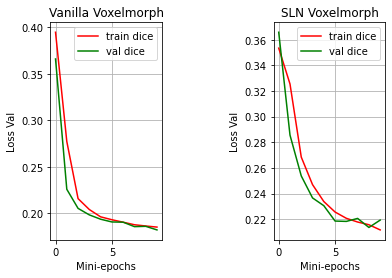

In [4]:
domain = len(train_loss1)
x_values = [i for i in range(domain)]

a1 = plt.subplot(1,2,1)
plt.title("Vanilla Voxelmorph")
plt.xlabel("Mini-epochs")
plt.ylabel("Loss Val")

#plt.plot(x_values, train_loss1, color="blue", label="train loss")
#plt.plot(x_values, train_recon1, color="orange", label="train recon")
plt.plot(x_values, train_dice1, color="red", label="train dice")
plt.plot(x_values, val_dice1, color="green", label="val dice")

plt.legend()
plt.grid()

a4 = plt.subplot(1,2,2)
plt.title("SLN Voxelmorph")
plt.xlabel("Mini-epochs")
plt.ylabel("Loss Val")

#plt.plot(x_values, train_loss4, color="blue", label="train loss")
#plt.plot(x_values, train_recon4, color="orange", label="train recon")
plt.plot(x_values, train_dice4, color="red", label="train dice")
plt.plot(x_values, val_dice4, color="green", label="val dice")

plt.legend()
plt.grid()

plt.subplots_adjust(wspace=1)

plt.show()

In [ ]:
dir_i = '/home/gid-dalcaav/projects/neuron/data/t1_mix/proc/resize256-crop_x32-slice100/train/vols/'
atlas_file = '/home/vib9/src/voxelmorph/data/atlas_norm.npz'
# Prepare the vm1 or vm2 model and send to device
nf_enc = [64, 64, 64, 64]
nf_dec = [64, 64, 64, 64, 64, 64, 32]
atlas_vol = np.load(atlas_file)['vol'][np.newaxis, ..., np.newaxis][:,:,:,100,:]
vol_size = atlas_vol.shape[1:-1]

train_file = '/home/vib9/src/SL-Net/jupyter/partitions/scarce_train.txt'
val_file = '/home/vib9/src/SL-Net/jupyter/partitions/val.txt'

model7 = cvpr2018_net(vol_size, nf_enc, nf_dec)

train_loss7, train_recon7, train_dice7, val_dice7 =train(model7,
                                                                  gpu='0',
                                                                  data_dir=dir_i,
                                                                  train_file=train_file,
                                                                  val_file=val_file,
                                                                  atlas_file=atlas_file,
                                                                  lr=1e-4,
                                                                  n_iter=20000,
                                                                  data_loss='mse',
                                                                  model='vm2',
                                                                  reg_param=0.01, 
                                                                  batch_size=1,
                                                                  target_label_numbers=target_label_numbers)

Train Epoch: 0 | Loss: 0.007496 | Reconstruction Loss: 0.007496 | Dice Score: 0.372200
Val iter 0: 0.665721
Val iter 1: 0.619863
Val iter 2: 0.508802
Val iter 3: 0.653683
Val iter 4: 0.628852
Val iter 5: 0.620924
Val iter 6: 0.593000
Val iter 7: 0.688277
Val iter 8: 0.603959
Val iter 9: 0.657191
Val iter 10: 0.698081
Val iter 11: 0.657258
Val iter 12: 0.602409
Val iter 13: 0.628734
Val iter 14: 0.601565
Val iter 15: 0.595580
Val iter 16: 0.587415
Val iter 17: 0.648168
Val iter 18: 0.660762
Val iter 19: 0.600287
Val iter 20: 0.615791
Val iter 21: 0.653464
Val iter 22: 0.635374
Val iter 23: 0.663118
Val iter 24: 0.633141
Val iter 25: 0.626957
Val iter 26: 0.597249
Val iter 27: 0.637335
Val iter 28: 0.644024
Val iter 29: 0.648020
Val iter 30: 0.646317
Val iter 31: 0.608776
Val iter 32: 0.616670
Val iter 33: 0.620796
Val iter 34: 0.586214
Val iter 35: 0.682568
Val iter 36: 0.644889
Val iter 37: 0.642519
Val iter 38: 0.580720
Val iter 39: 0.602685
Val iter 40: 0.591150
Val iter 41: 0.673201

Val iter 358: 0.594622
Val iter 359: 0.667765
Val iter 360: 0.607832
Val iter 361: 0.624457
Val iter 362: 0.722521
Val iter 363: 0.620170
Val iter 364: 0.703886
Val iter 365: 0.677453
Val iter 366: 0.651838
Val iter 367: 0.607896
Val iter 368: 0.693010
Val iter 369: 0.644068
Val iter 370: 0.656488
Val iter 371: 0.648715
Val iter 372: 0.594493
Val iter 373: 0.644028
Val iter 374: 0.633477
Val iter 375: 0.636804
Val iter 376: 0.642515
Val iter 377: 0.585178
Val iter 378: 0.648379
Val iter 379: 0.663820
Val iter 380: 0.626677
Val iter 381: 0.666247
Val iter 382: 0.656098
Val iter 383: 0.599328
Val iter 384: 0.581805
Val iter 385: 0.620644
Val iter 386: 0.579669
Val iter 387: 0.649559
Val iter 388: 0.567843
Val iter 389: 0.686849
Val iter 390: 0.663327
Val iter 391: 0.660426
Val iter 392: 0.566066
Val iter 393: 0.686336
Val iter 394: 0.641569
Val iter 395: 0.701287
Val iter 396: 0.662637
Val iter 397: 0.652880
Val iter 398: 0.639738
Val iter 399: 0.605092
Val iter 400: 0.696312
Val iter 40

Val iter 715: 0.607745
Val iter 716: 0.620943
Val iter 717: 0.671756
Val iter 718: 0.498328
Val iter 719: 0.553125
Val iter 720: 0.614926
Val iter 721: 0.709856
Val iter 722: 0.683362
Val iter 723: 0.673325
Val iter 724: 0.674484
Val iter 725: 0.557049
Val iter 726: 0.671410
Val iter 727: 0.546472
Val iter 728: 0.692902
Val iter 729: 0.578198
Val iter 730: 0.691937
Val iter 731: 0.531126
Train Epoch: 1 | Loss: 0.007496 | Reconstruction Loss: 0.007496 | Dice Score: 0.372200
Train Epoch: 2 | Loss: 0.007495 | Reconstruction Loss: 0.007495 | Dice Score: 0.372200
Train Epoch: 3 | Loss: 0.009019 | Reconstruction Loss: 0.009019 | Dice Score: 0.369570
Train Epoch: 4 | Loss: 0.007404 | Reconstruction Loss: 0.007404 | Dice Score: 0.374198
Train Epoch: 5 | Loss: 0.007404 | Reconstruction Loss: 0.007404 | Dice Score: 0.374198
Train Epoch: 6 | Loss: 0.007404 | Reconstruction Loss: 0.007404 | Dice Score: 0.374198
Train Epoch: 7 | Loss: 0.007378 | Reconstruction Loss: 0.007378 | Dice Score: 0.356390


Train Epoch: 90 | Loss: 0.007121 | Reconstruction Loss: 0.007119 | Dice Score: 0.357194
Train Epoch: 91 | Loss: 0.007074 | Reconstruction Loss: 0.007071 | Dice Score: 0.357962
Train Epoch: 92 | Loss: 0.008850 | Reconstruction Loss: 0.008848 | Dice Score: 0.333115
Train Epoch: 93 | Loss: 0.007065 | Reconstruction Loss: 0.007063 | Dice Score: 0.358254
Train Epoch: 94 | Loss: 0.007057 | Reconstruction Loss: 0.007055 | Dice Score: 0.360024
Train Epoch: 95 | Loss: 0.008666 | Reconstruction Loss: 0.008663 | Dice Score: 0.341161
Train Epoch: 96 | Loss: 0.007036 | Reconstruction Loss: 0.007033 | Dice Score: 0.365812
Train Epoch: 97 | Loss: 0.008646 | Reconstruction Loss: 0.008643 | Dice Score: 0.335578
Train Epoch: 98 | Loss: 0.007031 | Reconstruction Loss: 0.007027 | Dice Score: 0.370336
Train Epoch: 99 | Loss: 0.007176 | Reconstruction Loss: 0.007172 | Dice Score: 0.365401
Train Epoch: 100 | Loss: 0.008634 | Reconstruction Loss: 0.008629 | Dice Score: 0.335945
Train Epoch: 101 | Loss: 0.0086

Train Epoch: 183 | Loss: 0.006223 | Reconstruction Loss: 0.006157 | Dice Score: 0.279621
Train Epoch: 184 | Loss: 0.006196 | Reconstruction Loss: 0.006125 | Dice Score: 0.276903
Train Epoch: 185 | Loss: 0.007073 | Reconstruction Loss: 0.006964 | Dice Score: 0.319369
Train Epoch: 186 | Loss: 0.006536 | Reconstruction Loss: 0.006460 | Dice Score: 0.326568
Train Epoch: 187 | Loss: 0.006199 | Reconstruction Loss: 0.006098 | Dice Score: 0.263897
Train Epoch: 188 | Loss: 0.006703 | Reconstruction Loss: 0.006541 | Dice Score: 0.305567
Train Epoch: 189 | Loss: 0.006249 | Reconstruction Loss: 0.006114 | Dice Score: 0.270143
Train Epoch: 190 | Loss: 0.007250 | Reconstruction Loss: 0.007029 | Dice Score: 0.283166
Train Epoch: 191 | Loss: 0.006161 | Reconstruction Loss: 0.005976 | Dice Score: 0.264407
Train Epoch: 192 | Loss: 0.006700 | Reconstruction Loss: 0.006529 | Dice Score: 0.318427
Train Epoch: 193 | Loss: 0.006772 | Reconstruction Loss: 0.006510 | Dice Score: 0.315297
Train Epoch: 194 | Lo

Train Epoch: 276 | Loss: 0.005498 | Reconstruction Loss: 0.005188 | Dice Score: 0.243899
Train Epoch: 277 | Loss: 0.005314 | Reconstruction Loss: 0.004812 | Dice Score: 0.269059
Train Epoch: 278 | Loss: 0.005268 | Reconstruction Loss: 0.004988 | Dice Score: 0.301301
Train Epoch: 279 | Loss: 0.005242 | Reconstruction Loss: 0.004795 | Dice Score: 0.272933
Train Epoch: 280 | Loss: 0.005466 | Reconstruction Loss: 0.005232 | Dice Score: 0.308614
Train Epoch: 281 | Loss: 0.005284 | Reconstruction Loss: 0.005027 | Dice Score: 0.309532
Train Epoch: 282 | Loss: 0.005133 | Reconstruction Loss: 0.004708 | Dice Score: 0.267083
Train Epoch: 283 | Loss: 0.005266 | Reconstruction Loss: 0.005006 | Dice Score: 0.295014
Train Epoch: 284 | Loss: 0.005176 | Reconstruction Loss: 0.004911 | Dice Score: 0.240059
Train Epoch: 285 | Loss: 0.005717 | Reconstruction Loss: 0.005308 | Dice Score: 0.252722
Train Epoch: 286 | Loss: 0.005062 | Reconstruction Loss: 0.004610 | Dice Score: 0.260724
Train Epoch: 287 | Lo

Train Epoch: 369 | Loss: 0.004758 | Reconstruction Loss: 0.004151 | Dice Score: 0.244801
Train Epoch: 370 | Loss: 0.004501 | Reconstruction Loss: 0.003911 | Dice Score: 0.252439
Train Epoch: 371 | Loss: 0.004423 | Reconstruction Loss: 0.003892 | Dice Score: 0.244325
Train Epoch: 372 | Loss: 0.004434 | Reconstruction Loss: 0.003961 | Dice Score: 0.242176
Train Epoch: 373 | Loss: 0.004814 | Reconstruction Loss: 0.004515 | Dice Score: 0.301498
Train Epoch: 374 | Loss: 0.004985 | Reconstruction Loss: 0.004528 | Dice Score: 0.229150
Train Epoch: 375 | Loss: 0.004617 | Reconstruction Loss: 0.004268 | Dice Score: 0.231106
Train Epoch: 376 | Loss: 0.005039 | Reconstruction Loss: 0.004688 | Dice Score: 0.271253
Train Epoch: 377 | Loss: 0.004558 | Reconstruction Loss: 0.003929 | Dice Score: 0.256923
Train Epoch: 378 | Loss: 0.005164 | Reconstruction Loss: 0.004790 | Dice Score: 0.274842
Train Epoch: 379 | Loss: 0.004475 | Reconstruction Loss: 0.003892 | Dice Score: 0.244950
Train Epoch: 380 | Lo

Train Epoch: 462 | Loss: 0.004198 | Reconstruction Loss: 0.003581 | Dice Score: 0.240230
Train Epoch: 463 | Loss: 0.004927 | Reconstruction Loss: 0.004523 | Dice Score: 0.277509
Train Epoch: 464 | Loss: 0.004486 | Reconstruction Loss: 0.003864 | Dice Score: 0.253121
Train Epoch: 465 | Loss: 0.004249 | Reconstruction Loss: 0.003805 | Dice Score: 0.223706
Train Epoch: 466 | Loss: 0.004564 | Reconstruction Loss: 0.003913 | Dice Score: 0.220897
Train Epoch: 467 | Loss: 0.004873 | Reconstruction Loss: 0.004491 | Dice Score: 0.271750
Train Epoch: 468 | Loss: 0.004741 | Reconstruction Loss: 0.004117 | Dice Score: 0.225064
Train Epoch: 469 | Loss: 0.004724 | Reconstruction Loss: 0.004337 | Dice Score: 0.262491
Train Epoch: 470 | Loss: 0.004709 | Reconstruction Loss: 0.004316 | Dice Score: 0.262680
Train Epoch: 471 | Loss: 0.004600 | Reconstruction Loss: 0.003916 | Dice Score: 0.232312
Train Epoch: 472 | Loss: 0.004656 | Reconstruction Loss: 0.004216 | Dice Score: 0.294295
Train Epoch: 473 | Lo

Train Epoch: 555 | Loss: 0.004494 | Reconstruction Loss: 0.004001 | Dice Score: 0.255007
Train Epoch: 556 | Loss: 0.003965 | Reconstruction Loss: 0.003395 | Dice Score: 0.214360
Train Epoch: 557 | Loss: 0.004267 | Reconstruction Loss: 0.003519 | Dice Score: 0.218340
Train Epoch: 558 | Loss: 0.003927 | Reconstruction Loss: 0.003262 | Dice Score: 0.232643
Train Epoch: 559 | Loss: 0.003900 | Reconstruction Loss: 0.003245 | Dice Score: 0.232438
Train Epoch: 560 | Loss: 0.004246 | Reconstruction Loss: 0.003546 | Dice Score: 0.217164
Train Epoch: 561 | Loss: 0.003892 | Reconstruction Loss: 0.003225 | Dice Score: 0.233157
Train Epoch: 562 | Loss: 0.004287 | Reconstruction Loss: 0.003778 | Dice Score: 0.273863
Train Epoch: 563 | Loss: 0.004458 | Reconstruction Loss: 0.003990 | Dice Score: 0.254238
Train Epoch: 564 | Loss: 0.004290 | Reconstruction Loss: 0.003594 | Dice Score: 0.218545
Train Epoch: 565 | Loss: 0.004436 | Reconstruction Loss: 0.003965 | Dice Score: 0.252846
Train Epoch: 566 | Lo

Train Epoch: 648 | Loss: 0.004253 | Reconstruction Loss: 0.003703 | Dice Score: 0.251964
Train Epoch: 649 | Loss: 0.004168 | Reconstruction Loss: 0.003416 | Dice Score: 0.216743
Train Epoch: 650 | Loss: 0.003775 | Reconstruction Loss: 0.003092 | Dice Score: 0.231493
Train Epoch: 651 | Loss: 0.004217 | Reconstruction Loss: 0.003475 | Dice Score: 0.217964
Train Epoch: 652 | Loss: 0.004159 | Reconstruction Loss: 0.003429 | Dice Score: 0.216137
Train Epoch: 653 | Loss: 0.004163 | Reconstruction Loss: 0.003458 | Dice Score: 0.220546
Train Epoch: 654 | Loss: 0.003919 | Reconstruction Loss: 0.003357 | Dice Score: 0.220168
Train Epoch: 655 | Loss: 0.004159 | Reconstruction Loss: 0.003646 | Dice Score: 0.273374
Train Epoch: 656 | Loss: 0.003919 | Reconstruction Loss: 0.003374 | Dice Score: 0.208754
Train Epoch: 657 | Loss: 0.003938 | Reconstruction Loss: 0.003389 | Dice Score: 0.206187
Train Epoch: 658 | Loss: 0.003873 | Reconstruction Loss: 0.003316 | Dice Score: 0.210734
Train Epoch: 659 | Lo

Train Epoch: 741 | Loss: 0.003800 | Reconstruction Loss: 0.003196 | Dice Score: 0.212304
Train Epoch: 742 | Loss: 0.003981 | Reconstruction Loss: 0.003269 | Dice Score: 0.211759
Train Epoch: 743 | Loss: 0.003727 | Reconstruction Loss: 0.003037 | Dice Score: 0.225947
Train Epoch: 744 | Loss: 0.003716 | Reconstruction Loss: 0.003004 | Dice Score: 0.227683
Train Epoch: 745 | Loss: 0.004091 | Reconstruction Loss: 0.003517 | Dice Score: 0.244020
Train Epoch: 746 | Loss: 0.003955 | Reconstruction Loss: 0.003175 | Dice Score: 0.216235
Train Epoch: 747 | Loss: 0.004078 | Reconstruction Loss: 0.003498 | Dice Score: 0.244158
Train Epoch: 748 | Loss: 0.004076 | Reconstruction Loss: 0.003501 | Dice Score: 0.245546
Train Epoch: 749 | Loss: 0.004029 | Reconstruction Loss: 0.003429 | Dice Score: 0.261406
Train Epoch: 750 | Loss: 0.003711 | Reconstruction Loss: 0.002987 | Dice Score: 0.230995
Train Epoch: 751 | Loss: 0.003782 | Reconstruction Loss: 0.003153 | Dice Score: 0.213675
Train Epoch: 752 | Lo

Train Epoch: 834 | Loss: 0.004114 | Reconstruction Loss: 0.003512 | Dice Score: 0.248188
Train Epoch: 835 | Loss: 0.003948 | Reconstruction Loss: 0.003319 | Dice Score: 0.251079
Train Epoch: 836 | Loss: 0.003712 | Reconstruction Loss: 0.002987 | Dice Score: 0.227154
Train Epoch: 837 | Loss: 0.003949 | Reconstruction Loss: 0.003373 | Dice Score: 0.273560
Train Epoch: 838 | Loss: 0.003816 | Reconstruction Loss: 0.003214 | Dice Score: 0.201915
Train Epoch: 839 | Loss: 0.003946 | Reconstruction Loss: 0.003411 | Dice Score: 0.260442
Train Epoch: 840 | Loss: 0.003945 | Reconstruction Loss: 0.003234 | Dice Score: 0.212164
Train Epoch: 841 | Loss: 0.004248 | Reconstruction Loss: 0.003716 | Dice Score: 0.304800
Train Epoch: 842 | Loss: 0.003997 | Reconstruction Loss: 0.003456 | Dice Score: 0.275717
Train Epoch: 843 | Loss: 0.004006 | Reconstruction Loss: 0.003257 | Dice Score: 0.208709
Train Epoch: 844 | Loss: 0.003847 | Reconstruction Loss: 0.003133 | Dice Score: 0.235974
Train Epoch: 845 | Lo

Train Epoch: 927 | Loss: 0.003538 | Reconstruction Loss: 0.002838 | Dice Score: 0.224543
Train Epoch: 928 | Loss: 0.003541 | Reconstruction Loss: 0.002837 | Dice Score: 0.223256
Train Epoch: 929 | Loss: 0.003700 | Reconstruction Loss: 0.002956 | Dice Score: 0.205512
Train Epoch: 930 | Loss: 0.003959 | Reconstruction Loss: 0.003385 | Dice Score: 0.236141
Train Epoch: 931 | Loss: 0.003872 | Reconstruction Loss: 0.003255 | Dice Score: 0.257030
Train Epoch: 932 | Loss: 0.003715 | Reconstruction Loss: 0.003058 | Dice Score: 0.208590
Train Epoch: 933 | Loss: 0.003975 | Reconstruction Loss: 0.003383 | Dice Score: 0.240188
Train Epoch: 934 | Loss: 0.003986 | Reconstruction Loss: 0.003397 | Dice Score: 0.242003
Train Epoch: 935 | Loss: 0.003738 | Reconstruction Loss: 0.002997 | Dice Score: 0.206114
Train Epoch: 936 | Loss: 0.003833 | Reconstruction Loss: 0.003232 | Dice Score: 0.247123
Train Epoch: 937 | Loss: 0.003937 | Reconstruction Loss: 0.003374 | Dice Score: 0.238879
Train Epoch: 938 | Lo

Val iter 74: 0.777844
Val iter 75: 0.732598
Val iter 76: 0.761419
Val iter 77: 0.731897
Val iter 78: 0.756208
Val iter 79: 0.744900
Val iter 80: 0.728475
Val iter 81: 0.749098
Val iter 82: 0.774479
Val iter 83: 0.739243
Val iter 84: 0.780625
Val iter 85: 0.760514
Val iter 86: 0.737558
Val iter 87: 0.745831
Val iter 88: 0.725705
Val iter 89: 0.729747
Val iter 90: 0.736231
Val iter 91: 0.740093
Val iter 92: 0.694761
Val iter 93: 0.664912
Val iter 94: 0.764027
Val iter 95: 0.681235
Val iter 96: 0.747084
Val iter 97: 0.777265
Val iter 98: 0.776424
Val iter 99: 0.777948
Val iter 100: 0.741017
Val iter 101: 0.759552
Val iter 102: 0.738092
Val iter 103: 0.780484
Val iter 104: 0.788750
Val iter 105: 0.737977
Val iter 106: 0.661673
Val iter 107: 0.781948
Val iter 108: 0.765538
Val iter 109: 0.782046
Val iter 110: 0.763024
Val iter 111: 0.702331
Val iter 112: 0.795583
Val iter 113: 0.759128
Val iter 114: 0.742580
Val iter 115: 0.756838
Val iter 116: 0.664881
Val iter 117: 0.771415
Val iter 118: 

Val iter 432: 0.714042
Val iter 433: 0.752322
Val iter 434: 0.748060
Val iter 435: 0.742475
Val iter 436: 0.750766
Val iter 437: 0.712190
Val iter 438: 0.760439
Val iter 439: 0.686221
Val iter 440: 0.659276
Val iter 441: 0.755747
Val iter 442: 0.746772
Val iter 443: 0.661293
Val iter 444: 0.681362
Val iter 445: 0.785088
Val iter 446: 0.619712
Val iter 447: 0.664621
Val iter 448: 0.764713
Val iter 449: 0.772206
Val iter 450: 0.797324
Val iter 451: 0.791077
Val iter 452: 0.780596
Val iter 453: 0.777216
Val iter 454: 0.784182
Val iter 455: 0.740785
Val iter 456: 0.792809
Val iter 457: 0.768668
Val iter 458: 0.774836
Val iter 459: 0.738860
Val iter 460: 0.774882
Val iter 461: 0.782240
Val iter 462: 0.747400
Val iter 463: 0.760112
Val iter 464: 0.696724
Val iter 465: 0.716566
Val iter 466: 0.784527
Val iter 467: 0.765635
Val iter 468: 0.741009
Val iter 469: 0.754061
Val iter 470: 0.768627
Val iter 471: 0.761280
Val iter 472: 0.763512
Val iter 473: 0.782758
Val iter 474: 0.747654
Val iter 47

Train Epoch: 1016 | Loss: 0.003385 | Reconstruction Loss: 0.002724 | Dice Score: 0.219242
Train Epoch: 1017 | Loss: 0.003626 | Reconstruction Loss: 0.002995 | Dice Score: 0.198026
Train Epoch: 1018 | Loss: 0.003620 | Reconstruction Loss: 0.002978 | Dice Score: 0.196464
Train Epoch: 1019 | Loss: 0.003854 | Reconstruction Loss: 0.003283 | Dice Score: 0.229527
Train Epoch: 1020 | Loss: 0.003549 | Reconstruction Loss: 0.002788 | Dice Score: 0.204709
Train Epoch: 1021 | Loss: 0.003821 | Reconstruction Loss: 0.003245 | Dice Score: 0.234837
Train Epoch: 1022 | Loss: 0.003431 | Reconstruction Loss: 0.002737 | Dice Score: 0.224606
Train Epoch: 1023 | Loss: 0.003393 | Reconstruction Loss: 0.002703 | Dice Score: 0.225260
Train Epoch: 1024 | Loss: 0.003474 | Reconstruction Loss: 0.002748 | Dice Score: 0.200546
Train Epoch: 1025 | Loss: 0.003629 | Reconstruction Loss: 0.002971 | Dice Score: 0.203486
Train Epoch: 1026 | Loss: 0.003612 | Reconstruction Loss: 0.002954 | Dice Score: 0.194925
Train Epoc

Train Epoch: 1108 | Loss: 0.003701 | Reconstruction Loss: 0.003120 | Dice Score: 0.224548
Train Epoch: 1109 | Loss: 0.003401 | Reconstruction Loss: 0.002699 | Dice Score: 0.205337
Train Epoch: 1110 | Loss: 0.003566 | Reconstruction Loss: 0.002920 | Dice Score: 0.204376
Train Epoch: 1111 | Loss: 0.003504 | Reconstruction Loss: 0.002880 | Dice Score: 0.203761
Train Epoch: 1112 | Loss: 0.003580 | Reconstruction Loss: 0.003035 | Dice Score: 0.247628
Train Epoch: 1113 | Loss: 0.003280 | Reconstruction Loss: 0.002639 | Dice Score: 0.226595
Train Epoch: 1114 | Loss: 0.003697 | Reconstruction Loss: 0.003178 | Dice Score: 0.235577
Train Epoch: 1115 | Loss: 0.003268 | Reconstruction Loss: 0.002588 | Dice Score: 0.222089
Train Epoch: 1116 | Loss: 0.003669 | Reconstruction Loss: 0.003116 | Dice Score: 0.232600
Train Epoch: 1117 | Loss: 0.003184 | Reconstruction Loss: 0.002448 | Dice Score: 0.220779
Train Epoch: 1118 | Loss: 0.003595 | Reconstruction Loss: 0.002993 | Dice Score: 0.245299
Train Epoc

Train Epoch: 1200 | Loss: 0.003491 | Reconstruction Loss: 0.002912 | Dice Score: 0.253241
Train Epoch: 1201 | Loss: 0.003084 | Reconstruction Loss: 0.002401 | Dice Score: 0.214864
Train Epoch: 1202 | Loss: 0.003062 | Reconstruction Loss: 0.002380 | Dice Score: 0.215600
Train Epoch: 1203 | Loss: 0.003170 | Reconstruction Loss: 0.002431 | Dice Score: 0.195397
Train Epoch: 1204 | Loss: 0.003625 | Reconstruction Loss: 0.003073 | Dice Score: 0.229083
Train Epoch: 1205 | Loss: 0.003287 | Reconstruction Loss: 0.002537 | Dice Score: 0.204055
Train Epoch: 1206 | Loss: 0.003368 | Reconstruction Loss: 0.002750 | Dice Score: 0.195744
Train Epoch: 1207 | Loss: 0.003466 | Reconstruction Loss: 0.002904 | Dice Score: 0.235449
Train Epoch: 1208 | Loss: 0.003559 | Reconstruction Loss: 0.003008 | Dice Score: 0.224796
Train Epoch: 1209 | Loss: 0.003576 | Reconstruction Loss: 0.003040 | Dice Score: 0.232264
Train Epoch: 1210 | Loss: 0.003160 | Reconstruction Loss: 0.002532 | Dice Score: 0.221676
Train Epoc

Train Epoch: 1292 | Loss: 0.002869 | Reconstruction Loss: 0.002206 | Dice Score: 0.216687
Train Epoch: 1293 | Loss: 0.003009 | Reconstruction Loss: 0.002290 | Dice Score: 0.194379
Train Epoch: 1294 | Loss: 0.003420 | Reconstruction Loss: 0.002829 | Dice Score: 0.217026
Train Epoch: 1295 | Loss: 0.003311 | Reconstruction Loss: 0.002685 | Dice Score: 0.194276
Train Epoch: 1296 | Loss: 0.003375 | Reconstruction Loss: 0.002814 | Dice Score: 0.220475
Train Epoch: 1297 | Loss: 0.002865 | Reconstruction Loss: 0.002186 | Dice Score: 0.216048
Train Epoch: 1298 | Loss: 0.003330 | Reconstruction Loss: 0.002720 | Dice Score: 0.200694
Train Epoch: 1299 | Loss: 0.003302 | Reconstruction Loss: 0.002672 | Dice Score: 0.200081
Train Epoch: 1300 | Loss: 0.003023 | Reconstruction Loss: 0.002267 | Dice Score: 0.187312
Train Epoch: 1301 | Loss: 0.003375 | Reconstruction Loss: 0.002779 | Dice Score: 0.219589
Train Epoch: 1302 | Loss: 0.002992 | Reconstruction Loss: 0.002251 | Dice Score: 0.193701
Train Epoc

Train Epoch: 1384 | Loss: 0.003373 | Reconstruction Loss: 0.002795 | Dice Score: 0.243904
Train Epoch: 1385 | Loss: 0.003378 | Reconstruction Loss: 0.002793 | Dice Score: 0.244709
Train Epoch: 1386 | Loss: 0.003216 | Reconstruction Loss: 0.002573 | Dice Score: 0.196706
Train Epoch: 1387 | Loss: 0.003228 | Reconstruction Loss: 0.002575 | Dice Score: 0.196521
Train Epoch: 1388 | Loss: 0.002864 | Reconstruction Loss: 0.002141 | Dice Score: 0.211507
Train Epoch: 1389 | Loss: 0.003210 | Reconstruction Loss: 0.002551 | Dice Score: 0.189654
Train Epoch: 1390 | Loss: 0.003191 | Reconstruction Loss: 0.002548 | Dice Score: 0.191672
Train Epoch: 1391 | Loss: 0.003194 | Reconstruction Loss: 0.002572 | Dice Score: 0.197696
Train Epoch: 1392 | Loss: 0.002809 | Reconstruction Loss: 0.002137 | Dice Score: 0.211419
Train Epoch: 1393 | Loss: 0.003167 | Reconstruction Loss: 0.002582 | Dice Score: 0.191130
Train Epoch: 1394 | Loss: 0.002906 | Reconstruction Loss: 0.002225 | Dice Score: 0.184687
Train Epoc

Train Epoch: 1476 | Loss: 0.003305 | Reconstruction Loss: 0.002788 | Dice Score: 0.218262
Train Epoch: 1477 | Loss: 0.003074 | Reconstruction Loss: 0.002476 | Dice Score: 0.192947
Train Epoch: 1478 | Loss: 0.002733 | Reconstruction Loss: 0.002090 | Dice Score: 0.213795
Train Epoch: 1479 | Loss: 0.003093 | Reconstruction Loss: 0.002489 | Dice Score: 0.195418
Train Epoch: 1480 | Loss: 0.002800 | Reconstruction Loss: 0.002127 | Dice Score: 0.186752
Train Epoch: 1481 | Loss: 0.003243 | Reconstruction Loss: 0.002733 | Dice Score: 0.217393
Train Epoch: 1482 | Loss: 0.002761 | Reconstruction Loss: 0.002095 | Dice Score: 0.184356
Train Epoch: 1483 | Loss: 0.002711 | Reconstruction Loss: 0.002076 | Dice Score: 0.213866
Train Epoch: 1484 | Loss: 0.002755 | Reconstruction Loss: 0.002046 | Dice Score: 0.187681
Train Epoch: 1485 | Loss: 0.002695 | Reconstruction Loss: 0.002037 | Dice Score: 0.211327
Train Epoch: 1486 | Loss: 0.003232 | Reconstruction Loss: 0.002674 | Dice Score: 0.214679
Train Epoc

Train Epoch: 1568 | Loss: 0.003033 | Reconstruction Loss: 0.002438 | Dice Score: 0.195088
Train Epoch: 1569 | Loss: 0.003256 | Reconstruction Loss: 0.002672 | Dice Score: 0.237662
Train Epoch: 1570 | Loss: 0.002823 | Reconstruction Loss: 0.002161 | Dice Score: 0.216102
Train Epoch: 1571 | Loss: 0.003131 | Reconstruction Loss: 0.002476 | Dice Score: 0.198075
Train Epoch: 1572 | Loss: 0.002798 | Reconstruction Loss: 0.002058 | Dice Score: 0.193393
Train Epoch: 1573 | Loss: 0.003372 | Reconstruction Loss: 0.002743 | Dice Score: 0.215520
Train Epoch: 1574 | Loss: 0.002794 | Reconstruction Loss: 0.002050 | Dice Score: 0.216770
Train Epoch: 1575 | Loss: 0.003242 | Reconstruction Loss: 0.002617 | Dice Score: 0.214726
Train Epoch: 1576 | Loss: 0.003267 | Reconstruction Loss: 0.002665 | Dice Score: 0.221205
Train Epoch: 1577 | Loss: 0.002734 | Reconstruction Loss: 0.002081 | Dice Score: 0.213818
Train Epoch: 1578 | Loss: 0.003185 | Reconstruction Loss: 0.002662 | Dice Score: 0.219956
Train Epoc

In [18]:
dir_i = '/home/gid-dalcaav/projects/neuron/data/t1_mix/proc/resize256-crop_x32-slice100/train/vols/'
atlas_file = '/home/vib9/src/voxelmorph/data/atlas_norm.npz'
# Prepare the vm1 or vm2 model and send to device
nf_enc = [64, 64, 64, 64]
nf_dec = [64, 64, 64, 64, 64, 64, 32]
atlas_vol = np.load(atlas_file)['vol'][np.newaxis, ..., np.newaxis][:,:,:,100,:]
vol_size = atlas_vol.shape[1:-1]

train_file = '/home/vib9/src/SL-Net/jupyter/partitions/scarce_train.txt'
val_file = '/home/vib9/src/SL-Net/jupyter/partitions/val.txt'

w = np.load("/home/vib9/src/SL-Net/superlayer/models/superblocks/SLN_64.npy")

model8 = cvpr2018_net(vol_size, nf_enc, nf_dec, superblock_size=64, weight=w)

train_loss8, train_recon8, train_dice8, val_dice8 =train(model8,
                                                                  gpu='0',
                                                                  data_dir=dir_i,
                                                                  train_file=train_file,
                                                                  val_file=val_file,
                                                                  atlas_file=atlas_file,
                                                                  lr=1e-4,
                                                                  n_iter=10000,
                                                                  data_loss='mse',
                                                                  model='vm2',
                                                                  reg_param=0.01, 
                                                                  batch_size=1,
                                                                  target_label_numbers=target_label_numbers)

Train Epoch: 0 | Loss: 0.009220 | Reconstruction Loss: 0.009220 | Dice Score: 0.368044
Val iter 0: 0.665721
Val iter 1: 0.619863
Val iter 2: 0.508802
Val iter 3: 0.653683
Val iter 4: 0.628852
Val iter 5: 0.620924
Val iter 6: 0.593000
Val iter 7: 0.688277
Val iter 8: 0.603959
Val iter 9: 0.657191
Val iter 10: 0.698081
Val iter 11: 0.657258
Val iter 12: 0.602409
Val iter 13: 0.628734
Val iter 14: 0.601565
Val iter 15: 0.595580
Val iter 16: 0.587415
Val iter 17: 0.648168
Val iter 18: 0.660762
Val iter 19: 0.600287
Val iter 20: 0.615791
Val iter 21: 0.653464
Val iter 22: 0.635374
Val iter 23: 0.663118
Val iter 24: 0.633141
Val iter 25: 0.626957
Val iter 26: 0.597249
Val iter 27: 0.637335
Val iter 28: 0.644024
Val iter 29: 0.648020
Val iter 30: 0.646317
Val iter 31: 0.608776
Val iter 32: 0.616670
Val iter 33: 0.620796
Val iter 34: 0.586214
Val iter 35: 0.682568
Val iter 36: 0.644889
Val iter 37: 0.642519
Val iter 38: 0.580720
Val iter 39: 0.602685
Val iter 40: 0.591150
Val iter 41: 0.673201

Val iter 358: 0.594622
Val iter 359: 0.667765
Val iter 360: 0.607832
Val iter 361: 0.624457
Val iter 362: 0.722521
Val iter 363: 0.620170
Val iter 364: 0.703886
Val iter 365: 0.677453
Val iter 366: 0.651838
Val iter 367: 0.607896
Val iter 368: 0.693010
Val iter 369: 0.644068
Val iter 370: 0.656488
Val iter 371: 0.648715
Val iter 372: 0.594493
Val iter 373: 0.644028
Val iter 374: 0.633477
Val iter 375: 0.636804
Val iter 376: 0.642515
Val iter 377: 0.585178
Val iter 378: 0.648379
Val iter 379: 0.663820
Val iter 380: 0.626677
Val iter 381: 0.666247
Val iter 382: 0.656098
Val iter 383: 0.599328
Val iter 384: 0.581805
Val iter 385: 0.620644
Val iter 386: 0.579669
Val iter 387: 0.649559
Val iter 388: 0.567843
Val iter 389: 0.686849
Val iter 390: 0.663327
Val iter 391: 0.660426
Val iter 392: 0.566066
Val iter 393: 0.686336
Val iter 394: 0.641569
Val iter 395: 0.701287
Val iter 396: 0.662637
Val iter 397: 0.652880
Val iter 398: 0.639738
Val iter 399: 0.605092
Val iter 400: 0.696312
Val iter 40

Val iter 715: 0.607745
Val iter 716: 0.620943
Val iter 717: 0.671756
Val iter 718: 0.498328
Val iter 719: 0.553125
Val iter 720: 0.614926
Val iter 721: 0.709856
Val iter 722: 0.683362
Val iter 723: 0.673325
Val iter 724: 0.674484
Val iter 725: 0.557049
Val iter 726: 0.671410
Val iter 727: 0.546472
Val iter 728: 0.692902
Val iter 729: 0.578198
Val iter 730: 0.691937
Val iter 731: 0.531126
Train Epoch: 1 | Loss: 0.007380 | Reconstruction Loss: 0.007380 | Dice Score: 0.356390
Train Epoch: 2 | Loss: 0.007405 | Reconstruction Loss: 0.007405 | Dice Score: 0.374198
Train Epoch: 3 | Loss: 0.007405 | Reconstruction Loss: 0.007405 | Dice Score: 0.374198
Train Epoch: 4 | Loss: 0.007379 | Reconstruction Loss: 0.007379 | Dice Score: 0.356390
Train Epoch: 5 | Loss: 0.009019 | Reconstruction Loss: 0.009019 | Dice Score: 0.369570
Train Epoch: 6 | Loss: 0.009218 | Reconstruction Loss: 0.009218 | Dice Score: 0.368044
Train Epoch: 7 | Loss: 0.007493 | Reconstruction Loss: 0.007493 | Dice Score: 0.372200


Train Epoch: 90 | Loss: 0.008716 | Reconstruction Loss: 0.008713 | Dice Score: 0.335995
Train Epoch: 91 | Loss: 0.007079 | Reconstruction Loss: 0.007076 | Dice Score: 0.357152
Train Epoch: 92 | Loss: 0.009045 | Reconstruction Loss: 0.009042 | Dice Score: 0.333259
Train Epoch: 93 | Loss: 0.007039 | Reconstruction Loss: 0.007036 | Dice Score: 0.307458
Train Epoch: 94 | Loss: 0.007039 | Reconstruction Loss: 0.007036 | Dice Score: 0.307369
Train Epoch: 95 | Loss: 0.007038 | Reconstruction Loss: 0.007036 | Dice Score: 0.307316
Train Epoch: 96 | Loss: 0.008703 | Reconstruction Loss: 0.008701 | Dice Score: 0.335944
Train Epoch: 97 | Loss: 0.007067 | Reconstruction Loss: 0.007064 | Dice Score: 0.356957
Train Epoch: 98 | Loss: 0.007062 | Reconstruction Loss: 0.007059 | Dice Score: 0.357256
Train Epoch: 99 | Loss: 0.007212 | Reconstruction Loss: 0.007209 | Dice Score: 0.353570
Train Epoch: 100 | Loss: 0.007036 | Reconstruction Loss: 0.007032 | Dice Score: 0.307442
Train Epoch: 101 | Loss: 0.0090

Train Epoch: 183 | Loss: 0.007033 | Reconstruction Loss: 0.007029 | Dice Score: 0.357207
Train Epoch: 184 | Loss: 0.009068 | Reconstruction Loss: 0.009064 | Dice Score: 0.332933
Train Epoch: 185 | Loss: 0.007028 | Reconstruction Loss: 0.007024 | Dice Score: 0.357234
Train Epoch: 186 | Loss: 0.008577 | Reconstruction Loss: 0.008573 | Dice Score: 0.336787
Train Epoch: 187 | Loss: 0.007223 | Reconstruction Loss: 0.007219 | Dice Score: 0.352630
Train Epoch: 188 | Loss: 0.007015 | Reconstruction Loss: 0.007011 | Dice Score: 0.358190
Train Epoch: 189 | Loss: 0.008543 | Reconstruction Loss: 0.008539 | Dice Score: 0.340254
Train Epoch: 190 | Loss: 0.007008 | Reconstruction Loss: 0.007004 | Dice Score: 0.359054
Train Epoch: 191 | Loss: 0.007006 | Reconstruction Loss: 0.007001 | Dice Score: 0.361088
Train Epoch: 192 | Loss: 0.007020 | Reconstruction Loss: 0.007015 | Dice Score: 0.306998
Train Epoch: 193 | Loss: 0.009129 | Reconstruction Loss: 0.009124 | Dice Score: 0.327242
Train Epoch: 194 | Lo

Train Epoch: 276 | Loss: 0.007191 | Reconstruction Loss: 0.007187 | Dice Score: 0.353486
Train Epoch: 277 | Loss: 0.009026 | Reconstruction Loss: 0.009022 | Dice Score: 0.334680
Train Epoch: 278 | Loss: 0.007184 | Reconstruction Loss: 0.007181 | Dice Score: 0.352935
Train Epoch: 279 | Loss: 0.006975 | Reconstruction Loss: 0.006971 | Dice Score: 0.307621
Train Epoch: 280 | Loss: 0.008570 | Reconstruction Loss: 0.008566 | Dice Score: 0.338003
Train Epoch: 281 | Loss: 0.007008 | Reconstruction Loss: 0.007004 | Dice Score: 0.357190
Train Epoch: 282 | Loss: 0.006974 | Reconstruction Loss: 0.006970 | Dice Score: 0.307686
Train Epoch: 283 | Loss: 0.007002 | Reconstruction Loss: 0.006998 | Dice Score: 0.357535
Train Epoch: 284 | Loss: 0.006971 | Reconstruction Loss: 0.006967 | Dice Score: 0.307539
Train Epoch: 285 | Loss: 0.006993 | Reconstruction Loss: 0.006988 | Dice Score: 0.358154
Train Epoch: 286 | Loss: 0.006968 | Reconstruction Loss: 0.006964 | Dice Score: 0.307404
Train Epoch: 287 | Lo

Train Epoch: 369 | Loss: 0.008898 | Reconstruction Loss: 0.008876 | Dice Score: 0.326358
Train Epoch: 370 | Loss: 0.008835 | Reconstruction Loss: 0.008815 | Dice Score: 0.322660
Train Epoch: 371 | Loss: 0.008118 | Reconstruction Loss: 0.008099 | Dice Score: 0.334020
Train Epoch: 372 | Loss: 0.007136 | Reconstruction Loss: 0.007119 | Dice Score: 0.352113
Train Epoch: 373 | Loss: 0.007000 | Reconstruction Loss: 0.006983 | Dice Score: 0.357310
Train Epoch: 374 | Loss: 0.007131 | Reconstruction Loss: 0.007114 | Dice Score: 0.350591
Train Epoch: 375 | Loss: 0.008133 | Reconstruction Loss: 0.008114 | Dice Score: 0.337668
Train Epoch: 376 | Loss: 0.006676 | Reconstruction Loss: 0.006656 | Dice Score: 0.300930
Train Epoch: 377 | Loss: 0.007167 | Reconstruction Loss: 0.007146 | Dice Score: 0.345066
Train Epoch: 378 | Loss: 0.007191 | Reconstruction Loss: 0.007170 | Dice Score: 0.342412
Train Epoch: 379 | Loss: 0.006636 | Reconstruction Loss: 0.006614 | Dice Score: 0.290502
Train Epoch: 380 | Lo

Train Epoch: 462 | Loss: 0.007014 | Reconstruction Loss: 0.006949 | Dice Score: 0.302491
Train Epoch: 463 | Loss: 0.007098 | Reconstruction Loss: 0.007056 | Dice Score: 0.347169
Train Epoch: 464 | Loss: 0.006928 | Reconstruction Loss: 0.006883 | Dice Score: 0.345220
Train Epoch: 465 | Loss: 0.006431 | Reconstruction Loss: 0.006382 | Dice Score: 0.287749
Train Epoch: 466 | Loss: 0.006980 | Reconstruction Loss: 0.006914 | Dice Score: 0.301235
Train Epoch: 467 | Loss: 0.006951 | Reconstruction Loss: 0.006883 | Dice Score: 0.299371
Train Epoch: 468 | Loss: 0.008335 | Reconstruction Loss: 0.008276 | Dice Score: 0.301703
Train Epoch: 469 | Loss: 0.008257 | Reconstruction Loss: 0.008199 | Dice Score: 0.304219
Train Epoch: 470 | Loss: 0.006997 | Reconstruction Loss: 0.006931 | Dice Score: 0.308814
Train Epoch: 471 | Loss: 0.006492 | Reconstruction Loss: 0.006446 | Dice Score: 0.301574
Train Epoch: 472 | Loss: 0.008106 | Reconstruction Loss: 0.008052 | Dice Score: 0.307448
Train Epoch: 473 | Lo

Train Epoch: 555 | Loss: 0.007172 | Reconstruction Loss: 0.007024 | Dice Score: 0.297804
Train Epoch: 556 | Loss: 0.006473 | Reconstruction Loss: 0.006353 | Dice Score: 0.323740
Train Epoch: 557 | Loss: 0.006129 | Reconstruction Loss: 0.005989 | Dice Score: 0.288845
Train Epoch: 558 | Loss: 0.006413 | Reconstruction Loss: 0.006295 | Dice Score: 0.314105
Train Epoch: 559 | Loss: 0.006022 | Reconstruction Loss: 0.005890 | Dice Score: 0.264900
Train Epoch: 560 | Loss: 0.006250 | Reconstruction Loss: 0.006133 | Dice Score: 0.313207
Train Epoch: 561 | Loss: 0.006247 | Reconstruction Loss: 0.006135 | Dice Score: 0.315963
Train Epoch: 562 | Loss: 0.006506 | Reconstruction Loss: 0.006403 | Dice Score: 0.315037
Train Epoch: 563 | Loss: 0.006062 | Reconstruction Loss: 0.005946 | Dice Score: 0.254898
Train Epoch: 564 | Loss: 0.006206 | Reconstruction Loss: 0.006094 | Dice Score: 0.313453
Train Epoch: 565 | Loss: 0.006396 | Reconstruction Loss: 0.006227 | Dice Score: 0.289098
Train Epoch: 566 | Lo

Train Epoch: 648 | Loss: 0.005827 | Reconstruction Loss: 0.005475 | Dice Score: 0.270411
Train Epoch: 649 | Loss: 0.005661 | Reconstruction Loss: 0.005403 | Dice Score: 0.263863
Train Epoch: 650 | Loss: 0.005910 | Reconstruction Loss: 0.005530 | Dice Score: 0.278096
Train Epoch: 651 | Loss: 0.005731 | Reconstruction Loss: 0.005482 | Dice Score: 0.294695
Train Epoch: 652 | Loss: 0.005782 | Reconstruction Loss: 0.005404 | Dice Score: 0.270452
Train Epoch: 653 | Loss: 0.005913 | Reconstruction Loss: 0.005672 | Dice Score: 0.295594
Train Epoch: 654 | Loss: 0.006416 | Reconstruction Loss: 0.006089 | Dice Score: 0.260085
Train Epoch: 655 | Loss: 0.005865 | Reconstruction Loss: 0.005608 | Dice Score: 0.299004
Train Epoch: 656 | Loss: 0.005727 | Reconstruction Loss: 0.005457 | Dice Score: 0.294177
Train Epoch: 657 | Loss: 0.005631 | Reconstruction Loss: 0.005344 | Dice Score: 0.257833
Train Epoch: 658 | Loss: 0.006209 | Reconstruction Loss: 0.005865 | Dice Score: 0.261357
Train Epoch: 659 | Lo

Train Epoch: 741 | Loss: 0.005255 | Reconstruction Loss: 0.004949 | Dice Score: 0.241481
Train Epoch: 742 | Loss: 0.005740 | Reconstruction Loss: 0.005328 | Dice Score: 0.252796
Train Epoch: 743 | Loss: 0.005261 | Reconstruction Loss: 0.004953 | Dice Score: 0.244140
Train Epoch: 744 | Loss: 0.005455 | Reconstruction Loss: 0.005144 | Dice Score: 0.306957
Train Epoch: 745 | Loss: 0.005769 | Reconstruction Loss: 0.005373 | Dice Score: 0.253135
Train Epoch: 746 | Loss: 0.005246 | Reconstruction Loss: 0.004957 | Dice Score: 0.238425
Train Epoch: 747 | Loss: 0.005309 | Reconstruction Loss: 0.004857 | Dice Score: 0.257597
Train Epoch: 748 | Loss: 0.005229 | Reconstruction Loss: 0.004927 | Dice Score: 0.240446
Train Epoch: 749 | Loss: 0.005470 | Reconstruction Loss: 0.005193 | Dice Score: 0.298172
Train Epoch: 750 | Loss: 0.005274 | Reconstruction Loss: 0.004825 | Dice Score: 0.252831
Train Epoch: 751 | Loss: 0.005279 | Reconstruction Loss: 0.004830 | Dice Score: 0.252455
Train Epoch: 752 | Lo

Train Epoch: 834 | Loss: 0.005121 | Reconstruction Loss: 0.004807 | Dice Score: 0.235253
Train Epoch: 835 | Loss: 0.005340 | Reconstruction Loss: 0.005045 | Dice Score: 0.299687
Train Epoch: 836 | Loss: 0.005446 | Reconstruction Loss: 0.005001 | Dice Score: 0.255380
Train Epoch: 837 | Loss: 0.005067 | Reconstruction Loss: 0.004741 | Dice Score: 0.239135
Train Epoch: 838 | Loss: 0.005012 | Reconstruction Loss: 0.004527 | Dice Score: 0.247109
Train Epoch: 839 | Loss: 0.005452 | Reconstruction Loss: 0.005016 | Dice Score: 0.251645
Train Epoch: 840 | Loss: 0.005190 | Reconstruction Loss: 0.004864 | Dice Score: 0.303547
Train Epoch: 841 | Loss: 0.005187 | Reconstruction Loss: 0.004861 | Dice Score: 0.303584
Train Epoch: 842 | Loss: 0.005430 | Reconstruction Loss: 0.004992 | Dice Score: 0.251869
Train Epoch: 843 | Loss: 0.005196 | Reconstruction Loss: 0.004863 | Dice Score: 0.299926
Train Epoch: 844 | Loss: 0.005022 | Reconstruction Loss: 0.004543 | Dice Score: 0.247250
Train Epoch: 845 | Lo

Train Epoch: 927 | Loss: 0.005208 | Reconstruction Loss: 0.004752 | Dice Score: 0.246447
Train Epoch: 928 | Loss: 0.005026 | Reconstruction Loss: 0.004686 | Dice Score: 0.310270
Train Epoch: 929 | Loss: 0.005278 | Reconstruction Loss: 0.004988 | Dice Score: 0.299927
Train Epoch: 930 | Loss: 0.005265 | Reconstruction Loss: 0.004829 | Dice Score: 0.248226
Train Epoch: 931 | Loss: 0.004836 | Reconstruction Loss: 0.004373 | Dice Score: 0.242013
Train Epoch: 932 | Loss: 0.004855 | Reconstruction Loss: 0.004379 | Dice Score: 0.242550
Train Epoch: 933 | Loss: 0.004946 | Reconstruction Loss: 0.004612 | Dice Score: 0.238828
Train Epoch: 934 | Loss: 0.005261 | Reconstruction Loss: 0.004949 | Dice Score: 0.294668
Train Epoch: 935 | Loss: 0.004949 | Reconstruction Loss: 0.004603 | Dice Score: 0.235719
Train Epoch: 936 | Loss: 0.004933 | Reconstruction Loss: 0.004578 | Dice Score: 0.236554
Train Epoch: 937 | Loss: 0.005235 | Reconstruction Loss: 0.004747 | Dice Score: 0.251814
Train Epoch: 938 | Lo

Val iter 74: 0.748032
Val iter 75: 0.705500
Val iter 76: 0.737798
Val iter 77: 0.689922
Val iter 78: 0.732708
Val iter 79: 0.707562
Val iter 80: 0.693949
Val iter 81: 0.718082
Val iter 82: 0.730927
Val iter 83: 0.714502
Val iter 84: 0.747035
Val iter 85: 0.729263
Val iter 86: 0.694661
Val iter 87: 0.731722
Val iter 88: 0.687440
Val iter 89: 0.708776
Val iter 90: 0.688410
Val iter 91: 0.692014
Val iter 92: 0.678652
Val iter 93: 0.629869
Val iter 94: 0.731746
Val iter 95: 0.639363
Val iter 96: 0.733309
Val iter 97: 0.752555
Val iter 98: 0.750482
Val iter 99: 0.759560
Val iter 100: 0.703318
Val iter 101: 0.738212
Val iter 102: 0.689061
Val iter 103: 0.761996
Val iter 104: 0.767418
Val iter 105: 0.707081
Val iter 106: 0.626070
Val iter 107: 0.750870
Val iter 108: 0.738368
Val iter 109: 0.749641
Val iter 110: 0.739833
Val iter 111: 0.662025
Val iter 112: 0.742074
Val iter 113: 0.730026
Val iter 114: 0.724076
Val iter 115: 0.718904
Val iter 116: 0.642058
Val iter 117: 0.740175
Val iter 118: 

Val iter 432: 0.686619
Val iter 433: 0.739608
Val iter 434: 0.709486
Val iter 435: 0.694191
Val iter 436: 0.724174
Val iter 437: 0.678482
Val iter 438: 0.749681
Val iter 439: 0.664963
Val iter 440: 0.619623
Val iter 441: 0.732346
Val iter 442: 0.709324
Val iter 443: 0.668145
Val iter 444: 0.629448
Val iter 445: 0.759286
Val iter 446: 0.558818
Val iter 447: 0.644463
Val iter 448: 0.734570
Val iter 449: 0.744361
Val iter 450: 0.770150
Val iter 451: 0.757942
Val iter 452: 0.768957
Val iter 453: 0.741834
Val iter 454: 0.764382
Val iter 455: 0.721343
Val iter 456: 0.778990
Val iter 457: 0.739944
Val iter 458: 0.734327
Val iter 459: 0.717901
Val iter 460: 0.761017
Val iter 461: 0.761542
Val iter 462: 0.722263
Val iter 463: 0.725790
Val iter 464: 0.647734
Val iter 465: 0.669557
Val iter 466: 0.770422
Val iter 467: 0.764419
Val iter 468: 0.708522
Val iter 469: 0.724955
Val iter 470: 0.746858
Val iter 471: 0.741474
Val iter 472: 0.723640
Val iter 473: 0.755804
Val iter 474: 0.728422
Val iter 47

Train Epoch: 1016 | Loss: 0.004950 | Reconstruction Loss: 0.004580 | Dice Score: 0.310676
Train Epoch: 1017 | Loss: 0.004898 | Reconstruction Loss: 0.004528 | Dice Score: 0.302415
Train Epoch: 1018 | Loss: 0.004905 | Reconstruction Loss: 0.004539 | Dice Score: 0.291813
Train Epoch: 1019 | Loss: 0.005222 | Reconstruction Loss: 0.004744 | Dice Score: 0.252624
Train Epoch: 1020 | Loss: 0.005131 | Reconstruction Loss: 0.004652 | Dice Score: 0.246932
Train Epoch: 1021 | Loss: 0.004784 | Reconstruction Loss: 0.004274 | Dice Score: 0.239595
Train Epoch: 1022 | Loss: 0.005220 | Reconstruction Loss: 0.004893 | Dice Score: 0.288127
Train Epoch: 1023 | Loss: 0.004908 | Reconstruction Loss: 0.004571 | Dice Score: 0.229981
Train Epoch: 1024 | Loss: 0.004901 | Reconstruction Loss: 0.004548 | Dice Score: 0.293620
Train Epoch: 1025 | Loss: 0.004890 | Reconstruction Loss: 0.004535 | Dice Score: 0.299494
Train Epoch: 1026 | Loss: 0.004816 | Reconstruction Loss: 0.004468 | Dice Score: 0.233986
Train Epoc

Train Epoch: 1108 | Loss: 0.004961 | Reconstruction Loss: 0.004490 | Dice Score: 0.238761
Train Epoch: 1109 | Loss: 0.004811 | Reconstruction Loss: 0.004444 | Dice Score: 0.302194
Train Epoch: 1110 | Loss: 0.005165 | Reconstruction Loss: 0.004838 | Dice Score: 0.286855
Train Epoch: 1111 | Loss: 0.004859 | Reconstruction Loss: 0.004515 | Dice Score: 0.228471
Train Epoch: 1112 | Loss: 0.004954 | Reconstruction Loss: 0.004472 | Dice Score: 0.238263
Train Epoch: 1113 | Loss: 0.005223 | Reconstruction Loss: 0.004882 | Dice Score: 0.288449
Train Epoch: 1114 | Loss: 0.005191 | Reconstruction Loss: 0.004850 | Dice Score: 0.283967
Train Epoch: 1115 | Loss: 0.005156 | Reconstruction Loss: 0.004821 | Dice Score: 0.277982
Train Epoch: 1116 | Loss: 0.004672 | Reconstruction Loss: 0.004177 | Dice Score: 0.234115
Train Epoch: 1117 | Loss: 0.004867 | Reconstruction Loss: 0.004499 | Dice Score: 0.289678
Train Epoch: 1118 | Loss: 0.004640 | Reconstruction Loss: 0.004126 | Dice Score: 0.232929
Train Epoc

Train Epoch: 1200 | Loss: 0.005099 | Reconstruction Loss: 0.004772 | Dice Score: 0.274447
Train Epoch: 1201 | Loss: 0.004849 | Reconstruction Loss: 0.004507 | Dice Score: 0.227041
Train Epoch: 1202 | Loss: 0.004922 | Reconstruction Loss: 0.004447 | Dice Score: 0.238238
Train Epoch: 1203 | Loss: 0.004699 | Reconstruction Loss: 0.004338 | Dice Score: 0.233531
Train Epoch: 1204 | Loss: 0.004710 | Reconstruction Loss: 0.004197 | Dice Score: 0.244874
Train Epoch: 1205 | Loss: 0.004926 | Reconstruction Loss: 0.004457 | Dice Score: 0.237413
Train Epoch: 1206 | Loss: 0.004556 | Reconstruction Loss: 0.004090 | Dice Score: 0.232698
Train Epoch: 1207 | Loss: 0.004911 | Reconstruction Loss: 0.004589 | Dice Score: 0.226929
Train Epoch: 1208 | Loss: 0.004749 | Reconstruction Loss: 0.004420 | Dice Score: 0.226207
Train Epoch: 1209 | Loss: 0.004708 | Reconstruction Loss: 0.004364 | Dice Score: 0.235343
Train Epoch: 1210 | Loss: 0.004879 | Reconstruction Loss: 0.004387 | Dice Score: 0.255672
Train Epoc

Train Epoch: 1292 | Loss: 0.005102 | Reconstruction Loss: 0.004761 | Dice Score: 0.279531
Train Epoch: 1293 | Loss: 0.005129 | Reconstruction Loss: 0.004787 | Dice Score: 0.279524
Train Epoch: 1294 | Loss: 0.004914 | Reconstruction Loss: 0.004447 | Dice Score: 0.237348
Train Epoch: 1295 | Loss: 0.004429 | Reconstruction Loss: 0.003949 | Dice Score: 0.231446
Train Epoch: 1296 | Loss: 0.004470 | Reconstruction Loss: 0.003999 | Dice Score: 0.231953
Train Epoch: 1297 | Loss: 0.004760 | Reconstruction Loss: 0.004407 | Dice Score: 0.278784
Train Epoch: 1298 | Loss: 0.004696 | Reconstruction Loss: 0.004339 | Dice Score: 0.285444
Train Epoch: 1299 | Loss: 0.004482 | Reconstruction Loss: 0.003989 | Dice Score: 0.235402
Train Epoch: 1300 | Loss: 0.004487 | Reconstruction Loss: 0.003993 | Dice Score: 0.235818
Train Epoch: 1301 | Loss: 0.004684 | Reconstruction Loss: 0.004325 | Dice Score: 0.289323
Train Epoch: 1302 | Loss: 0.004700 | Reconstruction Loss: 0.004363 | Dice Score: 0.223498
Train Epoc

Train Epoch: 1384 | Loss: 0.004822 | Reconstruction Loss: 0.004334 | Dice Score: 0.233157
Train Epoch: 1385 | Loss: 0.004432 | Reconstruction Loss: 0.003910 | Dice Score: 0.230952
Train Epoch: 1386 | Loss: 0.004446 | Reconstruction Loss: 0.003922 | Dice Score: 0.232190
Train Epoch: 1387 | Loss: 0.004797 | Reconstruction Loss: 0.004306 | Dice Score: 0.233826
Train Epoch: 1388 | Loss: 0.004429 | Reconstruction Loss: 0.003927 | Dice Score: 0.231488
Train Epoch: 1389 | Loss: 0.004658 | Reconstruction Loss: 0.004282 | Dice Score: 0.286266
Train Epoch: 1390 | Loss: 0.004630 | Reconstruction Loss: 0.004264 | Dice Score: 0.218139
Train Epoch: 1391 | Loss: 0.004688 | Reconstruction Loss: 0.004299 | Dice Score: 0.299755
Train Epoch: 1392 | Loss: 0.004485 | Reconstruction Loss: 0.003957 | Dice Score: 0.235855
Train Epoch: 1393 | Loss: 0.004606 | Reconstruction Loss: 0.004223 | Dice Score: 0.286287
Train Epoch: 1394 | Loss: 0.005021 | Reconstruction Loss: 0.004673 | Dice Score: 0.275310
Train Epoc

Train Epoch: 1476 | Loss: 0.004514 | Reconstruction Loss: 0.004144 | Dice Score: 0.222429
Train Epoch: 1477 | Loss: 0.004357 | Reconstruction Loss: 0.003840 | Dice Score: 0.229603
Train Epoch: 1478 | Loss: 0.004340 | Reconstruction Loss: 0.003826 | Dice Score: 0.227189
Train Epoch: 1479 | Loss: 0.004537 | Reconstruction Loss: 0.004171 | Dice Score: 0.217044
Train Epoch: 1480 | Loss: 0.004322 | Reconstruction Loss: 0.003811 | Dice Score: 0.227921
Train Epoch: 1481 | Loss: 0.004776 | Reconstruction Loss: 0.004291 | Dice Score: 0.232623
Train Epoch: 1482 | Loss: 0.004314 | Reconstruction Loss: 0.003799 | Dice Score: 0.227975
Train Epoch: 1483 | Loss: 0.004532 | Reconstruction Loss: 0.004161 | Dice Score: 0.217566
Train Epoch: 1484 | Loss: 0.004317 | Reconstruction Loss: 0.003794 | Dice Score: 0.228376
Train Epoch: 1485 | Loss: 0.004316 | Reconstruction Loss: 0.003791 | Dice Score: 0.227572
Train Epoch: 1486 | Loss: 0.004299 | Reconstruction Loss: 0.003778 | Dice Score: 0.227950
Train Epoc

Train Epoch: 1568 | Loss: 0.004512 | Reconstruction Loss: 0.004134 | Dice Score: 0.214072
Train Epoch: 1569 | Loss: 0.004560 | Reconstruction Loss: 0.004165 | Dice Score: 0.289518
Train Epoch: 1570 | Loss: 0.004963 | Reconstruction Loss: 0.004588 | Dice Score: 0.275443
Train Epoch: 1571 | Loss: 0.004241 | Reconstruction Loss: 0.003705 | Dice Score: 0.227579
Train Epoch: 1572 | Loss: 0.004943 | Reconstruction Loss: 0.004569 | Dice Score: 0.269243
Train Epoch: 1573 | Loss: 0.004573 | Reconstruction Loss: 0.004174 | Dice Score: 0.273371
Train Epoch: 1574 | Loss: 0.004472 | Reconstruction Loss: 0.004075 | Dice Score: 0.214626
Train Epoch: 1575 | Loss: 0.004462 | Reconstruction Loss: 0.004055 | Dice Score: 0.220980
Train Epoch: 1576 | Loss: 0.005024 | Reconstruction Loss: 0.004631 | Dice Score: 0.271891
Train Epoch: 1577 | Loss: 0.004260 | Reconstruction Loss: 0.003703 | Dice Score: 0.231008
Train Epoch: 1578 | Loss: 0.004923 | Reconstruction Loss: 0.004545 | Dice Score: 0.270302
Train Epoc

Train Epoch: 1660 | Loss: 0.004899 | Reconstruction Loss: 0.004514 | Dice Score: 0.273170
Train Epoch: 1661 | Loss: 0.004455 | Reconstruction Loss: 0.004056 | Dice Score: 0.212675
Train Epoch: 1662 | Loss: 0.004197 | Reconstruction Loss: 0.003641 | Dice Score: 0.226792
Train Epoch: 1663 | Loss: 0.004510 | Reconstruction Loss: 0.004099 | Dice Score: 0.275454
Train Epoch: 1664 | Loss: 0.004192 | Reconstruction Loss: 0.003631 | Dice Score: 0.229290
Train Epoch: 1665 | Loss: 0.004505 | Reconstruction Loss: 0.004097 | Dice Score: 0.278370
Train Epoch: 1666 | Loss: 0.004649 | Reconstruction Loss: 0.004129 | Dice Score: 0.230994
Train Epoch: 1667 | Loss: 0.004182 | Reconstruction Loss: 0.003638 | Dice Score: 0.225461
Train Epoch: 1668 | Loss: 0.004497 | Reconstruction Loss: 0.004094 | Dice Score: 0.276952
Train Epoch: 1669 | Loss: 0.004502 | Reconstruction Loss: 0.004098 | Dice Score: 0.280641
Train Epoch: 1670 | Loss: 0.004651 | Reconstruction Loss: 0.004144 | Dice Score: 0.230044
Train Epoc

Train Epoch: 1752 | Loss: 0.004407 | Reconstruction Loss: 0.004005 | Dice Score: 0.212294
Train Epoch: 1753 | Loss: 0.004379 | Reconstruction Loss: 0.003971 | Dice Score: 0.216686
Train Epoch: 1754 | Loss: 0.004688 | Reconstruction Loss: 0.004154 | Dice Score: 0.237827
Train Epoch: 1755 | Loss: 0.004601 | Reconstruction Loss: 0.004078 | Dice Score: 0.227883
Train Epoch: 1756 | Loss: 0.004601 | Reconstruction Loss: 0.004091 | Dice Score: 0.225888
Train Epoch: 1757 | Loss: 0.004553 | Reconstruction Loss: 0.004150 | Dice Score: 0.286936
Train Epoch: 1758 | Loss: 0.004206 | Reconstruction Loss: 0.003671 | Dice Score: 0.228997
Train Epoch: 1759 | Loss: 0.004589 | Reconstruction Loss: 0.004074 | Dice Score: 0.227387
Train Epoch: 1760 | Loss: 0.004416 | Reconstruction Loss: 0.004005 | Dice Score: 0.219576
Train Epoch: 1761 | Loss: 0.004591 | Reconstruction Loss: 0.004067 | Dice Score: 0.227453
Train Epoch: 1762 | Loss: 0.004534 | Reconstruction Loss: 0.004012 | Dice Score: 0.222548
Train Epoc

Train Epoch: 1844 | Loss: 0.004142 | Reconstruction Loss: 0.003576 | Dice Score: 0.228593
Train Epoch: 1845 | Loss: 0.004521 | Reconstruction Loss: 0.003976 | Dice Score: 0.227632
Train Epoch: 1846 | Loss: 0.004137 | Reconstruction Loss: 0.003566 | Dice Score: 0.228662
Train Epoch: 1847 | Loss: 0.004472 | Reconstruction Loss: 0.004053 | Dice Score: 0.267715
Train Epoch: 1848 | Loss: 0.004358 | Reconstruction Loss: 0.003943 | Dice Score: 0.211476
Train Epoch: 1849 | Loss: 0.004128 | Reconstruction Loss: 0.003558 | Dice Score: 0.228006
Train Epoch: 1850 | Loss: 0.004457 | Reconstruction Loss: 0.004036 | Dice Score: 0.273836
Train Epoch: 1851 | Loss: 0.004117 | Reconstruction Loss: 0.003548 | Dice Score: 0.228144
Train Epoch: 1852 | Loss: 0.004815 | Reconstruction Loss: 0.004415 | Dice Score: 0.268903
Train Epoch: 1853 | Loss: 0.004812 | Reconstruction Loss: 0.004412 | Dice Score: 0.270989
Train Epoch: 1854 | Loss: 0.004389 | Reconstruction Loss: 0.003973 | Dice Score: 0.207442
Train Epoc

Train Epoch: 1936 | Loss: 0.004436 | Reconstruction Loss: 0.003999 | Dice Score: 0.267272
Train Epoch: 1937 | Loss: 0.004430 | Reconstruction Loss: 0.003994 | Dice Score: 0.271396
Train Epoch: 1938 | Loss: 0.004769 | Reconstruction Loss: 0.004353 | Dice Score: 0.267076
Train Epoch: 1939 | Loss: 0.004765 | Reconstruction Loss: 0.004352 | Dice Score: 0.267920
Train Epoch: 1940 | Loss: 0.004419 | Reconstruction Loss: 0.003991 | Dice Score: 0.269316
Train Epoch: 1941 | Loss: 0.004322 | Reconstruction Loss: 0.003892 | Dice Score: 0.207393
Train Epoch: 1942 | Loss: 0.004498 | Reconstruction Loss: 0.003942 | Dice Score: 0.227038
Train Epoch: 1943 | Loss: 0.004774 | Reconstruction Loss: 0.004353 | Dice Score: 0.269517
Train Epoch: 1944 | Loss: 0.004411 | Reconstruction Loss: 0.003976 | Dice Score: 0.275381
Train Epoch: 1945 | Loss: 0.004468 | Reconstruction Loss: 0.003912 | Dice Score: 0.222287
Train Epoch: 1946 | Loss: 0.004455 | Reconstruction Loss: 0.003895 | Dice Score: 0.221867
Train Epoc

Val iter 107: 0.769662
Val iter 108: 0.741078
Val iter 109: 0.772102
Val iter 110: 0.751697
Val iter 111: 0.630557
Val iter 112: 0.770692
Val iter 113: 0.740238
Val iter 114: 0.740251
Val iter 115: 0.729104
Val iter 116: 0.641424
Val iter 117: 0.741992
Val iter 118: 0.708257
Val iter 119: 0.712378
Val iter 120: 0.744626
Val iter 121: 0.762902
Val iter 122: 0.459623
Val iter 123: 0.743404
Val iter 124: 0.646452
Val iter 125: 0.598615
Val iter 126: 0.739015
Val iter 127: 0.754881
Val iter 128: 0.727340
Val iter 129: 0.774312
Val iter 130: 0.727081
Val iter 131: 0.686727
Val iter 132: 0.693563
Val iter 133: 0.760933
Val iter 134: 0.624983
Val iter 135: 0.683984
Val iter 136: 0.773483
Val iter 137: 0.657142
Val iter 138: 0.762897
Val iter 139: 0.759187
Val iter 140: 0.724121
Val iter 141: 0.741572
Val iter 142: 0.756464
Val iter 143: 0.779261
Val iter 144: 0.745807
Val iter 145: 0.780977
Val iter 146: 0.773969
Val iter 147: 0.623818
Val iter 148: 0.743826
Val iter 149: 0.748219
Val iter 15

Val iter 464: 0.653384
Val iter 465: 0.678756
Val iter 466: 0.768414
Val iter 467: 0.751248
Val iter 468: 0.728857
Val iter 469: 0.746334
Val iter 470: 0.752688
Val iter 471: 0.759210
Val iter 472: 0.738005
Val iter 473: 0.771443
Val iter 474: 0.743640
Val iter 475: 0.783514
Val iter 476: 0.660090
Val iter 477: 0.754948
Val iter 478: 0.724831
Val iter 479: 0.766175
Val iter 480: 0.750040
Val iter 481: 0.735643
Val iter 482: 0.769381
Val iter 483: 0.681535
Val iter 484: 0.757065
Val iter 485: 0.789069
Val iter 486: 0.719294
Val iter 487: 0.712282
Val iter 488: 0.673553
Val iter 489: 0.643302
Val iter 490: 0.669641
Val iter 491: 0.789915
Val iter 492: 0.769821
Val iter 493: 0.787076
Val iter 494: 0.721631
Val iter 495: 0.762120
Val iter 496: 0.715651
Val iter 497: 0.756325
Val iter 498: 0.692040
Val iter 499: 0.780106
Val iter 500: 0.736162
Val iter 501: 0.760389
Val iter 502: 0.677793
Val iter 503: 0.679875
Val iter 504: 0.787760
Val iter 505: 0.759617
Val iter 506: 0.747614
Val iter 50

Train Epoch: 2024 | Loss: 0.004477 | Reconstruction Loss: 0.004047 | Dice Score: 0.212031
Train Epoch: 2025 | Loss: 0.004304 | Reconstruction Loss: 0.003866 | Dice Score: 0.208508
Train Epoch: 2026 | Loss: 0.004161 | Reconstruction Loss: 0.003532 | Dice Score: 0.233494
Train Epoch: 2027 | Loss: 0.004641 | Reconstruction Loss: 0.004199 | Dice Score: 0.305393
Train Epoch: 2028 | Loss: 0.004441 | Reconstruction Loss: 0.003879 | Dice Score: 0.222416
Train Epoch: 2029 | Loss: 0.004551 | Reconstruction Loss: 0.004015 | Dice Score: 0.222365
Train Epoch: 2030 | Loss: 0.004576 | Reconstruction Loss: 0.004048 | Dice Score: 0.224288
Train Epoch: 2031 | Loss: 0.004310 | Reconstruction Loss: 0.003889 | Dice Score: 0.204483
Train Epoch: 2032 | Loss: 0.004347 | Reconstruction Loss: 0.003908 | Dice Score: 0.223004
Train Epoch: 2033 | Loss: 0.004993 | Reconstruction Loss: 0.004568 | Dice Score: 0.273871
Train Epoch: 2034 | Loss: 0.004849 | Reconstruction Loss: 0.004427 | Dice Score: 0.264282
Train Epoc

Train Epoch: 2116 | Loss: 0.004364 | Reconstruction Loss: 0.003801 | Dice Score: 0.215594
Train Epoch: 2117 | Loss: 0.004165 | Reconstruction Loss: 0.003588 | Dice Score: 0.228862
Train Epoch: 2118 | Loss: 0.004462 | Reconstruction Loss: 0.004022 | Dice Score: 0.270635
Train Epoch: 2119 | Loss: 0.004380 | Reconstruction Loss: 0.003934 | Dice Score: 0.270013
Train Epoch: 2120 | Loss: 0.004153 | Reconstruction Loss: 0.003542 | Dice Score: 0.230659
Train Epoch: 2121 | Loss: 0.004401 | Reconstruction Loss: 0.003949 | Dice Score: 0.277509
Train Epoch: 2122 | Loss: 0.004358 | Reconstruction Loss: 0.003784 | Dice Score: 0.218034
Train Epoch: 2123 | Loss: 0.004776 | Reconstruction Loss: 0.004340 | Dice Score: 0.274007
Train Epoch: 2124 | Loss: 0.004225 | Reconstruction Loss: 0.003618 | Dice Score: 0.233132
Train Epoch: 2125 | Loss: 0.004244 | Reconstruction Loss: 0.003782 | Dice Score: 0.202197
Train Epoch: 2126 | Loss: 0.004545 | Reconstruction Loss: 0.003948 | Dice Score: 0.231812
Train Epoc

Train Epoch: 2208 | Loss: 0.004237 | Reconstruction Loss: 0.003764 | Dice Score: 0.208775
Train Epoch: 2209 | Loss: 0.004504 | Reconstruction Loss: 0.003898 | Dice Score: 0.226359
Train Epoch: 2210 | Loss: 0.004359 | Reconstruction Loss: 0.003756 | Dice Score: 0.220288
Train Epoch: 2211 | Loss: 0.004349 | Reconstruction Loss: 0.003759 | Dice Score: 0.218719
Train Epoch: 2212 | Loss: 0.004773 | Reconstruction Loss: 0.004322 | Dice Score: 0.276589
Train Epoch: 2213 | Loss: 0.004417 | Reconstruction Loss: 0.003955 | Dice Score: 0.272095
Train Epoch: 2214 | Loss: 0.004315 | Reconstruction Loss: 0.003712 | Dice Score: 0.217486
Train Epoch: 2215 | Loss: 0.004274 | Reconstruction Loss: 0.003791 | Dice Score: 0.216301
Train Epoch: 2216 | Loss: 0.004089 | Reconstruction Loss: 0.003440 | Dice Score: 0.232492
Train Epoch: 2217 | Loss: 0.004223 | Reconstruction Loss: 0.003750 | Dice Score: 0.208940
Train Epoch: 2218 | Loss: 0.004300 | Reconstruction Loss: 0.003714 | Dice Score: 0.215227
Train Epoc

Train Epoch: 2300 | Loss: 0.004179 | Reconstruction Loss: 0.003702 | Dice Score: 0.199690
Train Epoch: 2301 | Loss: 0.004007 | Reconstruction Loss: 0.003373 | Dice Score: 0.228173
Train Epoch: 2302 | Loss: 0.004015 | Reconstruction Loss: 0.003378 | Dice Score: 0.227473
Train Epoch: 2303 | Loss: 0.004335 | Reconstruction Loss: 0.003732 | Dice Score: 0.221379
Train Epoch: 2304 | Loss: 0.004312 | Reconstruction Loss: 0.003720 | Dice Score: 0.216103
Train Epoch: 2305 | Loss: 0.004090 | Reconstruction Loss: 0.003485 | Dice Score: 0.229520
Train Epoch: 2306 | Loss: 0.004299 | Reconstruction Loss: 0.003718 | Dice Score: 0.216062
Train Epoch: 2307 | Loss: 0.004338 | Reconstruction Loss: 0.003885 | Dice Score: 0.274362
Train Epoch: 2308 | Loss: 0.004022 | Reconstruction Loss: 0.003418 | Dice Score: 0.225070
Train Epoch: 2309 | Loss: 0.004293 | Reconstruction Loss: 0.003716 | Dice Score: 0.214948
Train Epoch: 2310 | Loss: 0.004038 | Reconstruction Loss: 0.003436 | Dice Score: 0.229172
Train Epoc

Train Epoch: 2392 | Loss: 0.004627 | Reconstruction Loss: 0.004163 | Dice Score: 0.267193
Train Epoch: 2393 | Loss: 0.004263 | Reconstruction Loss: 0.003651 | Dice Score: 0.215026
Train Epoch: 2394 | Loss: 0.004322 | Reconstruction Loss: 0.003852 | Dice Score: 0.268266
Train Epoch: 2395 | Loss: 0.004151 | Reconstruction Loss: 0.003665 | Dice Score: 0.202932
Train Epoch: 2396 | Loss: 0.003972 | Reconstruction Loss: 0.003323 | Dice Score: 0.226277
Train Epoch: 2397 | Loss: 0.003972 | Reconstruction Loss: 0.003319 | Dice Score: 0.227939
Train Epoch: 2398 | Loss: 0.004283 | Reconstruction Loss: 0.003661 | Dice Score: 0.216316
Train Epoch: 2399 | Loss: 0.004633 | Reconstruction Loss: 0.004163 | Dice Score: 0.261594
Train Epoch: 2400 | Loss: 0.004048 | Reconstruction Loss: 0.003416 | Dice Score: 0.230430
Train Epoch: 2401 | Loss: 0.004281 | Reconstruction Loss: 0.003669 | Dice Score: 0.217634
Train Epoch: 2402 | Loss: 0.004308 | Reconstruction Loss: 0.003701 | Dice Score: 0.219956
Train Epoc

Train Epoch: 2484 | Loss: 0.004320 | Reconstruction Loss: 0.003849 | Dice Score: 0.259705
Train Epoch: 2485 | Loss: 0.004611 | Reconstruction Loss: 0.004142 | Dice Score: 0.259507
Train Epoch: 2486 | Loss: 0.004603 | Reconstruction Loss: 0.004134 | Dice Score: 0.262726
Train Epoch: 2487 | Loss: 0.003949 | Reconstruction Loss: 0.003321 | Dice Score: 0.226294
Train Epoch: 2488 | Loss: 0.004626 | Reconstruction Loss: 0.004148 | Dice Score: 0.262170
Train Epoch: 2489 | Loss: 0.004309 | Reconstruction Loss: 0.003835 | Dice Score: 0.269812
Train Epoch: 2490 | Loss: 0.004305 | Reconstruction Loss: 0.003833 | Dice Score: 0.268712
Train Epoch: 2491 | Loss: 0.004177 | Reconstruction Loss: 0.003692 | Dice Score: 0.203330
Train Epoch: 2492 | Loss: 0.004581 | Reconstruction Loss: 0.004100 | Dice Score: 0.262579
Train Epoch: 2493 | Loss: 0.003936 | Reconstruction Loss: 0.003279 | Dice Score: 0.226219
Train Epoch: 2494 | Loss: 0.004288 | Reconstruction Loss: 0.003797 | Dice Score: 0.266352
Train Epoc

Train Epoch: 2576 | Loss: 0.004584 | Reconstruction Loss: 0.004101 | Dice Score: 0.261508
Train Epoch: 2577 | Loss: 0.004203 | Reconstruction Loss: 0.003555 | Dice Score: 0.217643
Train Epoch: 2578 | Loss: 0.004277 | Reconstruction Loss: 0.003786 | Dice Score: 0.266472
Train Epoch: 2579 | Loss: 0.004303 | Reconstruction Loss: 0.003810 | Dice Score: 0.271792
Train Epoch: 2580 | Loss: 0.004197 | Reconstruction Loss: 0.003554 | Dice Score: 0.217720
Train Epoch: 2581 | Loss: 0.004191 | Reconstruction Loss: 0.003694 | Dice Score: 0.202118
Train Epoch: 2582 | Loss: 0.004171 | Reconstruction Loss: 0.003547 | Dice Score: 0.210360
Train Epoch: 2583 | Loss: 0.003932 | Reconstruction Loss: 0.003282 | Dice Score: 0.227839
Train Epoch: 2584 | Loss: 0.004234 | Reconstruction Loss: 0.003597 | Dice Score: 0.213645
Train Epoch: 2585 | Loss: 0.004161 | Reconstruction Loss: 0.003527 | Dice Score: 0.214944
Train Epoch: 2586 | Loss: 0.004208 | Reconstruction Loss: 0.003708 | Dice Score: 0.202244
Train Epoc

Train Epoch: 2668 | Loss: 0.004555 | Reconstruction Loss: 0.004061 | Dice Score: 0.256443
Train Epoch: 2669 | Loss: 0.004018 | Reconstruction Loss: 0.003365 | Dice Score: 0.230358
Train Epoch: 2670 | Loss: 0.004093 | Reconstruction Loss: 0.003583 | Dice Score: 0.200892
Train Epoch: 2671 | Loss: 0.004110 | Reconstruction Loss: 0.003593 | Dice Score: 0.211325
Train Epoch: 2672 | Loss: 0.004148 | Reconstruction Loss: 0.003629 | Dice Score: 0.216626
Train Epoch: 2673 | Loss: 0.004081 | Reconstruction Loss: 0.003566 | Dice Score: 0.206279
Train Epoch: 2674 | Loss: 0.004271 | Reconstruction Loss: 0.003783 | Dice Score: 0.264851
Train Epoch: 2675 | Loss: 0.004189 | Reconstruction Loss: 0.003559 | Dice Score: 0.211574
Train Epoch: 2676 | Loss: 0.004291 | Reconstruction Loss: 0.003805 | Dice Score: 0.263718
Train Epoch: 2677 | Loss: 0.004054 | Reconstruction Loss: 0.003536 | Dice Score: 0.201452
Train Epoch: 2678 | Loss: 0.004327 | Reconstruction Loss: 0.003835 | Dice Score: 0.279235
Train Epoc

Train Epoch: 2760 | Loss: 0.004064 | Reconstruction Loss: 0.003548 | Dice Score: 0.204290
Train Epoch: 2761 | Loss: 0.004136 | Reconstruction Loss: 0.003491 | Dice Score: 0.212631
Train Epoch: 2762 | Loss: 0.004127 | Reconstruction Loss: 0.003611 | Dice Score: 0.204400
Train Epoch: 2763 | Loss: 0.004267 | Reconstruction Loss: 0.003775 | Dice Score: 0.263480
Train Epoch: 2764 | Loss: 0.003887 | Reconstruction Loss: 0.003212 | Dice Score: 0.224988
Train Epoch: 2765 | Loss: 0.003938 | Reconstruction Loss: 0.003260 | Dice Score: 0.230099
Train Epoch: 2766 | Loss: 0.003869 | Reconstruction Loss: 0.003204 | Dice Score: 0.223112
Train Epoch: 2767 | Loss: 0.004240 | Reconstruction Loss: 0.003753 | Dice Score: 0.264563
Train Epoch: 2768 | Loss: 0.004277 | Reconstruction Loss: 0.003795 | Dice Score: 0.272227
Train Epoch: 2769 | Loss: 0.004130 | Reconstruction Loss: 0.003514 | Dice Score: 0.211686
Train Epoch: 2770 | Loss: 0.004575 | Reconstruction Loss: 0.004080 | Dice Score: 0.257992
Train Epoc

Train Epoch: 2852 | Loss: 0.004474 | Reconstruction Loss: 0.003947 | Dice Score: 0.258250
Train Epoch: 2853 | Loss: 0.004313 | Reconstruction Loss: 0.003802 | Dice Score: 0.267049
Train Epoch: 2854 | Loss: 0.004473 | Reconstruction Loss: 0.003945 | Dice Score: 0.255270
Train Epoch: 2855 | Loss: 0.004253 | Reconstruction Loss: 0.003738 | Dice Score: 0.277337
Train Epoch: 2856 | Loss: 0.004043 | Reconstruction Loss: 0.003498 | Dice Score: 0.201470
Train Epoch: 2857 | Loss: 0.003883 | Reconstruction Loss: 0.003201 | Dice Score: 0.229450
Train Epoch: 2858 | Loss: 0.004048 | Reconstruction Loss: 0.003513 | Dice Score: 0.201195
Train Epoch: 2859 | Loss: 0.004112 | Reconstruction Loss: 0.003468 | Dice Score: 0.212908
Train Epoch: 2860 | Loss: 0.004209 | Reconstruction Loss: 0.003723 | Dice Score: 0.262047
Train Epoch: 2861 | Loss: 0.003892 | Reconstruction Loss: 0.003263 | Dice Score: 0.227609
Train Epoch: 2862 | Loss: 0.004492 | Reconstruction Loss: 0.004001 | Dice Score: 0.259053
Train Epoc

Train Epoch: 2944 | Loss: 0.004581 | Reconstruction Loss: 0.004075 | Dice Score: 0.263244
Train Epoch: 2945 | Loss: 0.004232 | Reconstruction Loss: 0.003756 | Dice Score: 0.273374
Train Epoch: 2946 | Loss: 0.004059 | Reconstruction Loss: 0.003563 | Dice Score: 0.204547
Train Epoch: 2947 | Loss: 0.003916 | Reconstruction Loss: 0.003317 | Dice Score: 0.226076
Train Epoch: 2948 | Loss: 0.004028 | Reconstruction Loss: 0.003526 | Dice Score: 0.201540
Train Epoch: 2949 | Loss: 0.004237 | Reconstruction Loss: 0.003756 | Dice Score: 0.259951
Train Epoch: 2950 | Loss: 0.004099 | Reconstruction Loss: 0.003566 | Dice Score: 0.212281
Train Epoch: 2951 | Loss: 0.003866 | Reconstruction Loss: 0.003194 | Dice Score: 0.227624
Train Epoch: 2952 | Loss: 0.004371 | Reconstruction Loss: 0.003883 | Dice Score: 0.249963
Train Epoch: 2953 | Loss: 0.004045 | Reconstruction Loss: 0.003516 | Dice Score: 0.199300
Train Epoch: 2954 | Loss: 0.004218 | Reconstruction Loss: 0.003726 | Dice Score: 0.261954
Train Epoc

Val iter 138: 0.764570
Val iter 139: 0.760390
Val iter 140: 0.729364
Val iter 141: 0.739066
Val iter 142: 0.761013
Val iter 143: 0.786280
Val iter 144: 0.747685
Val iter 145: 0.781675
Val iter 146: 0.776145
Val iter 147: 0.626106
Val iter 148: 0.748915
Val iter 149: 0.755557
Val iter 150: 0.744886
Val iter 151: 0.779630
Val iter 152: 0.681882
Val iter 153: 0.765104
Val iter 154: 0.682280
Val iter 155: 0.769357
Val iter 156: 0.729062
Val iter 157: 0.693631
Val iter 158: 0.749172
Val iter 159: 0.764480
Val iter 160: 0.723210
Val iter 161: 0.764513
Val iter 162: 0.744387
Val iter 163: 0.737437
Val iter 164: 0.675397
Val iter 165: 0.689137
Val iter 166: 0.590840
Val iter 167: 0.716638
Val iter 168: 0.695603
Val iter 169: 0.778669
Val iter 170: 0.727949
Val iter 171: 0.727479
Val iter 172: 0.713597
Val iter 173: 0.715681
Val iter 174: 0.712230
Val iter 175: 0.747241
Val iter 176: 0.646692
Val iter 177: 0.791655
Val iter 178: 0.690453
Val iter 179: 0.723883
Val iter 180: 0.766266
Val iter 18

Val iter 495: 0.765968
Val iter 496: 0.720700
Val iter 497: 0.764826
Val iter 498: 0.708171
Val iter 499: 0.787202
Val iter 500: 0.739586
Val iter 501: 0.767264
Val iter 502: 0.678551
Val iter 503: 0.686509
Val iter 504: 0.789787
Val iter 505: 0.761807
Val iter 506: 0.749055
Val iter 507: 0.745020
Val iter 508: 0.670640
Val iter 509: 0.731796
Val iter 510: 0.769010
Val iter 511: 0.737390
Val iter 512: 0.778346
Val iter 513: 0.774113
Val iter 514: 0.772620
Val iter 515: 0.753087
Val iter 516: 0.757252
Val iter 517: 0.732315
Val iter 518: 0.757406
Val iter 519: 0.760296
Val iter 520: 0.764270
Val iter 521: 0.757061
Val iter 522: 0.755275
Val iter 523: 0.715146
Val iter 524: 0.645820
Val iter 525: 0.752694
Val iter 526: 0.742838
Val iter 527: 0.790568
Val iter 528: 0.642627
Val iter 529: 0.732558
Val iter 530: 0.770248
Val iter 531: 0.696377
Val iter 532: 0.649566
Val iter 533: 0.719172
Val iter 534: 0.703894
Val iter 535: 0.742649
Val iter 536: 0.737168
Val iter 537: 0.679499
Val iter 53

Train Epoch: 3032 | Loss: 0.004016 | Reconstruction Loss: 0.003480 | Dice Score: 0.198670
Train Epoch: 3033 | Loss: 0.004041 | Reconstruction Loss: 0.003395 | Dice Score: 0.210540
Train Epoch: 3034 | Loss: 0.003852 | Reconstruction Loss: 0.003172 | Dice Score: 0.230438
Train Epoch: 3035 | Loss: 0.004216 | Reconstruction Loss: 0.003705 | Dice Score: 0.265827
Train Epoch: 3036 | Loss: 0.004024 | Reconstruction Loss: 0.003473 | Dice Score: 0.205594
Train Epoch: 3037 | Loss: 0.004449 | Reconstruction Loss: 0.003923 | Dice Score: 0.251020
Train Epoch: 3038 | Loss: 0.004487 | Reconstruction Loss: 0.003965 | Dice Score: 0.256012
Train Epoch: 3039 | Loss: 0.004027 | Reconstruction Loss: 0.003481 | Dice Score: 0.200674
Train Epoch: 3040 | Loss: 0.004068 | Reconstruction Loss: 0.003401 | Dice Score: 0.209799
Train Epoch: 3041 | Loss: 0.004174 | Reconstruction Loss: 0.003663 | Dice Score: 0.261527
Train Epoch: 3042 | Loss: 0.004434 | Reconstruction Loss: 0.003903 | Dice Score: 0.251785
Train Epoc

Train Epoch: 3124 | Loss: 0.003986 | Reconstruction Loss: 0.003361 | Dice Score: 0.209404
Train Epoch: 3125 | Loss: 0.004077 | Reconstruction Loss: 0.003555 | Dice Score: 0.204461
Train Epoch: 3126 | Loss: 0.004198 | Reconstruction Loss: 0.003711 | Dice Score: 0.260027
Train Epoch: 3127 | Loss: 0.004431 | Reconstruction Loss: 0.003910 | Dice Score: 0.255021
Train Epoch: 3128 | Loss: 0.004201 | Reconstruction Loss: 0.003707 | Dice Score: 0.270338
Train Epoch: 3129 | Loss: 0.004148 | Reconstruction Loss: 0.003657 | Dice Score: 0.265177
Train Epoch: 3130 | Loss: 0.004039 | Reconstruction Loss: 0.003409 | Dice Score: 0.209463
Train Epoch: 3131 | Loss: 0.003993 | Reconstruction Loss: 0.003353 | Dice Score: 0.208670
Train Epoch: 3132 | Loss: 0.004158 | Reconstruction Loss: 0.003654 | Dice Score: 0.259165
Train Epoch: 3133 | Loss: 0.004028 | Reconstruction Loss: 0.003361 | Dice Score: 0.209675
Train Epoch: 3134 | Loss: 0.003827 | Reconstruction Loss: 0.003139 | Dice Score: 0.226414
Train Epoc

Train Epoch: 3216 | Loss: 0.003956 | Reconstruction Loss: 0.003298 | Dice Score: 0.204519
Train Epoch: 3217 | Loss: 0.004457 | Reconstruction Loss: 0.003927 | Dice Score: 0.254287
Train Epoch: 3218 | Loss: 0.003967 | Reconstruction Loss: 0.003305 | Dice Score: 0.208525
Train Epoch: 3219 | Loss: 0.003967 | Reconstruction Loss: 0.003407 | Dice Score: 0.202104
Train Epoch: 3220 | Loss: 0.004058 | Reconstruction Loss: 0.003373 | Dice Score: 0.210361
Train Epoch: 3221 | Loss: 0.003950 | Reconstruction Loss: 0.003275 | Dice Score: 0.207395
Train Epoch: 3222 | Loss: 0.004431 | Reconstruction Loss: 0.003893 | Dice Score: 0.255036
Train Epoch: 3223 | Loss: 0.004450 | Reconstruction Loss: 0.003912 | Dice Score: 0.257065
Train Epoch: 3224 | Loss: 0.004389 | Reconstruction Loss: 0.003844 | Dice Score: 0.253088
Train Epoch: 3225 | Loss: 0.003972 | Reconstruction Loss: 0.003410 | Dice Score: 0.202360
Train Epoch: 3226 | Loss: 0.003998 | Reconstruction Loss: 0.003431 | Dice Score: 0.206883
Train Epoc

Train Epoch: 3308 | Loss: 0.004137 | Reconstruction Loss: 0.003635 | Dice Score: 0.260499
Train Epoch: 3309 | Loss: 0.004381 | Reconstruction Loss: 0.003851 | Dice Score: 0.249433
Train Epoch: 3310 | Loss: 0.003777 | Reconstruction Loss: 0.003117 | Dice Score: 0.222743
Train Epoch: 3311 | Loss: 0.003782 | Reconstruction Loss: 0.003127 | Dice Score: 0.225039
Train Epoch: 3312 | Loss: 0.004137 | Reconstruction Loss: 0.003653 | Dice Score: 0.260044
Train Epoch: 3313 | Loss: 0.004146 | Reconstruction Loss: 0.003660 | Dice Score: 0.259275
Train Epoch: 3314 | Loss: 0.004008 | Reconstruction Loss: 0.003369 | Dice Score: 0.208436
Train Epoch: 3315 | Loss: 0.004169 | Reconstruction Loss: 0.003689 | Dice Score: 0.258870
Train Epoch: 3316 | Loss: 0.004164 | Reconstruction Loss: 0.003684 | Dice Score: 0.260066
Train Epoch: 3317 | Loss: 0.003769 | Reconstruction Loss: 0.003126 | Dice Score: 0.224713
Train Epoch: 3318 | Loss: 0.004028 | Reconstruction Loss: 0.003402 | Dice Score: 0.211742
Train Epoc

Train Epoch: 3400 | Loss: 0.003746 | Reconstruction Loss: 0.003070 | Dice Score: 0.221549
Train Epoch: 3401 | Loss: 0.003908 | Reconstruction Loss: 0.003241 | Dice Score: 0.202242
Train Epoch: 3402 | Loss: 0.003931 | Reconstruction Loss: 0.003361 | Dice Score: 0.198759
Train Epoch: 3403 | Loss: 0.004321 | Reconstruction Loss: 0.003763 | Dice Score: 0.249816
Train Epoch: 3404 | Loss: 0.004102 | Reconstruction Loss: 0.003573 | Dice Score: 0.256161
Train Epoch: 3405 | Loss: 0.003917 | Reconstruction Loss: 0.003333 | Dice Score: 0.200681
Train Epoch: 3406 | Loss: 0.003922 | Reconstruction Loss: 0.003234 | Dice Score: 0.208146
Train Epoch: 3407 | Loss: 0.003939 | Reconstruction Loss: 0.003365 | Dice Score: 0.200441
Train Epoch: 3408 | Loss: 0.004322 | Reconstruction Loss: 0.003769 | Dice Score: 0.247835
Train Epoch: 3409 | Loss: 0.003914 | Reconstruction Loss: 0.003343 | Dice Score: 0.202630
Train Epoch: 3410 | Loss: 0.003742 | Reconstruction Loss: 0.003054 | Dice Score: 0.223815
Train Epoc

Train Epoch: 3492 | Loss: 0.004109 | Reconstruction Loss: 0.003620 | Dice Score: 0.262087
Train Epoch: 3493 | Loss: 0.004299 | Reconstruction Loss: 0.003768 | Dice Score: 0.249623
Train Epoch: 3494 | Loss: 0.003918 | Reconstruction Loss: 0.003371 | Dice Score: 0.200353
Train Epoch: 3495 | Loss: 0.003882 | Reconstruction Loss: 0.003239 | Dice Score: 0.204852
Train Epoch: 3496 | Loss: 0.003879 | Reconstruction Loss: 0.003231 | Dice Score: 0.204635
Train Epoch: 3497 | Loss: 0.004100 | Reconstruction Loss: 0.003595 | Dice Score: 0.259370
Train Epoch: 3498 | Loss: 0.004293 | Reconstruction Loss: 0.003743 | Dice Score: 0.247389
Train Epoch: 3499 | Loss: 0.003880 | Reconstruction Loss: 0.003234 | Dice Score: 0.200940
Train Epoch: 3500 | Loss: 0.003863 | Reconstruction Loss: 0.003208 | Dice Score: 0.203513
Train Epoch: 3501 | Loss: 0.003873 | Reconstruction Loss: 0.003213 | Dice Score: 0.203929
Train Epoch: 3502 | Loss: 0.003919 | Reconstruction Loss: 0.003344 | Dice Score: 0.202018
Train Epoc

Train Epoch: 3584 | Loss: 0.003899 | Reconstruction Loss: 0.003246 | Dice Score: 0.206977
Train Epoch: 3585 | Loss: 0.004102 | Reconstruction Loss: 0.003596 | Dice Score: 0.252719
Train Epoch: 3586 | Loss: 0.003896 | Reconstruction Loss: 0.003226 | Dice Score: 0.204757
Train Epoch: 3587 | Loss: 0.004264 | Reconstruction Loss: 0.003709 | Dice Score: 0.243149
Train Epoch: 3588 | Loss: 0.004089 | Reconstruction Loss: 0.003574 | Dice Score: 0.256816
Train Epoch: 3589 | Loss: 0.003671 | Reconstruction Loss: 0.002994 | Dice Score: 0.221088
Train Epoch: 3590 | Loss: 0.003897 | Reconstruction Loss: 0.003325 | Dice Score: 0.203577
Train Epoch: 3591 | Loss: 0.004093 | Reconstruction Loss: 0.003575 | Dice Score: 0.260133
Train Epoch: 3592 | Loss: 0.004099 | Reconstruction Loss: 0.003584 | Dice Score: 0.256264
Train Epoch: 3593 | Loss: 0.003858 | Reconstruction Loss: 0.003207 | Dice Score: 0.201528
Train Epoch: 3594 | Loss: 0.004077 | Reconstruction Loss: 0.003560 | Dice Score: 0.257988
Train Epoc

Train Epoch: 3676 | Loss: 0.004240 | Reconstruction Loss: 0.003673 | Dice Score: 0.246984
Train Epoch: 3677 | Loss: 0.003659 | Reconstruction Loss: 0.002960 | Dice Score: 0.221191
Train Epoch: 3678 | Loss: 0.004079 | Reconstruction Loss: 0.003549 | Dice Score: 0.257007
Train Epoch: 3679 | Loss: 0.004069 | Reconstruction Loss: 0.003543 | Dice Score: 0.253247
Train Epoch: 3680 | Loss: 0.003813 | Reconstruction Loss: 0.003136 | Dice Score: 0.201458
Train Epoch: 3681 | Loss: 0.003811 | Reconstruction Loss: 0.003138 | Dice Score: 0.201390
Train Epoch: 3682 | Loss: 0.003806 | Reconstruction Loss: 0.003136 | Dice Score: 0.198741
Train Epoch: 3683 | Loss: 0.004055 | Reconstruction Loss: 0.003540 | Dice Score: 0.254280
Train Epoch: 3684 | Loss: 0.003802 | Reconstruction Loss: 0.003140 | Dice Score: 0.201591
Train Epoch: 3685 | Loss: 0.003862 | Reconstruction Loss: 0.003289 | Dice Score: 0.200603
Train Epoch: 3686 | Loss: 0.004255 | Reconstruction Loss: 0.003697 | Dice Score: 0.245431
Train Epoc

Train Epoch: 3768 | Loss: 0.003838 | Reconstruction Loss: 0.003283 | Dice Score: 0.198196
Train Epoch: 3769 | Loss: 0.003801 | Reconstruction Loss: 0.003161 | Dice Score: 0.200911
Train Epoch: 3770 | Loss: 0.003834 | Reconstruction Loss: 0.003268 | Dice Score: 0.200094
Train Epoch: 3771 | Loss: 0.003860 | Reconstruction Loss: 0.003285 | Dice Score: 0.200354
Train Epoch: 3772 | Loss: 0.003833 | Reconstruction Loss: 0.003255 | Dice Score: 0.199988
Train Epoch: 3773 | Loss: 0.004220 | Reconstruction Loss: 0.003658 | Dice Score: 0.241515
Train Epoch: 3774 | Loss: 0.004231 | Reconstruction Loss: 0.003667 | Dice Score: 0.243561
Train Epoch: 3775 | Loss: 0.003779 | Reconstruction Loss: 0.003097 | Dice Score: 0.203445
Train Epoch: 3776 | Loss: 0.003681 | Reconstruction Loss: 0.002968 | Dice Score: 0.222309
Train Epoch: 3777 | Loss: 0.003711 | Reconstruction Loss: 0.003003 | Dice Score: 0.223522
Train Epoch: 3778 | Loss: 0.003666 | Reconstruction Loss: 0.002980 | Dice Score: 0.219707
Train Epoc

Train Epoch: 3860 | Loss: 0.004067 | Reconstruction Loss: 0.003575 | Dice Score: 0.251377
Train Epoch: 3861 | Loss: 0.003774 | Reconstruction Loss: 0.003124 | Dice Score: 0.200524
Train Epoch: 3862 | Loss: 0.004353 | Reconstruction Loss: 0.003799 | Dice Score: 0.259027
Train Epoch: 3863 | Loss: 0.004246 | Reconstruction Loss: 0.003697 | Dice Score: 0.248829
Train Epoch: 3864 | Loss: 0.003881 | Reconstruction Loss: 0.003230 | Dice Score: 0.206049
Train Epoch: 3865 | Loss: 0.004027 | Reconstruction Loss: 0.003528 | Dice Score: 0.252254
Train Epoch: 3866 | Loss: 0.004222 | Reconstruction Loss: 0.003670 | Dice Score: 0.243108
Train Epoch: 3867 | Loss: 0.003880 | Reconstruction Loss: 0.003307 | Dice Score: 0.203107
Train Epoch: 3868 | Loss: 0.003652 | Reconstruction Loss: 0.002962 | Dice Score: 0.220480
Train Epoch: 3869 | Loss: 0.003751 | Reconstruction Loss: 0.003081 | Dice Score: 0.199110
Train Epoch: 3870 | Loss: 0.003675 | Reconstruction Loss: 0.002990 | Dice Score: 0.219735
Train Epoc

Train Epoch: 3952 | Loss: 0.003811 | Reconstruction Loss: 0.003133 | Dice Score: 0.208897
Train Epoch: 3953 | Loss: 0.004145 | Reconstruction Loss: 0.003586 | Dice Score: 0.242676
Train Epoch: 3954 | Loss: 0.004075 | Reconstruction Loss: 0.003574 | Dice Score: 0.247328
Train Epoch: 3955 | Loss: 0.003992 | Reconstruction Loss: 0.003489 | Dice Score: 0.260904
Train Epoch: 3956 | Loss: 0.003617 | Reconstruction Loss: 0.002936 | Dice Score: 0.220989
Train Epoch: 3957 | Loss: 0.003683 | Reconstruction Loss: 0.002996 | Dice Score: 0.224895
Train Epoch: 3958 | Loss: 0.003786 | Reconstruction Loss: 0.003219 | Dice Score: 0.204297
Train Epoch: 3959 | Loss: 0.003845 | Reconstruction Loss: 0.003291 | Dice Score: 0.202748
Train Epoch: 3960 | Loss: 0.004023 | Reconstruction Loss: 0.003540 | Dice Score: 0.253603
Train Epoch: 3961 | Loss: 0.003750 | Reconstruction Loss: 0.003126 | Dice Score: 0.202838
Train Epoch: 3962 | Loss: 0.003647 | Reconstruction Loss: 0.002971 | Dice Score: 0.228690
Train Epoc

Val iter 170: 0.717888
Val iter 171: 0.734138
Val iter 172: 0.717600
Val iter 173: 0.729986
Val iter 174: 0.724808
Val iter 175: 0.759432
Val iter 176: 0.610300
Val iter 177: 0.785518
Val iter 178: 0.665762
Val iter 179: 0.729720
Val iter 180: 0.746309
Val iter 181: 0.781826
Val iter 182: 0.776896
Val iter 183: 0.748464
Val iter 184: 0.754698
Val iter 185: 0.721066
Val iter 186: 0.712695
Val iter 187: 0.744192
Val iter 188: 0.769356
Val iter 189: 0.722754
Val iter 190: 0.719071
Val iter 191: 0.737614
Val iter 192: 0.731456
Val iter 193: 0.747435
Val iter 194: 0.673731
Val iter 195: 0.721371
Val iter 196: 0.702627
Val iter 197: 0.733703
Val iter 198: 0.658401
Val iter 199: 0.717782
Val iter 200: 0.700720
Val iter 201: 0.667495
Val iter 202: 0.753004
Val iter 203: 0.776730
Val iter 204: 0.702115
Val iter 205: 0.765074
Val iter 206: 0.720062
Val iter 207: 0.749210
Val iter 208: 0.691690
Val iter 209: 0.754737
Val iter 210: 0.656329
Val iter 211: 0.778165
Val iter 212: 0.642093
Val iter 21

Val iter 527: 0.792936
Val iter 528: 0.627629
Val iter 529: 0.751436
Val iter 530: 0.768765
Val iter 531: 0.677892
Val iter 532: 0.633884
Val iter 533: 0.732046
Val iter 534: 0.714367
Val iter 535: 0.746740
Val iter 536: 0.740448
Val iter 537: 0.659688
Val iter 538: 0.750061
Val iter 539: 0.715267
Val iter 540: 0.763194
Val iter 541: 0.725836
Val iter 542: 0.761509
Val iter 543: 0.776982
Val iter 544: 0.775547
Val iter 545: 0.720752
Val iter 546: 0.678419
Val iter 547: 0.731398
Val iter 548: 0.775912
Val iter 549: 0.759559
Val iter 550: 0.754730
Val iter 551: 0.762449
Val iter 552: 0.649164
Val iter 553: 0.743509
Val iter 554: 0.777953
Val iter 555: 0.737500
Val iter 556: 0.735711
Val iter 557: 0.715407
Val iter 558: 0.771568
Val iter 559: 0.760153
Val iter 560: 0.781752
Val iter 561: 0.721169
Val iter 562: 0.679245
Val iter 563: 0.668894
Val iter 564: 0.725964
Val iter 565: 0.743008
Val iter 566: 0.578641
Val iter 567: 0.722846
Val iter 568: 0.783359
Val iter 569: 0.756540
Val iter 57

Train Epoch: 4040 | Loss: 0.003990 | Reconstruction Loss: 0.003503 | Dice Score: 0.241427
Train Epoch: 4041 | Loss: 0.003748 | Reconstruction Loss: 0.003187 | Dice Score: 0.199098
Train Epoch: 4042 | Loss: 0.004002 | Reconstruction Loss: 0.003513 | Dice Score: 0.270253
Train Epoch: 4043 | Loss: 0.003584 | Reconstruction Loss: 0.002931 | Dice Score: 0.216869
Train Epoch: 4044 | Loss: 0.003583 | Reconstruction Loss: 0.002939 | Dice Score: 0.218537
Train Epoch: 4045 | Loss: 0.003580 | Reconstruction Loss: 0.002940 | Dice Score: 0.218082
Train Epoch: 4046 | Loss: 0.003678 | Reconstruction Loss: 0.003045 | Dice Score: 0.204351
Train Epoch: 4047 | Loss: 0.003959 | Reconstruction Loss: 0.003478 | Dice Score: 0.263165
Train Epoch: 4048 | Loss: 0.003956 | Reconstruction Loss: 0.003470 | Dice Score: 0.247502
Train Epoch: 4049 | Loss: 0.004109 | Reconstruction Loss: 0.003571 | Dice Score: 0.239505
Train Epoch: 4050 | Loss: 0.003760 | Reconstruction Loss: 0.003190 | Dice Score: 0.200222
Train Epoc

Train Epoch: 4132 | Loss: 0.004099 | Reconstruction Loss: 0.003543 | Dice Score: 0.236328
Train Epoch: 4133 | Loss: 0.004101 | Reconstruction Loss: 0.003551 | Dice Score: 0.240520
Train Epoch: 4134 | Loss: 0.003596 | Reconstruction Loss: 0.002938 | Dice Score: 0.197292
Train Epoch: 4135 | Loss: 0.004087 | Reconstruction Loss: 0.003529 | Dice Score: 0.237866
Train Epoch: 4136 | Loss: 0.003727 | Reconstruction Loss: 0.003135 | Dice Score: 0.202736
Train Epoch: 4137 | Loss: 0.003728 | Reconstruction Loss: 0.003132 | Dice Score: 0.202861
Train Epoch: 4138 | Loss: 0.003527 | Reconstruction Loss: 0.002818 | Dice Score: 0.213023
Train Epoch: 4139 | Loss: 0.003527 | Reconstruction Loss: 0.002830 | Dice Score: 0.213383
Train Epoch: 4140 | Loss: 0.004076 | Reconstruction Loss: 0.003524 | Dice Score: 0.241255
Train Epoch: 4141 | Loss: 0.003606 | Reconstruction Loss: 0.002932 | Dice Score: 0.205285
Train Epoch: 4142 | Loss: 0.003599 | Reconstruction Loss: 0.002925 | Dice Score: 0.203733
Train Epoc

Train Epoch: 4224 | Loss: 0.003688 | Reconstruction Loss: 0.003123 | Dice Score: 0.204607
Train Epoch: 4225 | Loss: 0.003563 | Reconstruction Loss: 0.002907 | Dice Score: 0.202102
Train Epoch: 4226 | Loss: 0.003487 | Reconstruction Loss: 0.002802 | Dice Score: 0.216134
Train Epoch: 4227 | Loss: 0.003693 | Reconstruction Loss: 0.003113 | Dice Score: 0.203920
Train Epoch: 4228 | Loss: 0.003447 | Reconstruction Loss: 0.002770 | Dice Score: 0.217749
Train Epoch: 4229 | Loss: 0.004042 | Reconstruction Loss: 0.003501 | Dice Score: 0.237884
Train Epoch: 4230 | Loss: 0.004045 | Reconstruction Loss: 0.003509 | Dice Score: 0.241601
Train Epoch: 4231 | Loss: 0.003478 | Reconstruction Loss: 0.002826 | Dice Score: 0.211697
Train Epoch: 4232 | Loss: 0.003442 | Reconstruction Loss: 0.002771 | Dice Score: 0.215071
Train Epoch: 4233 | Loss: 0.003922 | Reconstruction Loss: 0.003412 | Dice Score: 0.248861
Train Epoch: 4234 | Loss: 0.003576 | Reconstruction Loss: 0.002893 | Dice Score: 0.204975
Train Epoc

Train Epoch: 4316 | Loss: 0.003445 | Reconstruction Loss: 0.002755 | Dice Score: 0.211165
Train Epoch: 4317 | Loss: 0.003680 | Reconstruction Loss: 0.003103 | Dice Score: 0.200717
Train Epoch: 4318 | Loss: 0.003666 | Reconstruction Loss: 0.003087 | Dice Score: 0.202279
Train Epoch: 4319 | Loss: 0.003447 | Reconstruction Loss: 0.002754 | Dice Score: 0.214926
Train Epoch: 4320 | Loss: 0.003964 | Reconstruction Loss: 0.003406 | Dice Score: 0.231876
Train Epoch: 4321 | Loss: 0.003519 | Reconstruction Loss: 0.002836 | Dice Score: 0.199057
Train Epoch: 4322 | Loss: 0.003879 | Reconstruction Loss: 0.003363 | Dice Score: 0.225282
Train Epoch: 4323 | Loss: 0.003440 | Reconstruction Loss: 0.002721 | Dice Score: 0.216248
Train Epoch: 4324 | Loss: 0.003452 | Reconstruction Loss: 0.002738 | Dice Score: 0.215866
Train Epoch: 4325 | Loss: 0.003965 | Reconstruction Loss: 0.003404 | Dice Score: 0.232365
Train Epoch: 4326 | Loss: 0.003470 | Reconstruction Loss: 0.002809 | Dice Score: 0.210713
Train Epoc

Train Epoch: 4408 | Loss: 0.003482 | Reconstruction Loss: 0.002798 | Dice Score: 0.201295
Train Epoch: 4409 | Loss: 0.003707 | Reconstruction Loss: 0.003119 | Dice Score: 0.199177
Train Epoch: 4410 | Loss: 0.003411 | Reconstruction Loss: 0.002684 | Dice Score: 0.214415
Train Epoch: 4411 | Loss: 0.003938 | Reconstruction Loss: 0.003409 | Dice Score: 0.273094
Train Epoch: 4412 | Loss: 0.003982 | Reconstruction Loss: 0.003421 | Dice Score: 0.234739
Train Epoch: 4413 | Loss: 0.003649 | Reconstruction Loss: 0.003094 | Dice Score: 0.201109
Train Epoch: 4414 | Loss: 0.004013 | Reconstruction Loss: 0.003532 | Dice Score: 0.234303
Train Epoch: 4415 | Loss: 0.003952 | Reconstruction Loss: 0.003410 | Dice Score: 0.233711
Train Epoch: 4416 | Loss: 0.003686 | Reconstruction Loss: 0.003011 | Dice Score: 0.213932
Train Epoch: 4417 | Loss: 0.003837 | Reconstruction Loss: 0.003324 | Dice Score: 0.249912
Train Epoch: 4418 | Loss: 0.003699 | Reconstruction Loss: 0.003123 | Dice Score: 0.199982
Train Epoc

Train Epoch: 4500 | Loss: 0.003390 | Reconstruction Loss: 0.002715 | Dice Score: 0.201112
Train Epoch: 4501 | Loss: 0.003794 | Reconstruction Loss: 0.003270 | Dice Score: 0.235349
Train Epoch: 4502 | Loss: 0.003380 | Reconstruction Loss: 0.002658 | Dice Score: 0.211376
Train Epoch: 4503 | Loss: 0.003901 | Reconstruction Loss: 0.003308 | Dice Score: 0.231624
Train Epoch: 4504 | Loss: 0.003892 | Reconstruction Loss: 0.003302 | Dice Score: 0.232992
Train Epoch: 4505 | Loss: 0.003582 | Reconstruction Loss: 0.002975 | Dice Score: 0.197460
Train Epoch: 4506 | Loss: 0.003358 | Reconstruction Loss: 0.002643 | Dice Score: 0.211046
Train Epoch: 4507 | Loss: 0.003892 | Reconstruction Loss: 0.003322 | Dice Score: 0.232437
Train Epoch: 4508 | Loss: 0.003594 | Reconstruction Loss: 0.003001 | Dice Score: 0.204503
Train Epoch: 4509 | Loss: 0.003801 | Reconstruction Loss: 0.003280 | Dice Score: 0.233084
Train Epoch: 4510 | Loss: 0.003881 | Reconstruction Loss: 0.003304 | Dice Score: 0.230846
Train Epoc

Train Epoch: 4592 | Loss: 0.003888 | Reconstruction Loss: 0.003333 | Dice Score: 0.231042
Train Epoch: 4593 | Loss: 0.003812 | Reconstruction Loss: 0.003317 | Dice Score: 0.231593
Train Epoch: 4594 | Loss: 0.003318 | Reconstruction Loss: 0.002639 | Dice Score: 0.209925
Train Epoch: 4595 | Loss: 0.003863 | Reconstruction Loss: 0.003294 | Dice Score: 0.231076
Train Epoch: 4596 | Loss: 0.003800 | Reconstruction Loss: 0.003265 | Dice Score: 0.244315
Train Epoch: 4597 | Loss: 0.003805 | Reconstruction Loss: 0.003264 | Dice Score: 0.241159
Train Epoch: 4598 | Loss: 0.003864 | Reconstruction Loss: 0.003276 | Dice Score: 0.231182
Train Epoch: 4599 | Loss: 0.003859 | Reconstruction Loss: 0.003282 | Dice Score: 0.229169
Train Epoch: 4600 | Loss: 0.003847 | Reconstruction Loss: 0.003275 | Dice Score: 0.229053
Train Epoch: 4601 | Loss: 0.003435 | Reconstruction Loss: 0.002750 | Dice Score: 0.203462
Train Epoch: 4602 | Loss: 0.003396 | Reconstruction Loss: 0.002720 | Dice Score: 0.197097
Train Epoc

Train Epoch: 4684 | Loss: 0.003878 | Reconstruction Loss: 0.003367 | Dice Score: 0.234800
Train Epoch: 4685 | Loss: 0.003327 | Reconstruction Loss: 0.002626 | Dice Score: 0.199354
Train Epoch: 4686 | Loss: 0.003665 | Reconstruction Loss: 0.003059 | Dice Score: 0.205996
Train Epoch: 4687 | Loss: 0.003381 | Reconstruction Loss: 0.002666 | Dice Score: 0.216192
Train Epoch: 4688 | Loss: 0.003529 | Reconstruction Loss: 0.002963 | Dice Score: 0.204378
Train Epoch: 4689 | Loss: 0.003408 | Reconstruction Loss: 0.002773 | Dice Score: 0.215441
Train Epoch: 4690 | Loss: 0.003415 | Reconstruction Loss: 0.002806 | Dice Score: 0.201654
Train Epoch: 4691 | Loss: 0.003895 | Reconstruction Loss: 0.003356 | Dice Score: 0.232594
Train Epoch: 4692 | Loss: 0.003816 | Reconstruction Loss: 0.003263 | Dice Score: 0.230848
Train Epoch: 4693 | Loss: 0.003828 | Reconstruction Loss: 0.003264 | Dice Score: 0.235133
Train Epoch: 4694 | Loss: 0.003865 | Reconstruction Loss: 0.003288 | Dice Score: 0.235924
Train Epoc

Train Epoch: 4776 | Loss: 0.003795 | Reconstruction Loss: 0.003237 | Dice Score: 0.230267
Train Epoch: 4777 | Loss: 0.003522 | Reconstruction Loss: 0.002960 | Dice Score: 0.206725
Train Epoch: 4778 | Loss: 0.003258 | Reconstruction Loss: 0.002589 | Dice Score: 0.210735
Train Epoch: 4779 | Loss: 0.003248 | Reconstruction Loss: 0.002567 | Dice Score: 0.210466
Train Epoch: 4780 | Loss: 0.003815 | Reconstruction Loss: 0.003247 | Dice Score: 0.227732
Train Epoch: 4781 | Loss: 0.003264 | Reconstruction Loss: 0.002578 | Dice Score: 0.194242
Train Epoch: 4782 | Loss: 0.003774 | Reconstruction Loss: 0.003243 | Dice Score: 0.237043
Train Epoch: 4783 | Loss: 0.003504 | Reconstruction Loss: 0.002889 | Dice Score: 0.197381
Train Epoch: 4784 | Loss: 0.003289 | Reconstruction Loss: 0.002569 | Dice Score: 0.212179
Train Epoch: 4785 | Loss: 0.003536 | Reconstruction Loss: 0.002955 | Dice Score: 0.201361
Train Epoch: 4786 | Loss: 0.003779 | Reconstruction Loss: 0.003290 | Dice Score: 0.234718
Train Epoc

Train Epoch: 4868 | Loss: 0.003501 | Reconstruction Loss: 0.002900 | Dice Score: 0.197580
Train Epoch: 4869 | Loss: 0.003734 | Reconstruction Loss: 0.003141 | Dice Score: 0.227569
Train Epoch: 4870 | Loss: 0.003248 | Reconstruction Loss: 0.002555 | Dice Score: 0.210395
Train Epoch: 4871 | Loss: 0.003492 | Reconstruction Loss: 0.002918 | Dice Score: 0.205333
Train Epoch: 4872 | Loss: 0.003307 | Reconstruction Loss: 0.002654 | Dice Score: 0.201670
Train Epoch: 4873 | Loss: 0.003266 | Reconstruction Loss: 0.002599 | Dice Score: 0.196290
Train Epoch: 4874 | Loss: 0.003728 | Reconstruction Loss: 0.003198 | Dice Score: 0.233806
Train Epoch: 4875 | Loss: 0.003749 | Reconstruction Loss: 0.003142 | Dice Score: 0.225556
Train Epoch: 4876 | Loss: 0.003329 | Reconstruction Loss: 0.002583 | Dice Score: 0.214662
Train Epoch: 4877 | Loss: 0.003714 | Reconstruction Loss: 0.003192 | Dice Score: 0.234161
Train Epoch: 4878 | Loss: 0.003252 | Reconstruction Loss: 0.002568 | Dice Score: 0.210330
Train Epoc

Train Epoch: 4960 | Loss: 0.003527 | Reconstruction Loss: 0.002971 | Dice Score: 0.206893
Train Epoch: 4961 | Loss: 0.003539 | Reconstruction Loss: 0.002981 | Dice Score: 0.206298
Train Epoch: 4962 | Loss: 0.003176 | Reconstruction Loss: 0.002501 | Dice Score: 0.212246
Train Epoch: 4963 | Loss: 0.003777 | Reconstruction Loss: 0.003255 | Dice Score: 0.253578
Train Epoch: 4964 | Loss: 0.003203 | Reconstruction Loss: 0.002482 | Dice Score: 0.207752
Train Epoch: 4965 | Loss: 0.003483 | Reconstruction Loss: 0.002882 | Dice Score: 0.199338
Train Epoch: 4966 | Loss: 0.003236 | Reconstruction Loss: 0.002557 | Dice Score: 0.192691
Train Epoch: 4967 | Loss: 0.003232 | Reconstruction Loss: 0.002551 | Dice Score: 0.195785
Train Epoch: 4968 | Loss: 0.003734 | Reconstruction Loss: 0.003219 | Dice Score: 0.222639
Train Epoch: 4969 | Loss: 0.003228 | Reconstruction Loss: 0.002516 | Dice Score: 0.212481
Train Epoch: 4970 | Loss: 0.003213 | Reconstruction Loss: 0.002521 | Dice Score: 0.197642
Train Epoc

Val iter 201: 0.709403
Val iter 202: 0.774118
Val iter 203: 0.781829
Val iter 204: 0.709807
Val iter 205: 0.777803
Val iter 206: 0.731423
Val iter 207: 0.778853
Val iter 208: 0.732225
Val iter 209: 0.768309
Val iter 210: 0.697833
Val iter 211: 0.791495
Val iter 212: 0.757777
Val iter 213: 0.734567
Val iter 214: 0.777451
Val iter 215: 0.760845
Val iter 216: 0.796349
Val iter 217: 0.750697
Val iter 218: 0.795971
Val iter 219: 0.765454
Val iter 220: 0.752563
Val iter 221: 0.728834
Val iter 222: 0.684650
Val iter 223: 0.678999
Val iter 224: 0.778377
Val iter 225: 0.776900
Val iter 226: 0.767373
Val iter 227: 0.765760
Val iter 228: 0.777938
Val iter 229: 0.620609
Val iter 230: 0.753489
Val iter 231: 0.764022
Val iter 232: 0.702589
Val iter 233: 0.785924
Val iter 234: 0.793952
Val iter 235: 0.773627
Val iter 236: 0.759815
Val iter 237: 0.788633
Val iter 238: 0.724935
Val iter 239: 0.779683
Val iter 240: 0.781962
Val iter 241: 0.730603
Val iter 242: 0.776885
Val iter 243: 0.777258
Val iter 24

Val iter 558: 0.762110
Val iter 559: 0.780776
Val iter 560: 0.798412
Val iter 561: 0.713290
Val iter 562: 0.684340
Val iter 563: 0.712613
Val iter 564: 0.745929
Val iter 565: 0.765890
Val iter 566: 0.702935
Val iter 567: 0.721917
Val iter 568: 0.779658
Val iter 569: 0.763112
Val iter 570: 0.773378
Val iter 571: 0.729619
Val iter 572: 0.795134
Val iter 573: 0.743714
Val iter 574: 0.766335
Val iter 575: 0.786008
Val iter 576: 0.725338
Val iter 577: 0.783458
Val iter 578: 0.727254
Val iter 579: 0.790034
Val iter 580: 0.741928
Val iter 581: 0.711277
Val iter 582: 0.715331
Val iter 583: 0.726011
Val iter 584: 0.694624
Val iter 585: 0.583051
Val iter 586: 0.716278
Val iter 587: 0.764852
Val iter 588: 0.783867
Val iter 589: 0.792442
Val iter 590: 0.766556
Val iter 591: 0.723611
Val iter 592: 0.766362
Val iter 593: 0.776868
Val iter 594: 0.786750
Val iter 595: 0.798854
Val iter 596: 0.678869
Val iter 597: 0.773376
Val iter 598: 0.640928
Val iter 599: 0.703144
Val iter 600: 0.783381
Val iter 60

Train Epoch: 5048 | Loss: 0.003250 | Reconstruction Loss: 0.002569 | Dice Score: 0.194912
Train Epoch: 5049 | Loss: 0.003184 | Reconstruction Loss: 0.002513 | Dice Score: 0.188461
Train Epoch: 5050 | Loss: 0.003269 | Reconstruction Loss: 0.002593 | Dice Score: 0.206414
Train Epoch: 5051 | Loss: 0.003211 | Reconstruction Loss: 0.002542 | Dice Score: 0.212603
Train Epoch: 5052 | Loss: 0.003233 | Reconstruction Loss: 0.002583 | Dice Score: 0.199446
Train Epoch: 5053 | Loss: 0.003216 | Reconstruction Loss: 0.002547 | Dice Score: 0.212398
Train Epoch: 5054 | Loss: 0.003743 | Reconstruction Loss: 0.003255 | Dice Score: 0.222618
Train Epoch: 5055 | Loss: 0.003479 | Reconstruction Loss: 0.002890 | Dice Score: 0.198915
Train Epoch: 5056 | Loss: 0.003712 | Reconstruction Loss: 0.003184 | Dice Score: 0.248522
Train Epoch: 5057 | Loss: 0.003720 | Reconstruction Loss: 0.003187 | Dice Score: 0.252957
Train Epoch: 5058 | Loss: 0.003267 | Reconstruction Loss: 0.002552 | Dice Score: 0.214657
Train Epoc

Train Epoch: 5140 | Loss: 0.003174 | Reconstruction Loss: 0.002483 | Dice Score: 0.213062
Train Epoch: 5141 | Loss: 0.003165 | Reconstruction Loss: 0.002484 | Dice Score: 0.193378
Train Epoch: 5142 | Loss: 0.003649 | Reconstruction Loss: 0.003133 | Dice Score: 0.229864
Train Epoch: 5143 | Loss: 0.003662 | Reconstruction Loss: 0.003083 | Dice Score: 0.219417
Train Epoch: 5144 | Loss: 0.003630 | Reconstruction Loss: 0.003111 | Dice Score: 0.229863
Train Epoch: 5145 | Loss: 0.003193 | Reconstruction Loss: 0.002493 | Dice Score: 0.212327
Train Epoch: 5146 | Loss: 0.003631 | Reconstruction Loss: 0.003124 | Dice Score: 0.225477
Train Epoch: 5147 | Loss: 0.003172 | Reconstruction Loss: 0.002492 | Dice Score: 0.213559
Train Epoch: 5148 | Loss: 0.003634 | Reconstruction Loss: 0.003131 | Dice Score: 0.226987
Train Epoch: 5149 | Loss: 0.003165 | Reconstruction Loss: 0.002497 | Dice Score: 0.192023
Train Epoch: 5150 | Loss: 0.003152 | Reconstruction Loss: 0.002474 | Dice Score: 0.194310
Train Epoc

Train Epoch: 5232 | Loss: 0.003521 | Reconstruction Loss: 0.002957 | Dice Score: 0.216386
Train Epoch: 5233 | Loss: 0.003223 | Reconstruction Loss: 0.002584 | Dice Score: 0.196227
Train Epoch: 5234 | Loss: 0.003211 | Reconstruction Loss: 0.002562 | Dice Score: 0.197014
Train Epoch: 5235 | Loss: 0.003169 | Reconstruction Loss: 0.002480 | Dice Score: 0.215412
Train Epoch: 5236 | Loss: 0.003237 | Reconstruction Loss: 0.002565 | Dice Score: 0.200533
Train Epoch: 5237 | Loss: 0.003161 | Reconstruction Loss: 0.002498 | Dice Score: 0.194854
Train Epoch: 5238 | Loss: 0.003239 | Reconstruction Loss: 0.002579 | Dice Score: 0.213572
Train Epoch: 5239 | Loss: 0.003690 | Reconstruction Loss: 0.003204 | Dice Score: 0.221107
Train Epoch: 5240 | Loss: 0.003160 | Reconstruction Loss: 0.002497 | Dice Score: 0.210701
Train Epoch: 5241 | Loss: 0.003222 | Reconstruction Loss: 0.002561 | Dice Score: 0.198661
Train Epoch: 5242 | Loss: 0.003425 | Reconstruction Loss: 0.002852 | Dice Score: 0.199488
Train Epoc

Train Epoch: 5324 | Loss: 0.003114 | Reconstruction Loss: 0.002458 | Dice Score: 0.192109
Train Epoch: 5325 | Loss: 0.003273 | Reconstruction Loss: 0.002593 | Dice Score: 0.216519
Train Epoch: 5326 | Loss: 0.003661 | Reconstruction Loss: 0.003156 | Dice Score: 0.217022
Train Epoch: 5327 | Loss: 0.003139 | Reconstruction Loss: 0.002459 | Dice Score: 0.211984
Train Epoch: 5328 | Loss: 0.003185 | Reconstruction Loss: 0.002503 | Dice Score: 0.206816
Train Epoch: 5329 | Loss: 0.003129 | Reconstruction Loss: 0.002441 | Dice Score: 0.190933
Train Epoch: 5330 | Loss: 0.003659 | Reconstruction Loss: 0.003139 | Dice Score: 0.217461
Train Epoch: 5331 | Loss: 0.003252 | Reconstruction Loss: 0.002535 | Dice Score: 0.216884
Train Epoch: 5332 | Loss: 0.003140 | Reconstruction Loss: 0.002422 | Dice Score: 0.207493
Train Epoch: 5333 | Loss: 0.003704 | Reconstruction Loss: 0.003119 | Dice Score: 0.218989
Train Epoch: 5334 | Loss: 0.003708 | Reconstruction Loss: 0.003190 | Dice Score: 0.225352
Train Epoc

Train Epoch: 5416 | Loss: 0.003664 | Reconstruction Loss: 0.003083 | Dice Score: 0.222932
Train Epoch: 5417 | Loss: 0.003228 | Reconstruction Loss: 0.002515 | Dice Score: 0.198631
Train Epoch: 5418 | Loss: 0.003185 | Reconstruction Loss: 0.002469 | Dice Score: 0.209404
Train Epoch: 5419 | Loss: 0.003676 | Reconstruction Loss: 0.003102 | Dice Score: 0.228688
Train Epoch: 5420 | Loss: 0.003100 | Reconstruction Loss: 0.002432 | Dice Score: 0.190687
Train Epoch: 5421 | Loss: 0.003125 | Reconstruction Loss: 0.002462 | Dice Score: 0.211383
Train Epoch: 5422 | Loss: 0.003628 | Reconstruction Loss: 0.003138 | Dice Score: 0.235020
Train Epoch: 5423 | Loss: 0.003381 | Reconstruction Loss: 0.002807 | Dice Score: 0.206284
Train Epoch: 5424 | Loss: 0.003599 | Reconstruction Loss: 0.003097 | Dice Score: 0.224086
Train Epoch: 5425 | Loss: 0.003664 | Reconstruction Loss: 0.003089 | Dice Score: 0.220063
Train Epoch: 5426 | Loss: 0.003087 | Reconstruction Loss: 0.002415 | Dice Score: 0.190984
Train Epoc

Train Epoch: 5508 | Loss: 0.003095 | Reconstruction Loss: 0.002416 | Dice Score: 0.189000
Train Epoch: 5509 | Loss: 0.003629 | Reconstruction Loss: 0.003052 | Dice Score: 0.220215
Train Epoch: 5510 | Loss: 0.003345 | Reconstruction Loss: 0.002751 | Dice Score: 0.202120
Train Epoch: 5511 | Loss: 0.003347 | Reconstruction Loss: 0.002745 | Dice Score: 0.200700
Train Epoch: 5512 | Loss: 0.003106 | Reconstruction Loss: 0.002394 | Dice Score: 0.213155
Train Epoch: 5513 | Loss: 0.003088 | Reconstruction Loss: 0.002387 | Dice Score: 0.213867
Train Epoch: 5514 | Loss: 0.003635 | Reconstruction Loss: 0.003064 | Dice Score: 0.220682
Train Epoch: 5515 | Loss: 0.003359 | Reconstruction Loss: 0.002783 | Dice Score: 0.201819
Train Epoch: 5516 | Loss: 0.003345 | Reconstruction Loss: 0.002767 | Dice Score: 0.200014
Train Epoch: 5517 | Loss: 0.003090 | Reconstruction Loss: 0.002407 | Dice Score: 0.208545
Train Epoch: 5518 | Loss: 0.003576 | Reconstruction Loss: 0.003061 | Dice Score: 0.227545
Train Epoc

Train Epoch: 5600 | Loss: 0.003119 | Reconstruction Loss: 0.002446 | Dice Score: 0.192583
Train Epoch: 5601 | Loss: 0.003082 | Reconstruction Loss: 0.002418 | Dice Score: 0.189214
Train Epoch: 5602 | Loss: 0.003340 | Reconstruction Loss: 0.002753 | Dice Score: 0.200191
Train Epoch: 5603 | Loss: 0.003375 | Reconstruction Loss: 0.002794 | Dice Score: 0.198829
Train Epoch: 5604 | Loss: 0.003554 | Reconstruction Loss: 0.003057 | Dice Score: 0.231224
Train Epoch: 5605 | Loss: 0.003565 | Reconstruction Loss: 0.003074 | Dice Score: 0.235241
Train Epoch: 5606 | Loss: 0.003093 | Reconstruction Loss: 0.002452 | Dice Score: 0.191382
Train Epoch: 5607 | Loss: 0.003564 | Reconstruction Loss: 0.003075 | Dice Score: 0.229222
Train Epoch: 5608 | Loss: 0.003348 | Reconstruction Loss: 0.002774 | Dice Score: 0.199637
Train Epoch: 5609 | Loss: 0.003112 | Reconstruction Loss: 0.002446 | Dice Score: 0.193432
Train Epoch: 5610 | Loss: 0.003351 | Reconstruction Loss: 0.002752 | Dice Score: 0.197652
Train Epoc

Train Epoch: 5692 | Loss: 0.003045 | Reconstruction Loss: 0.002374 | Dice Score: 0.188635
Train Epoch: 5693 | Loss: 0.003070 | Reconstruction Loss: 0.002395 | Dice Score: 0.207518
Train Epoch: 5694 | Loss: 0.003057 | Reconstruction Loss: 0.002383 | Dice Score: 0.210060
Train Epoch: 5695 | Loss: 0.003048 | Reconstruction Loss: 0.002371 | Dice Score: 0.210889
Train Epoch: 5696 | Loss: 0.003048 | Reconstruction Loss: 0.002360 | Dice Score: 0.210340
Train Epoch: 5697 | Loss: 0.003333 | Reconstruction Loss: 0.002733 | Dice Score: 0.200914
Train Epoch: 5698 | Loss: 0.003592 | Reconstruction Loss: 0.002997 | Dice Score: 0.219022
Train Epoch: 5699 | Loss: 0.003068 | Reconstruction Loss: 0.002364 | Dice Score: 0.192814
Train Epoch: 5700 | Loss: 0.003053 | Reconstruction Loss: 0.002350 | Dice Score: 0.190755
Train Epoch: 5701 | Loss: 0.003540 | Reconstruction Loss: 0.003012 | Dice Score: 0.234241
Train Epoch: 5702 | Loss: 0.003049 | Reconstruction Loss: 0.002368 | Dice Score: 0.191706
Train Epoc

Train Epoch: 5784 | Loss: 0.003194 | Reconstruction Loss: 0.002481 | Dice Score: 0.222875
Train Epoch: 5785 | Loss: 0.003116 | Reconstruction Loss: 0.002443 | Dice Score: 0.197463
Train Epoch: 5786 | Loss: 0.003135 | Reconstruction Loss: 0.002478 | Dice Score: 0.194458
Train Epoch: 5787 | Loss: 0.003187 | Reconstruction Loss: 0.002542 | Dice Score: 0.194824
Train Epoch: 5788 | Loss: 0.003354 | Reconstruction Loss: 0.002774 | Dice Score: 0.207320
Train Epoch: 5789 | Loss: 0.003100 | Reconstruction Loss: 0.002465 | Dice Score: 0.191107
Train Epoch: 5790 | Loss: 0.003074 | Reconstruction Loss: 0.002406 | Dice Score: 0.209447
Train Epoch: 5791 | Loss: 0.003055 | Reconstruction Loss: 0.002388 | Dice Score: 0.208761
Train Epoch: 5792 | Loss: 0.003330 | Reconstruction Loss: 0.002752 | Dice Score: 0.207176
Train Epoch: 5793 | Loss: 0.003322 | Reconstruction Loss: 0.002744 | Dice Score: 0.198407
Train Epoch: 5794 | Loss: 0.003069 | Reconstruction Loss: 0.002416 | Dice Score: 0.203185
Train Epoc

Train Epoch: 5876 | Loss: 0.003009 | Reconstruction Loss: 0.002338 | Dice Score: 0.186515
Train Epoch: 5877 | Loss: 0.003278 | Reconstruction Loss: 0.002689 | Dice Score: 0.194975
Train Epoch: 5878 | Loss: 0.003043 | Reconstruction Loss: 0.002360 | Dice Score: 0.209121
Train Epoch: 5879 | Loss: 0.003281 | Reconstruction Loss: 0.002680 | Dice Score: 0.200368
Train Epoch: 5880 | Loss: 0.003279 | Reconstruction Loss: 0.002677 | Dice Score: 0.201572
Train Epoch: 5881 | Loss: 0.002995 | Reconstruction Loss: 0.002319 | Dice Score: 0.186446
Train Epoch: 5882 | Loss: 0.003047 | Reconstruction Loss: 0.002363 | Dice Score: 0.207655
Train Epoch: 5883 | Loss: 0.003473 | Reconstruction Loss: 0.002960 | Dice Score: 0.216940
Train Epoch: 5884 | Loss: 0.003571 | Reconstruction Loss: 0.002990 | Dice Score: 0.220913
Train Epoch: 5885 | Loss: 0.003042 | Reconstruction Loss: 0.002357 | Dice Score: 0.207452
Train Epoch: 5886 | Loss: 0.003574 | Reconstruction Loss: 0.002997 | Dice Score: 0.216326
Train Epoc

Train Epoch: 5968 | Loss: 0.003285 | Reconstruction Loss: 0.002704 | Dice Score: 0.206732
Train Epoch: 5969 | Loss: 0.003286 | Reconstruction Loss: 0.002706 | Dice Score: 0.208734
Train Epoch: 5970 | Loss: 0.003518 | Reconstruction Loss: 0.002950 | Dice Score: 0.216721
Train Epoch: 5971 | Loss: 0.003534 | Reconstruction Loss: 0.002967 | Dice Score: 0.218240
Train Epoch: 5972 | Loss: 0.003033 | Reconstruction Loss: 0.002373 | Dice Score: 0.203109
Train Epoch: 5973 | Loss: 0.003018 | Reconstruction Loss: 0.002349 | Dice Score: 0.206834
Train Epoch: 5974 | Loss: 0.003548 | Reconstruction Loss: 0.003042 | Dice Score: 0.233136
Train Epoch: 5975 | Loss: 0.003020 | Reconstruction Loss: 0.002335 | Dice Score: 0.207583
Train Epoch: 5976 | Loss: 0.003504 | Reconstruction Loss: 0.002991 | Dice Score: 0.216441
Train Epoch: 5977 | Loss: 0.003285 | Reconstruction Loss: 0.002692 | Dice Score: 0.195044
Train Epoch: 5978 | Loss: 0.003280 | Reconstruction Loss: 0.002679 | Dice Score: 0.195404
Train Epoc

Val iter 232: 0.712689
Val iter 233: 0.782757
Val iter 234: 0.780729
Val iter 235: 0.783474
Val iter 236: 0.762289
Val iter 237: 0.802427
Val iter 238: 0.716554
Val iter 239: 0.787268
Val iter 240: 0.778239
Val iter 241: 0.739518
Val iter 242: 0.782129
Val iter 243: 0.778474
Val iter 244: 0.809557
Val iter 245: 0.737888
Val iter 246: 0.776569
Val iter 247: 0.747306
Val iter 248: 0.684481
Val iter 249: 0.793639
Val iter 250: 0.771319
Val iter 251: 0.747244
Val iter 252: 0.748751
Val iter 253: 0.773788
Val iter 254: 0.741473
Val iter 255: 0.765741
Val iter 256: 0.771242
Val iter 257: 0.719268
Val iter 258: 0.763007
Val iter 259: 0.764036
Val iter 260: 0.716117
Val iter 261: 0.775150
Val iter 262: 0.775365
Val iter 263: 0.752058
Val iter 264: 0.784638
Val iter 265: 0.754937
Val iter 266: 0.661359
Val iter 267: 0.791232
Val iter 268: 0.671568
Val iter 269: 0.672432
Val iter 270: 0.767258
Val iter 271: 0.806428
Val iter 272: 0.657152
Val iter 273: 0.787753
Val iter 274: 0.797605
Val iter 27

Val iter 589: 0.795112
Val iter 590: 0.777813
Val iter 591: 0.732182
Val iter 592: 0.769370
Val iter 593: 0.780587
Val iter 594: 0.798479
Val iter 595: 0.793394
Val iter 596: 0.681162
Val iter 597: 0.770873
Val iter 598: 0.632757
Val iter 599: 0.681027
Val iter 600: 0.781865
Val iter 601: 0.754388
Val iter 602: 0.788257
Val iter 603: 0.777848
Val iter 604: 0.772317
Val iter 605: 0.812538
Val iter 606: 0.802737
Val iter 607: 0.576975
Val iter 608: 0.681061
Val iter 609: 0.786216
Val iter 610: 0.795070
Val iter 611: 0.782276
Val iter 612: 0.768501
Val iter 613: 0.789340
Val iter 614: 0.735511
Val iter 615: 0.762410
Val iter 616: 0.767109
Val iter 617: 0.778965
Val iter 618: 0.780444
Val iter 619: 0.733785
Val iter 620: 0.783334
Val iter 621: 0.761570
Val iter 622: 0.754502
Val iter 623: 0.743453
Val iter 624: 0.768630
Val iter 625: 0.747387
Val iter 626: 0.790222
Val iter 627: 0.745095
Val iter 628: 0.771115
Val iter 629: 0.773441
Val iter 630: 0.763431
Val iter 631: 0.778507
Val iter 63

Train Epoch: 6056 | Loss: 0.002987 | Reconstruction Loss: 0.002309 | Dice Score: 0.182604
Train Epoch: 6057 | Loss: 0.003466 | Reconstruction Loss: 0.002937 | Dice Score: 0.222603
Train Epoch: 6058 | Loss: 0.003514 | Reconstruction Loss: 0.002924 | Dice Score: 0.221624
Train Epoch: 6059 | Loss: 0.002967 | Reconstruction Loss: 0.002293 | Dice Score: 0.182610
Train Epoch: 6060 | Loss: 0.002976 | Reconstruction Loss: 0.002308 | Dice Score: 0.182659
Train Epoch: 6061 | Loss: 0.003256 | Reconstruction Loss: 0.002668 | Dice Score: 0.203785
Train Epoch: 6062 | Loss: 0.002962 | Reconstruction Loss: 0.002279 | Dice Score: 0.181728
Train Epoch: 6063 | Loss: 0.002964 | Reconstruction Loss: 0.002270 | Dice Score: 0.187486
Train Epoch: 6064 | Loss: 0.003253 | Reconstruction Loss: 0.002644 | Dice Score: 0.198452
Train Epoch: 6065 | Loss: 0.003020 | Reconstruction Loss: 0.002321 | Dice Score: 0.211048
Train Epoch: 6066 | Loss: 0.002997 | Reconstruction Loss: 0.002312 | Dice Score: 0.206995
Train Epoc

Train Epoch: 6148 | Loss: 0.003241 | Reconstruction Loss: 0.002633 | Dice Score: 0.198903
Train Epoch: 6149 | Loss: 0.002958 | Reconstruction Loss: 0.002276 | Dice Score: 0.185244
Train Epoch: 6150 | Loss: 0.003241 | Reconstruction Loss: 0.002635 | Dice Score: 0.199958
Train Epoch: 6151 | Loss: 0.003503 | Reconstruction Loss: 0.002921 | Dice Score: 0.218515
Train Epoch: 6152 | Loss: 0.003443 | Reconstruction Loss: 0.002931 | Dice Score: 0.217825
Train Epoch: 6153 | Loss: 0.003241 | Reconstruction Loss: 0.002656 | Dice Score: 0.199323
Train Epoch: 6154 | Loss: 0.003230 | Reconstruction Loss: 0.002641 | Dice Score: 0.200467
Train Epoch: 6155 | Loss: 0.003226 | Reconstruction Loss: 0.002629 | Dice Score: 0.195213
Train Epoch: 6156 | Loss: 0.003227 | Reconstruction Loss: 0.002624 | Dice Score: 0.195331
Train Epoch: 6157 | Loss: 0.003441 | Reconstruction Loss: 0.002917 | Dice Score: 0.221527
Train Epoch: 6158 | Loss: 0.003437 | Reconstruction Loss: 0.002917 | Dice Score: 0.219467
Train Epoc

Train Epoch: 6240 | Loss: 0.002955 | Reconstruction Loss: 0.002283 | Dice Score: 0.185825
Train Epoch: 6241 | Loss: 0.002964 | Reconstruction Loss: 0.002289 | Dice Score: 0.207941
Train Epoch: 6242 | Loss: 0.003223 | Reconstruction Loss: 0.002622 | Dice Score: 0.197733
Train Epoch: 6243 | Loss: 0.003221 | Reconstruction Loss: 0.002619 | Dice Score: 0.198275
Train Epoch: 6244 | Loss: 0.003396 | Reconstruction Loss: 0.002876 | Dice Score: 0.210553
Train Epoch: 6245 | Loss: 0.002971 | Reconstruction Loss: 0.002299 | Dice Score: 0.208359
Train Epoch: 6246 | Loss: 0.002956 | Reconstruction Loss: 0.002279 | Dice Score: 0.182674
Train Epoch: 6247 | Loss: 0.003210 | Reconstruction Loss: 0.002611 | Dice Score: 0.196147
Train Epoch: 6248 | Loss: 0.002999 | Reconstruction Loss: 0.002306 | Dice Score: 0.206011
Train Epoch: 6249 | Loss: 0.002957 | Reconstruction Loss: 0.002263 | Dice Score: 0.186171
Train Epoch: 6250 | Loss: 0.002971 | Reconstruction Loss: 0.002278 | Dice Score: 0.188624
Train Epoc

Train Epoch: 6332 | Loss: 0.003454 | Reconstruction Loss: 0.002890 | Dice Score: 0.225039
Train Epoch: 6333 | Loss: 0.003210 | Reconstruction Loss: 0.002640 | Dice Score: 0.204071
Train Epoch: 6334 | Loss: 0.003192 | Reconstruction Loss: 0.002610 | Dice Score: 0.201944
Train Epoch: 6335 | Loss: 0.003008 | Reconstruction Loss: 0.002319 | Dice Score: 0.207629
Train Epoch: 6336 | Loss: 0.002955 | Reconstruction Loss: 0.002271 | Dice Score: 0.190259
Train Epoch: 6337 | Loss: 0.002957 | Reconstruction Loss: 0.002266 | Dice Score: 0.208274
Train Epoch: 6338 | Loss: 0.002946 | Reconstruction Loss: 0.002265 | Dice Score: 0.207849
Train Epoch: 6339 | Loss: 0.003430 | Reconstruction Loss: 0.002916 | Dice Score: 0.213586
Train Epoch: 6340 | Loss: 0.002941 | Reconstruction Loss: 0.002277 | Dice Score: 0.185142
Train Epoch: 6341 | Loss: 0.003208 | Reconstruction Loss: 0.002617 | Dice Score: 0.202543
Train Epoch: 6342 | Loss: 0.003472 | Reconstruction Loss: 0.002889 | Dice Score: 0.223081
Train Epoc

Train Epoch: 6424 | Loss: 0.003392 | Reconstruction Loss: 0.002864 | Dice Score: 0.216509
Train Epoch: 6425 | Loss: 0.003390 | Reconstruction Loss: 0.002864 | Dice Score: 0.215598
Train Epoch: 6426 | Loss: 0.003444 | Reconstruction Loss: 0.002859 | Dice Score: 0.217162
Train Epoch: 6427 | Loss: 0.002909 | Reconstruction Loss: 0.002235 | Dice Score: 0.184103
Train Epoch: 6428 | Loss: 0.002903 | Reconstruction Loss: 0.002225 | Dice Score: 0.184924
Train Epoch: 6429 | Loss: 0.002927 | Reconstruction Loss: 0.002243 | Dice Score: 0.208063
Train Epoch: 6430 | Loss: 0.003440 | Reconstruction Loss: 0.002850 | Dice Score: 0.217070
Train Epoch: 6431 | Loss: 0.002928 | Reconstruction Loss: 0.002231 | Dice Score: 0.208656
Train Epoch: 6432 | Loss: 0.002924 | Reconstruction Loss: 0.002231 | Dice Score: 0.208013
Train Epoch: 6433 | Loss: 0.003440 | Reconstruction Loss: 0.002851 | Dice Score: 0.218058
Train Epoch: 6434 | Loss: 0.002918 | Reconstruction Loss: 0.002235 | Dice Score: 0.207266
Train Epoc

Train Epoch: 6516 | Loss: 0.002894 | Reconstruction Loss: 0.002214 | Dice Score: 0.207610
Train Epoch: 6517 | Loss: 0.002916 | Reconstruction Loss: 0.002236 | Dice Score: 0.185417
Train Epoch: 6518 | Loss: 0.003457 | Reconstruction Loss: 0.002873 | Dice Score: 0.213873
Train Epoch: 6519 | Loss: 0.002895 | Reconstruction Loss: 0.002218 | Dice Score: 0.204818
Train Epoch: 6520 | Loss: 0.003435 | Reconstruction Loss: 0.002848 | Dice Score: 0.220889
Train Epoch: 6521 | Loss: 0.003183 | Reconstruction Loss: 0.002574 | Dice Score: 0.199930
Train Epoch: 6522 | Loss: 0.002907 | Reconstruction Loss: 0.002215 | Dice Score: 0.204413
Train Epoch: 6523 | Loss: 0.002883 | Reconstruction Loss: 0.002188 | Dice Score: 0.205590
Train Epoch: 6524 | Loss: 0.002893 | Reconstruction Loss: 0.002199 | Dice Score: 0.204185
Train Epoch: 6525 | Loss: 0.003391 | Reconstruction Loss: 0.002851 | Dice Score: 0.214599
Train Epoch: 6526 | Loss: 0.002913 | Reconstruction Loss: 0.002213 | Dice Score: 0.184604
Train Epoc

Train Epoch: 6608 | Loss: 0.002880 | Reconstruction Loss: 0.002230 | Dice Score: 0.203195
Train Epoch: 6609 | Loss: 0.002942 | Reconstruction Loss: 0.002279 | Dice Score: 0.187045
Train Epoch: 6610 | Loss: 0.003427 | Reconstruction Loss: 0.002850 | Dice Score: 0.218034
Train Epoch: 6611 | Loss: 0.003438 | Reconstruction Loss: 0.002857 | Dice Score: 0.218396
Train Epoch: 6612 | Loss: 0.003418 | Reconstruction Loss: 0.002839 | Dice Score: 0.215905
Train Epoch: 6613 | Loss: 0.002865 | Reconstruction Loss: 0.002196 | Dice Score: 0.204376
Train Epoch: 6614 | Loss: 0.003426 | Reconstruction Loss: 0.002912 | Dice Score: 0.222771
Train Epoch: 6615 | Loss: 0.002876 | Reconstruction Loss: 0.002210 | Dice Score: 0.202925
Train Epoch: 6616 | Loss: 0.003395 | Reconstruction Loss: 0.002872 | Dice Score: 0.210856
Train Epoch: 6617 | Loss: 0.003393 | Reconstruction Loss: 0.002802 | Dice Score: 0.215374
Train Epoch: 6618 | Loss: 0.003175 | Reconstruction Loss: 0.002564 | Dice Score: 0.202488
Train Epoc

Train Epoch: 6700 | Loss: 0.003171 | Reconstruction Loss: 0.002566 | Dice Score: 0.199303
Train Epoch: 6701 | Loss: 0.003404 | Reconstruction Loss: 0.002862 | Dice Score: 0.224846
Train Epoch: 6702 | Loss: 0.002933 | Reconstruction Loss: 0.002243 | Dice Score: 0.187550
Train Epoch: 6703 | Loss: 0.002934 | Reconstruction Loss: 0.002250 | Dice Score: 0.186701
Train Epoch: 6704 | Loss: 0.003417 | Reconstruction Loss: 0.002824 | Dice Score: 0.218319
Train Epoch: 6705 | Loss: 0.003180 | Reconstruction Loss: 0.002573 | Dice Score: 0.195418
Train Epoch: 6706 | Loss: 0.003406 | Reconstruction Loss: 0.002881 | Dice Score: 0.207840
Train Epoch: 6707 | Loss: 0.002897 | Reconstruction Loss: 0.002232 | Dice Score: 0.185329
Train Epoch: 6708 | Loss: 0.003453 | Reconstruction Loss: 0.002877 | Dice Score: 0.223299
Train Epoch: 6709 | Loss: 0.003166 | Reconstruction Loss: 0.002580 | Dice Score: 0.200079
Train Epoch: 6710 | Loss: 0.003195 | Reconstruction Loss: 0.002610 | Dice Score: 0.193616
Train Epoc

Train Epoch: 6792 | Loss: 0.003372 | Reconstruction Loss: 0.002771 | Dice Score: 0.217432
Train Epoch: 6793 | Loss: 0.003331 | Reconstruction Loss: 0.002789 | Dice Score: 0.209406
Train Epoch: 6794 | Loss: 0.002870 | Reconstruction Loss: 0.002176 | Dice Score: 0.205562
Train Epoch: 6795 | Loss: 0.003146 | Reconstruction Loss: 0.002528 | Dice Score: 0.195289
Train Epoch: 6796 | Loss: 0.003141 | Reconstruction Loss: 0.002520 | Dice Score: 0.196794
Train Epoch: 6797 | Loss: 0.003339 | Reconstruction Loss: 0.002791 | Dice Score: 0.209879
Train Epoch: 6798 | Loss: 0.002895 | Reconstruction Loss: 0.002189 | Dice Score: 0.205738
Train Epoch: 6799 | Loss: 0.002905 | Reconstruction Loss: 0.002195 | Dice Score: 0.189051
Train Epoch: 6800 | Loss: 0.003359 | Reconstruction Loss: 0.002812 | Dice Score: 0.208182
Train Epoch: 6801 | Loss: 0.003339 | Reconstruction Loss: 0.002798 | Dice Score: 0.208173
Train Epoch: 6802 | Loss: 0.002890 | Reconstruction Loss: 0.002198 | Dice Score: 0.183891
Train Epoc

Train Epoch: 6884 | Loss: 0.002885 | Reconstruction Loss: 0.002169 | Dice Score: 0.185090
Train Epoch: 6885 | Loss: 0.003375 | Reconstruction Loss: 0.002759 | Dice Score: 0.215468
Train Epoch: 6886 | Loss: 0.003331 | Reconstruction Loss: 0.002781 | Dice Score: 0.212428
Train Epoch: 6887 | Loss: 0.002875 | Reconstruction Loss: 0.002173 | Dice Score: 0.184885
Train Epoch: 6888 | Loss: 0.003322 | Reconstruction Loss: 0.002765 | Dice Score: 0.208889
Train Epoch: 6889 | Loss: 0.002869 | Reconstruction Loss: 0.002167 | Dice Score: 0.185252
Train Epoch: 6890 | Loss: 0.003358 | Reconstruction Loss: 0.002748 | Dice Score: 0.215315
Train Epoch: 6891 | Loss: 0.002863 | Reconstruction Loss: 0.002173 | Dice Score: 0.186007
Train Epoch: 6892 | Loss: 0.003333 | Reconstruction Loss: 0.002790 | Dice Score: 0.201898
Train Epoch: 6893 | Loss: 0.002852 | Reconstruction Loss: 0.002165 | Dice Score: 0.185526
Train Epoch: 6894 | Loss: 0.003366 | Reconstruction Loss: 0.002766 | Dice Score: 0.218287
Train Epoc

Train Epoch: 6976 | Loss: 0.003334 | Reconstruction Loss: 0.002796 | Dice Score: 0.202697
Train Epoch: 6977 | Loss: 0.002871 | Reconstruction Loss: 0.002198 | Dice Score: 0.180908
Train Epoch: 6978 | Loss: 0.003306 | Reconstruction Loss: 0.002760 | Dice Score: 0.204702
Train Epoch: 6979 | Loss: 0.003346 | Reconstruction Loss: 0.002747 | Dice Score: 0.217437
Train Epoch: 6980 | Loss: 0.003142 | Reconstruction Loss: 0.002519 | Dice Score: 0.199455
Train Epoch: 6981 | Loss: 0.003347 | Reconstruction Loss: 0.002751 | Dice Score: 0.216247
Train Epoch: 6982 | Loss: 0.003136 | Reconstruction Loss: 0.002512 | Dice Score: 0.193414
Train Epoch: 6983 | Loss: 0.003330 | Reconstruction Loss: 0.002727 | Dice Score: 0.214592
Train Epoch: 6984 | Loss: 0.003320 | Reconstruction Loss: 0.002776 | Dice Score: 0.215148
Train Epoch: 6985 | Loss: 0.003144 | Reconstruction Loss: 0.002531 | Dice Score: 0.198597
Train Epoch: 6986 | Loss: 0.003335 | Reconstruction Loss: 0.002743 | Dice Score: 0.214408
Train Epoc

Val iter 264: 0.780667
Val iter 265: 0.750151
Val iter 266: 0.669087
Val iter 267: 0.781698
Val iter 268: 0.662442
Val iter 269: 0.710665
Val iter 270: 0.778917
Val iter 271: 0.810220
Val iter 272: 0.662147
Val iter 273: 0.777976
Val iter 274: 0.784221
Val iter 275: 0.795045
Val iter 276: 0.787040
Val iter 277: 0.750266
Val iter 278: 0.807081
Val iter 279: 0.657905
Val iter 280: 0.710924
Val iter 281: 0.757307
Val iter 282: 0.765280
Val iter 283: 0.690529
Val iter 284: 0.772601
Val iter 285: 0.705869
Val iter 286: 0.780751
Val iter 287: 0.759993
Val iter 288: 0.754560
Val iter 289: 0.772238
Val iter 290: 0.771238
Val iter 291: 0.779081
Val iter 292: 0.769277
Val iter 293: 0.735262
Val iter 294: 0.772772
Val iter 295: 0.768913
Val iter 296: 0.775290
Val iter 297: 0.763386
Val iter 298: 0.697918
Val iter 299: 0.783135
Val iter 300: 0.777187
Val iter 301: 0.780770
Val iter 302: 0.771035
Val iter 303: 0.769394
Val iter 304: 0.732747
Val iter 305: 0.739406
Val iter 306: 0.746896
Val iter 30

Val iter 621: 0.762782
Val iter 622: 0.756122
Val iter 623: 0.743447
Val iter 624: 0.763821
Val iter 625: 0.748299
Val iter 626: 0.775548
Val iter 627: 0.743663
Val iter 628: 0.781114
Val iter 629: 0.772718
Val iter 630: 0.768398
Val iter 631: 0.783249
Val iter 632: 0.751616
Val iter 633: 0.795945
Val iter 634: 0.779132
Val iter 635: 0.771771
Val iter 636: 0.810935
Val iter 637: 0.769663
Val iter 638: 0.774713
Val iter 639: 0.777612
Val iter 640: 0.778622
Val iter 641: 0.771930
Val iter 642: 0.753713
Val iter 643: 0.746128
Val iter 644: 0.763417
Val iter 645: 0.771323
Val iter 646: 0.767971
Val iter 647: 0.671682
Val iter 648: 0.777224
Val iter 649: 0.780589
Val iter 650: 0.767857
Val iter 651: 0.768519
Val iter 652: 0.792381
Val iter 653: 0.742140
Val iter 654: 0.771718
Val iter 655: 0.796822
Val iter 656: 0.788985
Val iter 657: 0.711334
Val iter 658: 0.778715
Val iter 659: 0.779916
Val iter 660: 0.754809
Val iter 661: 0.788601
Val iter 662: 0.720790
Val iter 663: 0.777873
Val iter 66

Train Epoch: 7064 | Loss: 0.002965 | Reconstruction Loss: 0.002289 | Dice Score: 0.207926
Train Epoch: 7065 | Loss: 0.002872 | Reconstruction Loss: 0.002199 | Dice Score: 0.186540
Train Epoch: 7066 | Loss: 0.003426 | Reconstruction Loss: 0.002823 | Dice Score: 0.222295
Train Epoch: 7067 | Loss: 0.002856 | Reconstruction Loss: 0.002199 | Dice Score: 0.206439
Train Epoch: 7068 | Loss: 0.003408 | Reconstruction Loss: 0.002878 | Dice Score: 0.204357
Train Epoch: 7069 | Loss: 0.003426 | Reconstruction Loss: 0.002892 | Dice Score: 0.205016
Train Epoch: 7070 | Loss: 0.003362 | Reconstruction Loss: 0.002777 | Dice Score: 0.219605
Train Epoch: 7071 | Loss: 0.002839 | Reconstruction Loss: 0.002170 | Dice Score: 0.183785
Train Epoch: 7072 | Loss: 0.003510 | Reconstruction Loss: 0.002930 | Dice Score: 0.233307
Train Epoch: 7073 | Loss: 0.003093 | Reconstruction Loss: 0.002489 | Dice Score: 0.196191
Train Epoch: 7074 | Loss: 0.003412 | Reconstruction Loss: 0.002874 | Dice Score: 0.207660
Train Epoc

Train Epoch: 7156 | Loss: 0.002864 | Reconstruction Loss: 0.002198 | Dice Score: 0.204861
Train Epoch: 7157 | Loss: 0.003103 | Reconstruction Loss: 0.002486 | Dice Score: 0.196190
Train Epoch: 7158 | Loss: 0.002908 | Reconstruction Loss: 0.002226 | Dice Score: 0.203630
Train Epoch: 7159 | Loss: 0.002844 | Reconstruction Loss: 0.002160 | Dice Score: 0.207696
Train Epoch: 7160 | Loss: 0.003311 | Reconstruction Loss: 0.002777 | Dice Score: 0.212492
Train Epoch: 7161 | Loss: 0.002873 | Reconstruction Loss: 0.002203 | Dice Score: 0.206968
Train Epoch: 7162 | Loss: 0.003121 | Reconstruction Loss: 0.002505 | Dice Score: 0.195409
Train Epoch: 7163 | Loss: 0.003144 | Reconstruction Loss: 0.002513 | Dice Score: 0.193213
Train Epoch: 7164 | Loss: 0.002872 | Reconstruction Loss: 0.002174 | Dice Score: 0.184919
Train Epoch: 7165 | Loss: 0.003357 | Reconstruction Loss: 0.002742 | Dice Score: 0.212189
Train Epoch: 7166 | Loss: 0.002862 | Reconstruction Loss: 0.002165 | Dice Score: 0.206240
Train Epoc

Train Epoch: 7248 | Loss: 0.002819 | Reconstruction Loss: 0.002124 | Dice Score: 0.183502
Train Epoch: 7249 | Loss: 0.002847 | Reconstruction Loss: 0.002155 | Dice Score: 0.187391
Train Epoch: 7250 | Loss: 0.003286 | Reconstruction Loss: 0.002742 | Dice Score: 0.208136
Train Epoch: 7251 | Loss: 0.003335 | Reconstruction Loss: 0.002785 | Dice Score: 0.204387
Train Epoch: 7252 | Loss: 0.003073 | Reconstruction Loss: 0.002439 | Dice Score: 0.196970
Train Epoch: 7253 | Loss: 0.003295 | Reconstruction Loss: 0.002751 | Dice Score: 0.215970
Train Epoch: 7254 | Loss: 0.002803 | Reconstruction Loss: 0.002112 | Dice Score: 0.181558
Train Epoch: 7255 | Loss: 0.002799 | Reconstruction Loss: 0.002106 | Dice Score: 0.181968
Train Epoch: 7256 | Loss: 0.002812 | Reconstruction Loss: 0.002119 | Dice Score: 0.204978
Train Epoch: 7257 | Loss: 0.003097 | Reconstruction Loss: 0.002449 | Dice Score: 0.201636
Train Epoch: 7258 | Loss: 0.003286 | Reconstruction Loss: 0.002720 | Dice Score: 0.203208
Train Epoc

Train Epoch: 7340 | Loss: 0.003276 | Reconstruction Loss: 0.002714 | Dice Score: 0.200859
Train Epoch: 7341 | Loss: 0.003223 | Reconstruction Loss: 0.002566 | Dice Score: 0.191960
Train Epoch: 7342 | Loss: 0.003373 | Reconstruction Loss: 0.002796 | Dice Score: 0.204801
Train Epoch: 7343 | Loss: 0.003172 | Reconstruction Loss: 0.002516 | Dice Score: 0.207281
Train Epoch: 7344 | Loss: 0.003241 | Reconstruction Loss: 0.002591 | Dice Score: 0.211448
Train Epoch: 7345 | Loss: 0.003093 | Reconstruction Loss: 0.002445 | Dice Score: 0.198617
Train Epoch: 7346 | Loss: 0.002884 | Reconstruction Loss: 0.002179 | Dice Score: 0.181131
Train Epoch: 7347 | Loss: 0.002877 | Reconstruction Loss: 0.002166 | Dice Score: 0.179437
Train Epoch: 7348 | Loss: 0.002842 | Reconstruction Loss: 0.002136 | Dice Score: 0.201304
Train Epoch: 7349 | Loss: 0.003366 | Reconstruction Loss: 0.002743 | Dice Score: 0.221011
Train Epoch: 7350 | Loss: 0.002956 | Reconstruction Loss: 0.002238 | Dice Score: 0.209675
Train Epoc

Train Epoch: 7432 | Loss: 0.003254 | Reconstruction Loss: 0.002639 | Dice Score: 0.212441
Train Epoch: 7433 | Loss: 0.003261 | Reconstruction Loss: 0.002698 | Dice Score: 0.207884
Train Epoch: 7434 | Loss: 0.003084 | Reconstruction Loss: 0.002436 | Dice Score: 0.198956
Train Epoch: 7435 | Loss: 0.003272 | Reconstruction Loss: 0.002704 | Dice Score: 0.203146
Train Epoch: 7436 | Loss: 0.003254 | Reconstruction Loss: 0.002633 | Dice Score: 0.213823
Train Epoch: 7437 | Loss: 0.002828 | Reconstruction Loss: 0.002113 | Dice Score: 0.184613
Train Epoch: 7438 | Loss: 0.003259 | Reconstruction Loss: 0.002642 | Dice Score: 0.215833
Train Epoch: 7439 | Loss: 0.003087 | Reconstruction Loss: 0.002441 | Dice Score: 0.196733
Train Epoch: 7440 | Loss: 0.003260 | Reconstruction Loss: 0.002713 | Dice Score: 0.205968
Train Epoch: 7441 | Loss: 0.002816 | Reconstruction Loss: 0.002121 | Dice Score: 0.180447
Train Epoch: 7442 | Loss: 0.002812 | Reconstruction Loss: 0.002116 | Dice Score: 0.185025
Train Epoc

Train Epoch: 7524 | Loss: 0.003273 | Reconstruction Loss: 0.002663 | Dice Score: 0.211869
Train Epoch: 7525 | Loss: 0.003300 | Reconstruction Loss: 0.002684 | Dice Score: 0.217854
Train Epoch: 7526 | Loss: 0.002816 | Reconstruction Loss: 0.002111 | Dice Score: 0.206373
Train Epoch: 7527 | Loss: 0.003101 | Reconstruction Loss: 0.002445 | Dice Score: 0.192266
Train Epoch: 7528 | Loss: 0.003351 | Reconstruction Loss: 0.002783 | Dice Score: 0.204069
Train Epoch: 7529 | Loss: 0.003271 | Reconstruction Loss: 0.002662 | Dice Score: 0.213895
Train Epoch: 7530 | Loss: 0.003186 | Reconstruction Loss: 0.002540 | Dice Score: 0.209665
Train Epoch: 7531 | Loss: 0.003247 | Reconstruction Loss: 0.002684 | Dice Score: 0.209097
Train Epoch: 7532 | Loss: 0.003310 | Reconstruction Loss: 0.002696 | Dice Score: 0.213478
Train Epoch: 7533 | Loss: 0.003261 | Reconstruction Loss: 0.002707 | Dice Score: 0.203963
Train Epoch: 7534 | Loss: 0.003292 | Reconstruction Loss: 0.002750 | Dice Score: 0.216235
Train Epoc

Train Epoch: 7616 | Loss: 0.002833 | Reconstruction Loss: 0.002137 | Dice Score: 0.179884
Train Epoch: 7617 | Loss: 0.003255 | Reconstruction Loss: 0.002693 | Dice Score: 0.201515
Train Epoch: 7618 | Loss: 0.002872 | Reconstruction Loss: 0.002160 | Dice Score: 0.188917
Train Epoch: 7619 | Loss: 0.003120 | Reconstruction Loss: 0.002453 | Dice Score: 0.200772
Train Epoch: 7620 | Loss: 0.003106 | Reconstruction Loss: 0.002438 | Dice Score: 0.194754
Train Epoch: 7621 | Loss: 0.003307 | Reconstruction Loss: 0.002729 | Dice Score: 0.204807
Train Epoch: 7622 | Loss: 0.002762 | Reconstruction Loss: 0.002053 | Dice Score: 0.180812
Train Epoch: 7623 | Loss: 0.003272 | Reconstruction Loss: 0.002713 | Dice Score: 0.215692
Train Epoch: 7624 | Loss: 0.003274 | Reconstruction Loss: 0.002662 | Dice Score: 0.217453
Train Epoch: 7625 | Loss: 0.003085 | Reconstruction Loss: 0.002442 | Dice Score: 0.195685
Train Epoch: 7626 | Loss: 0.003258 | Reconstruction Loss: 0.002694 | Dice Score: 0.203259
Train Epoc

Train Epoch: 7708 | Loss: 0.003083 | Reconstruction Loss: 0.002432 | Dice Score: 0.198555
Train Epoch: 7709 | Loss: 0.003102 | Reconstruction Loss: 0.002455 | Dice Score: 0.204025
Train Epoch: 7710 | Loss: 0.003229 | Reconstruction Loss: 0.002663 | Dice Score: 0.208041
Train Epoch: 7711 | Loss: 0.003236 | Reconstruction Loss: 0.002664 | Dice Score: 0.201099
Train Epoch: 7712 | Loss: 0.002766 | Reconstruction Loss: 0.002065 | Dice Score: 0.177232
Train Epoch: 7713 | Loss: 0.002774 | Reconstruction Loss: 0.002088 | Dice Score: 0.202297
Train Epoch: 7714 | Loss: 0.003088 | Reconstruction Loss: 0.002436 | Dice Score: 0.200335
Train Epoch: 7715 | Loss: 0.003066 | Reconstruction Loss: 0.002406 | Dice Score: 0.199994
Train Epoch: 7716 | Loss: 0.003063 | Reconstruction Loss: 0.002397 | Dice Score: 0.196083
Train Epoch: 7717 | Loss: 0.003248 | Reconstruction Loss: 0.002670 | Dice Score: 0.204337
Train Epoch: 7718 | Loss: 0.003061 | Reconstruction Loss: 0.002405 | Dice Score: 0.200684
Train Epoc

Train Epoch: 7800 | Loss: 0.003204 | Reconstruction Loss: 0.002635 | Dice Score: 0.202653
Train Epoch: 7801 | Loss: 0.002756 | Reconstruction Loss: 0.002037 | Dice Score: 0.178413
Train Epoch: 7802 | Loss: 0.002767 | Reconstruction Loss: 0.002062 | Dice Score: 0.201460
Train Epoch: 7803 | Loss: 0.003225 | Reconstruction Loss: 0.002651 | Dice Score: 0.208493
Train Epoch: 7804 | Loss: 0.002764 | Reconstruction Loss: 0.002051 | Dice Score: 0.204054
Train Epoch: 7805 | Loss: 0.002762 | Reconstruction Loss: 0.002040 | Dice Score: 0.202964
Train Epoch: 7806 | Loss: 0.003061 | Reconstruction Loss: 0.002387 | Dice Score: 0.194116
Train Epoch: 7807 | Loss: 0.003230 | Reconstruction Loss: 0.002603 | Dice Score: 0.211641
Train Epoch: 7808 | Loss: 0.003208 | Reconstruction Loss: 0.002633 | Dice Score: 0.205522
Train Epoch: 7809 | Loss: 0.003238 | Reconstruction Loss: 0.002613 | Dice Score: 0.214420
Train Epoch: 7810 | Loss: 0.003047 | Reconstruction Loss: 0.002379 | Dice Score: 0.198714
Train Epoc

Train Epoch: 7892 | Loss: 0.002749 | Reconstruction Loss: 0.002050 | Dice Score: 0.199668
Train Epoch: 7893 | Loss: 0.003217 | Reconstruction Loss: 0.002650 | Dice Score: 0.205823
Train Epoch: 7894 | Loss: 0.002795 | Reconstruction Loss: 0.002077 | Dice Score: 0.182745
Train Epoch: 7895 | Loss: 0.002749 | Reconstruction Loss: 0.002033 | Dice Score: 0.202258
Train Epoch: 7896 | Loss: 0.003253 | Reconstruction Loss: 0.002670 | Dice Score: 0.201769
Train Epoch: 7897 | Loss: 0.002730 | Reconstruction Loss: 0.002018 | Dice Score: 0.180602
Train Epoch: 7898 | Loss: 0.002755 | Reconstruction Loss: 0.002049 | Dice Score: 0.181490
Train Epoch: 7899 | Loss: 0.003239 | Reconstruction Loss: 0.002623 | Dice Score: 0.217323
Train Epoch: 7900 | Loss: 0.002803 | Reconstruction Loss: 0.002101 | Dice Score: 0.203690
Train Epoch: 7901 | Loss: 0.003226 | Reconstruction Loss: 0.002668 | Dice Score: 0.209608
Train Epoch: 7902 | Loss: 0.003066 | Reconstruction Loss: 0.002431 | Dice Score: 0.199877
Train Epoc

Train Epoch: 7984 | Loss: 0.003254 | Reconstruction Loss: 0.002679 | Dice Score: 0.202046
Train Epoch: 7985 | Loss: 0.003053 | Reconstruction Loss: 0.002404 | Dice Score: 0.194171
Train Epoch: 7986 | Loss: 0.003055 | Reconstruction Loss: 0.002404 | Dice Score: 0.201068
Train Epoch: 7987 | Loss: 0.002768 | Reconstruction Loss: 0.002055 | Dice Score: 0.184696
Train Epoch: 7988 | Loss: 0.003231 | Reconstruction Loss: 0.002604 | Dice Score: 0.215011
Train Epoch: 7989 | Loss: 0.002753 | Reconstruction Loss: 0.002045 | Dice Score: 0.176098
Train Epoch: 7990 | Loss: 0.002755 | Reconstruction Loss: 0.002061 | Dice Score: 0.200735
Train Epoch: 7991 | Loss: 0.002750 | Reconstruction Loss: 0.002043 | Dice Score: 0.182877
Train Epoch: 7992 | Loss: 0.002734 | Reconstruction Loss: 0.002023 | Dice Score: 0.181080
Train Epoch: 7993 | Loss: 0.002744 | Reconstruction Loss: 0.002033 | Dice Score: 0.182833
Train Epoch: 7994 | Loss: 0.003043 | Reconstruction Loss: 0.002392 | Dice Score: 0.192744
Train Epoc

Val iter 295: 0.768754
Val iter 296: 0.778592
Val iter 297: 0.764178
Val iter 298: 0.705911
Val iter 299: 0.784303
Val iter 300: 0.772740
Val iter 301: 0.780064
Val iter 302: 0.783388
Val iter 303: 0.773736
Val iter 304: 0.731253
Val iter 305: 0.746834
Val iter 306: 0.752505
Val iter 307: 0.800783
Val iter 308: 0.778953
Val iter 309: 0.763401
Val iter 310: 0.415218
Val iter 311: 0.786053
Val iter 312: 0.755701
Val iter 313: 0.726695
Val iter 314: 0.600667
Val iter 315: 0.762024
Val iter 316: 0.766367
Val iter 317: 0.769568
Val iter 318: 0.722399
Val iter 319: 0.684292
Val iter 320: 0.791910
Val iter 321: 0.730977
Val iter 322: 0.767494
Val iter 323: 0.660506
Val iter 324: 0.676488
Val iter 325: 0.802389
Val iter 326: 0.782762
Val iter 327: 0.777811
Val iter 328: 0.754543
Val iter 329: 0.789351
Val iter 330: 0.766478
Val iter 331: 0.788582
Val iter 332: 0.749086
Val iter 333: 0.785595
Val iter 334: 0.750339
Val iter 335: 0.789207
Val iter 336: 0.802462
Val iter 337: 0.777227
Val iter 33

Val iter 652: 0.789500
Val iter 653: 0.738914
Val iter 654: 0.771657
Val iter 655: 0.799822
Val iter 656: 0.780024
Val iter 657: 0.709062
Val iter 658: 0.778385
Val iter 659: 0.779616
Val iter 660: 0.751786
Val iter 661: 0.791940
Val iter 662: 0.717330
Val iter 663: 0.789307
Val iter 664: 0.779163
Val iter 665: 0.798715
Val iter 666: 0.730148
Val iter 667: 0.773112
Val iter 668: 0.768760
Val iter 669: 0.724001
Val iter 670: 0.767476
Val iter 671: 0.632305
Val iter 672: 0.767503
Val iter 673: 0.742166
Val iter 674: 0.768375
Val iter 675: 0.772924
Val iter 676: 0.772046
Val iter 677: 0.784155
Val iter 678: 0.742013
Val iter 679: 0.770681
Val iter 680: 0.763308
Val iter 681: 0.762870
Val iter 682: 0.780969
Val iter 683: 0.786482
Val iter 684: 0.720839
Val iter 685: 0.731570
Val iter 686: 0.770732
Val iter 687: 0.788966
Val iter 688: 0.733863
Val iter 689: 0.759730
Val iter 690: 0.752199
Val iter 691: 0.781917
Val iter 692: 0.785644
Val iter 693: 0.721903
Val iter 694: 0.793743
Val iter 69

Train Epoch: 8072 | Loss: 0.003197 | Reconstruction Loss: 0.002577 | Dice Score: 0.211768
Train Epoch: 8073 | Loss: 0.002728 | Reconstruction Loss: 0.002020 | Dice Score: 0.178162
Train Epoch: 8074 | Loss: 0.002742 | Reconstruction Loss: 0.002042 | Dice Score: 0.202330
Train Epoch: 8075 | Loss: 0.003187 | Reconstruction Loss: 0.002617 | Dice Score: 0.202340
Train Epoch: 8076 | Loss: 0.003193 | Reconstruction Loss: 0.002626 | Dice Score: 0.206693
Train Epoch: 8077 | Loss: 0.002737 | Reconstruction Loss: 0.002029 | Dice Score: 0.201675
Train Epoch: 8078 | Loss: 0.002719 | Reconstruction Loss: 0.002002 | Dice Score: 0.178949
Train Epoch: 8079 | Loss: 0.003210 | Reconstruction Loss: 0.002582 | Dice Score: 0.211615
Train Epoch: 8080 | Loss: 0.002731 | Reconstruction Loss: 0.002032 | Dice Score: 0.199649
Train Epoch: 8081 | Loss: 0.003189 | Reconstruction Loss: 0.002620 | Dice Score: 0.209398
Train Epoch: 8082 | Loss: 0.003040 | Reconstruction Loss: 0.002384 | Dice Score: 0.198051
Train Epoc

Train Epoch: 8164 | Loss: 0.003218 | Reconstruction Loss: 0.002598 | Dice Score: 0.213223
Train Epoch: 8165 | Loss: 0.003180 | Reconstruction Loss: 0.002619 | Dice Score: 0.201487
Train Epoch: 8166 | Loss: 0.002742 | Reconstruction Loss: 0.002053 | Dice Score: 0.202288
Train Epoch: 8167 | Loss: 0.002728 | Reconstruction Loss: 0.002031 | Dice Score: 0.203634
Train Epoch: 8168 | Loss: 0.003215 | Reconstruction Loss: 0.002593 | Dice Score: 0.210824
Train Epoch: 8169 | Loss: 0.003174 | Reconstruction Loss: 0.002604 | Dice Score: 0.204162
Train Epoch: 8170 | Loss: 0.003172 | Reconstruction Loss: 0.002606 | Dice Score: 0.207142
Train Epoch: 8171 | Loss: 0.003011 | Reconstruction Loss: 0.002354 | Dice Score: 0.198903
Train Epoch: 8172 | Loss: 0.003213 | Reconstruction Loss: 0.002587 | Dice Score: 0.211636
Train Epoch: 8173 | Loss: 0.003011 | Reconstruction Loss: 0.002353 | Dice Score: 0.191686
Train Epoch: 8174 | Loss: 0.003165 | Reconstruction Loss: 0.002596 | Dice Score: 0.203250
Train Epoc

Train Epoch: 8256 | Loss: 0.002749 | Reconstruction Loss: 0.002048 | Dice Score: 0.181647
Train Epoch: 8257 | Loss: 0.003207 | Reconstruction Loss: 0.002589 | Dice Score: 0.213830
Train Epoch: 8258 | Loss: 0.002727 | Reconstruction Loss: 0.002027 | Dice Score: 0.179591
Train Epoch: 8259 | Loss: 0.002723 | Reconstruction Loss: 0.002023 | Dice Score: 0.179486
Train Epoch: 8260 | Loss: 0.003187 | Reconstruction Loss: 0.002616 | Dice Score: 0.200274
Train Epoch: 8261 | Loss: 0.002766 | Reconstruction Loss: 0.002056 | Dice Score: 0.186231
Train Epoch: 8262 | Loss: 0.003212 | Reconstruction Loss: 0.002582 | Dice Score: 0.209795
Train Epoch: 8263 | Loss: 0.002737 | Reconstruction Loss: 0.002042 | Dice Score: 0.202989
Train Epoch: 8264 | Loss: 0.002725 | Reconstruction Loss: 0.002028 | Dice Score: 0.180970
Train Epoch: 8265 | Loss: 0.003196 | Reconstruction Loss: 0.002637 | Dice Score: 0.204827
Train Epoch: 8266 | Loss: 0.003202 | Reconstruction Loss: 0.002583 | Dice Score: 0.212301
Train Epoc

Train Epoch: 8348 | Loss: 0.003010 | Reconstruction Loss: 0.002347 | Dice Score: 0.196266
Train Epoch: 8349 | Loss: 0.002717 | Reconstruction Loss: 0.002001 | Dice Score: 0.177789
Train Epoch: 8350 | Loss: 0.003011 | Reconstruction Loss: 0.002356 | Dice Score: 0.198570
Train Epoch: 8351 | Loss: 0.003186 | Reconstruction Loss: 0.002561 | Dice Score: 0.211422
Train Epoch: 8352 | Loss: 0.002743 | Reconstruction Loss: 0.002022 | Dice Score: 0.204686
Train Epoch: 8353 | Loss: 0.002717 | Reconstruction Loss: 0.002001 | Dice Score: 0.206142
Train Epoch: 8354 | Loss: 0.003182 | Reconstruction Loss: 0.002619 | Dice Score: 0.205526
Train Epoch: 8355 | Loss: 0.003161 | Reconstruction Loss: 0.002599 | Dice Score: 0.198602
Train Epoch: 8356 | Loss: 0.002721 | Reconstruction Loss: 0.002019 | Dice Score: 0.177054
Train Epoch: 8357 | Loss: 0.003221 | Reconstruction Loss: 0.002645 | Dice Score: 0.202716
Train Epoch: 8358 | Loss: 0.002749 | Reconstruction Loss: 0.002066 | Dice Score: 0.199239
Train Epoc

Train Epoch: 8440 | Loss: 0.002992 | Reconstruction Loss: 0.002332 | Dice Score: 0.190100
Train Epoch: 8441 | Loss: 0.002718 | Reconstruction Loss: 0.002005 | Dice Score: 0.175299
Train Epoch: 8442 | Loss: 0.003150 | Reconstruction Loss: 0.002572 | Dice Score: 0.203951
Train Epoch: 8443 | Loss: 0.003223 | Reconstruction Loss: 0.002593 | Dice Score: 0.213727
Train Epoch: 8444 | Loss: 0.003197 | Reconstruction Loss: 0.002561 | Dice Score: 0.209786
Train Epoch: 8445 | Loss: 0.003183 | Reconstruction Loss: 0.002592 | Dice Score: 0.201701
Train Epoch: 8446 | Loss: 0.002984 | Reconstruction Loss: 0.002320 | Dice Score: 0.193147
Train Epoch: 8447 | Loss: 0.002752 | Reconstruction Loss: 0.002046 | Dice Score: 0.180294
Train Epoch: 8448 | Loss: 0.002979 | Reconstruction Loss: 0.002323 | Dice Score: 0.192440
Train Epoch: 8449 | Loss: 0.002728 | Reconstruction Loss: 0.002019 | Dice Score: 0.173605
Train Epoch: 8450 | Loss: 0.002972 | Reconstruction Loss: 0.002313 | Dice Score: 0.192527
Train Epoc

Train Epoch: 8532 | Loss: 0.003208 | Reconstruction Loss: 0.002578 | Dice Score: 0.214315
Train Epoch: 8533 | Loss: 0.002711 | Reconstruction Loss: 0.002001 | Dice Score: 0.178553
Train Epoch: 8534 | Loss: 0.003151 | Reconstruction Loss: 0.002579 | Dice Score: 0.208906
Train Epoch: 8535 | Loss: 0.002696 | Reconstruction Loss: 0.001989 | Dice Score: 0.179787
Train Epoch: 8536 | Loss: 0.003180 | Reconstruction Loss: 0.002557 | Dice Score: 0.210374
Train Epoch: 8537 | Loss: 0.002985 | Reconstruction Loss: 0.002326 | Dice Score: 0.191514
Train Epoch: 8538 | Loss: 0.003134 | Reconstruction Loss: 0.002571 | Dice Score: 0.207452
Train Epoch: 8539 | Loss: 0.003153 | Reconstruction Loss: 0.002597 | Dice Score: 0.211613
Train Epoch: 8540 | Loss: 0.002717 | Reconstruction Loss: 0.002025 | Dice Score: 0.179741
Train Epoch: 8541 | Loss: 0.002727 | Reconstruction Loss: 0.002038 | Dice Score: 0.202534
Train Epoch: 8542 | Loss: 0.002704 | Reconstruction Loss: 0.002005 | Dice Score: 0.202779
Train Epoc

Train Epoch: 8624 | Loss: 0.003146 | Reconstruction Loss: 0.002578 | Dice Score: 0.204420
Train Epoch: 8625 | Loss: 0.002707 | Reconstruction Loss: 0.001998 | Dice Score: 0.175673
Train Epoch: 8626 | Loss: 0.002709 | Reconstruction Loss: 0.001993 | Dice Score: 0.174314
Train Epoch: 8627 | Loss: 0.003140 | Reconstruction Loss: 0.002548 | Dice Score: 0.208350
Train Epoch: 8628 | Loss: 0.002969 | Reconstruction Loss: 0.002300 | Dice Score: 0.196766
Train Epoch: 8629 | Loss: 0.002704 | Reconstruction Loss: 0.001989 | Dice Score: 0.180218
Train Epoch: 8630 | Loss: 0.002695 | Reconstruction Loss: 0.001979 | Dice Score: 0.177344
Train Epoch: 8631 | Loss: 0.002708 | Reconstruction Loss: 0.001995 | Dice Score: 0.176743
Train Epoch: 8632 | Loss: 0.002689 | Reconstruction Loss: 0.001980 | Dice Score: 0.178260
Train Epoch: 8633 | Loss: 0.002712 | Reconstruction Loss: 0.002018 | Dice Score: 0.202826
Train Epoch: 8634 | Loss: 0.003115 | Reconstruction Loss: 0.002540 | Dice Score: 0.203157
Train Epoc

Train Epoch: 8716 | Loss: 0.003137 | Reconstruction Loss: 0.002552 | Dice Score: 0.202875
Train Epoch: 8717 | Loss: 0.002695 | Reconstruction Loss: 0.001983 | Dice Score: 0.182209
Train Epoch: 8718 | Loss: 0.003171 | Reconstruction Loss: 0.002545 | Dice Score: 0.212210
Train Epoch: 8719 | Loss: 0.002715 | Reconstruction Loss: 0.002017 | Dice Score: 0.200937
Train Epoch: 8720 | Loss: 0.003120 | Reconstruction Loss: 0.002549 | Dice Score: 0.203063
Train Epoch: 8721 | Loss: 0.003129 | Reconstruction Loss: 0.002568 | Dice Score: 0.202935
Train Epoch: 8722 | Loss: 0.003120 | Reconstruction Loss: 0.002557 | Dice Score: 0.201697
Train Epoch: 8723 | Loss: 0.003118 | Reconstruction Loss: 0.002546 | Dice Score: 0.201014
Train Epoch: 8724 | Loss: 0.003158 | Reconstruction Loss: 0.002535 | Dice Score: 0.209327
Train Epoch: 8725 | Loss: 0.003162 | Reconstruction Loss: 0.002535 | Dice Score: 0.211217
Train Epoch: 8726 | Loss: 0.003102 | Reconstruction Loss: 0.002519 | Dice Score: 0.202875
Train Epoc

Train Epoch: 8808 | Loss: 0.002770 | Reconstruction Loss: 0.002075 | Dice Score: 0.179895
Train Epoch: 8809 | Loss: 0.003190 | Reconstruction Loss: 0.002580 | Dice Score: 0.209674
Train Epoch: 8810 | Loss: 0.002709 | Reconstruction Loss: 0.002010 | Dice Score: 0.200135
Train Epoch: 8811 | Loss: 0.003223 | Reconstruction Loss: 0.002592 | Dice Score: 0.212617
Train Epoch: 8812 | Loss: 0.003135 | Reconstruction Loss: 0.002560 | Dice Score: 0.206364
Train Epoch: 8813 | Loss: 0.002758 | Reconstruction Loss: 0.002052 | Dice Score: 0.180496
Train Epoch: 8814 | Loss: 0.003021 | Reconstruction Loss: 0.002355 | Dice Score: 0.191042
Train Epoch: 8815 | Loss: 0.002718 | Reconstruction Loss: 0.001993 | Dice Score: 0.205733
Train Epoch: 8816 | Loss: 0.003118 | Reconstruction Loss: 0.002441 | Dice Score: 0.203513
Train Epoch: 8817 | Loss: 0.002984 | Reconstruction Loss: 0.002319 | Dice Score: 0.198651
Train Epoch: 8818 | Loss: 0.003283 | Reconstruction Loss: 0.002701 | Dice Score: 0.207164
Train Epoc

Train Epoch: 8900 | Loss: 0.002697 | Reconstruction Loss: 0.001986 | Dice Score: 0.201299
Train Epoch: 8901 | Loss: 0.003118 | Reconstruction Loss: 0.002539 | Dice Score: 0.203180
Train Epoch: 8902 | Loss: 0.003160 | Reconstruction Loss: 0.002546 | Dice Score: 0.211061
Train Epoch: 8903 | Loss: 0.003137 | Reconstruction Loss: 0.002520 | Dice Score: 0.207026
Train Epoch: 8904 | Loss: 0.002973 | Reconstruction Loss: 0.002313 | Dice Score: 0.193111
Train Epoch: 8905 | Loss: 0.002691 | Reconstruction Loss: 0.001989 | Dice Score: 0.199407
Train Epoch: 8906 | Loss: 0.003153 | Reconstruction Loss: 0.002565 | Dice Score: 0.198799
Train Epoch: 8907 | Loss: 0.002747 | Reconstruction Loss: 0.002049 | Dice Score: 0.200968
Train Epoch: 8908 | Loss: 0.002721 | Reconstruction Loss: 0.002000 | Dice Score: 0.180430
Train Epoch: 8909 | Loss: 0.003036 | Reconstruction Loss: 0.002354 | Dice Score: 0.191376
Train Epoch: 8910 | Loss: 0.002777 | Reconstruction Loss: 0.002052 | Dice Score: 0.175133
Train Epoc

Train Epoch: 8992 | Loss: 0.002975 | Reconstruction Loss: 0.002311 | Dice Score: 0.200844
Train Epoch: 8993 | Loss: 0.002716 | Reconstruction Loss: 0.002024 | Dice Score: 0.200090
Train Epoch: 8994 | Loss: 0.003182 | Reconstruction Loss: 0.002585 | Dice Score: 0.199662
Train Epoch: 8995 | Loss: 0.002973 | Reconstruction Loss: 0.002301 | Dice Score: 0.197065
Train Epoch: 8996 | Loss: 0.003208 | Reconstruction Loss: 0.002574 | Dice Score: 0.212671
Train Epoch: 8997 | Loss: 0.003096 | Reconstruction Loss: 0.002513 | Dice Score: 0.202000
Train Epoch: 8998 | Loss: 0.003020 | Reconstruction Loss: 0.002355 | Dice Score: 0.187126
Train Epoch: 8999 | Loss: 0.002705 | Reconstruction Loss: 0.002010 | Dice Score: 0.200143
Train Epoch: 9000 | Loss: 0.003137 | Reconstruction Loss: 0.002507 | Dice Score: 0.207333
Val iter 0: 0.794940
Val iter 1: 0.753950
Val iter 2: 0.673004
Val iter 3: 0.768545
Val iter 4: 0.763447
Val iter 5: 0.762408
Val iter 6: 0.746701
Val iter 7: 0.769945
Val iter 8: 0.771977
V

Val iter 326: 0.780504
Val iter 327: 0.774083
Val iter 328: 0.758640
Val iter 329: 0.788332
Val iter 330: 0.763216
Val iter 331: 0.788238
Val iter 332: 0.744575
Val iter 333: 0.786347
Val iter 334: 0.755689
Val iter 335: 0.781359
Val iter 336: 0.806516
Val iter 337: 0.773358
Val iter 338: 0.801476
Val iter 339: 0.774307
Val iter 340: 0.730621
Val iter 341: 0.756338
Val iter 342: 0.789229
Val iter 343: 0.783884
Val iter 344: 0.751212
Val iter 345: 0.765385
Val iter 346: 0.790426
Val iter 347: 0.762693
Val iter 348: 0.790666
Val iter 349: 0.765788
Val iter 350: 0.762846
Val iter 351: 0.719338
Val iter 352: 0.789720
Val iter 353: 0.778021
Val iter 354: 0.791597
Val iter 355: 0.722095
Val iter 356: 0.803926
Val iter 357: 0.772769
Val iter 358: 0.749107
Val iter 359: 0.750903
Val iter 360: 0.729599
Val iter 361: 0.764289
Val iter 362: 0.783658
Val iter 363: 0.755626
Val iter 364: 0.794225
Val iter 365: 0.790347
Val iter 366: 0.766917
Val iter 367: 0.756474
Val iter 368: 0.788056
Val iter 36

Val iter 683: 0.787776
Val iter 684: 0.718723
Val iter 685: 0.737392
Val iter 686: 0.768254
Val iter 687: 0.792454
Val iter 688: 0.728930
Val iter 689: 0.761833
Val iter 690: 0.762738
Val iter 691: 0.781030
Val iter 692: 0.782660
Val iter 693: 0.721243
Val iter 694: 0.785416
Val iter 695: 0.539014
Val iter 696: 0.772286
Val iter 697: 0.773715
Val iter 698: 0.768246
Val iter 699: 0.783400
Val iter 700: 0.723028
Val iter 701: 0.783832
Val iter 702: 0.588450
Val iter 703: 0.792259
Val iter 704: 0.775854
Val iter 705: 0.759742
Val iter 706: 0.777721
Val iter 707: 0.764271
Val iter 708: 0.752431
Val iter 709: 0.792814
Val iter 710: 0.776386
Val iter 711: 0.780676
Val iter 712: 0.779112
Val iter 713: 0.752480
Val iter 714: 0.781521
Val iter 715: 0.799900
Val iter 716: 0.779539
Val iter 717: 0.781246
Val iter 718: 0.643515
Val iter 719: 0.728880
Val iter 720: 0.767136
Val iter 721: 0.799110
Val iter 722: 0.739256
Val iter 723: 0.774245
Val iter 724: 0.774027
Val iter 725: 0.736168
Val iter 72

Train Epoch: 9080 | Loss: 0.003071 | Reconstruction Loss: 0.002490 | Dice Score: 0.199512
Train Epoch: 9081 | Loss: 0.002677 | Reconstruction Loss: 0.001968 | Dice Score: 0.180955
Train Epoch: 9082 | Loss: 0.003072 | Reconstruction Loss: 0.002490 | Dice Score: 0.201282
Train Epoch: 9083 | Loss: 0.003074 | Reconstruction Loss: 0.002487 | Dice Score: 0.200378
Train Epoch: 9084 | Loss: 0.002679 | Reconstruction Loss: 0.001973 | Dice Score: 0.202501
Train Epoch: 9085 | Loss: 0.003160 | Reconstruction Loss: 0.002535 | Dice Score: 0.210748
Train Epoch: 9086 | Loss: 0.002986 | Reconstruction Loss: 0.002330 | Dice Score: 0.196798
Train Epoch: 9087 | Loss: 0.003103 | Reconstruction Loss: 0.002514 | Dice Score: 0.198196
Train Epoch: 9088 | Loss: 0.003144 | Reconstruction Loss: 0.002510 | Dice Score: 0.207850
Train Epoch: 9089 | Loss: 0.002689 | Reconstruction Loss: 0.001983 | Dice Score: 0.202382
Train Epoch: 9090 | Loss: 0.003165 | Reconstruction Loss: 0.002529 | Dice Score: 0.212407
Train Epoc

Train Epoch: 9172 | Loss: 0.003123 | Reconstruction Loss: 0.002486 | Dice Score: 0.206816
Train Epoch: 9173 | Loss: 0.002658 | Reconstruction Loss: 0.001939 | Dice Score: 0.179063
Train Epoch: 9174 | Loss: 0.003110 | Reconstruction Loss: 0.002479 | Dice Score: 0.205126
Train Epoch: 9175 | Loss: 0.003103 | Reconstruction Loss: 0.002473 | Dice Score: 0.205787
Train Epoch: 9176 | Loss: 0.003102 | Reconstruction Loss: 0.002473 | Dice Score: 0.207262
Train Epoch: 9177 | Loss: 0.002948 | Reconstruction Loss: 0.002284 | Dice Score: 0.190556
Train Epoch: 9178 | Loss: 0.002655 | Reconstruction Loss: 0.001943 | Dice Score: 0.177471
Train Epoch: 9179 | Loss: 0.003093 | Reconstruction Loss: 0.002519 | Dice Score: 0.203943
Train Epoch: 9180 | Loss: 0.003101 | Reconstruction Loss: 0.002486 | Dice Score: 0.208170
Train Epoch: 9181 | Loss: 0.002663 | Reconstruction Loss: 0.001960 | Dice Score: 0.173893
Train Epoch: 9182 | Loss: 0.002652 | Reconstruction Loss: 0.001947 | Dice Score: 0.175165
Train Epoc

Train Epoch: 9264 | Loss: 0.003115 | Reconstruction Loss: 0.002546 | Dice Score: 0.208353
Train Epoch: 9265 | Loss: 0.003188 | Reconstruction Loss: 0.002579 | Dice Score: 0.211458
Train Epoch: 9266 | Loss: 0.002920 | Reconstruction Loss: 0.002253 | Dice Score: 0.208736
Train Epoch: 9267 | Loss: 0.003275 | Reconstruction Loss: 0.002685 | Dice Score: 0.223195
Train Epoch: 9268 | Loss: 0.003080 | Reconstruction Loss: 0.002456 | Dice Score: 0.208659
Train Epoch: 9269 | Loss: 0.002740 | Reconstruction Loss: 0.002057 | Dice Score: 0.175121
Train Epoch: 9270 | Loss: 0.002715 | Reconstruction Loss: 0.002059 | Dice Score: 0.198430
Train Epoch: 9271 | Loss: 0.002700 | Reconstruction Loss: 0.002012 | Dice Score: 0.175411
Train Epoch: 9272 | Loss: 0.002999 | Reconstruction Loss: 0.002355 | Dice Score: 0.198297
Train Epoch: 9273 | Loss: 0.002706 | Reconstruction Loss: 0.002002 | Dice Score: 0.203444
Train Epoch: 9274 | Loss: 0.003186 | Reconstruction Loss: 0.002586 | Dice Score: 0.195791
Train Epoc

Train Epoch: 9356 | Loss: 0.002660 | Reconstruction Loss: 0.001951 | Dice Score: 0.177711
Train Epoch: 9357 | Loss: 0.002661 | Reconstruction Loss: 0.001956 | Dice Score: 0.176017
Train Epoch: 9358 | Loss: 0.002650 | Reconstruction Loss: 0.001962 | Dice Score: 0.200119
Train Epoch: 9359 | Loss: 0.003103 | Reconstruction Loss: 0.002527 | Dice Score: 0.202634
Train Epoch: 9360 | Loss: 0.003122 | Reconstruction Loss: 0.002494 | Dice Score: 0.207639
Train Epoch: 9361 | Loss: 0.003134 | Reconstruction Loss: 0.002503 | Dice Score: 0.208546
Train Epoch: 9362 | Loss: 0.002655 | Reconstruction Loss: 0.001939 | Dice Score: 0.179715
Train Epoch: 9363 | Loss: 0.002664 | Reconstruction Loss: 0.001958 | Dice Score: 0.201387
Train Epoch: 9364 | Loss: 0.003119 | Reconstruction Loss: 0.002545 | Dice Score: 0.200088
Train Epoch: 9365 | Loss: 0.002666 | Reconstruction Loss: 0.001955 | Dice Score: 0.202754
Train Epoch: 9366 | Loss: 0.003168 | Reconstruction Loss: 0.002535 | Dice Score: 0.210949
Train Epoc

Train Epoch: 9448 | Loss: 0.002647 | Reconstruction Loss: 0.001935 | Dice Score: 0.177778
Train Epoch: 9449 | Loss: 0.003096 | Reconstruction Loss: 0.002512 | Dice Score: 0.199478
Train Epoch: 9450 | Loss: 0.003084 | Reconstruction Loss: 0.002497 | Dice Score: 0.201866
Train Epoch: 9451 | Loss: 0.002645 | Reconstruction Loss: 0.001922 | Dice Score: 0.202757
Train Epoch: 9452 | Loss: 0.003090 | Reconstruction Loss: 0.002450 | Dice Score: 0.207576
Train Epoch: 9453 | Loss: 0.003086 | Reconstruction Loss: 0.002449 | Dice Score: 0.205601
Train Epoch: 9454 | Loss: 0.002651 | Reconstruction Loss: 0.001936 | Dice Score: 0.200893
Train Epoch: 9455 | Loss: 0.002656 | Reconstruction Loss: 0.001937 | Dice Score: 0.177706
Train Epoch: 9456 | Loss: 0.003085 | Reconstruction Loss: 0.002502 | Dice Score: 0.198121
Train Epoch: 9457 | Loss: 0.002643 | Reconstruction Loss: 0.001933 | Dice Score: 0.176596
Train Epoch: 9458 | Loss: 0.003093 | Reconstruction Loss: 0.002472 | Dice Score: 0.204721
Train Epoc

Train Epoch: 9540 | Loss: 0.002682 | Reconstruction Loss: 0.001961 | Dice Score: 0.180252
Train Epoch: 9541 | Loss: 0.002724 | Reconstruction Loss: 0.001997 | Dice Score: 0.187841
Train Epoch: 9542 | Loss: 0.002675 | Reconstruction Loss: 0.001955 | Dice Score: 0.182803
Train Epoch: 9543 | Loss: 0.002648 | Reconstruction Loss: 0.001945 | Dice Score: 0.200641
Train Epoch: 9544 | Loss: 0.002684 | Reconstruction Loss: 0.001990 | Dice Score: 0.203985
Train Epoch: 9545 | Loss: 0.002666 | Reconstruction Loss: 0.001963 | Dice Score: 0.175596
Train Epoch: 9546 | Loss: 0.002662 | Reconstruction Loss: 0.001951 | Dice Score: 0.179862
Train Epoch: 9547 | Loss: 0.002692 | Reconstruction Loss: 0.001976 | Dice Score: 0.179562
Train Epoch: 9548 | Loss: 0.003139 | Reconstruction Loss: 0.002555 | Dice Score: 0.209880
Train Epoch: 9549 | Loss: 0.003131 | Reconstruction Loss: 0.002556 | Dice Score: 0.203879
Train Epoch: 9550 | Loss: 0.003197 | Reconstruction Loss: 0.002623 | Dice Score: 0.202263
Train Epoc

Train Epoch: 9632 | Loss: 0.003109 | Reconstruction Loss: 0.002533 | Dice Score: 0.203993
Train Epoch: 9633 | Loss: 0.002624 | Reconstruction Loss: 0.001919 | Dice Score: 0.200251
Train Epoch: 9634 | Loss: 0.002934 | Reconstruction Loss: 0.002267 | Dice Score: 0.190473
Train Epoch: 9635 | Loss: 0.002662 | Reconstruction Loss: 0.001937 | Dice Score: 0.176545
Train Epoch: 9636 | Loss: 0.002938 | Reconstruction Loss: 0.002268 | Dice Score: 0.197731
Train Epoch: 9637 | Loss: 0.002951 | Reconstruction Loss: 0.002279 | Dice Score: 0.198198
Train Epoch: 9638 | Loss: 0.003048 | Reconstruction Loss: 0.002446 | Dice Score: 0.194151
Train Epoch: 9639 | Loss: 0.002922 | Reconstruction Loss: 0.002240 | Dice Score: 0.191170
Train Epoch: 9640 | Loss: 0.003081 | Reconstruction Loss: 0.002439 | Dice Score: 0.203160
Train Epoch: 9641 | Loss: 0.002926 | Reconstruction Loss: 0.002257 | Dice Score: 0.194787
Train Epoch: 9642 | Loss: 0.003080 | Reconstruction Loss: 0.002448 | Dice Score: 0.205138
Train Epoc

Train Epoch: 9724 | Loss: 0.002660 | Reconstruction Loss: 0.001965 | Dice Score: 0.200515
Train Epoch: 9725 | Loss: 0.002631 | Reconstruction Loss: 0.001926 | Dice Score: 0.200845
Train Epoch: 9726 | Loss: 0.003070 | Reconstruction Loss: 0.002434 | Dice Score: 0.208362
Train Epoch: 9727 | Loss: 0.002708 | Reconstruction Loss: 0.001983 | Dice Score: 0.177362
Train Epoch: 9728 | Loss: 0.003108 | Reconstruction Loss: 0.002481 | Dice Score: 0.208240
Train Epoch: 9729 | Loss: 0.002652 | Reconstruction Loss: 0.001921 | Dice Score: 0.180558
Train Epoch: 9730 | Loss: 0.003067 | Reconstruction Loss: 0.002468 | Dice Score: 0.200807
Train Epoch: 9731 | Loss: 0.003058 | Reconstruction Loss: 0.002428 | Dice Score: 0.206353
Train Epoch: 9732 | Loss: 0.002915 | Reconstruction Loss: 0.002250 | Dice Score: 0.187656
Train Epoch: 9733 | Loss: 0.002643 | Reconstruction Loss: 0.001922 | Dice Score: 0.178010
Train Epoch: 9734 | Loss: 0.002633 | Reconstruction Loss: 0.001909 | Dice Score: 0.179105
Train Epoc

Train Epoch: 9816 | Loss: 0.002664 | Reconstruction Loss: 0.001945 | Dice Score: 0.178445
Train Epoch: 9817 | Loss: 0.003074 | Reconstruction Loss: 0.002438 | Dice Score: 0.203341
Train Epoch: 9818 | Loss: 0.002636 | Reconstruction Loss: 0.001916 | Dice Score: 0.181041
Train Epoch: 9819 | Loss: 0.002922 | Reconstruction Loss: 0.002247 | Dice Score: 0.200993
Train Epoch: 9820 | Loss: 0.002614 | Reconstruction Loss: 0.001902 | Dice Score: 0.198682
Train Epoch: 9821 | Loss: 0.003066 | Reconstruction Loss: 0.002431 | Dice Score: 0.204059
Train Epoch: 9822 | Loss: 0.003035 | Reconstruction Loss: 0.002440 | Dice Score: 0.196506
Train Epoch: 9823 | Loss: 0.002904 | Reconstruction Loss: 0.002242 | Dice Score: 0.193681
Train Epoch: 9824 | Loss: 0.002896 | Reconstruction Loss: 0.002229 | Dice Score: 0.193231
Train Epoch: 9825 | Loss: 0.003047 | Reconstruction Loss: 0.002451 | Dice Score: 0.195756
Train Epoch: 9826 | Loss: 0.003061 | Reconstruction Loss: 0.002437 | Dice Score: 0.205754
Train Epoc

Train Epoch: 9908 | Loss: 0.002921 | Reconstruction Loss: 0.002260 | Dice Score: 0.189610
Train Epoch: 9909 | Loss: 0.002916 | Reconstruction Loss: 0.002254 | Dice Score: 0.194857
Train Epoch: 9910 | Loss: 0.002627 | Reconstruction Loss: 0.001919 | Dice Score: 0.200914
Train Epoch: 9911 | Loss: 0.002632 | Reconstruction Loss: 0.001913 | Dice Score: 0.179491
Train Epoch: 9912 | Loss: 0.002623 | Reconstruction Loss: 0.001919 | Dice Score: 0.199096
Train Epoch: 9913 | Loss: 0.003035 | Reconstruction Loss: 0.002418 | Dice Score: 0.204059
Train Epoch: 9914 | Loss: 0.003044 | Reconstruction Loss: 0.002460 | Dice Score: 0.194384
Train Epoch: 9915 | Loss: 0.003028 | Reconstruction Loss: 0.002414 | Dice Score: 0.205776
Train Epoch: 9916 | Loss: 0.003040 | Reconstruction Loss: 0.002458 | Dice Score: 0.195040
Train Epoch: 9917 | Loss: 0.002913 | Reconstruction Loss: 0.002248 | Dice Score: 0.189311
Train Epoch: 9918 | Loss: 0.002644 | Reconstruction Loss: 0.001916 | Dice Score: 0.175867
Train Epoc

In [ ]:
dir_i = '/home/gid-dalcaav/projects/neuron/data/t1_mix/proc/resize256-crop_x32-slice100/train/vols/'
atlas_file = '/home/vib9/src/voxelmorph/data/atlas_norm.npz'
# Prepare the vm1 or vm2 model and send to device
nf_enc = [64, 64, 64, 64]
nf_dec = [64, 64, 64, 64, 64, 64, 32]
atlas_vol = np.load(atlas_file)['vol'][np.newaxis, ..., np.newaxis][:,:,:,100,:]
vol_size = atlas_vol.shape[1:-1]

train_file = '/home/vib9/src/SL-Net/jupyter/partitions/scarce_train.txt'
val_file = '/home/vib9/src/SL-Net/jupyter/partitions/val.txt'

w = np.load("/home/vib9/src/SL-Net/superlayer/models/superblocks/AE_64.npy")[:32,:,:,:]

model9 = cvpr2018_net(vol_size, nf_enc, nf_dec, superblock_size=64, weight=w)

train_loss9, train_recon9, train_dice9, val_dice9 =train(model9,
                                                                  gpu='0',
                                                                  data_dir=dir_i,
                                                                  train_file=train_file,
                                                                  val_file=val_file,
                                                                  atlas_file=atlas_file,
                                                                  lr=1e-4,
                                                                  n_iter=20000,
                                                                  data_loss='mse',
                                                                  model='vm2',
                                                                  reg_param=0.01, 
                                                                  batch_size=1,
                                                                  target_label_numbers=target_label_numbers)

In [ ]:
domain2 = len(train_loss7)
x_values2 = [i for i in range(domain2)]

a1 = plt.subplot(1,1,1)
#a1.set_ylim([0, 0.005])
plt.title("Vanilla Voxelmorph")
plt.xlabel("Mini-epochs")
plt.ylabel("Loss Val")

#plt.plot(x_values2, train_loss7, color="blue", label="train loss")
#plt.plot(x_values2, train_recon7, color="orange", label="train recon")
plt.plot(x_values2, train_dice7, color="red", label="train dice")
plt.plot(x_values2, val_dice7, color="green", label="val dice")

plt.legend()
plt.grid()

plt.show()

In [ ]:
domain2 = len(train_loss8)
x_values2 = [i for i in range(domain2)]

a4 = plt.subplot(1,1,1)
#a4.set_ylim([0, 0.005])
plt.title("SLN Voxelmorph")
plt.xlabel("Mini-epochs")
plt.ylabel("Loss Val")

#plt.plot(x_values2, train_loss8, color="blue", label="train loss")
#plt.plot(x_values2, train_recon8, color="orange", label="train recon")
plt.plot(x_values2, train_dice8, color="red", label="train dice")
plt.plot(x_values2, val_dice8, color="green", label="val dice")

plt.legend()
plt.grid()

plt.show()

In [ ]:
domain2 = len(train_loss9)
x_values2 = [i for i in range(domain2)]

a5 = plt.subplot(1,1,1)
#a5.set_ylim([0, 0.005])
plt.title("AE Voxelmorph")
plt.xlabel("Mini-epochs")
plt.ylabel("Loss Val")

#plt.plot(x_values2, train_loss9, color="blue", label="train loss")
#plt.plot(x_values2, train_recon9, color="orange", label="train recon")
plt.plot(x_values2, train_dice9, color="red", label="train dice")
plt.plot(x_values2, val_dice9, color="green", label="val dice")

plt.legend()
plt.grid()

plt.show()

In [ ]:
dir_i = '/home/gid-dalcaav/projects/neuron/data/t1_mix/proc/resize256-crop_x32-slice100/train/vols/'
atlas_file = '/home/vib9/src/voxelmorph/data/atlas_norm.npz'
# Prepare the vm1 or vm2 model and send to device
nf_enc = [64, 64, 64, 64]
nf_dec = [64, 64, 64, 64, 64, 64, 32]
atlas_vol = np.load(atlas_file)['vol'][np.newaxis, ..., np.newaxis][:,:,:,100,:]
vol_size = atlas_vol.shape[1:-1]

train_file = '/home/vib9/src/SL-Net/jupyter/partitions/scarce_train.txt'
val_file = '/home/vib9/src/SL-Net/jupyter/partitions/val.txt'

model10 = cvpr2018_net(vol_size, nf_enc, nf_dec)

train_loss10, train_recon10, train_dice10, val_dice10 = train(model10,
                                                              gpu='0',
                                                              data_dir=dir_i,
                                                              train_file=train_file,
                                                              val_file=val_file,
                                                              atlas_file=atlas_file,
                                                              lr=1e-4,
                                                              n_iter=20000,
                                                              data_loss='mse',
                                                              model='vm2',
                                                              reg_param=0.01, 
                                                              batch_size=1,
                                                              target_label_numbers=target_label_numbers)

In [ ]:
dir_i = '/home/gid-dalcaav/projects/neuron/data/t1_mix/proc/resize256-crop_x32-slice100/train/vols/'
atlas_file = '/home/vib9/src/voxelmorph/data/atlas_norm.npz'
# Prepare the vm1 or vm2 model and send to device
nf_enc = [64, 64, 64, 64]
nf_dec = [64, 64, 64, 64, 64, 64, 32]
atlas_vol = np.load(atlas_file)['vol'][np.newaxis, ..., np.newaxis][:,:,:,100,:]
vol_size = atlas_vol.shape[1:-1]

train_file = '/home/vib9/src/SL-Net/jupyter/partitions/scarce_train.txt'
val_file = '/home/vib9/src/SL-Net/jupyter/partitions/val.txt'

model11 = cvpr2018_net(vol_size, nf_enc, nf_dec, superblock_size=64)

train(model11,
      gpu='0',
      data_dir=dir_i,
      train_file=train_file,
      val_file=val_file,
      atlas_file=atlas_file,
      lr=1e-4,
      n_iter=1,
      data_loss='mse',
      model='vm2',
      reg_param=0.01, 
      batch_size=1,
      target_label_numbers=target_label_numbers)

super_weight = model11.unet_model.W.cpu().data.numpy()

model12 = cvpr2018_net(vol_size, nf_enc, nf_dec, superblock_size=64, weight=super_weight)

train_loss12, train_recon12, train_dice12, val_dice12 = train(model12,
                                                              gpu='0',
                                                              data_dir=dir_i,
                                                              train_file=train_file,
                                                              val_file=val_file,
                                                              atlas_file=atlas_file,
                                                              lr=1e-4,
                                                              n_iter=20000,
                                                              data_loss='mse',
                                                              model='vm2',
                                                              reg_param=0.01, 
                                                              batch_size=1,
                                                              target_label_numbers=target_label_numbers)



In [ ]:
domain2 = len(train_loss10)
x_values2 = [i for i in range(domain2)]

a4 = plt.subplot(1,2,1)
#a4.set_ylim([0, 0.005])
plt.title("Voxelmorph")
plt.xlabel("Mini-epochs")
plt.ylabel("Loss Val")

#plt.plot(x_values2, train_loss10, color="blue", label="train loss")
#plt.plot(x_values2, train_recon10, color="orange", label="train recon")
plt.plot(x_values2, train_dice10, color="red", label="train dice")
plt.plot(x_values2, val_dice10, color="green", label="val dice")

plt.legend()
plt.grid()

a4 = plt.subplot(1,2,2)
#a4.set_ylim([0, 0.005])
plt.title("SLN Voxelmorph")
plt.xlabel("Mini-epochs")
plt.ylabel("Loss Val")

#plt.plot(x_values2, train_loss12, color="blue", label="train loss")
#plt.plot(x_values2, train_recon12, color="orange", label="train recon")
plt.plot(x_values2, train_dice12, color="red", label="train dice")
plt.plot(x_values2, val_dice12, color="green", label="val dice")

plt.legend()
plt.grid()

plt.subplots_adjust(wspace=1)

plt.show()